In [1]:
#méthode de gradient boosting avec surement du stacking pour le forecasting

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [88]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")

Loading BokehJS ...

In [89]:
uber = pd.read_csv('../uber_data.csv', parse_dates = True)

In [90]:
uber

pickup_dt        borough  pickups  spd   vsb  temp  dewp  \
0      2015-01-01 01:00:00          Bronx      152  5.0  10.0  30.0   7.0   
1      2015-01-01 01:00:00       Brooklyn     1519  5.0  10.0  30.0   7.0   
2      2015-01-01 01:00:00            EWR        0  5.0  10.0  30.0   7.0   
3      2015-01-01 01:00:00      Manhattan     5258  5.0  10.0  30.0   7.0   
4      2015-01-01 01:00:00         Queens      405  5.0  10.0  30.0   7.0   
...                    ...            ...      ...  ...   ...   ...   ...   
29096  2015-06-30 23:00:00            EWR        0  7.0  10.0  75.0  65.0   
29097  2015-06-30 23:00:00      Manhattan     3828  7.0  10.0  75.0  65.0   
29098  2015-06-30 23:00:00         Queens      580  7.0  10.0  75.0  65.0   
29099  2015-06-30 23:00:00  Staten Island        0  7.0  10.0  75.0  65.0   
29100  2015-06-30 23:00:00            NaN        3  7.0  10.0  75.0  65.0   

          slp  pcp01  pcp06  pcp24   sd hday  
0      1023.5    0.0    0.0    0.0  0.0    Y  
1      1023.5    0.0    0.0    0.0  0.0    Y  
2      1023.5    0.0    0.0    0.0  0.0    Y  
3      1023.5    0.0    0.0    0.0  0.0    Y  
4      1023.5    0.0    0.0    0.0  0.0    Y  
...       ...    ...    ...    ...  ...  ...  
29096  1011.8    0.0    0.0    0.0  0.0    N  
29097  1011.8    0.0    0.0    0.0  0.0    N  
29098  1011.8    0.0    0.0    0.0  0.0    N  
29099  1011.8    0.0    0.0    0.0  0.0    N  
29100  1011.8    0.0    0.0    0.0  0.0    N  

[29101 rows x 13 columns]

In [91]:
uber['pcp06'].max()

1.24

In [92]:
uber_man = uber[uber['borough'] == 'Manhattan']

In [93]:
uber_man = uber_man.drop('borough', axis=1)

uber_man['pickup_dt'] = uber_man['pickup_dt'].astype(str) 

uber_man = uber_man.set_index('pickup_dt')

uber_man = pd.get_dummies(uber_man)

In [94]:
uber_man.tail()

pickups  spd   vsb  temp  dewp     slp  pcp01  pcp06  \
pickup_dt                                                                   
2015-06-30 19:00:00     4585  5.0  10.0  80.0  58.0  1012.5    0.0    0.0   
2015-06-30 20:00:00     4210  8.0  10.0  80.0  58.0  1012.4    0.0    0.0   
2015-06-30 21:00:00     4313  7.0  10.0  76.0  61.0  1012.4    0.0    0.0   
2015-06-30 22:00:00     4452  5.0  10.0  76.0  64.0  1011.9    0.0    0.0   
2015-06-30 23:00:00     3828  7.0  10.0  75.0  65.0  1011.8    0.0    0.0   

                     pcp24   sd  hday_N  hday_Y  
pickup_dt                                        
2015-06-30 19:00:00    0.0  0.0       1       0  
2015-06-30 20:00:00    0.0  0.0       1       0  
2015-06-30 21:00:00    0.0  0.0       1       0  
2015-06-30 22:00:00    0.0  0.0       1       0  
2015-06-30 23:00:00    0.0  0.0       1       0

Ajout d'une lag feature sur la serie
il s'agit d'horizon en heure donc on peut faire des lags sur les heures précédentes jusqu'à -4h par exemple
ensuite sur le jour précédent à la même heure
la semaine précédente
et enfin le mois

In [95]:
#lag features
for i in [1,2,3,4,24,7*24,30*24]:
    uber_man[f'lag_{i}'] = uber_man.pickups.shift(i)

In [96]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [97]:
import lightgbm as lgb

In [98]:
uber_man[168:200]

pickups   spd   vsb  temp  dewp     slp  pcp01  pcp06  \
pickup_dt                                                                    
2015-01-08 01:00:00      739  21.0  10.0  12.0 -13.0  1022.7    0.0    0.0   
2015-01-08 02:00:00      443  14.0  10.0  11.0 -11.0  1023.6    0.0    0.0   
2015-01-08 03:00:00      268  14.0  10.0  10.0 -11.0  1024.2    0.0    0.0   
2015-01-08 04:00:00      217  13.0  10.0  10.0 -11.0  1024.1    0.0    0.0   
2015-01-08 05:00:00      322  13.0  10.0   9.0 -12.0  1025.1    0.0    0.0   
2015-01-08 06:00:00      756   9.0  10.0   9.0 -12.0  1025.9    0.0    0.0   
2015-01-08 07:00:00     1788  11.0  10.0   8.0 -12.0  1026.5    0.0    0.0   
2015-01-08 08:00:00     2874  14.0  10.0   8.0 -12.0  1026.7    0.0    0.0   
2015-01-08 09:00:00     3272  10.0  10.0   8.0  -9.0  1026.9    0.0    0.0   
2015-01-08 10:00:00     2461  14.0  10.0   8.0  -9.0  1027.6    0.0    0.0   
2015-01-08 11:00:00     1899   9.0  10.0   9.0  -8.0  1028.6    0.0    0.0   
2015-01-08 12:00:00     2016  11.0  10.0   9.0  -8.0  1029.3    0.0    0.0   
2015-01-08 13:00:00     1828   6.0  10.0   9.0  -6.0  1030.0    0.0    0.0   
2015-01-08 14:00:00     2017   7.0  10.0  11.0  -4.0  1030.5    0.0    0.0   
2015-01-08 15:00:00     2432   9.0  10.0  13.0  -3.0  1030.4    0.0    0.0   
2015-01-08 16:00:00     2768   5.0  10.0  16.0  -2.0  1029.6    0.0    0.0   
2015-01-08 17:00:00     3784   6.0  10.0  18.0  -2.0  1028.2    0.0    0.0   
2015-01-08 18:00:00     4767   7.0  10.0  20.0  -1.0  1027.6    0.0    0.0   
2015-01-08 19:00:00     5210   8.0  10.0  20.0  -1.0  1027.5    0.0    0.0   
2015-01-08 20:00:00     4743   7.0  10.0  20.0  -1.0  1027.5    0.0    0.0   
2015-01-08 21:00:00     4309   5.0  10.0  20.0   0.0  1027.1    0.0    0.0   
2015-01-08 22:00:00     3974   7.0  10.0  19.0  -1.0  1026.9    0.0    0.0   
2015-01-08 23:00:00     3323   8.5  10.0  18.0   1.0  1026.7    0.0    0.0   
2015-01-09 00:00:00     1988  10.0  10.0  18.0  -1.0  1026.9    0.0    0.0   
2015-01-09 01:00:00     1080  11.0  10.0  17.0  -2.0  1026.9    0.0    0.0   
2015-01-09 02:00:00      583  10.0  10.0  16.0  -3.0  1026.3    0.0    0.0   
2015-01-09 03:00:00      311  10.0  10.0  17.0  -3.0  1025.6    0.0    0.0   
2015-01-09 04:00:00      271   6.0  10.0  18.0  -1.0  1024.6    0.0    0.0   
2015-01-09 05:00:00      383   6.0  10.0  19.0   1.0  1022.9    0.0    0.0   
2015-01-09 06:00:00      666   8.0  10.0  20.0   2.0  1021.9    0.0    0.0   
2015-01-09 07:00:00     1513   9.0  10.0  22.0   5.0  1020.4    0.0    0.0   
2015-01-09 08:00:00     2016   6.0  10.0  23.0   7.0  1018.5    0.0    0.0   

                      pcp24        sd  hday_N  hday_Y   lag_1   lag_2   lag_3  \
pickup_dt                                                                       
2015-01-08 01:00:00  0.0000  0.833333       1       0  1524.0  2664.0  3603.0   
2015-01-08 02:00:00  0.0000  0.875000       1       0   739.0  1524.0  2664.0   
2015-01-08 03:00:00  0.0000  0.916667       1       0   443.0   739.0  1524.0   
2015-01-08 04:00:00  0.0000  0.958333       1       0   268.0   443.0   739.0   
2015-01-08 05:00:00  0.0000  1.000000       1       0   217.0   268.0   443.0   
2015-01-08 06:00:00  0.0000  0.958333       1       0   322.0   217.0   268.0   
2015-01-08 07:00:00  0.0000  0.916667       1       0   756.0   322.0   217.0   
2015-01-08 08:00:00  0.0000  0.875000       1       0  1788.0   756.0   322.0   
2015-01-08 09:00:00  0.0000  0.833333       1       0  2874.0  1788.0   756.0   
2015-01-08 10:00:00  0.0000  0.791667       1       0  3272.0  2874.0  1788.0   
2015-01-08 11:00:00  0.0000  0.750000       1       0  2461.0  3272.0  2874.0   
2015-01-08 12:00:00  0.0000  0.708333       1       0  1899.0  2461.0  3272.0   
2015-01-08 13:00:00  0.0000  0.666667       1       0  2016.0  1899.0  2461.0   
2015-01-08 14:00:00  0.0000  0.625000       1       0  1828.0  2016.0  1899.0   
2015-01-08 15:00:00  0.0000  0.583333       1       0  2017.0  1828.0  2

In [99]:
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split

#uber_mancv = uber_man.reset_index(drop=True)

X = uber_man.drop('pickups', axis=1)
y = uber_man['pickups']




tscv = TimeSeriesSplit(n_splits = 3)

    
    
    
train, test = temporal_train_test_split(uber_man, test_size = 720)

X_train = train.drop('pickups', axis=1)
y_train = train['pickups']
X_test = test.drop('pickups',axis=1)
y_test = test['pickups']

In [100]:
len(X_test)

720

In [101]:
from sklearn.model_selection import RandomizedSearchCV

rs_params = {
    'learning_rate': [0.01,0.03,0.01],
    'max_depth': [2,4,6,8,10,12],
    'num_leaves': [10,20,40,60,100,200],
    'metric': ['mape'],
    'num_iterations': [500],
    'objective':['poisson','tweedie','mape','regression']
}

rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(), param_distributions=rs_params,
                           cv = tscv, n_iter=100,verbose=1)




In [102]:
#alors la le set de validation n'est pas bon il ne devrait pas etre fait avec le X_test et y_test
rs_cv.fit(X_train, y_train,verbose=1, early_stopping_rounds= 100,eval_set = (X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[1]	valid_0's mape: 0.710761
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701938
[3]	valid_0's mape: 0.693307
[4]	valid_0's mape: 0.684814
[5]	valid_0's mape: 0.676288
[6]	valid_0's mape: 0.667941
[7]	valid_0's mape: 0.659554
[8]	valid_0's mape: 0.651291
[9]	valid_0's mape: 0.643131
[10]	valid_0's mape: 0.635111
[11]	valid_0's mape: 0.627222
[12]	valid_0's mape: 0.619487
[13]	valid_0's mape: 0.611841
[14]	valid_0's mape: 0.604312
[15]	valid_0's mape: 0.596884


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.589472
[17]	valid_0's mape: 0.582277
[18]	valid_0's mape: 0.57512
[19]	valid_0's mape: 0.568142
[20]	valid_0's mape: 0.561197
[21]	valid_0's mape: 0.554287
[22]	valid_0's mape: 0.547803
[23]	valid_0's mape: 0.541141
[24]	valid_0's mape: 0.534772
[25]	valid_0's mape: 0.528385
[26]	valid_0's mape: 0.522
[27]	valid_0's mape: 0.515876
[28]	valid_0's mape: 0.509809
[29]	valid_0's mape: 0.50385
[30]	valid_0's mape: 0.498177
[31]	valid_0's mape: 0.492402
[32]	valid_0's mape: 0.486614
[33]	valid_0's mape: 0.480993
[34]	valid_0's mape: 0.475425
[35]	valid_0's mape: 0.470006
[36]	valid_0's mape: 0.464682
[37]	valid_0's mape: 0.459547
[38]	valid_0's mape: 0.454475
[39]	valid_0's mape: 0.449359
[40]	valid_0's mape: 0.444475
[41]	valid_0's mape: 0.439498
[42]	valid_0's mape: 0.434546
[43]	valid_0's mape: 0.429878
[44]	valid_0's mape: 0.425188
[45]	valid_0's mape: 0.420608
[46]	valid_0's mape: 0.416022
[47]	valid_0's mape: 0.411664
[48]	valid_0's mape: 0.407351
[49]	valid_0's 

[333]	valid_0's mape: 0.133062
[334]	valid_0's mape: 0.133023
[335]	valid_0's mape: 0.132999
[336]	valid_0's mape: 0.132988
[337]	valid_0's mape: 0.132953
[338]	valid_0's mape: 0.132973
[339]	valid_0's mape: 0.132972
[340]	valid_0's mape: 0.133007
[341]	valid_0's mape: 0.133044
[342]	valid_0's mape: 0.132995
[343]	valid_0's mape: 0.133035
[344]	valid_0's mape: 0.133049
[345]	valid_0's mape: 0.133084
[346]	valid_0's mape: 0.133113
[347]	valid_0's mape: 0.133136
[348]	valid_0's mape: 0.13317
[349]	valid_0's mape: 0.133201
[350]	valid_0's mape: 0.133194
[351]	valid_0's mape: 0.133227
[352]	valid_0's mape: 0.133279
[353]	valid_0's mape: 0.133296
[354]	valid_0's mape: 0.133272
[355]	valid_0's mape: 0.133325
[356]	valid_0's mape: 0.133305
[357]	valid_0's mape: 0.133324
[358]	valid_0's mape: 0.133342
[359]	valid_0's mape: 0.133397
[360]	valid_0's mape: 0.13339
[361]	valid_0's mape: 0.133417
[362]	valid_0's mape: 0.133451
[363]	valid_0's mape: 0.133478
[364]	valid_0's mape: 0.133506
[365]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[44]	valid_0's mape: 0.43252
[45]	valid_0's mape: 0.427323
[46]	valid_0's mape: 0.422216
[47]	valid_0's mape: 0.41732
[48]	valid_0's mape: 0.412483
[49]	valid_0's mape: 0.407659
[50]	valid_0's mape: 0.402911
[51]	valid_0's mape: 0.398301
[52]	valid_0's mape: 0.393799
[53]	valid_0's mape: 0.389448
[54]	valid_0's mape: 0.384936
[55]	valid_0's mape: 0.380719
[56]	valid_0's mape: 0.376654
[57]	valid_0's mape: 0.372578
[58]	valid_0's mape: 0.368391
[59]	valid_0's mape: 0.364338
[60]	valid_0's mape: 0.360475
[61]	valid_0's mape: 0.35654
[62]	valid_0's mape: 0.352657
[63]	valid_0's mape: 0.34875
[64]	valid_0's mape: 0.345025
[65]	valid_0's mape: 0.341305
[66]	valid_0's mape: 0.337565
[67]	valid_0's mape: 0.33382
[68]	valid_0's mape: 0.330221
[69]	valid_0's mape: 0.326648
[70]	valid_0's mape: 0.32313
[71]	valid_0's mape: 0.319703
[72]	valid_0's mape: 0.316228
[73]	valid_0's mape: 0.312902
[74]	valid_0's mape: 0.309542
[75]	valid_0's mape: 0.306189
[76]	valid_0's mape: 0.302943
[77]	valid_0's m

[321]	valid_0's mape: 0.10677
[322]	valid_0's mape: 0.106771
[323]	valid_0's mape: 0.106724
[324]	valid_0's mape: 0.106741
[325]	valid_0's mape: 0.106673
[326]	valid_0's mape: 0.106653
[327]	valid_0's mape: 0.106639
[328]	valid_0's mape: 0.1066
[329]	valid_0's mape: 0.106637
[330]	valid_0's mape: 0.106617
[331]	valid_0's mape: 0.106617
[332]	valid_0's mape: 0.106634
[333]	valid_0's mape: 0.106641
[334]	valid_0's mape: 0.1066
[335]	valid_0's mape: 0.106627
[336]	valid_0's mape: 0.10664
[337]	valid_0's mape: 0.106583
[338]	valid_0's mape: 0.106573
[339]	valid_0's mape: 0.106602
[340]	valid_0's mape: 0.10661
[341]	valid_0's mape: 0.106629
[342]	valid_0's mape: 0.106638
[343]	valid_0's mape: 0.106648
[344]	valid_0's mape: 0.106656
[345]	valid_0's mape: 0.106635
[346]	valid_0's mape: 0.106618
[347]	valid_0's mape: 0.106632
[348]	valid_0's mape: 0.10663
[349]	valid_0's mape: 0.106609
[350]	valid_0's mape: 0.106602
[351]	valid_0's mape: 0.106602
[352]	valid_0's mape: 0.106591
[353]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[29]	valid_0's mape: 0.522456
[30]	valid_0's mape: 0.516211
[31]	valid_0's mape: 0.51004
[32]	valid_0's mape: 0.503946
[33]	valid_0's mape: 0.497929
[34]	valid_0's mape: 0.491997
[35]	valid_0's mape: 0.48627
[36]	valid_0's mape: 0.48051
[37]	valid_0's mape: 0.474864
[38]	valid_0's mape: 0.469303
[39]	valid_0's mape: 0.46386
[40]	valid_0's mape: 0.458477
[41]	valid_0's mape: 0.453174
[42]	valid_0's mape: 0.447882
[43]	valid_0's mape: 0.442848
[44]	valid_0's mape: 0.437645
[45]	valid_0's mape: 0.432721
[46]	valid_0's mape: 0.427725
[47]	valid_0's mape: 0.42273
[48]	valid_0's mape: 0.41798
[49]	valid_0's mape: 0.413332
[50]	valid_0's mape: 0.408663
[51]	valid_0's mape: 0.403959
[52]	valid_0's mape: 0.399439
[53]	valid_0's mape: 0.39502
[54]	valid_0's mape: 0.390648
[55]	valid_0's mape: 0.386351
[56]	valid_0's mape: 0.382018
[57]	valid_0's mape: 0.377815
[58]	valid_0's mape: 0.373616
[59]	valid_0's mape: 0.369565
[60]	valid_0's mape: 0.365552
[61]	valid_0's mape: 0.361642
[62]	valid_0's ma

[330]	valid_0's mape: 0.105543
[331]	valid_0's mape: 0.105508
[332]	valid_0's mape: 0.105503
[333]	valid_0's mape: 0.105486
[334]	valid_0's mape: 0.105468
[335]	valid_0's mape: 0.105458
[336]	valid_0's mape: 0.105437
[337]	valid_0's mape: 0.105405
[338]	valid_0's mape: 0.105376
[339]	valid_0's mape: 0.105353
[340]	valid_0's mape: 0.105334
[341]	valid_0's mape: 0.105307
[342]	valid_0's mape: 0.105322
[343]	valid_0's mape: 0.105292
[344]	valid_0's mape: 0.105283
[345]	valid_0's mape: 0.105262
[346]	valid_0's mape: 0.105263
[347]	valid_0's mape: 0.105246
[348]	valid_0's mape: 0.105225
[349]	valid_0's mape: 0.105227
[350]	valid_0's mape: 0.105238
[351]	valid_0's mape: 0.105214
[352]	valid_0's mape: 0.105202
[353]	valid_0's mape: 0.105182
[354]	valid_0's mape: 0.10517
[355]	valid_0's mape: 0.105169
[356]	valid_0's mape: 0.105154
[357]	valid_0's mape: 0.10514
[358]	valid_0's mape: 0.105105
[359]	valid_0's mape: 0.105063
[360]	valid_0's mape: 0.105034
[361]	valid_0's mape: 0.105013
[362]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[49]	valid_0's mape: 0.452798
[50]	valid_0's mape: 0.448383
[51]	valid_0's mape: 0.444442
[52]	valid_0's mape: 0.440367
[53]	valid_0's mape: 0.436402
[54]	valid_0's mape: 0.432438
[55]	valid_0's mape: 0.42882
[56]	valid_0's mape: 0.424955
[57]	valid_0's mape: 0.421269
[58]	valid_0's mape: 0.417766
[59]	valid_0's mape: 0.414112
[60]	valid_0's mape: 0.410313
[61]	valid_0's mape: 0.406708
[62]	valid_0's mape: 0.403125
[63]	valid_0's mape: 0.39969
[64]	valid_0's mape: 0.396042
[65]	valid_0's mape: 0.392455
[66]	valid_0's mape: 0.389198
[67]	valid_0's mape: 0.385838
[68]	valid_0's mape: 0.382569
[69]	valid_0's mape: 0.379266
[70]	valid_0's mape: 0.376012
[71]	valid_0's mape: 0.372571
[72]	valid_0's mape: 0.369404
[73]	valid_0's mape: 0.366095
[74]	valid_0's mape: 0.362903
[75]	valid_0's mape: 0.35971
[76]	valid_0's mape: 0.356596
[77]	valid_0's mape: 0.35382
[78]	valid_0's mape: 0.351082
[79]	valid_0's mape: 0.348059
[80]	valid_0's mape: 0.345169
[81]	valid_0's mape: 0.342387
[82]	valid_0's

[357]	valid_0's mape: 0.138583
[358]	valid_0's mape: 0.138543
[359]	valid_0's mape: 0.138493
[360]	valid_0's mape: 0.138453
[361]	valid_0's mape: 0.138418
[362]	valid_0's mape: 0.138412
[363]	valid_0's mape: 0.138399
[364]	valid_0's mape: 0.138359
[365]	valid_0's mape: 0.13831
[366]	valid_0's mape: 0.138299
[367]	valid_0's mape: 0.138269
[368]	valid_0's mape: 0.138261
[369]	valid_0's mape: 0.138236
[370]	valid_0's mape: 0.138223
[371]	valid_0's mape: 0.138196
[372]	valid_0's mape: 0.13819
[373]	valid_0's mape: 0.138139
[374]	valid_0's mape: 0.138123
[375]	valid_0's mape: 0.138101
[376]	valid_0's mape: 0.138091
[377]	valid_0's mape: 0.138078
[378]	valid_0's mape: 0.138076
[379]	valid_0's mape: 0.138036
[380]	valid_0's mape: 0.13804
[381]	valid_0's mape: 0.13804
[382]	valid_0's mape: 0.138048
[383]	valid_0's mape: 0.138008
[384]	valid_0's mape: 0.137997
[385]	valid_0's mape: 0.137943
[386]	valid_0's mape: 0.137931
[387]	valid_0's mape: 0.137886
[388]	valid_0's mape: 0.137833
[389]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[54]	valid_0's mape: 0.453793
[55]	valid_0's mape: 0.449699
[56]	valid_0's mape: 0.445712
[57]	valid_0's mape: 0.441529
[58]	valid_0's mape: 0.437411
[59]	valid_0's mape: 0.43354
[60]	valid_0's mape: 0.429592
[61]	valid_0's mape: 0.425768
[62]	valid_0's mape: 0.42186
[63]	valid_0's mape: 0.41808
[64]	valid_0's mape: 0.414275
[65]	valid_0's mape: 0.410653
[66]	valid_0's mape: 0.406972
[67]	valid_0's mape: 0.403289
[68]	valid_0's mape: 0.399766
[69]	valid_0's mape: 0.396152
[70]	valid_0's mape: 0.392665
[71]	valid_0's mape: 0.389248
[72]	valid_0's mape: 0.385786
[73]	valid_0's mape: 0.382309
[74]	valid_0's mape: 0.379017
[75]	valid_0's mape: 0.375702
[76]	valid_0's mape: 0.372385
[77]	valid_0's mape: 0.369316
[78]	valid_0's mape: 0.366254
[79]	valid_0's mape: 0.362912
[80]	valid_0's mape: 0.359859
[81]	valid_0's mape: 0.356801
[82]	valid_0's mape: 0.353848
[83]	valid_0's mape: 0.350888
[84]	valid_0's mape: 0.348002
[85]	valid_0's mape: 0.345041
[86]	valid_0's mape: 0.34209
[87]	valid_0's

[339]	valid_0's mape: 0.116155
[340]	valid_0's mape: 0.116118
[341]	valid_0's mape: 0.116053
[342]	valid_0's mape: 0.115958
[343]	valid_0's mape: 0.115869
[344]	valid_0's mape: 0.115806
[345]	valid_0's mape: 0.115676
[346]	valid_0's mape: 0.115505
[347]	valid_0's mape: 0.115443
[348]	valid_0's mape: 0.115293
[349]	valid_0's mape: 0.115225
[350]	valid_0's mape: 0.115158
[351]	valid_0's mape: 0.11507
[352]	valid_0's mape: 0.115025
[353]	valid_0's mape: 0.114987
[354]	valid_0's mape: 0.114946
[355]	valid_0's mape: 0.114842
[356]	valid_0's mape: 0.114717
[357]	valid_0's mape: 0.114689
[358]	valid_0's mape: 0.114572
[359]	valid_0's mape: 0.114453
[360]	valid_0's mape: 0.114379
[361]	valid_0's mape: 0.114353
[362]	valid_0's mape: 0.114286
[363]	valid_0's mape: 0.114183
[364]	valid_0's mape: 0.114158
[365]	valid_0's mape: 0.114036
[366]	valid_0's mape: 0.113974
[367]	valid_0's mape: 0.113877
[368]	valid_0's mape: 0.113806
[369]	valid_0's mape: 0.113785
[370]	valid_0's mape: 0.11375
[371]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.536126
[37]	valid_0's mape: 0.531092
[38]	valid_0's mape: 0.526309
[39]	valid_0's mape: 0.521356
[40]	valid_0's mape: 0.516547
[41]	valid_0's mape: 0.511826
[42]	valid_0's mape: 0.50692
[43]	valid_0's mape: 0.502147
[44]	valid_0's mape: 0.497241
[45]	valid_0's mape: 0.492562
[46]	valid_0's mape: 0.487898
[47]	valid_0's mape: 0.483412
[48]	valid_0's mape: 0.478717
[49]	valid_0's mape: 0.474103
[50]	valid_0's mape: 0.469807
[51]	valid_0's mape: 0.46542
[52]	valid_0's mape: 0.461079
[53]	valid_0's mape: 0.456641
[54]	valid_0's mape: 0.45248
[55]	valid_0's mape: 0.448214
[56]	valid_0's mape: 0.444193
[57]	valid_0's mape: 0.440187
[58]	valid_0's mape: 0.435995
[59]	valid_0's mape: 0.431951
[60]	valid_0's mape: 0.428251
[61]	valid_0's mape: 0.424238
[62]	valid_0's mape: 0.420325
[63]	valid_0's mape: 0.416484
[64]	valid_0's mape: 0.412814
[65]	valid_0's mape: 0.409198
[66]	valid_0's mape: 0.405516
[67]	valid_0's mape: 0.401995
[68]	valid_0's mape: 0.398338
[69]	valid_0'

[309]	valid_0's mape: 0.11472
[310]	valid_0's mape: 0.1146
[311]	valid_0's mape: 0.114529
[312]	valid_0's mape: 0.114386
[313]	valid_0's mape: 0.114239
[314]	valid_0's mape: 0.114145
[315]	valid_0's mape: 0.114035
[316]	valid_0's mape: 0.113965
[317]	valid_0's mape: 0.113873
[318]	valid_0's mape: 0.113768
[319]	valid_0's mape: 0.113672
[320]	valid_0's mape: 0.11363
[321]	valid_0's mape: 0.113525
[322]	valid_0's mape: 0.113412
[323]	valid_0's mape: 0.113296
[324]	valid_0's mape: 0.113185
[325]	valid_0's mape: 0.113044
[326]	valid_0's mape: 0.112944
[327]	valid_0's mape: 0.112863
[328]	valid_0's mape: 0.112802
[329]	valid_0's mape: 0.112698
[330]	valid_0's mape: 0.112648
[331]	valid_0's mape: 0.112601
[332]	valid_0's mape: 0.112535
[333]	valid_0's mape: 0.112402
[334]	valid_0's mape: 0.112323
[335]	valid_0's mape: 0.112251
[336]	valid_0's mape: 0.112157
[337]	valid_0's mape: 0.112085
[338]	valid_0's mape: 0.111983
[339]	valid_0's mape: 0.111898
[340]	valid_0's mape: 0.111822
[341]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[3]	valid_0's mape: 0.694318
[4]	valid_0's mape: 0.686109
[5]	valid_0's mape: 0.678461
[6]	valid_0's mape: 0.670921
[7]	valid_0's mape: 0.663602
[8]	valid_0's mape: 0.655803
[9]	valid_0's mape: 0.648076
[10]	valid_0's mape: 0.640515
[11]	valid_0's mape: 0.633106
[12]	valid_0's mape: 0.625925
[13]	valid_0's mape: 0.619249
[14]	valid_0's mape: 0.61202
[15]	valid_0's mape: 0.604655
[16]	valid_0's mape: 0.597891
[17]	valid_0's mape: 0.590907
[18]	valid_0's mape: 0.584337
[19]	valid_0's mape: 0.577377
[20]	valid_0's mape: 0.570816
[21]	valid_0's mape: 0.564449
[22]	valid_0's mape: 0.557895
[23]	valid_0's mape: 0.551668
[24]	valid_0's mape: 0.545274
[25]	valid_0's mape: 0.538968
[26]	valid_0's mape: 0.532903
[27]	valid_0's mape: 0.526762
[28]	valid_0's mape: 0.521027
[29]	valid_0's mape: 0.514914
[30]	valid_0's mape: 0.50908
[31]	valid_0's mape: 0.503566
[32]	valid_0's mape: 0.498201
[33]	valid_0's mape: 0.492397
[34]	valid_0's mape: 0.486875
[35]	valid_0's mape: 0.481445
[36]	valid_0's mape

[349]	valid_0's mape: 0.135516
[350]	valid_0's mape: 0.135504
[351]	valid_0's mape: 0.135526
[352]	valid_0's mape: 0.135491
[353]	valid_0's mape: 0.135449
[354]	valid_0's mape: 0.135456
[355]	valid_0's mape: 0.135443
[356]	valid_0's mape: 0.135404
[357]	valid_0's mape: 0.135337
[358]	valid_0's mape: 0.135347
[359]	valid_0's mape: 0.135347
[360]	valid_0's mape: 0.135296
[361]	valid_0's mape: 0.135285
[362]	valid_0's mape: 0.135261
[363]	valid_0's mape: 0.135266
[364]	valid_0's mape: 0.135272
[365]	valid_0's mape: 0.135301
[366]	valid_0's mape: 0.13531
[367]	valid_0's mape: 0.135339
[368]	valid_0's mape: 0.135372
[369]	valid_0's mape: 0.135315
[370]	valid_0's mape: 0.135329
[371]	valid_0's mape: 0.135354
[372]	valid_0's mape: 0.135298
[373]	valid_0's mape: 0.135335
[374]	valid_0's mape: 0.135288
[375]	valid_0's mape: 0.135239
[376]	valid_0's mape: 0.135222
[377]	valid_0's mape: 0.135204
[378]	valid_0's mape: 0.135236
[379]	valid_0's mape: 0.135255
[380]	valid_0's mape: 0.13542
[381]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's mape: 0.590084
[21]	valid_0's mape: 0.583069
[22]	valid_0's mape: 0.576295
[23]	valid_0's mape: 0.569684
[24]	valid_0's mape: 0.563167
[25]	valid_0's mape: 0.556603
[26]	valid_0's mape: 0.550163
[27]	valid_0's mape: 0.543954
[28]	valid_0's mape: 0.537607
[29]	valid_0's mape: 0.531448
[30]	valid_0's mape: 0.525371
[31]	valid_0's mape: 0.51952
[32]	valid_0's mape: 0.513537
[33]	valid_0's mape: 0.507854
[34]	valid_0's mape: 0.502249
[35]	valid_0's mape: 0.496528
[36]	valid_0's mape: 0.491139
[37]	valid_0's mape: 0.485662
[38]	valid_0's mape: 0.480259
[39]	valid_0's mape: 0.475079
[40]	valid_0's mape: 0.469936
[41]	valid_0's mape: 0.4649
[42]	valid_0's mape: 0.460005
[43]	valid_0's mape: 0.454832
[44]	valid_0's mape: 0.449937
[45]	valid_0's mape: 0.445236
[46]	valid_0's mape: 0.440153
[47]	valid_0's mape: 0.435671
[48]	valid_0's mape: 0.430764
[49]	valid_0's mape: 0.426261
[50]	valid_0's mape: 0.421556
[51]	valid_0's mape: 0.416891
[52]	valid_0's mape: 0.41262
[53]	valid_0's

[369]	valid_0's mape: 0.117173
[370]	valid_0's mape: 0.11712
[371]	valid_0's mape: 0.117089
[372]	valid_0's mape: 0.117094
[373]	valid_0's mape: 0.117075
[374]	valid_0's mape: 0.117114
[375]	valid_0's mape: 0.117096
[376]	valid_0's mape: 0.117078
[377]	valid_0's mape: 0.117116
[378]	valid_0's mape: 0.117116
[379]	valid_0's mape: 0.117075
[380]	valid_0's mape: 0.117056
[381]	valid_0's mape: 0.11699
[382]	valid_0's mape: 0.11699
[383]	valid_0's mape: 0.116982
[384]	valid_0's mape: 0.116984
[385]	valid_0's mape: 0.117024
[386]	valid_0's mape: 0.117002
[387]	valid_0's mape: 0.116971
[388]	valid_0's mape: 0.116975
[389]	valid_0's mape: 0.116977
[390]	valid_0's mape: 0.11696
[391]	valid_0's mape: 0.116963
[392]	valid_0's mape: 0.116969
[393]	valid_0's mape: 0.116951
[394]	valid_0's mape: 0.116948
[395]	valid_0's mape: 0.116917
[396]	valid_0's mape: 0.116923
[397]	valid_0's mape: 0.116957
[398]	valid_0's mape: 0.116918
[399]	valid_0's mape: 0.116924
[400]	valid_0's mape: 0.116921
[401]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744487
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.735403
[3]	valid_0's mape: 0.726464
[4]	valid_0's mape: 0.717826
[5]	valid_0's mape: 0.70936
[6]	valid_0's mape: 0.70085
[7]	valid_0's mape: 0.692583
[8]	valid_0's mape: 0.684307
[9]	valid_0's mape: 0.676372
[10]	valid_0's mape: 0.668291
[11]	valid_0's mape: 0.660589
[12]	valid_0's mape: 0.652853
[13]	valid_0's mape: 0.645174
[14]	valid_0's mape: 0.637639
[15]	valid_0's mape: 0.630214
[16]	valid_0's mape: 0.622889
[17]	valid_0's mape: 0.615702
[18]	valid_0's mape: 0.608567
[19]	valid_0's mape: 0.60159
[20]	valid_0's mape: 0.59475
[21]	valid_0's mape: 0.587794
[22]	valid_0's mape: 0.58117
[23]	valid_0's mape: 0.574386
[24]	valid_0's mape: 0.568009
[25]	valid_0's mape: 0.561575
[26]	valid_0's mape: 0.555185
[27]	valid_0's mape: 0.5491
[28]	valid_0's mape: 0.542842
[29]	valid_0's mape: 0.536849
[30]	valid_0's mape: 0.530868
[31]	valid_0's mape: 0.525038
[32]	valid_0's mape: 0.5

[363]	valid_0's mape: 0.114165
[364]	valid_0's mape: 0.114115
[365]	valid_0's mape: 0.114077
[366]	valid_0's mape: 0.114032
[367]	valid_0's mape: 0.114014
[368]	valid_0's mape: 0.113982
[369]	valid_0's mape: 0.113955
[370]	valid_0's mape: 0.113906
[371]	valid_0's mape: 0.113869
[372]	valid_0's mape: 0.113819
[373]	valid_0's mape: 0.113791
[374]	valid_0's mape: 0.113731
[375]	valid_0's mape: 0.113726
[376]	valid_0's mape: 0.113713
[377]	valid_0's mape: 0.113677
[378]	valid_0's mape: 0.113641
[379]	valid_0's mape: 0.113605
[380]	valid_0's mape: 0.113604
[381]	valid_0's mape: 0.113576
[382]	valid_0's mape: 0.11354
[383]	valid_0's mape: 0.113539
[384]	valid_0's mape: 0.113486
[385]	valid_0's mape: 0.113473
[386]	valid_0's mape: 0.113457
[387]	valid_0's mape: 0.113431
[388]	valid_0's mape: 0.113379
[389]	valid_0's mape: 0.113352
[390]	valid_0's mape: 0.11333
[391]	valid_0's mape: 0.113316
[392]	valid_0's mape: 0.113302
[393]	valid_0's mape: 0.113297
[394]	valid_0's mape: 0.113252
[395]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[129]	valid_0's mape: 0.421857
[130]	valid_0's mape: 0.420305
[131]	valid_0's mape: 0.418769
[132]	valid_0's mape: 0.417249
[133]	valid_0's mape: 0.415751
[134]	valid_0's mape: 0.414269
[135]	valid_0's mape: 0.41272
[136]	valid_0's mape: 0.411186
[137]	valid_0's mape: 0.409668
[138]	valid_0's mape: 0.408165
[139]	valid_0's mape: 0.406677
[140]	valid_0's mape: 0.405162
[141]	valid_0's mape: 0.403713
[142]	valid_0's mape: 0.402282
[143]	valid_0's mape: 0.400872
[144]	valid_0's mape: 0.399612
[145]	valid_0's mape: 0.398178
[146]	valid_0's mape: 0.396771
[147]	valid_0's mape: 0.395382
[148]	valid_0's mape: 0.394364
[149]	valid_0's mape: 0.393356
[150]	valid_0's mape: 0.392171
[151]	valid_0's mape: 0.391003
[152]	valid_0's mape: 0.390045
[153]	valid_0's mape: 0.389104
[154]	valid_0's mape: 0.38818
[155]	valid_0's mape: 0.387272
[156]	valid_0's mape: 0.386385
[157]	valid_0's mape: 0.385507
[158]	valid_0's mape: 0.384638
[159]	valid_0's mape: 0.383786
[160]	valid_0's mape: 0.382949
[161]	vali

[462]	valid_0's mape: 0.23922
[463]	valid_0's mape: 0.239304
[464]	valid_0's mape: 0.239388
[465]	valid_0's mape: 0.23947
[466]	valid_0's mape: 0.239553
[467]	valid_0's mape: 0.23892
[468]	valid_0's mape: 0.238919
[469]	valid_0's mape: 0.238723
[470]	valid_0's mape: 0.238803
[471]	valid_0's mape: 0.238884
[472]	valid_0's mape: 0.238963
[473]	valid_0's mape: 0.238412
[474]	valid_0's mape: 0.237798
[475]	valid_0's mape: 0.237875
[476]	valid_0's mape: 0.237876
[477]	valid_0's mape: 0.237279
[478]	valid_0's mape: 0.23724
[479]	valid_0's mape: 0.237317
[480]	valid_0's mape: 0.237312
[481]	valid_0's mape: 0.237312
[482]	valid_0's mape: 0.237123
[483]	valid_0's mape: 0.237118
[484]	valid_0's mape: 0.23706
[485]	valid_0's mape: 0.236874
[486]	valid_0's mape: 0.23695
[487]	valid_0's mape: 0.237026
[488]	valid_0's mape: 0.236969
[489]	valid_0's mape: 0.237044
[490]	valid_0's mape: 0.236857
[491]	valid_0's mape: 0.236851
[492]	valid_0's mape: 0.236794
[493]	valid_0's mape: 0.236869
[494]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[71]	valid_0's mape: 0.557275
[72]	valid_0's mape: 0.552994
[73]	valid_0's mape: 0.548756
[74]	valid_0's mape: 0.544561
[75]	valid_0's mape: 0.540426
[76]	valid_0's mape: 0.536346
[77]	valid_0's mape: 0.532306
[78]	valid_0's mape: 0.528552
[79]	valid_0's mape: 0.524874
[80]	valid_0's mape: 0.521239
[81]	valid_0's mape: 0.517651
[82]	valid_0's mape: 0.514112
[83]	valid_0's mape: 0.510546
[84]	valid_0's mape: 0.507183
[85]	valid_0's mape: 0.503854
[86]	valid_0's mape: 0.500558
[87]	valid_0's mape: 0.497322
[88]	valid_0's mape: 0.494119
[89]	valid_0's mape: 0.490948
[90]	valid_0's mape: 0.487834
[91]	valid_0's mape: 0.484761
[92]	valid_0's mape: 0.481719
[93]	valid_0's mape: 0.478719
[94]	valid_0's mape: 0.47577
[95]	valid_0's mape: 0.473302
[96]	valid_0's mape: 0.470849
[97]	valid_0's mape: 0.468432
[98]	valid_0's mape: 0.466039
[99]	valid_0's mape: 0.463639
[100]	valid_0's mape: 0.461392
[101]	valid_0's mape: 0.459018
[102]	valid_0's mape: 0.456683
[103]	valid_0's mape: 0.454382
[104]	v

[450]	valid_0's mape: 0.207204
[451]	valid_0's mape: 0.206827
[452]	valid_0's mape: 0.206454
[453]	valid_0's mape: 0.206085
[454]	valid_0's mape: 0.205732
[455]	valid_0's mape: 0.205387
[456]	valid_0's mape: 0.205377
[457]	valid_0's mape: 0.205415
[458]	valid_0's mape: 0.205417
[459]	valid_0's mape: 0.205407
[460]	valid_0's mape: 0.20507
[461]	valid_0's mape: 0.20472
[462]	valid_0's mape: 0.204761
[463]	valid_0's mape: 0.204705
[464]	valid_0's mape: 0.204703
[465]	valid_0's mape: 0.204701
[466]	valid_0's mape: 0.20467
[467]	valid_0's mape: 0.204344
[468]	valid_0's mape: 0.204322
[469]	valid_0's mape: 0.203932
[470]	valid_0's mape: 0.203589
[471]	valid_0's mape: 0.20356
[472]	valid_0's mape: 0.20322
[473]	valid_0's mape: 0.202879
[474]	valid_0's mape: 0.202555
[475]	valid_0's mape: 0.202531
[476]	valid_0's mape: 0.202248
[477]	valid_0's mape: 0.202276
[478]	valid_0's mape: 0.202251
[479]	valid_0's mape: 0.202225
[480]	valid_0's mape: 0.20218
[481]	valid_0's mape: 0.202152
[482]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.787349
[29]	valid_0's mape: 0.780978
[30]	valid_0's mape: 0.77467
[31]	valid_0's mape: 0.768426
[32]	valid_0's mape: 0.762244
[33]	valid_0's mape: 0.756124
[34]	valid_0's mape: 0.750065
[35]	valid_0's mape: 0.744067
[36]	valid_0's mape: 0.738128
[37]	valid_0's mape: 0.732249
[38]	valid_0's mape: 0.726429
[39]	valid_0's mape: 0.720667
[40]	valid_0's mape: 0.714963
[41]	valid_0's mape: 0.709316
[42]	valid_0's mape: 0.703725
[43]	valid_0's mape: 0.69819
[44]	valid_0's mape: 0.692744
[45]	valid_0's mape: 0.68737
[46]	valid_0's mape: 0.682049
[47]	valid_0's mape: 0.676782
[48]	valid_0's mape: 0.671431
[49]	valid_0's mape: 0.665882
[50]	valid_0's mape: 0.660389
[51]	valid_0's mape: 0.654951
[52]	valid_0's mape: 0.649567
[53]	valid_0's mape: 0.644238
[54]	valid_0's mape: 0.638961
[55]	valid_0's mape: 0.633766
[56]	valid_0's mape: 0.628637
[57]	valid_0's mape: 0.62356
[58]	valid_0's mape: 0.618533
[59]	valid_0's mape: 0.613589
[60]	valid_0's mape: 0.60874
[61]	valid_0's 

[358]	valid_0's mape: 0.230458
[359]	valid_0's mape: 0.230103
[360]	valid_0's mape: 0.229568
[361]	valid_0's mape: 0.229043
[362]	valid_0's mape: 0.228523
[363]	valid_0's mape: 0.228009
[364]	valid_0's mape: 0.227662
[365]	valid_0's mape: 0.227155
[366]	valid_0's mape: 0.226653
[367]	valid_0's mape: 0.2261
[368]	valid_0's mape: 0.226045
[369]	valid_0's mape: 0.225991
[370]	valid_0's mape: 0.225869
[371]	valid_0's mape: 0.225749
[372]	valid_0's mape: 0.225614
[373]	valid_0's mape: 0.225086
[374]	valid_0's mape: 0.224569
[375]	valid_0's mape: 0.22409
[376]	valid_0's mape: 0.223986
[377]	valid_0's mape: 0.223492
[378]	valid_0's mape: 0.223027
[379]	valid_0's mape: 0.222983
[380]	valid_0's mape: 0.22248
[381]	valid_0's mape: 0.222
[382]	valid_0's mape: 0.221563
[383]	valid_0's mape: 0.221114
[384]	valid_0's mape: 0.220657
[385]	valid_0's mape: 0.220173
[386]	valid_0's mape: 0.219746
[387]	valid_0's mape: 0.219344
[388]	valid_0's mape: 0.218929
[389]	valid_0's mape: 0.218549
[390]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[129]	valid_0's mape: 0.273455
[130]	valid_0's mape: 0.272539
[131]	valid_0's mape: 0.271167
[132]	valid_0's mape: 0.269567
[133]	valid_0's mape: 0.267824
[134]	valid_0's mape: 0.266909
[135]	valid_0's mape: 0.265281
[136]	valid_0's mape: 0.264461
[137]	valid_0's mape: 0.26326
[138]	valid_0's mape: 0.262241
[139]	valid_0's mape: 0.260969
[140]	valid_0's mape: 0.259871
[141]	valid_0's mape: 0.259021
[142]	valid_0's mape: 0.257549
[143]	valid_0's mape: 0.256178
[144]	valid_0's mape: 0.255391
[145]	valid_0's mape: 0.254251
[146]	valid_0's mape: 0.253251
[147]	valid_0's mape: 0.252156
[148]	valid_0's mape: 0.250886
[149]	valid_0's mape: 0.250133
[150]	valid_0's mape: 0.248803
[151]	valid_0's mape: 0.247475
[152]	valid_0's mape: 0.246653
[153]	valid_0's mape: 0.246022
[154]	valid_0's mape: 0.245011
[155]	valid_0's mape: 0.244127
[156]	valid_0's mape: 0.243477
[157]	valid_0's mape: 0.242531
[158]	valid_0's mape: 0.241828
[159]	valid_0's mape: 0.241256
[160]	valid_0's mape: 0.240108
[161]	val

[447]	valid_0's mape: 0.164702
[448]	valid_0's mape: 0.164697
[449]	valid_0's mape: 0.164586
[450]	valid_0's mape: 0.164517
[451]	valid_0's mape: 0.164385
[452]	valid_0's mape: 0.164389
[453]	valid_0's mape: 0.164305
[454]	valid_0's mape: 0.164044
[455]	valid_0's mape: 0.164117
[456]	valid_0's mape: 0.164055
[457]	valid_0's mape: 0.163958
[458]	valid_0's mape: 0.163961
[459]	valid_0's mape: 0.164043
[460]	valid_0's mape: 0.16387
[461]	valid_0's mape: 0.163626
[462]	valid_0's mape: 0.163624
[463]	valid_0's mape: 0.163729
[464]	valid_0's mape: 0.163507
[465]	valid_0's mape: 0.163443
[466]	valid_0's mape: 0.163298
[467]	valid_0's mape: 0.163298
[468]	valid_0's mape: 0.163301
[469]	valid_0's mape: 0.16307
[470]	valid_0's mape: 0.163045
[471]	valid_0's mape: 0.163172
[472]	valid_0's mape: 0.16301
[473]	valid_0's mape: 0.162954
[474]	valid_0's mape: 0.162729
[475]	valid_0's mape: 0.162725
[476]	valid_0's mape: 0.162637
[477]	valid_0's mape: 0.162576
[478]	valid_0's mape: 0.162578
[479]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.444912
[54]	valid_0's mape: 0.441416
[55]	valid_0's mape: 0.437797
[56]	valid_0's mape: 0.433713
[57]	valid_0's mape: 0.429907
[58]	valid_0's mape: 0.426594
[59]	valid_0's mape: 0.422787
[60]	valid_0's mape: 0.419022
[61]	valid_0's mape: 0.414824
[62]	valid_0's mape: 0.41168
[63]	valid_0's mape: 0.407869
[64]	valid_0's mape: 0.405357
[65]	valid_0's mape: 0.401638
[66]	valid_0's mape: 0.398584
[67]	valid_0's mape: 0.395232
[68]	valid_0's mape: 0.391644
[69]	valid_0's mape: 0.389328
[70]	valid_0's mape: 0.385981
[71]	valid_0's mape: 0.383137
[72]	valid_0's mape: 0.379455
[73]	valid_0's mape: 0.376935
[74]	valid_0's mape: 0.37371
[75]	valid_0's mape: 0.370993
[76]	valid_0's mape: 0.367484
[77]	valid_0's mape: 0.364542
[78]	valid_0's mape: 0.362493
[79]	valid_0's mape: 0.359373
[80]	valid_0's mape: 0.356884
[81]	valid_0's mape: 0.354095
[82]	valid_0's mape: 0.351784
[83]	valid_0's mape: 0.349054
[84]	valid_0's mape: 0.346329
[85]	valid_0's mape: 0.343172
[86]	valid_0

[391]	valid_0's mape: 0.148205
[392]	valid_0's mape: 0.148098
[393]	valid_0's mape: 0.148092
[394]	valid_0's mape: 0.147884
[395]	valid_0's mape: 0.147774
[396]	valid_0's mape: 0.147754
[397]	valid_0's mape: 0.147556
[398]	valid_0's mape: 0.14752
[399]	valid_0's mape: 0.147364
[400]	valid_0's mape: 0.147357
[401]	valid_0's mape: 0.147156
[402]	valid_0's mape: 0.147067
[403]	valid_0's mape: 0.146847
[404]	valid_0's mape: 0.146812
[405]	valid_0's mape: 0.146805
[406]	valid_0's mape: 0.146654
[407]	valid_0's mape: 0.146443
[408]	valid_0's mape: 0.146349
[409]	valid_0's mape: 0.146331
[410]	valid_0's mape: 0.146147
[411]	valid_0's mape: 0.146109
[412]	valid_0's mape: 0.145966
[413]	valid_0's mape: 0.145932
[414]	valid_0's mape: 0.145866
[415]	valid_0's mape: 0.14586
[416]	valid_0's mape: 0.145606
[417]	valid_0's mape: 0.145464
[418]	valid_0's mape: 0.145429
[419]	valid_0's mape: 0.145338
[420]	valid_0's mape: 0.145135
[421]	valid_0's mape: 0.145052
[422]	valid_0's mape: 0.145046
[423]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[140]	valid_0's mape: 0.236407
[141]	valid_0's mape: 0.234991
[142]	valid_0's mape: 0.233288
[143]	valid_0's mape: 0.232271
[144]	valid_0's mape: 0.230988
[145]	valid_0's mape: 0.229597
[146]	valid_0's mape: 0.228317
[147]	valid_0's mape: 0.227112
[148]	valid_0's mape: 0.225614
[149]	valid_0's mape: 0.224448
[150]	valid_0's mape: 0.223213
[151]	valid_0's mape: 0.222338
[152]	valid_0's mape: 0.221135
[153]	valid_0's mape: 0.220268
[154]	valid_0's mape: 0.219172
[155]	valid_0's mape: 0.218339
[156]	valid_0's mape: 0.217523
[157]	valid_0's mape: 0.216388
[158]	valid_0's mape: 0.215162
[159]	valid_0's mape: 0.214141
[160]	valid_0's mape: 0.212888
[161]	valid_0's mape: 0.212078
[162]	valid_0's mape: 0.211106
[163]	valid_0's mape: 0.21037
[164]	valid_0's mape: 0.209349
[165]	valid_0's mape: 0.208448
[166]	valid_0's mape: 0.207288
[167]	valid_0's mape: 0.206585
[168]	valid_0's mape: 0.20553
[169]	valid_0's mape: 0.204668
[170]	valid_0's mape: 0.203702
[171]	valid_0's mape: 0.202858
[172]	vali

[418]	valid_0's mape: 0.138111
[419]	valid_0's mape: 0.138093
[420]	valid_0's mape: 0.137939
[421]	valid_0's mape: 0.137903
[422]	valid_0's mape: 0.137787
[423]	valid_0's mape: 0.13764
[424]	valid_0's mape: 0.137622
[425]	valid_0's mape: 0.137501
[426]	valid_0's mape: 0.137478
[427]	valid_0's mape: 0.13736
[428]	valid_0's mape: 0.137322
[429]	valid_0's mape: 0.13721
[430]	valid_0's mape: 0.137029
[431]	valid_0's mape: 0.136996
[432]	valid_0's mape: 0.136909
[433]	valid_0's mape: 0.136794
[434]	valid_0's mape: 0.13676
[435]	valid_0's mape: 0.136653
[436]	valid_0's mape: 0.136477
[437]	valid_0's mape: 0.136469
[438]	valid_0's mape: 0.136365
[439]	valid_0's mape: 0.13628
[440]	valid_0's mape: 0.136032
[441]	valid_0's mape: 0.135942
[442]	valid_0's mape: 0.135817
[443]	valid_0's mape: 0.135784
[444]	valid_0's mape: 0.135677
[445]	valid_0's mape: 0.135666
[446]	valid_0's mape: 0.135432
[447]	valid_0's mape: 0.135425
[448]	valid_0's mape: 0.135323
[449]	valid_0's mape: 0.135287
[450]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[45]	valid_0's mape: 0.313164
[46]	valid_0's mape: 0.306561
[47]	valid_0's mape: 0.300412
[48]	valid_0's mape: 0.294485
[49]	valid_0's mape: 0.288795
[50]	valid_0's mape: 0.283305
[51]	valid_0's mape: 0.277481
[52]	valid_0's mape: 0.27211
[53]	valid_0's mape: 0.266923
[54]	valid_0's mape: 0.262008
[55]	valid_0's mape: 0.2575
[56]	valid_0's mape: 0.253159
[57]	valid_0's mape: 0.24899
[58]	valid_0's mape: 0.24463
[59]	valid_0's mape: 0.240454
[60]	valid_0's mape: 0.23637
[61]	valid_0's mape: 0.23275
[62]	valid_0's mape: 0.229419
[63]	valid_0's mape: 0.226156
[64]	valid_0's mape: 0.223151
[65]	valid_0's mape: 0.220139
[66]	valid_0's mape: 0.217323
[67]	valid_0's mape: 0.214772
[68]	valid_0's mape: 0.212313
[69]	valid_0's mape: 0.210336
[70]	valid_0's mape: 0.208189
[71]	valid_0's mape: 0.205956
[72]	valid_0's mape: 0.204409
[73]	valid_0's mape: 0.202482
[74]	valid_0's mape: 0.200911
[75]	valid_0's mape: 0.199155
[76]	valid_0's mape: 0.197515
[77]	valid_0's mape: 0.196427
[78]	valid_0's ma

[325]	valid_0's mape: 0.15692
[326]	valid_0's mape: 0.156933
[327]	valid_0's mape: 0.156932
[328]	valid_0's mape: 0.156931
[329]	valid_0's mape: 0.156931
[330]	valid_0's mape: 0.15693
[331]	valid_0's mape: 0.156929
[332]	valid_0's mape: 0.156929
[333]	valid_0's mape: 0.156928
[334]	valid_0's mape: 0.156928
[335]	valid_0's mape: 0.156927
[336]	valid_0's mape: 0.156931
[337]	valid_0's mape: 0.156931
[338]	valid_0's mape: 0.156957
[339]	valid_0's mape: 0.156951
[340]	valid_0's mape: 0.15696
[341]	valid_0's mape: 0.15696
[342]	valid_0's mape: 0.156908
[343]	valid_0's mape: 0.15682
[344]	valid_0's mape: 0.156793
[345]	valid_0's mape: 0.156655
[346]	valid_0's mape: 0.156552
[347]	valid_0's mape: 0.156517
[348]	valid_0's mape: 0.156647
[349]	valid_0's mape: 0.156601
[350]	valid_0's mape: 0.156609
[351]	valid_0's mape: 0.156604
[352]	valid_0's mape: 0.156599
[353]	valid_0's mape: 0.156603
[354]	valid_0's mape: 0.156598
[355]	valid_0's mape: 0.156587
[356]	valid_0's mape: 0.156517
[357]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[59]	valid_0's mape: 0.234974
[60]	valid_0's mape: 0.230861
[61]	valid_0's mape: 0.227303
[62]	valid_0's mape: 0.2238
[63]	valid_0's mape: 0.220442
[64]	valid_0's mape: 0.217173
[65]	valid_0's mape: 0.214404
[66]	valid_0's mape: 0.211606
[67]	valid_0's mape: 0.20896
[68]	valid_0's mape: 0.206415
[69]	valid_0's mape: 0.204194
[70]	valid_0's mape: 0.201866
[71]	valid_0's mape: 0.199646
[72]	valid_0's mape: 0.19755
[73]	valid_0's mape: 0.195834
[74]	valid_0's mape: 0.194155
[75]	valid_0's mape: 0.192271
[76]	valid_0's mape: 0.190472
[77]	valid_0's mape: 0.189016
[78]	valid_0's mape: 0.187624
[79]	valid_0's mape: 0.185778
[80]	valid_0's mape: 0.184023
[81]	valid_0's mape: 0.182402
[82]	valid_0's mape: 0.180891
[83]	valid_0's mape: 0.179115
[84]	valid_0's mape: 0.177737
[85]	valid_0's mape: 0.175996
[86]	valid_0's mape: 0.17511
[87]	valid_0's mape: 0.173552
[88]	valid_0's mape: 0.172148
[89]	valid_0's mape: 0.170746
[90]	valid_0's mape: 0.169319
[91]	valid_0's mape: 0.168015
[92]	valid_0's 

[379]	valid_0's mape: 0.134484
[380]	valid_0's mape: 0.134465
[381]	valid_0's mape: 0.134455
[382]	valid_0's mape: 0.134427
[383]	valid_0's mape: 0.134413
[384]	valid_0's mape: 0.134406
[385]	valid_0's mape: 0.134321
[386]	valid_0's mape: 0.134334
[387]	valid_0's mape: 0.134346
[388]	valid_0's mape: 0.134359
[389]	valid_0's mape: 0.134363
[390]	valid_0's mape: 0.134272
[391]	valid_0's mape: 0.134273
[392]	valid_0's mape: 0.134285
[393]	valid_0's mape: 0.134286
[394]	valid_0's mape: 0.134213
[395]	valid_0's mape: 0.134214
[396]	valid_0's mape: 0.134215
[397]	valid_0's mape: 0.134216
[398]	valid_0's mape: 0.134216
[399]	valid_0's mape: 0.134217
[400]	valid_0's mape: 0.134217
[401]	valid_0's mape: 0.134217
[402]	valid_0's mape: 0.134217
[403]	valid_0's mape: 0.134253
[404]	valid_0's mape: 0.134262
[405]	valid_0's mape: 0.134265
[406]	valid_0's mape: 0.134268
[407]	valid_0's mape: 0.134268
[408]	valid_0's mape: 0.13427
[409]	valid_0's mape: 0.134272
[410]	valid_0's mape: 0.134273
[411]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[56]	valid_0's mape: 0.227213
[57]	valid_0's mape: 0.223012
[58]	valid_0's mape: 0.219039
[59]	valid_0's mape: 0.215166
[60]	valid_0's mape: 0.21146
[61]	valid_0's mape: 0.208116
[62]	valid_0's mape: 0.204874
[63]	valid_0's mape: 0.201824
[64]	valid_0's mape: 0.198862
[65]	valid_0's mape: 0.19598
[66]	valid_0's mape: 0.19329
[67]	valid_0's mape: 0.190719
[68]	valid_0's mape: 0.188264
[69]	valid_0's mape: 0.185856
[70]	valid_0's mape: 0.183597
[71]	valid_0's mape: 0.181486
[72]	valid_0's mape: 0.179431
[73]	valid_0's mape: 0.17731
[74]	valid_0's mape: 0.175409
[75]	valid_0's mape: 0.173806
[76]	valid_0's mape: 0.172194
[77]	valid_0's mape: 0.170527
[78]	valid_0's mape: 0.168994
[79]	valid_0's mape: 0.167508
[80]	valid_0's mape: 0.166322
[81]	valid_0's mape: 0.164922
[82]	valid_0's mape: 0.163558
[83]	valid_0's mape: 0.162313
[84]	valid_0's mape: 0.161033
[85]	valid_0's mape: 0.159893
[86]	valid_0's mape: 0.158492
[87]	valid_0's mape: 0.157064
[88]	valid_0's mape: 0.155985
[89]	valid_0's

[324]	valid_0's mape: 0.130365
[325]	valid_0's mape: 0.130364
[326]	valid_0's mape: 0.130388
[327]	valid_0's mape: 0.13039
[328]	valid_0's mape: 0.130406
[329]	valid_0's mape: 0.13041
[330]	valid_0's mape: 0.130413
[331]	valid_0's mape: 0.130416
[332]	valid_0's mape: 0.130419
[333]	valid_0's mape: 0.130419
[334]	valid_0's mape: 0.130419
[335]	valid_0's mape: 0.130419
[336]	valid_0's mape: 0.130419
[337]	valid_0's mape: 0.130419
[338]	valid_0's mape: 0.130419
[339]	valid_0's mape: 0.130419
[340]	valid_0's mape: 0.130419
[341]	valid_0's mape: 0.130419
[342]	valid_0's mape: 0.130419
[343]	valid_0's mape: 0.130419
[344]	valid_0's mape: 0.130419
[345]	valid_0's mape: 0.130419
[346]	valid_0's mape: 0.130419
[347]	valid_0's mape: 0.130419
[348]	valid_0's mape: 0.130419
[349]	valid_0's mape: 0.130419
[350]	valid_0's mape: 0.130419
[351]	valid_0's mape: 0.130373
[352]	valid_0's mape: 0.130374
[353]	valid_0's mape: 0.130375
[354]	valid_0's mape: 0.130361
[355]	valid_0's mape: 0.130362
[356]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's mape: 0.667988
[6]	valid_0's mape: 0.658616
[7]	valid_0's mape: 0.648838
[8]	valid_0's mape: 0.63916
[9]	valid_0's mape: 0.630157
[10]	valid_0's mape: 0.620823
[11]	valid_0's mape: 0.611896
[12]	valid_0's mape: 0.602868
[13]	valid_0's mape: 0.594069
[14]	valid_0's mape: 0.585366
[15]	valid_0's mape: 0.576847
[16]	valid_0's mape: 0.568431
[17]	valid_0's mape: 0.560219
[18]	valid_0's mape: 0.552272
[19]	valid_0's mape: 0.544503
[20]	valid_0's mape: 0.536884
[21]	valid_0's mape: 0.529387
[22]	valid_0's mape: 0.521706
[23]	valid_0's mape: 0.514224
[24]	valid_0's mape: 0.506936
[25]	valid_0's mape: 0.500123
[26]	valid_0's mape: 0.493077
[27]	valid_0's mape: 0.486628
[28]	valid_0's mape: 0.47984
[29]	valid_0's mape: 0.473199
[30]	valid_0's mape: 0.466785
[31]	valid_0's mape: 0.46046
[32]	valid_0's mape: 0.454012
[33]	valid_0's mape: 0.44769
[34]	valid_0's mape: 0.441441
[35]	valid_0's mape: 0.435524
[36]	valid_0's mape: 0.429614
[37]	valid_0's mape: 0.423574
[38]	valid_0's mape

[301]	valid_0's mape: 0.136729
[302]	valid_0's mape: 0.136886
[303]	valid_0's mape: 0.136919
[304]	valid_0's mape: 0.136885
[305]	valid_0's mape: 0.136997
[306]	valid_0's mape: 0.136957
[307]	valid_0's mape: 0.137108
[308]	valid_0's mape: 0.137094
[309]	valid_0's mape: 0.137204
[310]	valid_0's mape: 0.137213
[311]	valid_0's mape: 0.137395
[312]	valid_0's mape: 0.137359
[313]	valid_0's mape: 0.137484
[314]	valid_0's mape: 0.137592
[315]	valid_0's mape: 0.137736
[316]	valid_0's mape: 0.137854
[317]	valid_0's mape: 0.137962
[318]	valid_0's mape: 0.138071
[319]	valid_0's mape: 0.138222
[320]	valid_0's mape: 0.13834
[321]	valid_0's mape: 0.138315
[322]	valid_0's mape: 0.138427
[323]	valid_0's mape: 0.138455
[324]	valid_0's mape: 0.138566
[325]	valid_0's mape: 0.138545
[326]	valid_0's mape: 0.138535
[327]	valid_0's mape: 0.138662
[328]	valid_0's mape: 0.138673
[329]	valid_0's mape: 0.138816
[330]	valid_0's mape: 0.138899
[331]	valid_0's mape: 0.13897
[332]	valid_0's mape: 0.138966
[333]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.538677
[24]	valid_0's mape: 0.531052
[25]	valid_0's mape: 0.523384
[26]	valid_0's mape: 0.515922
[27]	valid_0's mape: 0.508586
[28]	valid_0's mape: 0.501301
[29]	valid_0's mape: 0.494151
[30]	valid_0's mape: 0.487087
[31]	valid_0's mape: 0.48006
[32]	valid_0's mape: 0.473175
[33]	valid_0's mape: 0.466524
[34]	valid_0's mape: 0.459879
[35]	valid_0's mape: 0.453557
[36]	valid_0's mape: 0.447333
[37]	valid_0's mape: 0.441215
[38]	valid_0's mape: 0.435163
[39]	valid_0's mape: 0.429255
[40]	valid_0's mape: 0.423415
[41]	valid_0's mape: 0.417697
[42]	valid_0's mape: 0.412022
[43]	valid_0's mape: 0.40656
[44]	valid_0's mape: 0.400975
[45]	valid_0's mape: 0.395522
[46]	valid_0's mape: 0.390142
[47]	valid_0's mape: 0.384925
[48]	valid_0's mape: 0.3797
[49]	valid_0's mape: 0.374584
[50]	valid_0's mape: 0.369582
[51]	valid_0's mape: 0.364602
[52]	valid_0's mape: 0.359788
[53]	valid_0's mape: 0.355122
[54]	valid_0's mape: 0.350398
[55]	valid_0's mape: 0.345646
[56]	valid_0's

[318]	valid_0's mape: 0.105633
[319]	valid_0's mape: 0.10564
[320]	valid_0's mape: 0.105645
[321]	valid_0's mape: 0.105651
[322]	valid_0's mape: 0.105622
[323]	valid_0's mape: 0.105617
[324]	valid_0's mape: 0.105631
[325]	valid_0's mape: 0.105638
[326]	valid_0's mape: 0.105646
[327]	valid_0's mape: 0.105648
[328]	valid_0's mape: 0.10566
[329]	valid_0's mape: 0.105652
[330]	valid_0's mape: 0.105656
[331]	valid_0's mape: 0.10568
[332]	valid_0's mape: 0.10567
[333]	valid_0's mape: 0.105654
[334]	valid_0's mape: 0.105639
[335]	valid_0's mape: 0.105698
[336]	valid_0's mape: 0.105704
[337]	valid_0's mape: 0.10571
[338]	valid_0's mape: 0.10571
[339]	valid_0's mape: 0.105718
[340]	valid_0's mape: 0.105709
[341]	valid_0's mape: 0.105703
[342]	valid_0's mape: 0.105718
[343]	valid_0's mape: 0.105731
[344]	valid_0's mape: 0.105752
[345]	valid_0's mape: 0.105772
[346]	valid_0's mape: 0.105771
[347]	valid_0's mape: 0.105747
[348]	valid_0's mape: 0.105742
[349]	valid_0's mape: 0.105724
[350]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.742556
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.731554
[3]	valid_0's mape: 0.720714
[4]	valid_0's mape: 0.709968
[5]	valid_0's mape: 0.69945
[6]	valid_0's mape: 0.689156
[7]	valid_0's mape: 0.679005
[8]	valid_0's mape: 0.668922
[9]	valid_0's mape: 0.659031
[10]	valid_0's mape: 0.649431
[11]	valid_0's mape: 0.63997
[12]	valid_0's mape: 0.630655
[13]	valid_0's mape: 0.621251
[14]	valid_0's mape: 0.612042
[15]	valid_0's mape: 0.603195
[16]	valid_0's mape: 0.594437
[17]	valid_0's mape: 0.585822
[18]	valid_0's mape: 0.577287
[19]	valid_0's mape: 0.569007
[20]	valid_0's mape: 0.560759
[21]	valid_0's mape: 0.552375
[22]	valid_0's mape: 0.544443
[23]	valid_0's mape: 0.536695
[24]	valid_0's mape: 0.529063
[25]	valid_0's mape: 0.521555
[26]	valid_0's mape: 0.514136
[27]	valid_0's mape: 0.506868
[28]	valid_0's mape: 0.499697
[29]	valid_0's mape: 0.492578
[30]	valid_0's mape: 0.485525
[31]	valid_0's mape: 0.478637
[32]	valid_0's mape

[294]	valid_0's mape: 0.105169
[295]	valid_0's mape: 0.10518
[296]	valid_0's mape: 0.105152
[297]	valid_0's mape: 0.105135
[298]	valid_0's mape: 0.105104
[299]	valid_0's mape: 0.105112
[300]	valid_0's mape: 0.105085
[301]	valid_0's mape: 0.105074
[302]	valid_0's mape: 0.105112
[303]	valid_0's mape: 0.105095
[304]	valid_0's mape: 0.105074
[305]	valid_0's mape: 0.105061
[306]	valid_0's mape: 0.105092
[307]	valid_0's mape: 0.105087
[308]	valid_0's mape: 0.105107
[309]	valid_0's mape: 0.105086
[310]	valid_0's mape: 0.105102
[311]	valid_0's mape: 0.105079
[312]	valid_0's mape: 0.105077
[313]	valid_0's mape: 0.105031
[314]	valid_0's mape: 0.105061
[315]	valid_0's mape: 0.105064
[316]	valid_0's mape: 0.105093
[317]	valid_0's mape: 0.105066
[318]	valid_0's mape: 0.105097
[319]	valid_0's mape: 0.105088
[320]	valid_0's mape: 0.105123
[321]	valid_0's mape: 0.105088
[322]	valid_0's mape: 0.105103
[323]	valid_0's mape: 0.105112
[324]	valid_0's mape: 0.105133
[325]	valid_0's mape: 0.105116
[326]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712973
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.706141
[3]	valid_0's mape: 0.699536
[4]	valid_0's mape: 0.692851
[5]	valid_0's mape: 0.686392
[6]	valid_0's mape: 0.679987
[7]	valid_0's mape: 0.673664
[8]	valid_0's mape: 0.667397
[9]	valid_0's mape: 0.661201
[10]	valid_0's mape: 0.654941
[11]	valid_0's mape: 0.648839
[12]	valid_0's mape: 0.642721
[13]	valid_0's mape: 0.636747
[14]	valid_0's mape: 0.630647
[15]	valid_0's mape: 0.624653
[16]	valid_0's mape: 0.61865
[17]	valid_0's mape: 0.612908
[18]	valid_0's mape: 0.607
[19]	valid_0's mape: 0.601612
[20]	valid_0's mape: 0.595777
[21]	valid_0's mape: 0.589998
[22]	valid_0's mape: 0.584568
[23]	valid_0's mape: 0.5787
[24]	valid_0's mape: 0.573403
[25]	valid_0's mape: 0.567698
[26]	valid_0's mape: 0.562015
[27]	valid_0's mape: 0.55647
[28]	valid_0's mape: 0.550784
[29]	valid_0's mape: 0.546035
[30]	valid_0's mape: 0.540474
[31]	valid_0's mape: 0.535016
[32]	valid_0's mape: 0.5

[407]	valid_0's mape: 0.137291
[408]	valid_0's mape: 0.137288
[409]	valid_0's mape: 0.137258
[410]	valid_0's mape: 0.137279
[411]	valid_0's mape: 0.137247
[412]	valid_0's mape: 0.13725
[413]	valid_0's mape: 0.137196
[414]	valid_0's mape: 0.13721
[415]	valid_0's mape: 0.137219
[416]	valid_0's mape: 0.137199
[417]	valid_0's mape: 0.137226
[418]	valid_0's mape: 0.137196
[419]	valid_0's mape: 0.137177
[420]	valid_0's mape: 0.137187
[421]	valid_0's mape: 0.137217
[422]	valid_0's mape: 0.137192
[423]	valid_0's mape: 0.137177
[424]	valid_0's mape: 0.137176
[425]	valid_0's mape: 0.1372
[426]	valid_0's mape: 0.137158
[427]	valid_0's mape: 0.137166
[428]	valid_0's mape: 0.137204
[429]	valid_0's mape: 0.137202
[430]	valid_0's mape: 0.137202
[431]	valid_0's mape: 0.137166
[432]	valid_0's mape: 0.137166
[433]	valid_0's mape: 0.137162
[434]	valid_0's mape: 0.137149
[435]	valid_0's mape: 0.137131
[436]	valid_0's mape: 0.13721
[437]	valid_0's mape: 0.13722
[438]	valid_0's mape: 0.137205
[439]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[21]	valid_0's mape: 0.61754
[22]	valid_0's mape: 0.611874
[23]	valid_0's mape: 0.606328
[24]	valid_0's mape: 0.60052
[25]	valid_0's mape: 0.595126
[26]	valid_0's mape: 0.589443
[27]	valid_0's mape: 0.584138
[28]	valid_0's mape: 0.57858
[29]	valid_0's mape: 0.573296
[30]	valid_0's mape: 0.567787
[31]	valid_0's mape: 0.562558
[32]	valid_0's mape: 0.557151
[33]	valid_0's mape: 0.551868
[34]	valid_0's mape: 0.546844
[35]	valid_0's mape: 0.541686
[36]	valid_0's mape: 0.536595
[37]	valid_0's mape: 0.53179
[38]	valid_0's mape: 0.526789
[39]	valid_0's mape: 0.521816
[40]	valid_0's mape: 0.517111
[41]	valid_0's mape: 0.512245
[42]	valid_0's mape: 0.507413
[43]	valid_0's mape: 0.502765
[44]	valid_0's mape: 0.498011
[45]	valid_0's mape: 0.493475
[46]	valid_0's mape: 0.488896
[47]	valid_0's mape: 0.48432
[48]	valid_0's mape: 0.479951
[49]	valid_0's mape: 0.475508
[50]	valid_0's mape: 0.471014
[51]	valid_0's mape: 0.46665
[52]	valid_0's mape: 0.462404
[53]	valid_0's mape: 0.458005
[54]	valid_0's m

[327]	valid_0's mape: 0.117162
[328]	valid_0's mape: 0.11707
[329]	valid_0's mape: 0.116999
[330]	valid_0's mape: 0.116966
[331]	valid_0's mape: 0.116865
[332]	valid_0's mape: 0.116776
[333]	valid_0's mape: 0.116672
[334]	valid_0's mape: 0.116586
[335]	valid_0's mape: 0.116484
[336]	valid_0's mape: 0.116402
[337]	valid_0's mape: 0.116302
[338]	valid_0's mape: 0.116233
[339]	valid_0's mape: 0.116155
[340]	valid_0's mape: 0.116118
[341]	valid_0's mape: 0.116053
[342]	valid_0's mape: 0.115958
[343]	valid_0's mape: 0.115869
[344]	valid_0's mape: 0.115806
[345]	valid_0's mape: 0.115676
[346]	valid_0's mape: 0.115505
[347]	valid_0's mape: 0.115443
[348]	valid_0's mape: 0.115293
[349]	valid_0's mape: 0.115225
[350]	valid_0's mape: 0.115158
[351]	valid_0's mape: 0.11507
[352]	valid_0's mape: 0.115025
[353]	valid_0's mape: 0.114987
[354]	valid_0's mape: 0.114946
[355]	valid_0's mape: 0.114842
[356]	valid_0's mape: 0.114717
[357]	valid_0's mape: 0.114689
[358]	valid_0's mape: 0.114572
[359]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[67]	valid_0's mape: 0.401995
[68]	valid_0's mape: 0.398338
[69]	valid_0's mape: 0.394869
[70]	valid_0's mape: 0.391244
[71]	valid_0's mape: 0.387826
[72]	valid_0's mape: 0.384426
[73]	valid_0's mape: 0.381118
[74]	valid_0's mape: 0.377673
[75]	valid_0's mape: 0.374155
[76]	valid_0's mape: 0.371096
[77]	valid_0's mape: 0.367755
[78]	valid_0's mape: 0.364634
[79]	valid_0's mape: 0.361576
[80]	valid_0's mape: 0.358627
[81]	valid_0's mape: 0.35552
[82]	valid_0's mape: 0.35237
[83]	valid_0's mape: 0.349419
[84]	valid_0's mape: 0.346345
[85]	valid_0's mape: 0.343483
[86]	valid_0's mape: 0.340585
[87]	valid_0's mape: 0.337565
[88]	valid_0's mape: 0.334533
[89]	valid_0's mape: 0.331799
[90]	valid_0's mape: 0.32895
[91]	valid_0's mape: 0.326273
[92]	valid_0's mape: 0.323695
[93]	valid_0's mape: 0.320895
[94]	valid_0's mape: 0.31806
[95]	valid_0's mape: 0.315571
[96]	valid_0's mape: 0.312871
[97]	valid_0's mape: 0.310474
[98]	valid_0's mape: 0.307815
[99]	valid_0's mape: 0.305445
[100]	valid_0'

[405]	valid_0's mape: 0.108914
[406]	valid_0's mape: 0.108905
[407]	valid_0's mape: 0.108855
[408]	valid_0's mape: 0.108809
[409]	valid_0's mape: 0.108771
[410]	valid_0's mape: 0.108771
[411]	valid_0's mape: 0.108747
[412]	valid_0's mape: 0.108734
[413]	valid_0's mape: 0.108719
[414]	valid_0's mape: 0.108701
[415]	valid_0's mape: 0.10869
[416]	valid_0's mape: 0.108702
[417]	valid_0's mape: 0.10868
[418]	valid_0's mape: 0.108704
[419]	valid_0's mape: 0.108684
[420]	valid_0's mape: 0.108632
[421]	valid_0's mape: 0.108596
[422]	valid_0's mape: 0.108601
[423]	valid_0's mape: 0.108621
[424]	valid_0's mape: 0.108593
[425]	valid_0's mape: 0.108542
[426]	valid_0's mape: 0.108545
[427]	valid_0's mape: 0.108504
[428]	valid_0's mape: 0.108495
[429]	valid_0's mape: 0.108491
[430]	valid_0's mape: 0.108511
[431]	valid_0's mape: 0.108504
[432]	valid_0's mape: 0.108455
[433]	valid_0's mape: 0.108429
[434]	valid_0's mape: 0.108433
[435]	valid_0's mape: 0.108402
[436]	valid_0's mape: 0.108386
[437]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[43]	valid_0's mape: 0.241611
[44]	valid_0's mape: 0.236906
[45]	valid_0's mape: 0.232227
[46]	valid_0's mape: 0.227449
[47]	valid_0's mape: 0.22304
[48]	valid_0's mape: 0.218986
[49]	valid_0's mape: 0.214782
[50]	valid_0's mape: 0.210973
[51]	valid_0's mape: 0.206976
[52]	valid_0's mape: 0.203808
[53]	valid_0's mape: 0.200273
[54]	valid_0's mape: 0.197025
[55]	valid_0's mape: 0.193656
[56]	valid_0's mape: 0.191233
[57]	valid_0's mape: 0.188323
[58]	valid_0's mape: 0.185796
[59]	valid_0's mape: 0.183415
[60]	valid_0's mape: 0.181435
[61]	valid_0's mape: 0.178472
[62]	valid_0's mape: 0.176348
[63]	valid_0's mape: 0.174109
[64]	valid_0's mape: 0.172402
[65]	valid_0's mape: 0.170393
[66]	valid_0's mape: 0.168862
[67]	valid_0's mape: 0.166891
[68]	valid_0's mape: 0.165414
[69]	valid_0's mape: 0.163787
[70]	valid_0's mape: 0.162921
[71]	valid_0's mape: 0.161948
[72]	valid_0's mape: 0.161109
[73]	valid_0's mape: 0.159763
[74]	valid_0's mape: 0.158767
[75]	valid_0's mape: 0.158057
[76]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.730674
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.709962
[3]	valid_0's mape: 0.689685
[4]	valid_0's mape: 0.66999
[5]	valid_0's mape: 0.651043
[6]	valid_0's mape: 0.633138
[7]	valid_0's mape: 0.615541
[8]	valid_0's mape: 0.597639
[9]	valid_0's mape: 0.581398
[10]	valid_0's mape: 0.565158
[11]	valid_0's mape: 0.548822
[12]	valid_0's mape: 0.533908
[13]	valid_0's mape: 0.519401
[14]	valid_0's mape: 0.504644
[15]	valid_0's mape: 0.490803
[16]	valid_0's mape: 0.477141
[17]	valid_0's mape: 0.464505
[18]	valid_0's mape: 0.452172
[19]	valid_0's mape: 0.440245
[20]	valid_0's mape: 0.428372
[21]	valid_0's mape: 0.416967
[22]	valid_0's mape: 0.406173
[23]	valid_0's mape: 0.395771
[24]	valid_0's mape: 0.384801
[25]	valid_0's mape: 0.375438
[26]	valid_0's mape: 0.365668
[27]	valid_0's mape: 0.356749
[28]	valid_0's mape: 0.348271
[29]	valid_0's mape: 0.340125
[30]	valid_0's mape: 0.331167
[31]	valid_0's mape: 0.323123
[32]	valid_0's map

[330]	valid_0's mape: 0.114814
[331]	valid_0's mape: 0.11478
[332]	valid_0's mape: 0.114778
[333]	valid_0's mape: 0.114783
[334]	valid_0's mape: 0.114798
[335]	valid_0's mape: 0.114783
[336]	valid_0's mape: 0.114815
[337]	valid_0's mape: 0.114789
[338]	valid_0's mape: 0.114797
[339]	valid_0's mape: 0.1148
[340]	valid_0's mape: 0.114789
[341]	valid_0's mape: 0.114812
[342]	valid_0's mape: 0.114829
[343]	valid_0's mape: 0.114825
[344]	valid_0's mape: 0.114848
[345]	valid_0's mape: 0.114878
[346]	valid_0's mape: 0.114884
[347]	valid_0's mape: 0.114857
[348]	valid_0's mape: 0.114872
[349]	valid_0's mape: 0.114831
[350]	valid_0's mape: 0.114836
[351]	valid_0's mape: 0.114837
[352]	valid_0's mape: 0.114821
[353]	valid_0's mape: 0.114868
[354]	valid_0's mape: 0.114867
[355]	valid_0's mape: 0.114893
[356]	valid_0's mape: 0.114903
[357]	valid_0's mape: 0.114892
[358]	valid_0's mape: 0.114914
[359]	valid_0's mape: 0.114889
[360]	valid_0's mape: 0.114978
[361]	valid_0's mape: 0.114849
[362]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[9]	valid_0's mape: 0.582312
[10]	valid_0's mape: 0.566288
[11]	valid_0's mape: 0.550612
[12]	valid_0's mape: 0.535401
[13]	valid_0's mape: 0.519752
[14]	valid_0's mape: 0.505507
[15]	valid_0's mape: 0.49181
[16]	valid_0's mape: 0.478669
[17]	valid_0's mape: 0.464822
[18]	valid_0's mape: 0.45237
[19]	valid_0's mape: 0.43936
[20]	valid_0's mape: 0.427419
[21]	valid_0's mape: 0.416307
[22]	valid_0's mape: 0.405282
[23]	valid_0's mape: 0.393657
[24]	valid_0's mape: 0.383523
[25]	valid_0's mape: 0.373297
[26]	valid_0's mape: 0.364006
[27]	valid_0's mape: 0.354007
[28]	valid_0's mape: 0.345744
[29]	valid_0's mape: 0.336825
[30]	valid_0's mape: 0.328159
[31]	valid_0's mape: 0.320297
[32]	valid_0's mape: 0.31245
[33]	valid_0's mape: 0.304948
[34]	valid_0's mape: 0.297639
[35]	valid_0's mape: 0.290756
[36]	valid_0's mape: 0.283919
[37]	valid_0's mape: 0.277501
[38]	valid_0's mape: 0.271067
[39]	valid_0's mape: 0.264932
[40]	valid_0's mape: 0.259051
[41]	valid_0's mape: 0.25311
[42]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.47984
[29]	valid_0's mape: 0.473199
[30]	valid_0's mape: 0.466785
[31]	valid_0's mape: 0.46046
[32]	valid_0's mape: 0.454012
[33]	valid_0's mape: 0.44769
[34]	valid_0's mape: 0.441441
[35]	valid_0's mape: 0.435524
[36]	valid_0's mape: 0.429614
[37]	valid_0's mape: 0.423574
[38]	valid_0's mape: 0.418154
[39]	valid_0's mape: 0.412575
[40]	valid_0's mape: 0.407089
[41]	valid_0's mape: 0.401676
[42]	valid_0's mape: 0.396428
[43]	valid_0's mape: 0.391128
[44]	valid_0's mape: 0.385699
[45]	valid_0's mape: 0.38057
[46]	valid_0's mape: 0.375481
[47]	valid_0's mape: 0.370489
[48]	valid_0's mape: 0.36559
[49]	valid_0's mape: 0.360744
[50]	valid_0's mape: 0.355987
[51]	valid_0's mape: 0.351161
[52]	valid_0's mape: 0.346548
[53]	valid_0's mape: 0.342051
[54]	valid_0's mape: 0.337656
[55]	valid_0's mape: 0.333304
[56]	valid_0's mape: 0.329026
[57]	valid_0's mape: 0.324891
[58]	valid_0's mape: 0.320792
[59]	valid_0's mape: 0.316607
[60]	valid_0's mape: 0.312745
[61]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.740996
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.730085
[3]	valid_0's mape: 0.719305
[4]	valid_0's mape: 0.708674
[5]	valid_0's mape: 0.698287
[6]	valid_0's mape: 0.688107
[7]	valid_0's mape: 0.677994
[8]	valid_0's mape: 0.668019
[9]	valid_0's mape: 0.65823
[10]	valid_0's mape: 0.648601
[11]	valid_0's mape: 0.639216
[12]	valid_0's mape: 0.629944
[13]	valid_0's mape: 0.620783
[14]	valid_0's mape: 0.612056
[15]	valid_0's mape: 0.603322
[16]	valid_0's mape: 0.594634
[17]	valid_0's mape: 0.586039
[18]	valid_0's mape: 0.577734
[19]	valid_0's mape: 0.56957
[20]	valid_0's mape: 0.561498
[21]	valid_0's mape: 0.553656
[22]	valid_0's mape: 0.545601
[23]	valid_0's mape: 0.537961
[24]	valid_0's mape: 0.530267
[25]	valid_0's mape: 0.522635
[26]	valid_0's mape: 0.515116
[27]	valid_0's mape: 0.50773
[28]	valid_0's mape: 0.500388
[29]	valid_0's mape: 0.493205
[30]	valid_0's mape: 0.486238
[31]	valid_0's mape: 0.479241
[32]	valid_0's mape:

[285]	valid_0's mape: 0.105412
[286]	valid_0's mape: 0.105451
[287]	valid_0's mape: 0.105484
[288]	valid_0's mape: 0.105529
[289]	valid_0's mape: 0.105548
[290]	valid_0's mape: 0.105566
[291]	valid_0's mape: 0.105582
[292]	valid_0's mape: 0.10561
[293]	valid_0's mape: 0.105655
[294]	valid_0's mape: 0.105671
[295]	valid_0's mape: 0.105684
[296]	valid_0's mape: 0.105685
[297]	valid_0's mape: 0.105706
[298]	valid_0's mape: 0.105729
[299]	valid_0's mape: 0.10575
[300]	valid_0's mape: 0.105774
[301]	valid_0's mape: 0.105768
[302]	valid_0's mape: 0.10579
[303]	valid_0's mape: 0.105804
[304]	valid_0's mape: 0.105874
[305]	valid_0's mape: 0.105901
[306]	valid_0's mape: 0.105861
[307]	valid_0's mape: 0.105878
[308]	valid_0's mape: 0.105891
[309]	valid_0's mape: 0.105919
[310]	valid_0's mape: 0.10594
[311]	valid_0's mape: 0.10595
[312]	valid_0's mape: 0.105954
[313]	valid_0's mape: 0.106001
[314]	valid_0's mape: 0.106067
[315]	valid_0's mape: 0.106137
[316]	valid_0's mape: 0.106145
[317]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.742617
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.73167
[3]	valid_0's mape: 0.720942
[4]	valid_0's mape: 0.710296
[5]	valid_0's mape: 0.699781
[6]	valid_0's mape: 0.68952
[7]	valid_0's mape: 0.679305
[8]	valid_0's mape: 0.669122
[9]	valid_0's mape: 0.659155
[10]	valid_0's mape: 0.649244
[11]	valid_0's mape: 0.63957
[12]	valid_0's mape: 0.630104
[13]	valid_0's mape: 0.620782
[14]	valid_0's mape: 0.611563
[15]	valid_0's mape: 0.602609
[16]	valid_0's mape: 0.59385
[17]	valid_0's mape: 0.585196
[18]	valid_0's mape: 0.576775
[19]	valid_0's mape: 0.568456
[20]	valid_0's mape: 0.560054
[21]	valid_0's mape: 0.551914
[22]	valid_0's mape: 0.543825
[23]	valid_0's mape: 0.535913
[24]	valid_0's mape: 0.528428
[25]	valid_0's mape: 0.520791
[26]	valid_0's mape: 0.513375
[27]	valid_0's mape: 0.50621
[28]	valid_0's mape: 0.498889
[29]	valid_0's mape: 0.491671
[30]	valid_0's mape: 0.484579
[31]	valid_0's mape: 0.477575
[32]	valid_0's mape: 0

[321]	valid_0's mape: 0.106866
[322]	valid_0's mape: 0.10686
[323]	valid_0's mape: 0.106816
[324]	valid_0's mape: 0.106854
[325]	valid_0's mape: 0.106827
[326]	valid_0's mape: 0.106802
[327]	valid_0's mape: 0.106835
[328]	valid_0's mape: 0.1068
[329]	valid_0's mape: 0.106769
[330]	valid_0's mape: 0.106775
[331]	valid_0's mape: 0.106765
[332]	valid_0's mape: 0.106735
[333]	valid_0's mape: 0.106713
[334]	valid_0's mape: 0.1067
[335]	valid_0's mape: 0.106674
[336]	valid_0's mape: 0.106687
[337]	valid_0's mape: 0.106706
[338]	valid_0's mape: 0.10668
[339]	valid_0's mape: 0.106657
[340]	valid_0's mape: 0.106638
[341]	valid_0's mape: 0.106634
[342]	valid_0's mape: 0.106609
[343]	valid_0's mape: 0.106629
[344]	valid_0's mape: 0.106606
[345]	valid_0's mape: 0.106627
[346]	valid_0's mape: 0.106636
[347]	valid_0's mape: 0.106612
[348]	valid_0's mape: 0.106607
[349]	valid_0's mape: 0.106587
[350]	valid_0's mape: 0.106601
[351]	valid_0's mape: 0.106586
[352]	valid_0's mape: 0.106588
[353]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712704
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.705577
[3]	valid_0's mape: 0.698714
[4]	valid_0's mape: 0.691742
[5]	valid_0's mape: 0.685112
[6]	valid_0's mape: 0.678305
[7]	valid_0's mape: 0.671705
[8]	valid_0's mape: 0.665011
[9]	valid_0's mape: 0.658749
[10]	valid_0's mape: 0.652205
[11]	valid_0's mape: 0.646095
[12]	valid_0's mape: 0.639854
[13]	valid_0's mape: 0.633515
[14]	valid_0's mape: 0.627593
[15]	valid_0's mape: 0.621434
[16]	valid_0's mape: 0.615653
[17]	valid_0's mape: 0.609683
[18]	valid_0's mape: 0.60356
[19]	valid_0's mape: 0.597922
[20]	valid_0's mape: 0.59201
[21]	valid_0's mape: 0.586596
[22]	valid_0's mape: 0.581213
[23]	valid_0's mape: 0.575403
[24]	valid_0's mape: 0.570123
[25]	valid_0's mape: 0.564529
[26]	valid_0's mape: 0.559082
[27]	valid_0's mape: 0.553557
[28]	valid_0's mape: 0.548415
[29]	valid_0's mape: 0.54313
[30]	valid_0's mape: 0.538206
[31]	valid_0's mape: 0.533017
[32]	valid_0's mape:

[288]	valid_0's mape: 0.134502
[289]	valid_0's mape: 0.134408
[290]	valid_0's mape: 0.134331
[291]	valid_0's mape: 0.134214
[292]	valid_0's mape: 0.134094
[293]	valid_0's mape: 0.134016
[294]	valid_0's mape: 0.133898
[295]	valid_0's mape: 0.133835
[296]	valid_0's mape: 0.133727
[297]	valid_0's mape: 0.133646
[298]	valid_0's mape: 0.133535
[299]	valid_0's mape: 0.133457
[300]	valid_0's mape: 0.133329
[301]	valid_0's mape: 0.133265
[302]	valid_0's mape: 0.133181
[303]	valid_0's mape: 0.133103
[304]	valid_0's mape: 0.132988
[305]	valid_0's mape: 0.132927
[306]	valid_0's mape: 0.132854
[307]	valid_0's mape: 0.132816
[308]	valid_0's mape: 0.132719
[309]	valid_0's mape: 0.132677
[310]	valid_0's mape: 0.132595
[311]	valid_0's mape: 0.132551
[312]	valid_0's mape: 0.132507
[313]	valid_0's mape: 0.132459
[314]	valid_0's mape: 0.132412
[315]	valid_0's mape: 0.132307
[316]	valid_0's mape: 0.132259
[317]	valid_0's mape: 0.132241
[318]	valid_0's mape: 0.132184
[319]	valid_0's mape: 0.132172
[320]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744567
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.737076
[3]	valid_0's mape: 0.729625
[4]	valid_0's mape: 0.722288
[5]	valid_0's mape: 0.715021
[6]	valid_0's mape: 0.70779
[7]	valid_0's mape: 0.700636
[8]	valid_0's mape: 0.693601
[9]	valid_0's mape: 0.686783
[10]	valid_0's mape: 0.679997
[11]	valid_0's mape: 0.673228
[12]	valid_0's mape: 0.666578
[13]	valid_0's mape: 0.660038
[14]	valid_0's mape: 0.653568
[15]	valid_0's mape: 0.647046
[16]	valid_0's mape: 0.640767
[17]	valid_0's mape: 0.634519
[18]	valid_0's mape: 0.628258
[19]	valid_0's mape: 0.622237
[20]	valid_0's mape: 0.616085
[21]	valid_0's mape: 0.610063
[22]	valid_0's mape: 0.604247
[23]	valid_0's mape: 0.598289
[24]	valid_0's mape: 0.592574
[25]	valid_0's mape: 0.586736
[26]	valid_0's mape: 0.581179
[27]	valid_0's mape: 0.575386
[28]	valid_0's mape: 0.569907
[29]	valid_0's mape: 0.564374
[30]	valid_0's mape: 0.559118
[31]	valid_0's mape: 0.553686
[32]	valid_0's map

[290]	valid_0's mape: 0.10961
[291]	valid_0's mape: 0.109501
[292]	valid_0's mape: 0.109379
[293]	valid_0's mape: 0.109236
[294]	valid_0's mape: 0.109183
[295]	valid_0's mape: 0.109066
[296]	valid_0's mape: 0.10895
[297]	valid_0's mape: 0.10882
[298]	valid_0's mape: 0.108744
[299]	valid_0's mape: 0.108602
[300]	valid_0's mape: 0.108498
[301]	valid_0's mape: 0.108397
[302]	valid_0's mape: 0.108299
[303]	valid_0's mape: 0.108235
[304]	valid_0's mape: 0.108182
[305]	valid_0's mape: 0.108088
[306]	valid_0's mape: 0.108071
[307]	valid_0's mape: 0.107952
[308]	valid_0's mape: 0.107872
[309]	valid_0's mape: 0.107775
[310]	valid_0's mape: 0.10769
[311]	valid_0's mape: 0.107598
[312]	valid_0's mape: 0.107514
[313]	valid_0's mape: 0.107426
[314]	valid_0's mape: 0.107358
[315]	valid_0's mape: 0.107317
[316]	valid_0's mape: 0.107241
[317]	valid_0's mape: 0.107184
[318]	valid_0's mape: 0.1071
[319]	valid_0's mape: 0.107038
[320]	valid_0's mape: 0.106982
[321]	valid_0's mape: 0.106958
[322]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746223
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.73879
[3]	valid_0's mape: 0.731422
[4]	valid_0's mape: 0.724142
[5]	valid_0's mape: 0.716945
[6]	valid_0's mape: 0.709774
[7]	valid_0's mape: 0.702781
[8]	valid_0's mape: 0.695798
[9]	valid_0's mape: 0.688917
[10]	valid_0's mape: 0.682073
[11]	valid_0's mape: 0.675344
[12]	valid_0's mape: 0.668619
[13]	valid_0's mape: 0.661946
[14]	valid_0's mape: 0.655418
[15]	valid_0's mape: 0.649011
[16]	valid_0's mape: 0.642644
[17]	valid_0's mape: 0.636336
[18]	valid_0's mape: 0.630059
[19]	valid_0's mape: 0.623931
[20]	valid_0's mape: 0.61784
[21]	valid_0's mape: 0.611924
[22]	valid_0's mape: 0.605985
[23]	valid_0's mape: 0.600071
[24]	valid_0's mape: 0.594243
[25]	valid_0's mape: 0.588537
[26]	valid_0's mape: 0.582811
[27]	valid_0's mape: 0.577158
[28]	valid_0's mape: 0.571458
[29]	valid_0's mape: 0.565846
[30]	valid_0's mape: 0.560389
[31]	valid_0's mape: 0.55481
[32]	valid_0's mape:

[293]	valid_0's mape: 0.113239
[294]	valid_0's mape: 0.113076
[295]	valid_0's mape: 0.112951
[296]	valid_0's mape: 0.112796
[297]	valid_0's mape: 0.112662
[298]	valid_0's mape: 0.112527
[299]	valid_0's mape: 0.112392
[300]	valid_0's mape: 0.112258
[301]	valid_0's mape: 0.112103
[302]	valid_0's mape: 0.111942
[303]	valid_0's mape: 0.111822
[304]	valid_0's mape: 0.111704
[305]	valid_0's mape: 0.111575
[306]	valid_0's mape: 0.111452
[307]	valid_0's mape: 0.111279
[308]	valid_0's mape: 0.111188
[309]	valid_0's mape: 0.111085
[310]	valid_0's mape: 0.110966
[311]	valid_0's mape: 0.11089
[312]	valid_0's mape: 0.110796
[313]	valid_0's mape: 0.11073
[314]	valid_0's mape: 0.11063
[315]	valid_0's mape: 0.110544
[316]	valid_0's mape: 0.110464
[317]	valid_0's mape: 0.110407
[318]	valid_0's mape: 0.110317
[319]	valid_0's mape: 0.110281
[320]	valid_0's mape: 0.110197
[321]	valid_0's mape: 0.110106
[322]	valid_0's mape: 0.110048
[323]	valid_0's mape: 0.109936
[324]	valid_0's mape: 0.10986
[325]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712973
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.706141
[3]	valid_0's mape: 0.699536
[4]	valid_0's mape: 0.692851
[5]	valid_0's mape: 0.686392
[6]	valid_0's mape: 0.679987
[7]	valid_0's mape: 0.673664
[8]	valid_0's mape: 0.667397
[9]	valid_0's mape: 0.661201
[10]	valid_0's mape: 0.654941
[11]	valid_0's mape: 0.648839
[12]	valid_0's mape: 0.642721
[13]	valid_0's mape: 0.636747
[14]	valid_0's mape: 0.630647
[15]	valid_0's mape: 0.624653
[16]	valid_0's mape: 0.61865
[17]	valid_0's mape: 0.612908
[18]	valid_0's mape: 0.607
[19]	valid_0's mape: 0.601612
[20]	valid_0's mape: 0.595777
[21]	valid_0's mape: 0.589998
[22]	valid_0's mape: 0.584568
[23]	valid_0's mape: 0.5787
[24]	valid_0's mape: 0.573403
[25]	valid_0's mape: 0.567698
[26]	valid_0's mape: 0.562015
[27]	valid_0's mape: 0.55647
[28]	valid_0's mape: 0.550784
[29]	valid_0's mape: 0.546035
[30]	valid_0's mape: 0.540474
[31]	valid_0's mape: 0.535016
[32]	valid_0's mape: 0.5

[338]	valid_0's mape: 0.139864
[339]	valid_0's mape: 0.139793
[340]	valid_0's mape: 0.139705
[341]	valid_0's mape: 0.139605
[342]	valid_0's mape: 0.139525
[343]	valid_0's mape: 0.13945
[344]	valid_0's mape: 0.139349
[345]	valid_0's mape: 0.139287
[346]	valid_0's mape: 0.13925
[347]	valid_0's mape: 0.139052
[348]	valid_0's mape: 0.138999
[349]	valid_0's mape: 0.138938
[350]	valid_0's mape: 0.138886
[351]	valid_0's mape: 0.138804
[352]	valid_0's mape: 0.138746
[353]	valid_0's mape: 0.138719
[354]	valid_0's mape: 0.138677
[355]	valid_0's mape: 0.138634
[356]	valid_0's mape: 0.138599
[357]	valid_0's mape: 0.138583
[358]	valid_0's mape: 0.138543
[359]	valid_0's mape: 0.138493
[360]	valid_0's mape: 0.138453
[361]	valid_0's mape: 0.138418
[362]	valid_0's mape: 0.138412
[363]	valid_0's mape: 0.138399
[364]	valid_0's mape: 0.138359
[365]	valid_0's mape: 0.13831
[366]	valid_0's mape: 0.138299
[367]	valid_0's mape: 0.138269
[368]	valid_0's mape: 0.138261
[369]	valid_0's mape: 0.138236
[370]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.512245
[42]	valid_0's mape: 0.507413
[43]	valid_0's mape: 0.502765
[44]	valid_0's mape: 0.498011
[45]	valid_0's mape: 0.493475
[46]	valid_0's mape: 0.488896
[47]	valid_0's mape: 0.48432
[48]	valid_0's mape: 0.479951
[49]	valid_0's mape: 0.475508
[50]	valid_0's mape: 0.471014
[51]	valid_0's mape: 0.46665
[52]	valid_0's mape: 0.462404
[53]	valid_0's mape: 0.458005
[54]	valid_0's mape: 0.453793
[55]	valid_0's mape: 0.449699
[56]	valid_0's mape: 0.445712
[57]	valid_0's mape: 0.441529
[58]	valid_0's mape: 0.437411
[59]	valid_0's mape: 0.43354
[60]	valid_0's mape: 0.429592
[61]	valid_0's mape: 0.425768
[62]	valid_0's mape: 0.42186
[63]	valid_0's mape: 0.41808
[64]	valid_0's mape: 0.414275
[65]	valid_0's mape: 0.410653
[66]	valid_0's mape: 0.406972
[67]	valid_0's mape: 0.403289
[68]	valid_0's mape: 0.399766
[69]	valid_0's mape: 0.396152
[70]	valid_0's mape: 0.392665
[71]	valid_0's mape: 0.389248
[72]	valid_0's mape: 0.385786
[73]	valid_0's mape: 0.382309
[74]	valid_0's 

[466]	valid_0's mape: 0.110302
[467]	valid_0's mape: 0.110269
[468]	valid_0's mape: 0.110271
[469]	valid_0's mape: 0.110281
[470]	valid_0's mape: 0.110291
[471]	valid_0's mape: 0.110207
[472]	valid_0's mape: 0.110201
[473]	valid_0's mape: 0.110213
[474]	valid_0's mape: 0.110199
[475]	valid_0's mape: 0.11018
[476]	valid_0's mape: 0.110159
[477]	valid_0's mape: 0.110137
[478]	valid_0's mape: 0.110139
[479]	valid_0's mape: 0.110151
[480]	valid_0's mape: 0.110125
[481]	valid_0's mape: 0.110113
[482]	valid_0's mape: 0.110116
[483]	valid_0's mape: 0.110103
[484]	valid_0's mape: 0.110106
[485]	valid_0's mape: 0.110096
[486]	valid_0's mape: 0.110098
[487]	valid_0's mape: 0.110099
[488]	valid_0's mape: 0.110087
[489]	valid_0's mape: 0.110088
[490]	valid_0's mape: 0.110105
[491]	valid_0's mape: 0.110106
[492]	valid_0's mape: 0.110094
[493]	valid_0's mape: 0.110057
[494]	valid_0's mape: 0.110059
[495]	valid_0's mape: 0.110073
[496]	valid_0's mape: 0.110067
[497]	valid_0's mape: 0.110068
[498]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[55]	valid_0's mape: 0.448214
[56]	valid_0's mape: 0.444193
[57]	valid_0's mape: 0.440187
[58]	valid_0's mape: 0.435995
[59]	valid_0's mape: 0.431951
[60]	valid_0's mape: 0.428251
[61]	valid_0's mape: 0.424238
[62]	valid_0's mape: 0.420325
[63]	valid_0's mape: 0.416484
[64]	valid_0's mape: 0.412814
[65]	valid_0's mape: 0.409198
[66]	valid_0's mape: 0.405516
[67]	valid_0's mape: 0.401995
[68]	valid_0's mape: 0.398338
[69]	valid_0's mape: 0.394869
[70]	valid_0's mape: 0.391244
[71]	valid_0's mape: 0.387826
[72]	valid_0's mape: 0.384426
[73]	valid_0's mape: 0.381118
[74]	valid_0's mape: 0.377673
[75]	valid_0's mape: 0.374155
[76]	valid_0's mape: 0.371096
[77]	valid_0's mape: 0.367755
[78]	valid_0's mape: 0.364634
[79]	valid_0's mape: 0.361576
[80]	valid_0's mape: 0.358627
[81]	valid_0's mape: 0.35552
[82]	valid_0's mape: 0.35237
[83]	valid_0's mape: 0.349419
[84]	valid_0's mape: 0.346345
[85]	valid_0's mape: 0.343483
[86]	valid_0's mape: 0.340585
[87]	valid_0's mape: 0.337565
[88]	valid_0

[399]	valid_0's mape: 0.10902
[400]	valid_0's mape: 0.109005
[401]	valid_0's mape: 0.109003
[402]	valid_0's mape: 0.108977
[403]	valid_0's mape: 0.108937
[404]	valid_0's mape: 0.10891
[405]	valid_0's mape: 0.108914
[406]	valid_0's mape: 0.108905
[407]	valid_0's mape: 0.108855
[408]	valid_0's mape: 0.108809
[409]	valid_0's mape: 0.108771
[410]	valid_0's mape: 0.108771
[411]	valid_0's mape: 0.108747
[412]	valid_0's mape: 0.108734
[413]	valid_0's mape: 0.108719
[414]	valid_0's mape: 0.108701
[415]	valid_0's mape: 0.10869
[416]	valid_0's mape: 0.108702
[417]	valid_0's mape: 0.10868
[418]	valid_0's mape: 0.108704
[419]	valid_0's mape: 0.108684
[420]	valid_0's mape: 0.108632
[421]	valid_0's mape: 0.108596
[422]	valid_0's mape: 0.108601
[423]	valid_0's mape: 0.108621
[424]	valid_0's mape: 0.108593
[425]	valid_0's mape: 0.108542
[426]	valid_0's mape: 0.108545
[427]	valid_0's mape: 0.108504
[428]	valid_0's mape: 0.108495
[429]	valid_0's mape: 0.108491
[430]	valid_0's mape: 0.108511
[431]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.479717
[12]	valid_0's mape: 0.463768
[13]	valid_0's mape: 0.448387
[14]	valid_0's mape: 0.433703
[15]	valid_0's mape: 0.41941
[16]	valid_0's mape: 0.406286
[17]	valid_0's mape: 0.393197
[18]	valid_0's mape: 0.38078
[19]	valid_0's mape: 0.369516
[20]	valid_0's mape: 0.358506
[21]	valid_0's mape: 0.347731
[22]	valid_0's mape: 0.337105
[23]	valid_0's mape: 0.326637
[24]	valid_0's mape: 0.317483
[25]	valid_0's mape: 0.308438
[26]	valid_0's mape: 0.29915
[27]	valid_0's mape: 0.29054
[28]	valid_0's mape: 0.282077
[29]	valid_0's mape: 0.275079
[30]	valid_0's mape: 0.266968
[31]	valid_0's mape: 0.259743
[32]	valid_0's mape: 0.252702
[33]	valid_0's mape: 0.247026
[34]	valid_0's mape: 0.240891
[35]	valid_0's mape: 0.23485
[36]	valid_0's mape: 0.230069
[37]	valid_0's mape: 0.224899
[38]	valid_0's mape: 0.219889
[39]	valid_0's mape: 0.214858
[40]	valid_0's mape: 0.210286
[41]	valid_0's mape: 0.206464
[42]	valid_0's mape: 0.202655
[43]	valid_0's mape: 0.198822
[44]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.186903
[43]	valid_0's mape: 0.182543
[44]	valid_0's mape: 0.178383
[45]	valid_0's mape: 0.174366
[46]	valid_0's mape: 0.170604
[47]	valid_0's mape: 0.166862
[48]	valid_0's mape: 0.163306
[49]	valid_0's mape: 0.159935
[50]	valid_0's mape: 0.15689
[51]	valid_0's mape: 0.153962
[52]	valid_0's mape: 0.151195
[53]	valid_0's mape: 0.14862
[54]	valid_0's mape: 0.14599
[55]	valid_0's mape: 0.143381
[56]	valid_0's mape: 0.141111
[57]	valid_0's mape: 0.138851
[58]	valid_0's mape: 0.136904
[59]	valid_0's mape: 0.134952
[60]	valid_0's mape: 0.133139
[61]	valid_0's mape: 0.131488
[62]	valid_0's mape: 0.129794
[63]	valid_0's mape: 0.12823
[64]	valid_0's mape: 0.12685
[65]	valid_0's mape: 0.12559
[66]	valid_0's mape: 0.124187
[67]	valid_0's mape: 0.122957
[68]	valid_0's mape: 0.121917
[69]	valid_0's mape: 0.120906
[70]	valid_0's mape: 0.119928
[71]	valid_0's mape: 0.119184
[72]	valid_0's mape: 0.118257
[73]	valid_0's mape: 0.117511
[74]	valid_0's mape: 0.116826
[75]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[26]	valid_0's mape: 0.29905
[27]	valid_0's mape: 0.28983
[28]	valid_0's mape: 0.281485
[29]	valid_0's mape: 0.272798
[30]	valid_0's mape: 0.264446
[31]	valid_0's mape: 0.25659
[32]	valid_0's mape: 0.249062
[33]	valid_0's mape: 0.241921
[34]	valid_0's mape: 0.235273
[35]	valid_0's mape: 0.228654
[36]	valid_0's mape: 0.222485
[37]	valid_0's mape: 0.216354
[38]	valid_0's mape: 0.210738
[39]	valid_0's mape: 0.205034
[40]	valid_0's mape: 0.19997
[41]	valid_0's mape: 0.195077
[42]	valid_0's mape: 0.190271
[43]	valid_0's mape: 0.185603
[44]	valid_0's mape: 0.181423
[45]	valid_0's mape: 0.177264
[46]	valid_0's mape: 0.173445
[47]	valid_0's mape: 0.169678
[48]	valid_0's mape: 0.166179
[49]	valid_0's mape: 0.162728
[50]	valid_0's mape: 0.159634
[51]	valid_0's mape: 0.156755
[52]	valid_0's mape: 0.153893
[53]	valid_0's mape: 0.151132
[54]	valid_0's mape: 0.14856
[55]	valid_0's mape: 0.146134
[56]	valid_0's mape: 0.143939
[57]	valid_0's mape: 0.141746
[58]	valid_0's mape: 0.139692
[59]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.594065
[24]	valid_0's mape: 0.589282
[25]	valid_0's mape: 0.585063
[26]	valid_0's mape: 0.580429
[27]	valid_0's mape: 0.576336
[28]	valid_0's mape: 0.571834
[29]	valid_0's mape: 0.567803
[30]	valid_0's mape: 0.563333
[31]	valid_0's mape: 0.559406
[32]	valid_0's mape: 0.554823
[33]	valid_0's mape: 0.550506
[34]	valid_0's mape: 0.546745
[35]	valid_0's mape: 0.542314
[36]	valid_0's mape: 0.538596
[37]	valid_0's mape: 0.53454
[38]	valid_0's mape: 0.530589
[39]	valid_0's mape: 0.526622
[40]	valid_0's mape: 0.522754
[41]	valid_0's mape: 0.518946
[42]	valid_0's mape: 0.51491
[43]	valid_0's mape: 0.511187
[44]	valid_0's mape: 0.507464
[45]	valid_0's mape: 0.50409
[46]	valid_0's mape: 0.500152
[47]	valid_0's mape: 0.496593
[48]	valid_0's mape: 0.493318
[49]	valid_0's mape: 0.489842
[50]	valid_0's mape: 0.48664
[51]	valid_0's mape: 0.483202
[52]	valid_0's mape: 0.4797
[53]	valid_0's mape: 0.476372
[54]	valid_0's mape: 0.472776
[55]	valid_0's mape: 0.469801
[56]	valid_0's m

[350]	valid_0's mape: 0.175495
[351]	valid_0's mape: 0.175155
[352]	valid_0's mape: 0.174883
[353]	valid_0's mape: 0.174787
[354]	valid_0's mape: 0.174493
[355]	valid_0's mape: 0.174443
[356]	valid_0's mape: 0.174216
[357]	valid_0's mape: 0.174123
[358]	valid_0's mape: 0.173792
[359]	valid_0's mape: 0.173616
[360]	valid_0's mape: 0.173491
[361]	valid_0's mape: 0.173444
[362]	valid_0's mape: 0.173128
[363]	valid_0's mape: 0.172876
[364]	valid_0's mape: 0.17286
[365]	valid_0's mape: 0.172784
[366]	valid_0's mape: 0.172669
[367]	valid_0's mape: 0.172364
[368]	valid_0's mape: 0.172148
[369]	valid_0's mape: 0.171903
[370]	valid_0's mape: 0.17174
[371]	valid_0's mape: 0.171703
[372]	valid_0's mape: 0.171661
[373]	valid_0's mape: 0.171587
[374]	valid_0's mape: 0.17135
[375]	valid_0's mape: 0.171124
[376]	valid_0's mape: 0.170951
[377]	valid_0's mape: 0.170914
[378]	valid_0's mape: 0.170852
[379]	valid_0's mape: 0.170651
[380]	valid_0's mape: 0.170576
[381]	valid_0's mape: 0.170532
[382]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[71]	valid_0's mape: 0.431272
[72]	valid_0's mape: 0.428144
[73]	valid_0's mape: 0.425293
[74]	valid_0's mape: 0.422323
[75]	valid_0's mape: 0.419272
[76]	valid_0's mape: 0.416427
[77]	valid_0's mape: 0.41369
[78]	valid_0's mape: 0.411079
[79]	valid_0's mape: 0.408139
[80]	valid_0's mape: 0.405219
[81]	valid_0's mape: 0.40233
[82]	valid_0's mape: 0.399777
[83]	valid_0's mape: 0.396675
[84]	valid_0's mape: 0.393995
[85]	valid_0's mape: 0.391485
[86]	valid_0's mape: 0.389083
[87]	valid_0's mape: 0.386393
[88]	valid_0's mape: 0.383772
[89]	valid_0's mape: 0.381433
[90]	valid_0's mape: 0.378526
[91]	valid_0's mape: 0.375845
[92]	valid_0's mape: 0.373483
[93]	valid_0's mape: 0.370859
[94]	valid_0's mape: 0.368674
[95]	valid_0's mape: 0.365892
[96]	valid_0's mape: 0.363428
[97]	valid_0's mape: 0.361338
[98]	valid_0's mape: 0.359132
[99]	valid_0's mape: 0.356647
[100]	valid_0's mape: 0.35461
[101]	valid_0's mape: 0.351904
[102]	valid_0's mape: 0.34928
[103]	valid_0's mape: 0.347177
[104]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.514581
[47]	valid_0's mape: 0.510569
[48]	valid_0's mape: 0.506328
[49]	valid_0's mape: 0.502184
[50]	valid_0's mape: 0.498439
[51]	valid_0's mape: 0.494504
[52]	valid_0's mape: 0.490443
[53]	valid_0's mape: 0.486422
[54]	valid_0's mape: 0.48245
[55]	valid_0's mape: 0.478835
[56]	valid_0's mape: 0.474931
[57]	valid_0's mape: 0.471222
[58]	valid_0's mape: 0.467402
[59]	valid_0's mape: 0.463996
[60]	valid_0's mape: 0.460279
[61]	valid_0's mape: 0.456345
[62]	valid_0's mape: 0.453081
[63]	valid_0's mape: 0.449367
[64]	valid_0's mape: 0.445785
[65]	valid_0's mape: 0.442649
[66]	valid_0's mape: 0.439112
[67]	valid_0's mape: 0.435501
[68]	valid_0's mape: 0.431873
[69]	valid_0's mape: 0.42887
[70]	valid_0's mape: 0.425627
[71]	valid_0's mape: 0.422359
[72]	valid_0's mape: 0.419444
[73]	valid_0's mape: 0.416167
[74]	valid_0's mape: 0.412827
[75]	valid_0's mape: 0.409632
[76]	valid_0's mape: 0.406932
[77]	valid_0's mape: 0.404173
[78]	valid_0's mape: 0.401166
[79]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.60458
[15]	valid_0's mape: 0.597132
[16]	valid_0's mape: 0.589842
[17]	valid_0's mape: 0.582569
[18]	valid_0's mape: 0.575422
[19]	valid_0's mape: 0.568652
[20]	valid_0's mape: 0.561607
[21]	valid_0's mape: 0.554863
[22]	valid_0's mape: 0.548134
[23]	valid_0's mape: 0.541421
[24]	valid_0's mape: 0.535173
[25]	valid_0's mape: 0.528697
[26]	valid_0's mape: 0.522675
[27]	valid_0's mape: 0.51646
[28]	valid_0's mape: 0.510441
[29]	valid_0's mape: 0.504393
[30]	valid_0's mape: 0.498561
[31]	valid_0's mape: 0.492758
[32]	valid_0's mape: 0.487084
[33]	valid_0's mape: 0.48139
[34]	valid_0's mape: 0.475896
[35]	valid_0's mape: 0.470342
[36]	valid_0's mape: 0.464962
[37]	valid_0's mape: 0.459833
[38]	valid_0's mape: 0.454684
[39]	valid_0's mape: 0.449567
[40]	valid_0's mape: 0.444629
[41]	valid_0's mape: 0.439661
[42]	valid_0's mape: 0.434767
[43]	valid_0's mape: 0.429975
[44]	valid_0's mape: 0.425378
[45]	valid_0's mape: 0.420834
[46]	valid_0's mape: 0.416305
[47]	valid_0'

[342]	valid_0's mape: 0.133807
[343]	valid_0's mape: 0.133883
[344]	valid_0's mape: 0.133915
[345]	valid_0's mape: 0.133968
[346]	valid_0's mape: 0.133939
[347]	valid_0's mape: 0.133919
[348]	valid_0's mape: 0.133881
[349]	valid_0's mape: 0.133847
[350]	valid_0's mape: 0.133856
[351]	valid_0's mape: 0.133877
[352]	valid_0's mape: 0.133875
[353]	valid_0's mape: 0.13387
[354]	valid_0's mape: 0.133834
[355]	valid_0's mape: 0.13383
[356]	valid_0's mape: 0.13386
[357]	valid_0's mape: 0.133919
[358]	valid_0's mape: 0.133969
[359]	valid_0's mape: 0.133969
[360]	valid_0's mape: 0.133925
[361]	valid_0's mape: 0.134004
[362]	valid_0's mape: 0.134021
[363]	valid_0's mape: 0.133991
[364]	valid_0's mape: 0.133989
[365]	valid_0's mape: 0.133969
[366]	valid_0's mape: 0.134046
[367]	valid_0's mape: 0.134049
[368]	valid_0's mape: 0.13402
[369]	valid_0's mape: 0.134102
[370]	valid_0's mape: 0.134135
[371]	valid_0's mape: 0.134114
[372]	valid_0's mape: 0.134085
[373]	valid_0's mape: 0.134167
[374]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.732683
[3]	valid_0's mape: 0.723137
[4]	valid_0's mape: 0.713795
[5]	valid_0's mape: 0.704628
[6]	valid_0's mape: 0.695543
[7]	valid_0's mape: 0.686626
[8]	valid_0's mape: 0.677763
[9]	valid_0's mape: 0.669031
[10]	valid_0's mape: 0.660393
[11]	valid_0's mape: 0.651903
[12]	valid_0's mape: 0.643539
[13]	valid_0's mape: 0.635363
[14]	valid_0's mape: 0.627068
[15]	valid_0's mape: 0.61892
[16]	valid_0's mape: 0.611072
[17]	valid_0's mape: 0.60335
[18]	valid_0's mape: 0.595737
[19]	valid_0's mape: 0.588199
[20]	valid_0's mape: 0.580785
[21]	valid_0's mape: 0.57335
[22]	valid_0's mape: 0.566245
[23]	valid_0's mape: 0.559095
[24]	valid_0's mape: 0.552128
[25]	valid_0's mape: 0.545436
[26]	valid_0's mape: 0.538763
[27]	valid_0's mape: 0.53226
[28]	valid_0's mape: 0.525619
[29]	valid_0's mape: 0.519255
[30]	valid_0's mape: 0.512862
[31]	valid_0's mape: 0.506511
[32]	valid_0's mape: 0.500274
[33]	valid_0's mape: 0.494319
[34]	valid_0's mape: 0.488313
[35]	valid_0's mape: 0

[292]	valid_0's mape: 0.108305
[293]	valid_0's mape: 0.108259
[294]	valid_0's mape: 0.108249
[295]	valid_0's mape: 0.108202
[296]	valid_0's mape: 0.108183
[297]	valid_0's mape: 0.10813
[298]	valid_0's mape: 0.108118
[299]	valid_0's mape: 0.108111
[300]	valid_0's mape: 0.108064
[301]	valid_0's mape: 0.108032
[302]	valid_0's mape: 0.108039
[303]	valid_0's mape: 0.108015
[304]	valid_0's mape: 0.108029
[305]	valid_0's mape: 0.108
[306]	valid_0's mape: 0.10797
[307]	valid_0's mape: 0.107948
[308]	valid_0's mape: 0.107939
[309]	valid_0's mape: 0.107931
[310]	valid_0's mape: 0.107934
[311]	valid_0's mape: 0.107932
[312]	valid_0's mape: 0.107879
[313]	valid_0's mape: 0.107858
[314]	valid_0's mape: 0.107834
[315]	valid_0's mape: 0.107827
[316]	valid_0's mape: 0.107838
[317]	valid_0's mape: 0.10785
[318]	valid_0's mape: 0.107818
[319]	valid_0's mape: 0.107803
[320]	valid_0's mape: 0.107872
[321]	valid_0's mape: 0.107859
[322]	valid_0's mape: 0.107841
[323]	valid_0's mape: 0.107822
[324]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744001
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.734416
[3]	valid_0's mape: 0.724965
[4]	valid_0's mape: 0.715612
[5]	valid_0's mape: 0.706447
[6]	valid_0's mape: 0.697431
[7]	valid_0's mape: 0.688492
[8]	valid_0's mape: 0.679667
[9]	valid_0's mape: 0.670873
[10]	valid_0's mape: 0.662356
[11]	valid_0's mape: 0.654035
[12]	valid_0's mape: 0.645819
[13]	valid_0's mape: 0.637858
[14]	valid_0's mape: 0.629765
[15]	valid_0's mape: 0.621894
[16]	valid_0's mape: 0.614084
[17]	valid_0's mape: 0.60647
[18]	valid_0's mape: 0.598859
[19]	valid_0's mape: 0.591329
[20]	valid_0's mape: 0.584099
[21]	valid_0's mape: 0.576843
[22]	valid_0's mape: 0.569852
[23]	valid_0's mape: 0.562775
[24]	valid_0's mape: 0.55584
[25]	valid_0's mape: 0.549049
[26]	valid_0's mape: 0.54236
[27]	valid_0's mape: 0.535714
[28]	valid_0's mape: 0.529196
[29]	valid_0's mape: 0.522767
[30]	valid_0's mape: 0.516487
[31]	valid_0's mape: 0.51023
[32]	valid_0's mape: 

[284]	valid_0's mape: 0.107262
[285]	valid_0's mape: 0.107172
[286]	valid_0's mape: 0.107114
[287]	valid_0's mape: 0.107006
[288]	valid_0's mape: 0.106908
[289]	valid_0's mape: 0.106839
[290]	valid_0's mape: 0.106793
[291]	valid_0's mape: 0.106738
[292]	valid_0's mape: 0.106683
[293]	valid_0's mape: 0.106646
[294]	valid_0's mape: 0.106563
[295]	valid_0's mape: 0.10648
[296]	valid_0's mape: 0.106433
[297]	valid_0's mape: 0.106364
[298]	valid_0's mape: 0.106287
[299]	valid_0's mape: 0.106239
[300]	valid_0's mape: 0.106181
[301]	valid_0's mape: 0.106142
[302]	valid_0's mape: 0.106124
[303]	valid_0's mape: 0.106079
[304]	valid_0's mape: 0.106024
[305]	valid_0's mape: 0.105957
[306]	valid_0's mape: 0.105905
[307]	valid_0's mape: 0.105857
[308]	valid_0's mape: 0.10582
[309]	valid_0's mape: 0.105812
[310]	valid_0's mape: 0.105799
[311]	valid_0's mape: 0.105761
[312]	valid_0's mape: 0.105738
[313]	valid_0's mape: 0.105701
[314]	valid_0's mape: 0.105707
[315]	valid_0's mape: 0.105721
[316]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.991157
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982403
[3]	valid_0's mape: 0.973736
[4]	valid_0's mape: 0.965155
[5]	valid_0's mape: 0.956661
[6]	valid_0's mape: 0.948251
[7]	valid_0's mape: 0.939926
[8]	valid_0's mape: 0.931683
[9]	valid_0's mape: 0.923524
[10]	valid_0's mape: 0.915445
[11]	valid_0's mape: 0.907448
[12]	valid_0's mape: 0.899531
[13]	valid_0's mape: 0.891692
[14]	valid_0's mape: 0.883932
[15]	valid_0's mape: 0.87625
[16]	valid_0's mape: 0.868645
[17]	valid_0's mape: 0.861115
[18]	valid_0's mape: 0.853661
[19]	valid_0's mape: 0.846282
[20]	valid_0's mape: 0.838976
[21]	valid_0's mape: 0.831743
[22]	valid_0's mape: 0.824583
[23]	valid_0's mape: 0.817494
[24]	valid_0's mape: 0.810476
[25]	valid_0's mape: 0.803528
[26]	valid_0's mape: 0.79665
[27]	valid_0's mape: 0.789841
[28]	valid_0's mape: 0.783099
[29]	valid_0's mape: 0.776425
[30]	valid_0's mape: 0.769818
[31]	valid_0's mape: 0.763277
[32]	valid_0's mape

[373]	valid_0's mape: 0.197627
[374]	valid_0's mape: 0.197189
[375]	valid_0's mape: 0.196756
[376]	valid_0's mape: 0.196649
[377]	valid_0's mape: 0.19621
[378]	valid_0's mape: 0.196063
[379]	valid_0's mape: 0.195926
[380]	valid_0's mape: 0.195793
[381]	valid_0's mape: 0.195807
[382]	valid_0's mape: 0.195823
[383]	valid_0's mape: 0.195726
[384]	valid_0's mape: 0.195575
[385]	valid_0's mape: 0.195499
[386]	valid_0's mape: 0.19544
[387]	valid_0's mape: 0.195381
[388]	valid_0's mape: 0.195325
[389]	valid_0's mape: 0.195279
[390]	valid_0's mape: 0.195296
[391]	valid_0's mape: 0.195198
[392]	valid_0's mape: 0.195078
[393]	valid_0's mape: 0.195019
[394]	valid_0's mape: 0.194934
[395]	valid_0's mape: 0.194883
[396]	valid_0's mape: 0.194833
[397]	valid_0's mape: 0.194848
[398]	valid_0's mape: 0.194861
[399]	valid_0's mape: 0.194811
[400]	valid_0's mape: 0.194696
[401]	valid_0's mape: 0.194576
[402]	valid_0's mape: 0.194482
[403]	valid_0's mape: 0.194389
[404]	valid_0's mape: 0.194296
[405]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990777
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981646
[3]	valid_0's mape: 0.972606
[4]	valid_0's mape: 0.963656
[5]	valid_0's mape: 0.954796
[6]	valid_0's mape: 0.946025
[7]	valid_0's mape: 0.937341
[8]	valid_0's mape: 0.928745
[9]	valid_0's mape: 0.920234
[10]	valid_0's mape: 0.911808
[11]	valid_0's mape: 0.903467
[12]	valid_0's mape: 0.895209
[13]	valid_0's mape: 0.887033
[14]	valid_0's mape: 0.87894
[15]	valid_0's mape: 0.870927
[16]	valid_0's mape: 0.862994
[17]	valid_0's mape: 0.855141
[18]	valid_0's mape: 0.847366
[19]	valid_0's mape: 0.839669
[20]	valid_0's mape: 0.832049
[21]	valid_0's mape: 0.824505
[22]	valid_0's mape: 0.817037
[23]	valid_0's mape: 0.809643
[24]	valid_0's mape: 0.802323
[25]	valid_0's mape: 0.795077
[26]	valid_0's mape: 0.787903
[27]	valid_0's mape: 0.7808
[28]	valid_0's mape: 0.773769
[29]	valid_0's mape: 0.766808
[30]	valid_0's mape: 0.759916
[31]	valid_0's mape: 0.753094
[32]	valid_0's mape:

[286]	valid_0's mape: 0.203667
[287]	valid_0's mape: 0.20307
[288]	valid_0's mape: 0.202609
[289]	valid_0's mape: 0.202281
[290]	valid_0's mape: 0.201766
[291]	valid_0's mape: 0.201253
[292]	valid_0's mape: 0.200723
[293]	valid_0's mape: 0.200224
[294]	valid_0's mape: 0.19973
[295]	valid_0's mape: 0.199428
[296]	valid_0's mape: 0.198945
[297]	valid_0's mape: 0.198472
[298]	valid_0's mape: 0.198004
[299]	valid_0's mape: 0.197466
[300]	valid_0's mape: 0.19701
[301]	valid_0's mape: 0.196491
[302]	valid_0's mape: 0.196049
[303]	valid_0's mape: 0.195624
[304]	valid_0's mape: 0.195347
[305]	valid_0's mape: 0.194996
[306]	valid_0's mape: 0.194651
[307]	valid_0's mape: 0.194293
[308]	valid_0's mape: 0.19392
[309]	valid_0's mape: 0.193537
[310]	valid_0's mape: 0.193109
[311]	valid_0's mape: 0.192708
[312]	valid_0's mape: 0.192108
[313]	valid_0's mape: 0.191707
[314]	valid_0's mape: 0.191122
[315]	valid_0's mape: 0.190573
[316]	valid_0's mape: 0.190177
[317]	valid_0's mape: 0.189653
[318]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.981451
[3]	valid_0's mape: 0.972315
[4]	valid_0's mape: 0.963271
[5]	valid_0's mape: 0.954317
[6]	valid_0's mape: 0.945452
[7]	valid_0's mape: 0.936677
[8]	valid_0's mape: 0.927989
[9]	valid_0's mape: 0.919387
[10]	valid_0's mape: 0.910872
[11]	valid_0's mape: 0.902442
[12]	valid_0's mape: 0.894097
[13]	valid_0's mape: 0.885835
[14]	valid_0's mape: 0.877655
[15]	valid_0's mape: 0.869557
[16]	valid_0's mape: 0.86154
[17]	valid_0's mape: 0.853604
[18]	valid_0's mape: 0.845747
[19]	valid_0's mape: 0.837968
[20]	valid_0's mape: 0.830267
[21]	valid_0's mape: 0.822643
[22]	valid_0's mape: 0.815095
[23]	valid_0's mape: 0.807623
[24]	valid_0's mape: 0.800226
[25]	valid_0's mape: 0.792902
[26]	valid_0's mape: 0.785652
[27]	valid_0's mape: 0.778474
[28]	valid_0's mape: 0.771368
[29]	valid_0's mape: 0.764333
[30]	valid_0's mape: 0.757367
[31]	valid_0's mape: 0.75047
[32]	valid_0's mape: 0.743642
[33]	valid_0's mape: 0.736975
[34]	valid_0's mape: 0.730374
[35]	valid_0's mape:

[286]	valid_0's mape: 0.19271
[287]	valid_0's mape: 0.192016
[288]	valid_0's mape: 0.191284
[289]	valid_0's mape: 0.190739
[290]	valid_0's mape: 0.19031
[291]	valid_0's mape: 0.18978
[292]	valid_0's mape: 0.189067
[293]	valid_0's mape: 0.188363
[294]	valid_0's mape: 0.187691
[295]	valid_0's mape: 0.187189
[296]	valid_0's mape: 0.186694
[297]	valid_0's mape: 0.186211
[298]	valid_0's mape: 0.185653
[299]	valid_0's mape: 0.185152
[300]	valid_0's mape: 0.184693
[301]	valid_0's mape: 0.183852
[302]	valid_0's mape: 0.183253
[303]	valid_0's mape: 0.182696
[304]	valid_0's mape: 0.18225
[305]	valid_0's mape: 0.181817
[306]	valid_0's mape: 0.181483
[307]	valid_0's mape: 0.181154
[308]	valid_0's mape: 0.180462
[309]	valid_0's mape: 0.180062
[310]	valid_0's mape: 0.179381
[311]	valid_0's mape: 0.178998
[312]	valid_0's mape: 0.178682
[313]	valid_0's mape: 0.177998
[314]	valid_0's mape: 0.177726
[315]	valid_0's mape: 0.177523
[316]	valid_0's mape: 0.177321
[317]	valid_0's mape: 0.177122
[318]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[49]	valid_0's mape: 0.414665
[50]	valid_0's mape: 0.410546
[51]	valid_0's mape: 0.406346
[52]	valid_0's mape: 0.401952
[53]	valid_0's mape: 0.397646
[54]	valid_0's mape: 0.393392
[55]	valid_0's mape: 0.389472
[56]	valid_0's mape: 0.385402
[57]	valid_0's mape: 0.381371
[58]	valid_0's mape: 0.377725
[59]	valid_0's mape: 0.373817
[60]	valid_0's mape: 0.369951
[61]	valid_0's mape: 0.366359
[62]	valid_0's mape: 0.362599
[63]	valid_0's mape: 0.3591
[64]	valid_0's mape: 0.355436
[65]	valid_0's mape: 0.351892
[66]	valid_0's mape: 0.348288
[67]	valid_0's mape: 0.344837
[68]	valid_0's mape: 0.341338
[69]	valid_0's mape: 0.338111
[70]	valid_0's mape: 0.334753
[71]	valid_0's mape: 0.331448
[72]	valid_0's mape: 0.328324
[73]	valid_0's mape: 0.325302
[74]	valid_0's mape: 0.32206
[75]	valid_0's mape: 0.318933
[76]	valid_0's mape: 0.315781
[77]	valid_0's mape: 0.312892
[78]	valid_0's mape: 0.309965
[79]	valid_0's mape: 0.307258
[80]	valid_0's mape: 0.304327
[81]	valid_0's mape: 0.301596
[82]	valid_0

[357]	valid_0's mape: 0.135337
[358]	valid_0's mape: 0.135347
[359]	valid_0's mape: 0.135347
[360]	valid_0's mape: 0.135296
[361]	valid_0's mape: 0.135285
[362]	valid_0's mape: 0.135261
[363]	valid_0's mape: 0.135266
[364]	valid_0's mape: 0.135272
[365]	valid_0's mape: 0.135301
[366]	valid_0's mape: 0.13531
[367]	valid_0's mape: 0.135339
[368]	valid_0's mape: 0.135372
[369]	valid_0's mape: 0.135315
[370]	valid_0's mape: 0.135329
[371]	valid_0's mape: 0.135354
[372]	valid_0's mape: 0.135298
[373]	valid_0's mape: 0.135335
[374]	valid_0's mape: 0.135288
[375]	valid_0's mape: 0.135239
[376]	valid_0's mape: 0.135222
[377]	valid_0's mape: 0.135204
[378]	valid_0's mape: 0.135236
[379]	valid_0's mape: 0.135255
[380]	valid_0's mape: 0.13542
[381]	valid_0's mape: 0.135434
[382]	valid_0's mape: 0.135417
[383]	valid_0's mape: 0.135583
[384]	valid_0's mape: 0.13559
[385]	valid_0's mape: 0.135546
[386]	valid_0's mape: 0.135506
[387]	valid_0's mape: 0.135522
[388]	valid_0's mape: 0.135538
[389]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.690178
[8]	valid_0's mape: 0.681842
[9]	valid_0's mape: 0.673539
[10]	valid_0's mape: 0.665476
[11]	valid_0's mape: 0.657359
[12]	valid_0's mape: 0.649449
[13]	valid_0's mape: 0.641553
[14]	valid_0's mape: 0.633813
[15]	valid_0's mape: 0.626175
[16]	valid_0's mape: 0.618757
[17]	valid_0's mape: 0.611508
[18]	valid_0's mape: 0.604204
[19]	valid_0's mape: 0.597011
[20]	valid_0's mape: 0.590084
[21]	valid_0's mape: 0.583069
[22]	valid_0's mape: 0.576295
[23]	valid_0's mape: 0.569684
[24]	valid_0's mape: 0.563167
[25]	valid_0's mape: 0.556603
[26]	valid_0's mape: 0.550163
[27]	valid_0's mape: 0.543954
[28]	valid_0's mape: 0.537607
[29]	valid_0's mape: 0.531448
[30]	valid_0's mape: 0.525371
[31]	valid_0's mape: 0.51952
[32]	valid_0's mape: 0.513537
[33]	valid_0's mape: 0.507854
[34]	valid_0's mape: 0.502249
[35]	valid_0's mape: 0.496528
[36]	valid_0's mape: 0.491139
[37]	valid_0's mape: 0.485662
[38]	valid_0's mape: 0.480259
[39]	valid_0's mape: 0.475079
[40]	valid_0's

[289]	valid_0's mape: 0.121413
[290]	valid_0's mape: 0.121328
[291]	valid_0's mape: 0.121204
[292]	valid_0's mape: 0.121134
[293]	valid_0's mape: 0.121042
[294]	valid_0's mape: 0.120959
[295]	valid_0's mape: 0.120803
[296]	valid_0's mape: 0.120732
[297]	valid_0's mape: 0.12062
[298]	valid_0's mape: 0.120503
[299]	valid_0's mape: 0.120422
[300]	valid_0's mape: 0.120341
[301]	valid_0's mape: 0.120261
[302]	valid_0's mape: 0.120144
[303]	valid_0's mape: 0.120074
[304]	valid_0's mape: 0.119982
[305]	valid_0's mape: 0.119919
[306]	valid_0's mape: 0.119856
[307]	valid_0's mape: 0.119794
[308]	valid_0's mape: 0.119747
[309]	valid_0's mape: 0.119657
[310]	valid_0's mape: 0.119595
[311]	valid_0's mape: 0.119538
[312]	valid_0's mape: 0.119465
[313]	valid_0's mape: 0.119406
[314]	valid_0's mape: 0.119309
[315]	valid_0's mape: 0.119252
[316]	valid_0's mape: 0.119201
[317]	valid_0's mape: 0.119136
[318]	valid_0's mape: 0.119087
[319]	valid_0's mape: 0.118982
[320]	valid_0's mape: 0.118906
[321]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.463401
[43]	valid_0's mape: 0.458204
[44]	valid_0's mape: 0.453312
[45]	valid_0's mape: 0.448473
[46]	valid_0's mape: 0.443426
[47]	valid_0's mape: 0.438832
[48]	valid_0's mape: 0.434263
[49]	valid_0's mape: 0.42946
[50]	valid_0's mape: 0.42474
[51]	valid_0's mape: 0.420319
[52]	valid_0's mape: 0.415694
[53]	valid_0's mape: 0.411469
[54]	valid_0's mape: 0.407247
[55]	valid_0's mape: 0.402869
[56]	valid_0's mape: 0.398799
[57]	valid_0's mape: 0.394402
[58]	valid_0's mape: 0.390212
[59]	valid_0's mape: 0.386311
[60]	valid_0's mape: 0.38211
[61]	valid_0's mape: 0.377972
[62]	valid_0's mape: 0.374278
[63]	valid_0's mape: 0.370298
[64]	valid_0's mape: 0.366721
[65]	valid_0's mape: 0.362824
[66]	valid_0's mape: 0.359271
[67]	valid_0's mape: 0.355559
[68]	valid_0's mape: 0.351849
[69]	valid_0's mape: 0.348454
[70]	valid_0's mape: 0.344841
[71]	valid_0's mape: 0.341582
[72]	valid_0's mape: 0.33833
[73]	valid_0's mape: 0.335246
[74]	valid_0's mape: 0.331775
[75]	valid_0's

[427]	valid_0's mape: 0.11272
[428]	valid_0's mape: 0.112678
[429]	valid_0's mape: 0.112635
[430]	valid_0's mape: 0.11262
[431]	valid_0's mape: 0.112639
[432]	valid_0's mape: 0.112633
[433]	valid_0's mape: 0.112635
[434]	valid_0's mape: 0.112637
[435]	valid_0's mape: 0.112622
[436]	valid_0's mape: 0.112609
[437]	valid_0's mape: 0.112609
[438]	valid_0's mape: 0.112611
[439]	valid_0's mape: 0.112605
[440]	valid_0's mape: 0.112598
[441]	valid_0's mape: 0.1126
[442]	valid_0's mape: 0.112579
[443]	valid_0's mape: 0.112526
[444]	valid_0's mape: 0.112527
[445]	valid_0's mape: 0.112528
[446]	valid_0's mape: 0.112533
[447]	valid_0's mape: 0.112513
[448]	valid_0's mape: 0.112499
[449]	valid_0's mape: 0.112477
[450]	valid_0's mape: 0.112439
[451]	valid_0's mape: 0.112433
[452]	valid_0's mape: 0.112438
[453]	valid_0's mape: 0.112433
[454]	valid_0's mape: 0.112424
[455]	valid_0's mape: 0.112396
[456]	valid_0's mape: 0.1124
[457]	valid_0's mape: 0.112404
[458]	valid_0's mape: 0.112391
[459]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.581616
[16]	valid_0's mape: 0.573204
[17]	valid_0's mape: 0.565521
[18]	valid_0's mape: 0.557424
[19]	valid_0's mape: 0.549314
[20]	valid_0's mape: 0.541973
[21]	valid_0's mape: 0.534287
[22]	valid_0's mape: 0.527199
[23]	valid_0's mape: 0.520176
[24]	valid_0's mape: 0.513336
[25]	valid_0's mape: 0.506159
[26]	valid_0's mape: 0.499213
[27]	valid_0's mape: 0.492422
[28]	valid_0's mape: 0.485309
[29]	valid_0's mape: 0.478438
[30]	valid_0's mape: 0.471888
[31]	valid_0's mape: 0.465227
[32]	valid_0's mape: 0.458945
[33]	valid_0's mape: 0.452589
[34]	valid_0's mape: 0.446281
[35]	valid_0's mape: 0.440125
[36]	valid_0's mape: 0.43407
[37]	valid_0's mape: 0.428175
[38]	valid_0's mape: 0.422237
[39]	valid_0's mape: 0.416476
[40]	valid_0's mape: 0.410981
[41]	valid_0's mape: 0.405966
[42]	valid_0's mape: 0.400635
[43]	valid_0's mape: 0.395467
[44]	valid_0's mape: 0.390144
[45]	valid_0's mape: 0.384894
[46]	valid_0's mape: 0.379733
[47]	valid_0's mape: 0.37487
[48]	valid_0

[296]	valid_0's mape: 0.145738
[297]	valid_0's mape: 0.146045
[298]	valid_0's mape: 0.146069
[299]	valid_0's mape: 0.146062
[300]	valid_0's mape: 0.146385
[301]	valid_0's mape: 0.146422
[302]	valid_0's mape: 0.146442
[303]	valid_0's mape: 0.14639
[304]	valid_0's mape: 0.146697
[305]	valid_0's mape: 0.146733
[306]	valid_0's mape: 0.146984
[307]	valid_0's mape: 0.146912
[308]	valid_0's mape: 0.146846
[309]	valid_0's mape: 0.147095
[310]	valid_0's mape: 0.147012
[311]	valid_0's mape: 0.146954
[312]	valid_0's mape: 0.146869
[313]	valid_0's mape: 0.14719
[314]	valid_0's mape: 0.147191
[315]	valid_0's mape: 0.147509
[316]	valid_0's mape: 0.147509
[317]	valid_0's mape: 0.147522
[318]	valid_0's mape: 0.147832
[319]	valid_0's mape: 0.147834
[320]	valid_0's mape: 0.147796
[321]	valid_0's mape: 0.147742
[322]	valid_0's mape: 0.147803
[323]	valid_0's mape: 0.148093
[324]	valid_0's mape: 0.148132
[325]	valid_0's mape: 0.148192
[326]	valid_0's mape: 0.148128
[327]	valid_0's mape: 0.14821
[328]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[90]	valid_0's mape: 0.232857
[91]	valid_0's mape: 0.23022
[92]	valid_0's mape: 0.227921
[93]	valid_0's mape: 0.225438
[94]	valid_0's mape: 0.222928
[95]	valid_0's mape: 0.22054
[96]	valid_0's mape: 0.218144
[97]	valid_0's mape: 0.215678
[98]	valid_0's mape: 0.213372
[99]	valid_0's mape: 0.21109
[100]	valid_0's mape: 0.208945
[101]	valid_0's mape: 0.206831
[102]	valid_0's mape: 0.204594
[103]	valid_0's mape: 0.202511
[104]	valid_0's mape: 0.200393
[105]	valid_0's mape: 0.198405
[106]	valid_0's mape: 0.196492
[107]	valid_0's mape: 0.194449
[108]	valid_0's mape: 0.192647
[109]	valid_0's mape: 0.190799
[110]	valid_0's mape: 0.188978
[111]	valid_0's mape: 0.186991
[112]	valid_0's mape: 0.185165
[113]	valid_0's mape: 0.183243
[114]	valid_0's mape: 0.181651
[115]	valid_0's mape: 0.179897
[116]	valid_0's mape: 0.178295
[117]	valid_0's mape: 0.176695
[118]	valid_0's mape: 0.175151
[119]	valid_0's mape: 0.173522
[120]	valid_0's mape: 0.171836
[121]	valid_0's mape: 0.170294
[122]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[54]	valid_0's mape: 0.358868
[55]	valid_0's mape: 0.354365
[56]	valid_0's mape: 0.349747
[57]	valid_0's mape: 0.345335
[58]	valid_0's mape: 0.341063
[59]	valid_0's mape: 0.336881
[60]	valid_0's mape: 0.33277
[61]	valid_0's mape: 0.328505
[62]	valid_0's mape: 0.324374
[63]	valid_0's mape: 0.320288
[64]	valid_0's mape: 0.316264
[65]	valid_0's mape: 0.312315
[66]	valid_0's mape: 0.308462
[67]	valid_0's mape: 0.304739
[68]	valid_0's mape: 0.300968
[69]	valid_0's mape: 0.297277
[70]	valid_0's mape: 0.293735
[71]	valid_0's mape: 0.290163
[72]	valid_0's mape: 0.286586
[73]	valid_0's mape: 0.283155
[74]	valid_0's mape: 0.279742
[75]	valid_0's mape: 0.276365
[76]	valid_0's mape: 0.273189
[77]	valid_0's mape: 0.269946
[78]	valid_0's mape: 0.266773
[79]	valid_0's mape: 0.264032
[80]	valid_0's mape: 0.261059
[81]	valid_0's mape: 0.258038
[82]	valid_0's mape: 0.255245
[83]	valid_0's mape: 0.252344
[84]	valid_0's mape: 0.249475
[85]	valid_0's mape: 0.246815
[86]	valid_0's mape: 0.244056
[87]	valid_

[460]	valid_0's mape: 0.107815
[461]	valid_0's mape: 0.107882
[462]	valid_0's mape: 0.107861
[463]	valid_0's mape: 0.107914
[464]	valid_0's mape: 0.107851
[465]	valid_0's mape: 0.107802
[466]	valid_0's mape: 0.107823
[467]	valid_0's mape: 0.107826
[468]	valid_0's mape: 0.107892
[469]	valid_0's mape: 0.107899
[470]	valid_0's mape: 0.107914
[471]	valid_0's mape: 0.107897
[472]	valid_0's mape: 0.107901
[473]	valid_0's mape: 0.107902
[474]	valid_0's mape: 0.107961
[475]	valid_0's mape: 0.107984
[476]	valid_0's mape: 0.107974
[477]	valid_0's mape: 0.107966
[478]	valid_0's mape: 0.108018
[479]	valid_0's mape: 0.108033
[480]	valid_0's mape: 0.10799
[481]	valid_0's mape: 0.107979
[482]	valid_0's mape: 0.107933
[483]	valid_0's mape: 0.107998
[484]	valid_0's mape: 0.108064
[485]	valid_0's mape: 0.108041
[486]	valid_0's mape: 0.107997
[487]	valid_0's mape: 0.108004
[488]	valid_0's mape: 0.108004
[489]	valid_0's mape: 0.108012
[490]	valid_0's mape: 0.108015
[491]	valid_0's mape: 0.108038
[492]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.206571
[42]	valid_0's mape: 0.202765
[43]	valid_0's mape: 0.199056
[44]	valid_0's mape: 0.195593
[45]	valid_0's mape: 0.19257
[46]	valid_0's mape: 0.189304
[47]	valid_0's mape: 0.186536
[48]	valid_0's mape: 0.183817
[49]	valid_0's mape: 0.181237
[50]	valid_0's mape: 0.178692
[51]	valid_0's mape: 0.176202
[52]	valid_0's mape: 0.173711
[53]	valid_0's mape: 0.171467
[54]	valid_0's mape: 0.169107
[55]	valid_0's mape: 0.167278
[56]	valid_0's mape: 0.165115
[57]	valid_0's mape: 0.163296
[58]	valid_0's mape: 0.161364
[59]	valid_0's mape: 0.159672
[60]	valid_0's mape: 0.15813
[61]	valid_0's mape: 0.156577
[62]	valid_0's mape: 0.15508
[63]	valid_0's mape: 0.153909
[64]	valid_0's mape: 0.15273
[65]	valid_0's mape: 0.151349
[66]	valid_0's mape: 0.150257
[67]	valid_0's mape: 0.148904
[68]	valid_0's mape: 0.147939
[69]	valid_0's mape: 0.146539
[70]	valid_0's mape: 0.145735
[71]	valid_0's mape: 0.145089
[72]	valid_0's mape: 0.14442
[73]	valid_0's mape: 0.143924
[74]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.551069
[9]	valid_0's mape: 0.531192
[10]	valid_0's mape: 0.51148
[11]	valid_0's mape: 0.492967
[12]	valid_0's mape: 0.475167
[13]	valid_0's mape: 0.458076
[14]	valid_0's mape: 0.441674
[15]	valid_0's mape: 0.426146
[16]	valid_0's mape: 0.411026
[17]	valid_0's mape: 0.396826
[18]	valid_0's mape: 0.383699
[19]	valid_0's mape: 0.370791
[20]	valid_0's mape: 0.35804
[21]	valid_0's mape: 0.346926
[22]	valid_0's mape: 0.335428
[23]	valid_0's mape: 0.324489
[24]	valid_0's mape: 0.31409
[25]	valid_0's mape: 0.304116
[26]	valid_0's mape: 0.294454
[27]	valid_0's mape: 0.285362
[28]	valid_0's mape: 0.276414
[29]	valid_0's mape: 0.267983
[30]	valid_0's mape: 0.26002
[31]	valid_0's mape: 0.252174
[32]	valid_0's mape: 0.244757
[33]	valid_0's mape: 0.237612
[34]	valid_0's mape: 0.231066
[35]	valid_0's mape: 0.224575
[36]	valid_0's mape: 0.218411
[37]	valid_0's mape: 0.212733
[38]	valid_0's mape: 0.207248
[39]	valid_0's mape: 0.20194
[40]	valid_0's mape: 0.19702
[41]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[21]	valid_0's mape: 0.352417
[22]	valid_0's mape: 0.341129
[23]	valid_0's mape: 0.330199
[24]	valid_0's mape: 0.320011
[25]	valid_0's mape: 0.310093
[26]	valid_0's mape: 0.300543
[27]	valid_0's mape: 0.29144
[28]	valid_0's mape: 0.282221
[29]	valid_0's mape: 0.273871
[30]	valid_0's mape: 0.265483
[31]	valid_0's mape: 0.257604
[32]	valid_0's mape: 0.250038
[33]	valid_0's mape: 0.242878
[34]	valid_0's mape: 0.235974
[35]	valid_0's mape: 0.229285
[36]	valid_0's mape: 0.222997
[37]	valid_0's mape: 0.217083
[38]	valid_0's mape: 0.211268
[39]	valid_0's mape: 0.205754
[40]	valid_0's mape: 0.200704
[41]	valid_0's mape: 0.195683
[42]	valid_0's mape: 0.190968
[43]	valid_0's mape: 0.186443
[44]	valid_0's mape: 0.182221
[45]	valid_0's mape: 0.178314
[46]	valid_0's mape: 0.174524
[47]	valid_0's mape: 0.170788
[48]	valid_0's mape: 0.167287
[49]	valid_0's mape: 0.163988
[50]	valid_0's mape: 0.160706
[51]	valid_0's mape: 0.157632
[52]	valid_0's mape: 0.154611
[53]	valid_0's mape: 0.151839
[54]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[21]	valid_0's mape: 0.586596
[22]	valid_0's mape: 0.581213
[23]	valid_0's mape: 0.575403
[24]	valid_0's mape: 0.570123
[25]	valid_0's mape: 0.564529
[26]	valid_0's mape: 0.559082
[27]	valid_0's mape: 0.553557
[28]	valid_0's mape: 0.548415
[29]	valid_0's mape: 0.54313
[30]	valid_0's mape: 0.538206
[31]	valid_0's mape: 0.533017
[32]	valid_0's mape: 0.527789
[33]	valid_0's mape: 0.522543
[34]	valid_0's mape: 0.517818
[35]	valid_0's mape: 0.512709
[36]	valid_0's mape: 0.50765
[37]	valid_0's mape: 0.502634
[38]	valid_0's mape: 0.497967
[39]	valid_0's mape: 0.493093
[40]	valid_0's mape: 0.488282
[41]	valid_0's mape: 0.48365
[42]	valid_0's mape: 0.478908
[43]	valid_0's mape: 0.474469
[44]	valid_0's mape: 0.469878
[45]	valid_0's mape: 0.465561
[46]	valid_0's mape: 0.461153
[47]	valid_0's mape: 0.456705
[48]	valid_0's mape: 0.452556
[49]	valid_0's mape: 0.448288
[50]	valid_0's mape: 0.444114
[51]	valid_0's mape: 0.440072
[52]	valid_0's mape: 0.435848
[53]	valid_0's mape: 0.43172
[54]	valid_0's

[328]	valid_0's mape: 0.131896
[329]	valid_0's mape: 0.131878
[330]	valid_0's mape: 0.131881
[331]	valid_0's mape: 0.131817
[332]	valid_0's mape: 0.131814
[333]	valid_0's mape: 0.131769
[334]	valid_0's mape: 0.131773
[335]	valid_0's mape: 0.131737
[336]	valid_0's mape: 0.131712
[337]	valid_0's mape: 0.131623
[338]	valid_0's mape: 0.131553
[339]	valid_0's mape: 0.131596
[340]	valid_0's mape: 0.131613
[341]	valid_0's mape: 0.131595
[342]	valid_0's mape: 0.13152
[343]	valid_0's mape: 0.131544
[344]	valid_0's mape: 0.131534
[345]	valid_0's mape: 0.131559
[346]	valid_0's mape: 0.131558
[347]	valid_0's mape: 0.13155
[348]	valid_0's mape: 0.131524
[349]	valid_0's mape: 0.131512
[350]	valid_0's mape: 0.131431
[351]	valid_0's mape: 0.131388
[352]	valid_0's mape: 0.131378
[353]	valid_0's mape: 0.131299
[354]	valid_0's mape: 0.131222
[355]	valid_0's mape: 0.131209
[356]	valid_0's mape: 0.131138
[357]	valid_0's mape: 0.131114
[358]	valid_0's mape: 0.131125
[359]	valid_0's mape: 0.131103
[360]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744567
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.737076
[3]	valid_0's mape: 0.729625
[4]	valid_0's mape: 0.722288
[5]	valid_0's mape: 0.715021
[6]	valid_0's mape: 0.70779
[7]	valid_0's mape: 0.700636
[8]	valid_0's mape: 0.693601
[9]	valid_0's mape: 0.686783
[10]	valid_0's mape: 0.679997
[11]	valid_0's mape: 0.673228
[12]	valid_0's mape: 0.666578
[13]	valid_0's mape: 0.660038
[14]	valid_0's mape: 0.653568
[15]	valid_0's mape: 0.647046
[16]	valid_0's mape: 0.640767
[17]	valid_0's mape: 0.634519
[18]	valid_0's mape: 0.628258
[19]	valid_0's mape: 0.622237
[20]	valid_0's mape: 0.616085
[21]	valid_0's mape: 0.610063
[22]	valid_0's mape: 0.604247
[23]	valid_0's mape: 0.598289
[24]	valid_0's mape: 0.592574
[25]	valid_0's mape: 0.586736
[26]	valid_0's mape: 0.581179
[27]	valid_0's mape: 0.575386
[28]	valid_0's mape: 0.569907
[29]	valid_0's mape: 0.564374
[30]	valid_0's mape: 0.559118
[31]	valid_0's mape: 0.553686
[32]	valid_0's map

[282]	valid_0's mape: 0.110785
[283]	valid_0's mape: 0.110601
[284]	valid_0's mape: 0.110485
[285]	valid_0's mape: 0.110337
[286]	valid_0's mape: 0.110161
[287]	valid_0's mape: 0.11
[288]	valid_0's mape: 0.109842
[289]	valid_0's mape: 0.109769
[290]	valid_0's mape: 0.10961
[291]	valid_0's mape: 0.109501
[292]	valid_0's mape: 0.109379
[293]	valid_0's mape: 0.109236
[294]	valid_0's mape: 0.109183
[295]	valid_0's mape: 0.109066
[296]	valid_0's mape: 0.10895
[297]	valid_0's mape: 0.10882
[298]	valid_0's mape: 0.108744
[299]	valid_0's mape: 0.108602
[300]	valid_0's mape: 0.108498
[301]	valid_0's mape: 0.108397
[302]	valid_0's mape: 0.108299
[303]	valid_0's mape: 0.108235
[304]	valid_0's mape: 0.108182
[305]	valid_0's mape: 0.108088
[306]	valid_0's mape: 0.108071
[307]	valid_0's mape: 0.107952
[308]	valid_0's mape: 0.107872
[309]	valid_0's mape: 0.107775
[310]	valid_0's mape: 0.10769
[311]	valid_0's mape: 0.107598
[312]	valid_0's mape: 0.107514
[313]	valid_0's mape: 0.107426
[314]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.74621
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.73877
[3]	valid_0's mape: 0.731398
[4]	valid_0's mape: 0.724101
[5]	valid_0's mape: 0.716892
[6]	valid_0's mape: 0.709689
[7]	valid_0's mape: 0.702707
[8]	valid_0's mape: 0.6957
[9]	valid_0's mape: 0.688819
[10]	valid_0's mape: 0.681952
[11]	valid_0's mape: 0.675221
[12]	valid_0's mape: 0.668494
[13]	valid_0's mape: 0.661827
[14]	valid_0's mape: 0.655275
[15]	valid_0's mape: 0.648863
[16]	valid_0's mape: 0.642509
[17]	valid_0's mape: 0.636184
[18]	valid_0's mape: 0.629899
[19]	valid_0's mape: 0.623766
[20]	valid_0's mape: 0.617666
[21]	valid_0's mape: 0.611748
[22]	valid_0's mape: 0.605828
[23]	valid_0's mape: 0.599957
[24]	valid_0's mape: 0.594139
[25]	valid_0's mape: 0.588451
[26]	valid_0's mape: 0.582694
[27]	valid_0's mape: 0.577012
[28]	valid_0's mape: 0.571293
[29]	valid_0's mape: 0.565716
[30]	valid_0's mape: 0.560235
[31]	valid_0's mape: 0.554681
[32]	valid_0's mape: 

[293]	valid_0's mape: 0.112825
[294]	valid_0's mape: 0.112685
[295]	valid_0's mape: 0.112529
[296]	valid_0's mape: 0.112402
[297]	valid_0's mape: 0.11224
[298]	valid_0's mape: 0.112109
[299]	valid_0's mape: 0.111978
[300]	valid_0's mape: 0.111849
[301]	valid_0's mape: 0.11172
[302]	valid_0's mape: 0.111628
[303]	valid_0's mape: 0.111493
[304]	valid_0's mape: 0.111433
[305]	valid_0's mape: 0.111323
[306]	valid_0's mape: 0.111176
[307]	valid_0's mape: 0.111068
[308]	valid_0's mape: 0.110917
[309]	valid_0's mape: 0.110829
[310]	valid_0's mape: 0.11071
[311]	valid_0's mape: 0.11058
[312]	valid_0's mape: 0.110521
[313]	valid_0's mape: 0.110406
[314]	valid_0's mape: 0.1103
[315]	valid_0's mape: 0.110215
[316]	valid_0's mape: 0.110128
[317]	valid_0's mape: 0.110064
[318]	valid_0's mape: 0.109977
[319]	valid_0's mape: 0.109868
[320]	valid_0's mape: 0.109771
[321]	valid_0's mape: 0.109669
[322]	valid_0's mape: 0.109576
[323]	valid_0's mape: 0.109497
[324]	valid_0's mape: 0.109432
[325]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972198
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.945229
[3]	valid_0's mape: 0.91907
[4]	valid_0's mape: 0.893695
[5]	valid_0's mape: 0.869082
[6]	valid_0's mape: 0.845207
[7]	valid_0's mape: 0.822048
[8]	valid_0's mape: 0.799584
[9]	valid_0's mape: 0.777794
[10]	valid_0's mape: 0.756658
[11]	valid_0's mape: 0.736156
[12]	valid_0's mape: 0.715609
[13]	valid_0's mape: 0.695678
[14]	valid_0's mape: 0.676346
[15]	valid_0's mape: 0.657593
[16]	valid_0's mape: 0.639403
[17]	valid_0's mape: 0.621759
[18]	valid_0's mape: 0.604644
[19]	valid_0's mape: 0.588042
[20]	valid_0's mape: 0.572006
[21]	valid_0's mape: 0.556619
[22]	valid_0's mape: 0.541693
[23]	valid_0's mape: 0.527539
[24]	valid_0's mape: 0.51381
[25]	valid_0's mape: 0.500498
[26]	valid_0's mape: 0.487551
[27]	valid_0's mape: 0.475043
[28]	valid_0's mape: 0.463093
[29]	valid_0's mape: 0.451502
[30]	valid_0's mape: 0.44032
[31]	valid_0's mape: 0.429527
[32]	valid_0's mape:

[311]	valid_0's mape: 0.153153
[312]	valid_0's mape: 0.153177
[313]	valid_0's mape: 0.153147
[314]	valid_0's mape: 0.153145
[315]	valid_0's mape: 0.153076
[316]	valid_0's mape: 0.153075
[317]	valid_0's mape: 0.153086
[318]	valid_0's mape: 0.15308
[319]	valid_0's mape: 0.153082
[320]	valid_0's mape: 0.153082
[321]	valid_0's mape: 0.153082
[322]	valid_0's mape: 0.153081
[323]	valid_0's mape: 0.153082
[324]	valid_0's mape: 0.153086
[325]	valid_0's mape: 0.15307
[326]	valid_0's mape: 0.153079
[327]	valid_0's mape: 0.153081
[328]	valid_0's mape: 0.153084
[329]	valid_0's mape: 0.15309
[330]	valid_0's mape: 0.153058
[331]	valid_0's mape: 0.153051
[332]	valid_0's mape: 0.153053
[333]	valid_0's mape: 0.153072
[334]	valid_0's mape: 0.153066
[335]	valid_0's mape: 0.153065
[336]	valid_0's mape: 0.153064
[337]	valid_0's mape: 0.153059
[338]	valid_0's mape: 0.153069
[339]	valid_0's mape: 0.153062
[340]	valid_0's mape: 0.15309
[341]	valid_0's mape: 0.153126
[342]	valid_0's mape: 0.153068
[343]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.971152
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.943169
[3]	valid_0's mape: 0.916026
[4]	valid_0's mape: 0.889697
[5]	valid_0's mape: 0.864158
[6]	valid_0's mape: 0.839385
[7]	valid_0's mape: 0.815355
[8]	valid_0's mape: 0.792046
[9]	valid_0's mape: 0.769437
[10]	valid_0's mape: 0.747506
[11]	valid_0's mape: 0.726232
[12]	valid_0's mape: 0.706151
[13]	valid_0's mape: 0.686672
[14]	valid_0's mape: 0.667778
[15]	valid_0's mape: 0.64945
[16]	valid_0's mape: 0.631672
[17]	valid_0's mape: 0.614428
[18]	valid_0's mape: 0.5977
[19]	valid_0's mape: 0.581475
[20]	valid_0's mape: 0.565736
[21]	valid_0's mape: 0.55047
[22]	valid_0's mape: 0.535662
[23]	valid_0's mape: 0.521297
[24]	valid_0's mape: 0.507477
[25]	valid_0's mape: 0.494105
[26]	valid_0's mape: 0.481377
[27]	valid_0's mape: 0.469127
[28]	valid_0's mape: 0.457326
[29]	valid_0's mape: 0.445939
[30]	valid_0's mape: 0.434847
[31]	valid_0's mape: 0.424132
[32]	valid_0's mape: 

[323]	valid_0's mape: 0.126114
[324]	valid_0's mape: 0.126122
[325]	valid_0's mape: 0.126122
[326]	valid_0's mape: 0.126111
[327]	valid_0's mape: 0.126127
[328]	valid_0's mape: 0.126127
[329]	valid_0's mape: 0.126136
[330]	valid_0's mape: 0.126121
[331]	valid_0's mape: 0.126117
[332]	valid_0's mape: 0.126127
[333]	valid_0's mape: 0.126081
[334]	valid_0's mape: 0.126075
[335]	valid_0's mape: 0.126065
[336]	valid_0's mape: 0.126057
[337]	valid_0's mape: 0.126062
[338]	valid_0's mape: 0.126044
[339]	valid_0's mape: 0.126047
[340]	valid_0's mape: 0.126054
[341]	valid_0's mape: 0.126093
[342]	valid_0's mape: 0.126093
[343]	valid_0's mape: 0.126021
[344]	valid_0's mape: 0.126016
[345]	valid_0's mape: 0.126009
[346]	valid_0's mape: 0.125997
[347]	valid_0's mape: 0.125997
[348]	valid_0's mape: 0.126
[349]	valid_0's mape: 0.126005
[350]	valid_0's mape: 0.125984
[351]	valid_0's mape: 0.125976
[352]	valid_0's mape: 0.126009
[353]	valid_0's mape: 0.126003
[354]	valid_0's mape: 0.125995
[355]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.971521
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.943895
[3]	valid_0's mape: 0.917099
[4]	valid_0's mape: 0.891107
[5]	valid_0's mape: 0.865894
[6]	valid_0's mape: 0.841438
[7]	valid_0's mape: 0.817715
[8]	valid_0's mape: 0.794704
[9]	valid_0's mape: 0.772384
[10]	valid_0's mape: 0.750733
[11]	valid_0's mape: 0.729731
[12]	valid_0's mape: 0.709544
[13]	valid_0's mape: 0.689963
[14]	valid_0's mape: 0.670969
[15]	valid_0's mape: 0.652334
[16]	valid_0's mape: 0.634258
[17]	valid_0's mape: 0.616725
[18]	valid_0's mape: 0.599717
[19]	valid_0's mape: 0.58322
[20]	valid_0's mape: 0.567062
[21]	valid_0's mape: 0.551161
[22]	valid_0's mape: 0.535776
[23]	valid_0's mape: 0.520902
[24]	valid_0's mape: 0.506489
[25]	valid_0's mape: 0.492575
[26]	valid_0's mape: 0.478951
[27]	valid_0's mape: 0.465393
[28]	valid_0's mape: 0.452193
[29]	valid_0's mape: 0.439486
[30]	valid_0's mape: 0.427209
[31]	valid_0's mape: 0.415733
[32]	valid_0's map

[277]	valid_0's mape: 0.124231
[278]	valid_0's mape: 0.12423
[279]	valid_0's mape: 0.124229
[280]	valid_0's mape: 0.124227
[281]	valid_0's mape: 0.124165
[282]	valid_0's mape: 0.124163
[283]	valid_0's mape: 0.124167
[284]	valid_0's mape: 0.124162
[285]	valid_0's mape: 0.124157
[286]	valid_0's mape: 0.124164
[287]	valid_0's mape: 0.124189
[288]	valid_0's mape: 0.124163
[289]	valid_0's mape: 0.12416
[290]	valid_0's mape: 0.12416
[291]	valid_0's mape: 0.124147
[292]	valid_0's mape: 0.124055
[293]	valid_0's mape: 0.124028
[294]	valid_0's mape: 0.123927
[295]	valid_0's mape: 0.123878
[296]	valid_0's mape: 0.12371
[297]	valid_0's mape: 0.123525
[298]	valid_0's mape: 0.123479
[299]	valid_0's mape: 0.123432
[300]	valid_0's mape: 0.123446
[301]	valid_0's mape: 0.123447
[302]	valid_0's mape: 0.12344
[303]	valid_0's mape: 0.12344
[304]	valid_0's mape: 0.123438
[305]	valid_0's mape: 0.123437
[306]	valid_0's mape: 0.123327
[307]	valid_0's mape: 0.123327
[308]	valid_0's mape: 0.123284
[309]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[54]	valid_0's mape: 0.613812
[55]	valid_0's mape: 0.6083
[56]	valid_0's mape: 0.602844
[57]	valid_0's mape: 0.597467
[58]	valid_0's mape: 0.592155
[59]	valid_0's mape: 0.586897
[60]	valid_0's mape: 0.581691
[61]	valid_0's mape: 0.576537
[62]	valid_0's mape: 0.571435
[63]	valid_0's mape: 0.566384
[64]	valid_0's mape: 0.561383
[65]	valid_0's mape: 0.556432
[66]	valid_0's mape: 0.551506
[67]	valid_0's mape: 0.546635
[68]	valid_0's mape: 0.541834
[69]	valid_0's mape: 0.53708
[70]	valid_0's mape: 0.532374
[71]	valid_0's mape: 0.527716
[72]	valid_0's mape: 0.523103
[73]	valid_0's mape: 0.518537
[74]	valid_0's mape: 0.514017
[75]	valid_0's mape: 0.509568
[76]	valid_0's mape: 0.505176
[77]	valid_0's mape: 0.50084
[78]	valid_0's mape: 0.496573
[79]	valid_0's mape: 0.492351
[80]	valid_0's mape: 0.48817
[81]	valid_0's mape: 0.484078
[82]	valid_0's mape: 0.480026
[83]	valid_0's mape: 0.476015
[84]	valid_0's mape: 0.472064
[85]	valid_0's mape: 0.468154
[86]	valid_0's mape: 0.464283
[87]	valid_0's 

[418]	valid_0's mape: 0.165857
[419]	valid_0's mape: 0.165862
[420]	valid_0's mape: 0.165769
[421]	valid_0's mape: 0.165774
[422]	valid_0's mape: 0.165677
[423]	valid_0's mape: 0.165581
[424]	valid_0's mape: 0.165586
[425]	valid_0's mape: 0.165492
[426]	valid_0's mape: 0.165498
[427]	valid_0's mape: 0.165536
[428]	valid_0's mape: 0.165502
[429]	valid_0's mape: 0.165481
[430]	valid_0's mape: 0.165445
[431]	valid_0's mape: 0.165442
[432]	valid_0's mape: 0.16543
[433]	valid_0's mape: 0.165434
[434]	valid_0's mape: 0.165438
[435]	valid_0's mape: 0.165484
[436]	valid_0's mape: 0.165446
[437]	valid_0's mape: 0.165406
[438]	valid_0's mape: 0.165316
[439]	valid_0's mape: 0.165287
[440]	valid_0's mape: 0.165199
[441]	valid_0's mape: 0.165194
[442]	valid_0's mape: 0.165197
[443]	valid_0's mape: 0.1652
[444]	valid_0's mape: 0.165138
[445]	valid_0's mape: 0.165077
[446]	valid_0's mape: 0.165074
[447]	valid_0's mape: 0.16507
[448]	valid_0's mape: 0.165067
[449]	valid_0's mape: 0.165043
[450]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.85684
[17]	valid_0's mape: 0.848634
[18]	valid_0's mape: 0.84051
[19]	valid_0's mape: 0.832468
[20]	valid_0's mape: 0.824505
[21]	valid_0's mape: 0.816623
[22]	valid_0's mape: 0.808819
[23]	valid_0's mape: 0.801093
[24]	valid_0's mape: 0.793444
[25]	valid_0's mape: 0.785872
[26]	valid_0's mape: 0.778376
[27]	valid_0's mape: 0.770955
[28]	valid_0's mape: 0.763607
[29]	valid_0's mape: 0.756334
[30]	valid_0's mape: 0.749133
[31]	valid_0's mape: 0.742004
[32]	valid_0's mape: 0.734946
[33]	valid_0's mape: 0.727959
[34]	valid_0's mape: 0.72129
[35]	valid_0's mape: 0.714688
[36]	valid_0's mape: 0.708152
[37]	valid_0's mape: 0.701681
[38]	valid_0's mape: 0.695275
[39]	valid_0's mape: 0.688933
[40]	valid_0's mape: 0.682655
[41]	valid_0's mape: 0.676439
[42]	valid_0's mape: 0.670286
[43]	valid_0's mape: 0.664194
[44]	valid_0's mape: 0.658162
[45]	valid_0's mape: 0.652192
[46]	valid_0's mape: 0.646281
[47]	valid_0's mape: 0.640429
[48]	valid_0's mape: 0.634635
[49]	valid_0'

[308]	valid_0's mape: 0.159661
[309]	valid_0's mape: 0.159256
[310]	valid_0's mape: 0.159033
[311]	valid_0's mape: 0.158717
[312]	valid_0's mape: 0.158454
[313]	valid_0's mape: 0.158145
[314]	valid_0's mape: 0.157756
[315]	valid_0's mape: 0.157371
[316]	valid_0's mape: 0.157084
[317]	valid_0's mape: 0.156738
[318]	valid_0's mape: 0.156362
[319]	valid_0's mape: 0.156149
[320]	valid_0's mape: 0.155957
[321]	valid_0's mape: 0.15564
[322]	valid_0's mape: 0.155323
[323]	valid_0's mape: 0.15514
[324]	valid_0's mape: 0.154835
[325]	valid_0's mape: 0.154582
[326]	valid_0's mape: 0.1544
[327]	valid_0's mape: 0.15422
[328]	valid_0's mape: 0.154005
[329]	valid_0's mape: 0.153839
[330]	valid_0's mape: 0.153708
[331]	valid_0's mape: 0.153562
[332]	valid_0's mape: 0.153418
[333]	valid_0's mape: 0.153274
[334]	valid_0's mape: 0.153133
[335]	valid_0's mape: 0.153004
[336]	valid_0's mape: 0.152875
[337]	valid_0's mape: 0.152723
[338]	valid_0's mape: 0.152574
[339]	valid_0's mape: 0.152426
[340]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.883176
[14]	valid_0's mape: 0.874806
[15]	valid_0's mape: 0.86652
[16]	valid_0's mape: 0.858316
[17]	valid_0's mape: 0.850195
[18]	valid_0's mape: 0.842155
[19]	valid_0's mape: 0.834195
[20]	valid_0's mape: 0.826315
[21]	valid_0's mape: 0.818513
[22]	valid_0's mape: 0.81079
[23]	valid_0's mape: 0.803144
[24]	valid_0's mape: 0.795574
[25]	valid_0's mape: 0.78808
[26]	valid_0's mape: 0.780661
[27]	valid_0's mape: 0.773316
[28]	valid_0's mape: 0.766045
[29]	valid_0's mape: 0.758846
[30]	valid_0's mape: 0.751719
[31]	valid_0's mape: 0.744664
[32]	valid_0's mape: 0.737679
[33]	valid_0's mape: 0.730804
[34]	valid_0's mape: 0.723997
[35]	valid_0's mape: 0.717258
[36]	valid_0's mape: 0.710587
[37]	valid_0's mape: 0.703982
[38]	valid_0's mape: 0.697408
[39]	valid_0's mape: 0.690899
[40]	valid_0's mape: 0.684455
[41]	valid_0's mape: 0.678075
[42]	valid_0's mape: 0.67176
[43]	valid_0's mape: 0.665507
[44]	valid_0's mape: 0.659317
[45]	valid_0's mape: 0.653189
[46]	valid_0's

[285]	valid_0's mape: 0.153103
[286]	valid_0's mape: 0.15276
[287]	valid_0's mape: 0.152504
[288]	valid_0's mape: 0.152182
[289]	valid_0's mape: 0.151919
[290]	valid_0's mape: 0.151604
[291]	valid_0's mape: 0.15131
[292]	valid_0's mape: 0.151055
[293]	valid_0's mape: 0.150791
[294]	valid_0's mape: 0.1506
[295]	valid_0's mape: 0.150377
[296]	valid_0's mape: 0.150207
[297]	valid_0's mape: 0.150071
[298]	valid_0's mape: 0.14989
[299]	valid_0's mape: 0.149728
[300]	valid_0's mape: 0.149565
[301]	valid_0's mape: 0.149434
[302]	valid_0's mape: 0.149322
[303]	valid_0's mape: 0.149163
[304]	valid_0's mape: 0.149033
[305]	valid_0's mape: 0.148901
[306]	valid_0's mape: 0.148661
[307]	valid_0's mape: 0.14848
[308]	valid_0's mape: 0.148312
[309]	valid_0's mape: 0.148146
[310]	valid_0's mape: 0.147997
[311]	valid_0's mape: 0.147858
[312]	valid_0's mape: 0.147688
[313]	valid_0's mape: 0.147466
[314]	valid_0's mape: 0.147284
[315]	valid_0's mape: 0.147083
[316]	valid_0's mape: 0.146892
[317]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[62]	valid_0's mape: 0.448313
[63]	valid_0's mape: 0.445321
[64]	valid_0's mape: 0.442551
[65]	valid_0's mape: 0.43933
[66]	valid_0's mape: 0.436417
[67]	valid_0's mape: 0.433506
[68]	valid_0's mape: 0.430692
[69]	valid_0's mape: 0.427912
[70]	valid_0's mape: 0.425149
[71]	valid_0's mape: 0.422239
[72]	valid_0's mape: 0.419569
[73]	valid_0's mape: 0.416899
[74]	valid_0's mape: 0.414083
[75]	valid_0's mape: 0.411463
[76]	valid_0's mape: 0.408824
[77]	valid_0's mape: 0.406361
[78]	valid_0's mape: 0.403544
[79]	valid_0's mape: 0.401026
[80]	valid_0's mape: 0.398599
[81]	valid_0's mape: 0.395963
[82]	valid_0's mape: 0.393554
[83]	valid_0's mape: 0.391138
[84]	valid_0's mape: 0.388613
[85]	valid_0's mape: 0.386309
[86]	valid_0's mape: 0.383694
[87]	valid_0's mape: 0.381397
[88]	valid_0's mape: 0.379119
[89]	valid_0's mape: 0.376298
[90]	valid_0's mape: 0.374102
[91]	valid_0's mape: 0.371695
[92]	valid_0's mape: 0.369266
[93]	valid_0's mape: 0.366879
[94]	valid_0's mape: 0.364582
[95]	valid_

[349]	valid_0's mape: 0.175592
[350]	valid_0's mape: 0.175495
[351]	valid_0's mape: 0.175155
[352]	valid_0's mape: 0.174883
[353]	valid_0's mape: 0.174787
[354]	valid_0's mape: 0.174493
[355]	valid_0's mape: 0.174443
[356]	valid_0's mape: 0.174216
[357]	valid_0's mape: 0.174123
[358]	valid_0's mape: 0.173792
[359]	valid_0's mape: 0.173616
[360]	valid_0's mape: 0.173491
[361]	valid_0's mape: 0.173444
[362]	valid_0's mape: 0.173128
[363]	valid_0's mape: 0.172876
[364]	valid_0's mape: 0.17286
[365]	valid_0's mape: 0.172784
[366]	valid_0's mape: 0.172669
[367]	valid_0's mape: 0.172364
[368]	valid_0's mape: 0.172148
[369]	valid_0's mape: 0.171903
[370]	valid_0's mape: 0.17174
[371]	valid_0's mape: 0.171703
[372]	valid_0's mape: 0.171661
[373]	valid_0's mape: 0.171587
[374]	valid_0's mape: 0.17135
[375]	valid_0's mape: 0.171124
[376]	valid_0's mape: 0.170951
[377]	valid_0's mape: 0.170914
[378]	valid_0's mape: 0.170852
[379]	valid_0's mape: 0.170651
[380]	valid_0's mape: 0.170576
[381]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[92]	valid_0's mape: 0.373483
[93]	valid_0's mape: 0.370859
[94]	valid_0's mape: 0.368674
[95]	valid_0's mape: 0.365892
[96]	valid_0's mape: 0.363428
[97]	valid_0's mape: 0.361338
[98]	valid_0's mape: 0.359132
[99]	valid_0's mape: 0.356647
[100]	valid_0's mape: 0.35461
[101]	valid_0's mape: 0.351904
[102]	valid_0's mape: 0.34928
[103]	valid_0's mape: 0.347177
[104]	valid_0's mape: 0.345329
[105]	valid_0's mape: 0.343013
[106]	valid_0's mape: 0.340894
[107]	valid_0's mape: 0.338961
[108]	valid_0's mape: 0.336822
[109]	valid_0's mape: 0.334366
[110]	valid_0's mape: 0.3326
[111]	valid_0's mape: 0.330508
[112]	valid_0's mape: 0.328382
[113]	valid_0's mape: 0.326426
[114]	valid_0's mape: 0.324639
[115]	valid_0's mape: 0.322619
[116]	valid_0's mape: 0.320297
[117]	valid_0's mape: 0.318454
[118]	valid_0's mape: 0.316657
[119]	valid_0's mape: 0.314393
[120]	valid_0's mape: 0.312778
[121]	valid_0's mape: 0.310532
[122]	valid_0's mape: 0.30835
[123]	valid_0's mape: 0.306443
[124]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.747249
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.740851
[3]	valid_0's mape: 0.734552
[4]	valid_0's mape: 0.728344
[5]	valid_0's mape: 0.722253
[6]	valid_0's mape: 0.715882
[7]	valid_0's mape: 0.70983
[8]	valid_0's mape: 0.703843
[9]	valid_0's mape: 0.697709
[10]	valid_0's mape: 0.691855
[11]	valid_0's mape: 0.685862
[12]	valid_0's mape: 0.680136
[13]	valid_0's mape: 0.674403
[14]	valid_0's mape: 0.668558
[15]	valid_0's mape: 0.662986
[16]	valid_0's mape: 0.657624
[17]	valid_0's mape: 0.652133
[18]	valid_0's mape: 0.646582
[19]	valid_0's mape: 0.64141
[20]	valid_0's mape: 0.63611
[21]	valid_0's mape: 0.630713
[22]	valid_0's mape: 0.625525
[23]	valid_0's mape: 0.620548
[24]	valid_0's mape: 0.615299
[25]	valid_0's mape: 0.610413
[26]	valid_0's mape: 0.605423
[27]	valid_0's mape: 0.600356
[28]	valid_0's mape: 0.595719
[29]	valid_0's mape: 0.590892
[30]	valid_0's mape: 0.586199
[31]	valid_0's mape: 0.581676
[32]	valid_0's mape:

[277]	valid_0's mape: 0.161731
[278]	valid_0's mape: 0.161533
[279]	valid_0's mape: 0.161139
[280]	valid_0's mape: 0.160757
[281]	valid_0's mape: 0.160426
[282]	valid_0's mape: 0.160139
[283]	valid_0's mape: 0.160011
[284]	valid_0's mape: 0.159687
[285]	valid_0's mape: 0.159315
[286]	valid_0's mape: 0.158954
[287]	valid_0's mape: 0.158574
[288]	valid_0's mape: 0.158444
[289]	valid_0's mape: 0.158229
[290]	valid_0's mape: 0.15789
[291]	valid_0's mape: 0.157768
[292]	valid_0's mape: 0.157398
[293]	valid_0's mape: 0.157272
[294]	valid_0's mape: 0.156944
[295]	valid_0's mape: 0.156622
[296]	valid_0's mape: 0.156339
[297]	valid_0's mape: 0.156219
[298]	valid_0's mape: 0.15587
[299]	valid_0's mape: 0.155627
[300]	valid_0's mape: 0.155467
[301]	valid_0's mape: 0.15516
[302]	valid_0's mape: 0.155072
[303]	valid_0's mape: 0.154835
[304]	valid_0's mape: 0.154529
[305]	valid_0's mape: 0.154228
[306]	valid_0's mape: 0.153884
[307]	valid_0's mape: 0.153737
[308]	valid_0's mape: 0.153441
[309]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's mape: 0.702349
[6]	valid_0's mape: 0.698872
[7]	valid_0's mape: 0.695402
[8]	valid_0's mape: 0.691941
[9]	valid_0's mape: 0.688505
[10]	valid_0's mape: 0.685084
[11]	valid_0's mape: 0.681688
[12]	valid_0's mape: 0.678301
[13]	valid_0's mape: 0.674939
[14]	valid_0's mape: 0.671566
[15]	valid_0's mape: 0.66825
[16]	valid_0's mape: 0.66512
[17]	valid_0's mape: 0.661797
[18]	valid_0's mape: 0.658701
[19]	valid_0's mape: 0.655435
[20]	valid_0's mape: 0.652183
[21]	valid_0's mape: 0.649138
[22]	valid_0's mape: 0.645926
[23]	valid_0's mape: 0.642913
[24]	valid_0's mape: 0.639705
[25]	valid_0's mape: 0.636698
[26]	valid_0's mape: 0.633533
[27]	valid_0's mape: 0.630511
[28]	valid_0's mape: 0.627395
[29]	valid_0's mape: 0.624323
[30]	valid_0's mape: 0.621371
[31]	valid_0's mape: 0.618314
[32]	valid_0's mape: 0.615348
[33]	valid_0's mape: 0.612304
[34]	valid_0's mape: 0.609408
[35]	valid_0's mape: 0.606423
[36]	valid_0's mape: 0.60353
[37]	valid_0's mape: 0.600544
[38]	valid_0's map

[335]	valid_0's mape: 0.186359
[336]	valid_0's mape: 0.185905
[337]	valid_0's mape: 0.185465
[338]	valid_0's mape: 0.185031
[339]	valid_0's mape: 0.184593
[340]	valid_0's mape: 0.184175
[341]	valid_0's mape: 0.183734
[342]	valid_0's mape: 0.183323
[343]	valid_0's mape: 0.182912
[344]	valid_0's mape: 0.182519
[345]	valid_0's mape: 0.182107
[346]	valid_0's mape: 0.181699
[347]	valid_0's mape: 0.181306
[348]	valid_0's mape: 0.1809
[349]	valid_0's mape: 0.180504
[350]	valid_0's mape: 0.180099
[351]	valid_0's mape: 0.17971
[352]	valid_0's mape: 0.179293
[353]	valid_0's mape: 0.178884
[354]	valid_0's mape: 0.178503
[355]	valid_0's mape: 0.178093
[356]	valid_0's mape: 0.177708
[357]	valid_0's mape: 0.177341
[358]	valid_0's mape: 0.176964
[359]	valid_0's mape: 0.17656
[360]	valid_0's mape: 0.176212
[361]	valid_0's mape: 0.175837
[362]	valid_0's mape: 0.175502
[363]	valid_0's mape: 0.175109
[364]	valid_0's mape: 0.174761
[365]	valid_0's mape: 0.174392
[366]	valid_0's mape: 0.174014
[367]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.74841
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.744672
[3]	valid_0's mape: 0.740966
[4]	valid_0's mape: 0.737264
[5]	valid_0's mape: 0.733596
[6]	valid_0's mape: 0.729972
[7]	valid_0's mape: 0.726351
[8]	valid_0's mape: 0.72274
[9]	valid_0's mape: 0.719165
[10]	valid_0's mape: 0.715578
[11]	valid_0's mape: 0.712035
[12]	valid_0's mape: 0.708507
[13]	valid_0's mape: 0.70501
[14]	valid_0's mape: 0.701539
[15]	valid_0's mape: 0.698084
[16]	valid_0's mape: 0.69464
[17]	valid_0's mape: 0.691277
[18]	valid_0's mape: 0.687858
[19]	valid_0's mape: 0.684529
[20]	valid_0's mape: 0.681204
[21]	valid_0's mape: 0.677835
[22]	valid_0's mape: 0.674539
[23]	valid_0's mape: 0.671265
[24]	valid_0's mape: 0.668012
[25]	valid_0's mape: 0.664712
[26]	valid_0's mape: 0.66148
[27]	valid_0's mape: 0.658265
[28]	valid_0's mape: 0.65508
[29]	valid_0's mape: 0.651906
[30]	valid_0's mape: 0.648724
[31]	valid_0's mape: 0.645605
[32]	valid_0's mape: 0.

[280]	valid_0's mape: 0.213598
[281]	valid_0's mape: 0.212806
[282]	valid_0's mape: 0.212011
[283]	valid_0's mape: 0.211207
[284]	valid_0's mape: 0.21044
[285]	valid_0's mape: 0.209647
[286]	valid_0's mape: 0.208855
[287]	valid_0's mape: 0.208052
[288]	valid_0's mape: 0.207297
[289]	valid_0's mape: 0.206519
[290]	valid_0's mape: 0.205776
[291]	valid_0's mape: 0.205021
[292]	valid_0's mape: 0.204285
[293]	valid_0's mape: 0.203536
[294]	valid_0's mape: 0.202775
[295]	valid_0's mape: 0.20204
[296]	valid_0's mape: 0.201313
[297]	valid_0's mape: 0.200595
[298]	valid_0's mape: 0.199885
[299]	valid_0's mape: 0.199167
[300]	valid_0's mape: 0.198463
[301]	valid_0's mape: 0.197746
[302]	valid_0's mape: 0.19705
[303]	valid_0's mape: 0.196356
[304]	valid_0's mape: 0.195649
[305]	valid_0's mape: 0.194964
[306]	valid_0's mape: 0.194315
[307]	valid_0's mape: 0.193632
[308]	valid_0's mape: 0.192951
[309]	valid_0's mape: 0.192285
[310]	valid_0's mape: 0.191632
[311]	valid_0's mape: 0.190944
[312]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750002
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746285
[3]	valid_0's mape: 0.742578
[4]	valid_0's mape: 0.738894
[5]	valid_0's mape: 0.735238
[6]	valid_0's mape: 0.731588
[7]	valid_0's mape: 0.727982
[8]	valid_0's mape: 0.724365
[9]	valid_0's mape: 0.720783
[10]	valid_0's mape: 0.717209
[11]	valid_0's mape: 0.713656
[12]	valid_0's mape: 0.7101
[13]	valid_0's mape: 0.706601
[14]	valid_0's mape: 0.703072
[15]	valid_0's mape: 0.699601
[16]	valid_0's mape: 0.69612
[17]	valid_0's mape: 0.692662
[18]	valid_0's mape: 0.689243
[19]	valid_0's mape: 0.685838
[20]	valid_0's mape: 0.682452
[21]	valid_0's mape: 0.679082
[22]	valid_0's mape: 0.675671
[23]	valid_0's mape: 0.672278
[24]	valid_0's mape: 0.668904
[25]	valid_0's mape: 0.665547
[26]	valid_0's mape: 0.6622
[27]	valid_0's mape: 0.658895
[28]	valid_0's mape: 0.655618
[29]	valid_0's mape: 0.652328
[30]	valid_0's mape: 0.649089
[31]	valid_0's mape: 0.645848
[32]	valid_0's mape: 0

[272]	valid_0's mape: 0.221723
[273]	valid_0's mape: 0.220863
[274]	valid_0's mape: 0.220008
[275]	valid_0's mape: 0.219167
[276]	valid_0's mape: 0.218314
[277]	valid_0's mape: 0.217493
[278]	valid_0's mape: 0.216677
[279]	valid_0's mape: 0.215862
[280]	valid_0's mape: 0.215035
[281]	valid_0's mape: 0.214235
[282]	valid_0's mape: 0.213415
[283]	valid_0's mape: 0.212618
[284]	valid_0's mape: 0.211828
[285]	valid_0's mape: 0.211029
[286]	valid_0's mape: 0.21025
[287]	valid_0's mape: 0.20948
[288]	valid_0's mape: 0.208695
[289]	valid_0's mape: 0.207929
[290]	valid_0's mape: 0.207151
[291]	valid_0's mape: 0.206399
[292]	valid_0's mape: 0.205637
[293]	valid_0's mape: 0.204884
[294]	valid_0's mape: 0.204134
[295]	valid_0's mape: 0.203396
[296]	valid_0's mape: 0.202677
[297]	valid_0's mape: 0.201955
[298]	valid_0's mape: 0.201222
[299]	valid_0's mape: 0.200524
[300]	valid_0's mape: 0.199793
[301]	valid_0's mape: 0.199079
[302]	valid_0's mape: 0.19837
[303]	valid_0's mape: 0.197668
[304]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972735
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.946288
[3]	valid_0's mape: 0.920635
[4]	valid_0's mape: 0.895751
[5]	valid_0's mape: 0.871614
[6]	valid_0's mape: 0.848201
[7]	valid_0's mape: 0.82549
[8]	valid_0's mape: 0.80346
[9]	valid_0's mape: 0.782092
[10]	valid_0's mape: 0.761364
[11]	valid_0's mape: 0.741173
[12]	valid_0's mape: 0.721587
[13]	valid_0's mape: 0.702589
[14]	valid_0's mape: 0.68416
[15]	valid_0's mape: 0.666285
[16]	valid_0's mape: 0.648946
[17]	valid_0's mape: 0.632221
[18]	valid_0's mape: 0.616118
[19]	valid_0's mape: 0.600573
[20]	valid_0's mape: 0.585671
[21]	valid_0's mape: 0.571215
[22]	valid_0's mape: 0.557247
[23]	valid_0's mape: 0.543872
[24]	valid_0's mape: 0.531
[25]	valid_0's mape: 0.518563
[26]	valid_0's mape: 0.506138
[27]	valid_0's mape: 0.494242
[28]	valid_0's mape: 0.482798
[29]	valid_0's mape: 0.471502
[30]	valid_0's mape: 0.460618
[31]	valid_0's mape: 0.450103
[32]	valid_0's mape: 0.

[303]	valid_0's mape: 0.20663
[304]	valid_0's mape: 0.206626
[305]	valid_0's mape: 0.206622
[306]	valid_0's mape: 0.206618
[307]	valid_0's mape: 0.206614
[308]	valid_0's mape: 0.20661
[309]	valid_0's mape: 0.206607
[310]	valid_0's mape: 0.206604
[311]	valid_0's mape: 0.206584
[312]	valid_0's mape: 0.206542
[313]	valid_0's mape: 0.206538
[314]	valid_0's mape: 0.206535
[315]	valid_0's mape: 0.206532
[316]	valid_0's mape: 0.2065
[317]	valid_0's mape: 0.206317
[318]	valid_0's mape: 0.206302
[319]	valid_0's mape: 0.206125
[320]	valid_0's mape: 0.206132
[321]	valid_0's mape: 0.206152
[322]	valid_0's mape: 0.206102
[323]	valid_0's mape: 0.206055
[324]	valid_0's mape: 0.205879
[325]	valid_0's mape: 0.205828
[326]	valid_0's mape: 0.205708
[327]	valid_0's mape: 0.205718
[328]	valid_0's mape: 0.205719
[329]	valid_0's mape: 0.205723
[330]	valid_0's mape: 0.205792
[331]	valid_0's mape: 0.205797
[332]	valid_0's mape: 0.205832
[333]	valid_0's mape: 0.205835
[334]	valid_0's mape: 0.205738
[335]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.894879
[5]	valid_0's mape: 0.87054
[6]	valid_0's mape: 0.846931
[7]	valid_0's mape: 0.824031
[8]	valid_0's mape: 0.801817
[9]	valid_0's mape: 0.78027
[10]	valid_0's mape: 0.759369
[11]	valid_0's mape: 0.739095
[12]	valid_0's mape: 0.719568
[13]	valid_0's mape: 0.700627
[14]	valid_0's mape: 0.682254
[15]	valid_0's mape: 0.664433
[16]	valid_0's mape: 0.647146
[17]	valid_0's mape: 0.630445
[18]	valid_0's mape: 0.614902
[19]	valid_0's mape: 0.599824
[20]	valid_0's mape: 0.585199
[21]	valid_0's mape: 0.571048
[22]	valid_0's mape: 0.557453
[23]	valid_0's mape: 0.544357
[24]	valid_0's mape: 0.531725
[25]	valid_0's mape: 0.51974
[26]	valid_0's mape: 0.508474
[27]	valid_0's mape: 0.497805
[28]	valid_0's mape: 0.487004
[29]	valid_0's mape: 0.477269
[30]	valid_0's mape: 0.467858
[31]	valid_0's mape: 0.458919
[32]	valid_0's mape: 0.450357
[33]	valid_0's mape: 0.442167
[34]	valid_0's mape: 0.43426
[35]	valid_0's mape: 0.426754
[36]	valid_0's mape: 0.419473
[37]	valid_0's mape:

[313]	valid_0's mape: 0.195123
[314]	valid_0's mape: 0.195043
[315]	valid_0's mape: 0.194976
[316]	valid_0's mape: 0.194974
[317]	valid_0's mape: 0.194983
[318]	valid_0's mape: 0.194983
[319]	valid_0's mape: 0.194984
[320]	valid_0's mape: 0.194985
[321]	valid_0's mape: 0.194991
[322]	valid_0's mape: 0.194987
[323]	valid_0's mape: 0.194987
[324]	valid_0's mape: 0.194949
[325]	valid_0's mape: 0.194971
[326]	valid_0's mape: 0.194979
[327]	valid_0's mape: 0.194957
[328]	valid_0's mape: 0.194621
[329]	valid_0's mape: 0.194628
[330]	valid_0's mape: 0.194614
[331]	valid_0's mape: 0.194614
[332]	valid_0's mape: 0.194614
[333]	valid_0's mape: 0.194576
[334]	valid_0's mape: 0.194256
[335]	valid_0's mape: 0.194272
[336]	valid_0's mape: 0.194289
[337]	valid_0's mape: 0.194305
[338]	valid_0's mape: 0.19432
[339]	valid_0's mape: 0.194646
[340]	valid_0's mape: 0.194966
[341]	valid_0's mape: 0.195278
[342]	valid_0's mape: 0.194964
[343]	valid_0's mape: 0.194944
[344]	valid_0's mape: 0.194897
[345]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.42456
[37]	valid_0's mape: 0.417564
[38]	valid_0's mape: 0.410701
[39]	valid_0's mape: 0.404315
[40]	valid_0's mape: 0.39816
[41]	valid_0's mape: 0.392035
[42]	valid_0's mape: 0.386238
[43]	valid_0's mape: 0.380355
[44]	valid_0's mape: 0.374748
[45]	valid_0's mape: 0.369393
[46]	valid_0's mape: 0.364213
[47]	valid_0's mape: 0.359114
[48]	valid_0's mape: 0.35529
[49]	valid_0's mape: 0.351369
[50]	valid_0's mape: 0.347427
[51]	valid_0's mape: 0.343894
[52]	valid_0's mape: 0.340544
[53]	valid_0's mape: 0.336669
[54]	valid_0's mape: 0.332678
[55]	valid_0's mape: 0.328811
[56]	valid_0's mape: 0.326173
[57]	valid_0's mape: 0.322476
[58]	valid_0's mape: 0.320118
[59]	valid_0's mape: 0.3179
[60]	valid_0's mape: 0.314286
[61]	valid_0's mape: 0.310781
[62]	valid_0's mape: 0.307559
[63]	valid_0's mape: 0.305556
[64]	valid_0's mape: 0.302405
[65]	valid_0's mape: 0.300546
[66]	valid_0's mape: 0.297616
[67]	valid_0's mape: 0.294887
[68]	valid_0's mape: 0.292966
[69]	valid_0's 

[341]	valid_0's mape: 0.187648
[342]	valid_0's mape: 0.187648
[343]	valid_0's mape: 0.187649
[344]	valid_0's mape: 0.187648
[345]	valid_0's mape: 0.187364
[346]	valid_0's mape: 0.187095
[347]	valid_0's mape: 0.18684
[348]	valid_0's mape: 0.186495
[349]	valid_0's mape: 0.186479
[350]	valid_0's mape: 0.186463
[351]	valid_0's mape: 0.186464
[352]	valid_0's mape: 0.186456
[353]	valid_0's mape: 0.186432
[354]	valid_0's mape: 0.186423
[355]	valid_0's mape: 0.186419
[356]	valid_0's mape: 0.186418
[357]	valid_0's mape: 0.186419
[358]	valid_0's mape: 0.186423
[359]	valid_0's mape: 0.186401
[360]	valid_0's mape: 0.186382
[361]	valid_0's mape: 0.186381
[362]	valid_0's mape: 0.186348
[363]	valid_0's mape: 0.186149
[364]	valid_0's mape: 0.186147
[365]	valid_0's mape: 0.186129
[366]	valid_0's mape: 0.186075
[367]	valid_0's mape: 0.186067
[368]	valid_0's mape: 0.186055
[369]	valid_0's mape: 0.18604
[370]	valid_0's mape: 0.185994
[371]	valid_0's mape: 0.185977
[372]	valid_0's mape: 0.185975
[373]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.635111
[11]	valid_0's mape: 0.627222
[12]	valid_0's mape: 0.619487
[13]	valid_0's mape: 0.611841
[14]	valid_0's mape: 0.604312
[15]	valid_0's mape: 0.596884
[16]	valid_0's mape: 0.589472
[17]	valid_0's mape: 0.582277
[18]	valid_0's mape: 0.57512
[19]	valid_0's mape: 0.568142
[20]	valid_0's mape: 0.561197
[21]	valid_0's mape: 0.554287
[22]	valid_0's mape: 0.547803
[23]	valid_0's mape: 0.541141
[24]	valid_0's mape: 0.534772
[25]	valid_0's mape: 0.528385
[26]	valid_0's mape: 0.522
[27]	valid_0's mape: 0.515876
[28]	valid_0's mape: 0.509809
[29]	valid_0's mape: 0.50385
[30]	valid_0's mape: 0.498177
[31]	valid_0's mape: 0.492402
[32]	valid_0's mape: 0.486614
[33]	valid_0's mape: 0.480993
[34]	valid_0's mape: 0.475425
[35]	valid_0's mape: 0.470006
[36]	valid_0's mape: 0.464682
[37]	valid_0's mape: 0.459547
[38]	valid_0's mape: 0.454475
[39]	valid_0's mape: 0.449359
[40]	valid_0's mape: 0.444475
[41]	valid_0's mape: 0.439498
[42]	valid_0's mape: 0.434546
[43]	valid_0's 

[361]	valid_0's mape: 0.133496
[362]	valid_0's mape: 0.133451
[363]	valid_0's mape: 0.13352
[364]	valid_0's mape: 0.133468
[365]	valid_0's mape: 0.133524
[366]	valid_0's mape: 0.133519
[367]	valid_0's mape: 0.133513
[368]	valid_0's mape: 0.133492
[369]	valid_0's mape: 0.133558
[370]	valid_0's mape: 0.133516
[371]	valid_0's mape: 0.13354
[372]	valid_0's mape: 0.133607
[373]	valid_0's mape: 0.133554
[374]	valid_0's mape: 0.133612
[375]	valid_0's mape: 0.133671
[376]	valid_0's mape: 0.13373
[377]	valid_0's mape: 0.133785
[378]	valid_0's mape: 0.133825
[379]	valid_0's mape: 0.133851
[380]	valid_0's mape: 0.133918
[381]	valid_0's mape: 0.133972
[382]	valid_0's mape: 0.134024
[383]	valid_0's mape: 0.134083
[384]	valid_0's mape: 0.134043
[385]	valid_0's mape: 0.134101
[386]	valid_0's mape: 0.134067
[387]	valid_0's mape: 0.134053
[388]	valid_0's mape: 0.134104
[389]	valid_0's mape: 0.134155
[390]	valid_0's mape: 0.134122
[391]	valid_0's mape: 0.134105
[392]	valid_0's mape: 0.134109
[393]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.742214
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.732538
[3]	valid_0's mape: 0.722903
[4]	valid_0's mape: 0.713495
[5]	valid_0's mape: 0.704206
[6]	valid_0's mape: 0.695069
[7]	valid_0's mape: 0.686124
[8]	valid_0's mape: 0.677387
[9]	valid_0's mape: 0.668652
[10]	valid_0's mape: 0.66001
[11]	valid_0's mape: 0.651498
[12]	valid_0's mape: 0.642985
[13]	valid_0's mape: 0.634813
[14]	valid_0's mape: 0.626686
[15]	valid_0's mape: 0.618516
[16]	valid_0's mape: 0.610619
[17]	valid_0's mape: 0.602839
[18]	valid_0's mape: 0.595152
[19]	valid_0's mape: 0.587483
[20]	valid_0's mape: 0.580154
[21]	valid_0's mape: 0.572838
[22]	valid_0's mape: 0.565655
[23]	valid_0's mape: 0.558444
[24]	valid_0's mape: 0.551548
[25]	valid_0's mape: 0.544807
[26]	valid_0's mape: 0.538171
[27]	valid_0's mape: 0.531491
[28]	valid_0's mape: 0.524828
[29]	valid_0's mape: 0.518451
[30]	valid_0's mape: 0.51197
[31]	valid_0's mape: 0.50579
[32]	valid_0's mape:

[276]	valid_0's mape: 0.110993
[277]	valid_0's mape: 0.11088
[278]	valid_0's mape: 0.110779
[279]	valid_0's mape: 0.110673
[280]	valid_0's mape: 0.110564
[281]	valid_0's mape: 0.110476
[282]	valid_0's mape: 0.11037
[283]	valid_0's mape: 0.110268
[284]	valid_0's mape: 0.110162
[285]	valid_0's mape: 0.110075
[286]	valid_0's mape: 0.110005
[287]	valid_0's mape: 0.109934
[288]	valid_0's mape: 0.109876
[289]	valid_0's mape: 0.109784
[290]	valid_0's mape: 0.10972
[291]	valid_0's mape: 0.109637
[292]	valid_0's mape: 0.109626
[293]	valid_0's mape: 0.10956
[294]	valid_0's mape: 0.109493
[295]	valid_0's mape: 0.109477
[296]	valid_0's mape: 0.109436
[297]	valid_0's mape: 0.10941
[298]	valid_0's mape: 0.109391
[299]	valid_0's mape: 0.109363
[300]	valid_0's mape: 0.109332
[301]	valid_0's mape: 0.10929
[302]	valid_0's mape: 0.109237
[303]	valid_0's mape: 0.109198
[304]	valid_0's mape: 0.109136
[305]	valid_0's mape: 0.109077
[306]	valid_0's mape: 0.109048
[307]	valid_0's mape: 0.109015
[308]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.743968
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.734343
[3]	valid_0's mape: 0.724885
[4]	valid_0's mape: 0.715549
[5]	valid_0's mape: 0.706369
[6]	valid_0's mape: 0.697247
[7]	valid_0's mape: 0.688305
[8]	valid_0's mape: 0.679493
[9]	valid_0's mape: 0.670873
[10]	valid_0's mape: 0.662295
[11]	valid_0's mape: 0.653971
[12]	valid_0's mape: 0.645609
[13]	valid_0's mape: 0.637563
[14]	valid_0's mape: 0.629633
[15]	valid_0's mape: 0.62181
[16]	valid_0's mape: 0.614083
[17]	valid_0's mape: 0.606457
[18]	valid_0's mape: 0.598968
[19]	valid_0's mape: 0.591479
[20]	valid_0's mape: 0.584156
[21]	valid_0's mape: 0.577004
[22]	valid_0's mape: 0.56988
[23]	valid_0's mape: 0.562991
[24]	valid_0's mape: 0.556161
[25]	valid_0's mape: 0.549403
[26]	valid_0's mape: 0.542638
[27]	valid_0's mape: 0.53598
[28]	valid_0's mape: 0.52942
[29]	valid_0's mape: 0.522997
[30]	valid_0's mape: 0.516644
[31]	valid_0's mape: 0.510445
[32]	valid_0's mape: 

[282]	valid_0's mape: 0.107985
[283]	valid_0's mape: 0.107927
[284]	valid_0's mape: 0.107846
[285]	valid_0's mape: 0.107777
[286]	valid_0's mape: 0.107769
[287]	valid_0's mape: 0.107741
[288]	valid_0's mape: 0.107743
[289]	valid_0's mape: 0.107708
[290]	valid_0's mape: 0.107655
[291]	valid_0's mape: 0.10759
[292]	valid_0's mape: 0.107578
[293]	valid_0's mape: 0.107524
[294]	valid_0's mape: 0.107499
[295]	valid_0's mape: 0.107491
[296]	valid_0's mape: 0.107453
[297]	valid_0's mape: 0.107432
[298]	valid_0's mape: 0.107402
[299]	valid_0's mape: 0.107395
[300]	valid_0's mape: 0.107362
[301]	valid_0's mape: 0.107354
[302]	valid_0's mape: 0.107326
[303]	valid_0's mape: 0.107267
[304]	valid_0's mape: 0.107278
[305]	valid_0's mape: 0.107214
[306]	valid_0's mape: 0.107171
[307]	valid_0's mape: 0.107105
[308]	valid_0's mape: 0.107081
[309]	valid_0's mape: 0.107014
[310]	valid_0's mape: 0.106947
[311]	valid_0's mape: 0.106902
[312]	valid_0's mape: 0.106859
[313]	valid_0's mape: 0.1068
[314]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.710761
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701938
[3]	valid_0's mape: 0.693307
[4]	valid_0's mape: 0.684814
[5]	valid_0's mape: 0.676288
[6]	valid_0's mape: 0.667941
[7]	valid_0's mape: 0.659554
[8]	valid_0's mape: 0.651292
[9]	valid_0's mape: 0.643132
[10]	valid_0's mape: 0.635112
[11]	valid_0's mape: 0.627224
[12]	valid_0's mape: 0.619489
[13]	valid_0's mape: 0.611843
[14]	valid_0's mape: 0.604314
[15]	valid_0's mape: 0.596886
[16]	valid_0's mape: 0.589474
[17]	valid_0's mape: 0.582279
[18]	valid_0's mape: 0.575122
[19]	valid_0's mape: 0.568138
[20]	valid_0's mape: 0.561193
[21]	valid_0's mape: 0.554282
[22]	valid_0's mape: 0.547799
[23]	valid_0's mape: 0.541136
[24]	valid_0's mape: 0.534767
[25]	valid_0's mape: 0.52838
[26]	valid_0's mape: 0.521995
[27]	valid_0's mape: 0.515871
[28]	valid_0's mape: 0.509804
[29]	valid_0's mape: 0.503763
[30]	valid_0's mape: 0.49809
[31]	valid_0's mape: 0.492396
[32]	valid_0's mape

[295]	valid_0's mape: 0.134603
[296]	valid_0's mape: 0.134584
[297]	valid_0's mape: 0.134559
[298]	valid_0's mape: 0.134498
[299]	valid_0's mape: 0.134536
[300]	valid_0's mape: 0.134509
[301]	valid_0's mape: 0.13446
[302]	valid_0's mape: 0.134512
[303]	valid_0's mape: 0.134474
[304]	valid_0's mape: 0.134464
[305]	valid_0's mape: 0.134458
[306]	valid_0's mape: 0.134472
[307]	valid_0's mape: 0.134449
[308]	valid_0's mape: 0.134436
[309]	valid_0's mape: 0.134489
[310]	valid_0's mape: 0.134497
[311]	valid_0's mape: 0.134542
[312]	valid_0's mape: 0.134554
[313]	valid_0's mape: 0.13452
[314]	valid_0's mape: 0.134511
[315]	valid_0's mape: 0.13456
[316]	valid_0's mape: 0.134525
[317]	valid_0's mape: 0.134498
[318]	valid_0's mape: 0.134454
[319]	valid_0's mape: 0.13442
[320]	valid_0's mape: 0.13444
[321]	valid_0's mape: 0.134441
[322]	valid_0's mape: 0.134406
[323]	valid_0's mape: 0.134397
[324]	valid_0's mape: 0.134354
[325]	valid_0's mape: 0.134357
[326]	valid_0's mape: 0.134336
[327]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[12]	valid_0's mape: 0.643105
[13]	valid_0's mape: 0.63483
[14]	valid_0's mape: 0.626715
[15]	valid_0's mape: 0.618542
[16]	valid_0's mape: 0.610647
[17]	valid_0's mape: 0.602812
[18]	valid_0's mape: 0.595067
[19]	valid_0's mape: 0.587408
[20]	valid_0's mape: 0.579869
[21]	valid_0's mape: 0.572595
[22]	valid_0's mape: 0.565377
[23]	valid_0's mape: 0.55839
[24]	valid_0's mape: 0.551434
[25]	valid_0's mape: 0.544677
[26]	valid_0's mape: 0.53804
[27]	valid_0's mape: 0.531493
[28]	valid_0's mape: 0.524853
[29]	valid_0's mape: 0.518447
[30]	valid_0's mape: 0.512003
[31]	valid_0's mape: 0.50577
[32]	valid_0's mape: 0.499625
[33]	valid_0's mape: 0.493431
[34]	valid_0's mape: 0.487513
[35]	valid_0's mape: 0.481632
[36]	valid_0's mape: 0.475938
[37]	valid_0's mape: 0.4701
[38]	valid_0's mape: 0.464371
[39]	valid_0's mape: 0.45889
[40]	valid_0's mape: 0.453461
[41]	valid_0's mape: 0.4481
[42]	valid_0's mape: 0.442685
[43]	valid_0's mape: 0.437376
[44]	valid_0's mape: 0.432203
[45]	valid_0's mape

[328]	valid_0's mape: 0.107661
[329]	valid_0's mape: 0.10764
[330]	valid_0's mape: 0.107619
[331]	valid_0's mape: 0.107593
[332]	valid_0's mape: 0.107537
[333]	valid_0's mape: 0.107502
[334]	valid_0's mape: 0.107466
[335]	valid_0's mape: 0.107415
[336]	valid_0's mape: 0.107381
[337]	valid_0's mape: 0.107347
[338]	valid_0's mape: 0.107321
[339]	valid_0's mape: 0.107292
[340]	valid_0's mape: 0.107252
[341]	valid_0's mape: 0.107221
[342]	valid_0's mape: 0.107204
[343]	valid_0's mape: 0.107188
[344]	valid_0's mape: 0.107174
[345]	valid_0's mape: 0.107131
[346]	valid_0's mape: 0.107126
[347]	valid_0's mape: 0.107081
[348]	valid_0's mape: 0.10704
[349]	valid_0's mape: 0.107044
[350]	valid_0's mape: 0.107023
[351]	valid_0's mape: 0.107005
[352]	valid_0's mape: 0.107016
[353]	valid_0's mape: 0.106988
[354]	valid_0's mape: 0.106998
[355]	valid_0's mape: 0.106984
[356]	valid_0's mape: 0.106997
[357]	valid_0's mape: 0.106991
[358]	valid_0's mape: 0.106973
[359]	valid_0's mape: 0.106949
[360]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.7439
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.734217
[3]	valid_0's mape: 0.724695
[4]	valid_0's mape: 0.715301
[5]	valid_0's mape: 0.706001
[6]	valid_0's mape: 0.696898
[7]	valid_0's mape: 0.687824
[8]	valid_0's mape: 0.678958
[9]	valid_0's mape: 0.67022
[10]	valid_0's mape: 0.661631
[11]	valid_0's mape: 0.65311
[12]	valid_0's mape: 0.644889
[13]	valid_0's mape: 0.636804
[14]	valid_0's mape: 0.628896
[15]	valid_0's mape: 0.620937
[16]	valid_0's mape: 0.613244
[17]	valid_0's mape: 0.605599
[18]	valid_0's mape: 0.598121
[19]	valid_0's mape: 0.590728
[20]	valid_0's mape: 0.583437
[21]	valid_0's mape: 0.576233
[22]	valid_0's mape: 0.569289
[23]	valid_0's mape: 0.562352
[24]	valid_0's mape: 0.555565
[25]	valid_0's mape: 0.548745
[26]	valid_0's mape: 0.542115
[27]	valid_0's mape: 0.535477
[28]	valid_0's mape: 0.52898
[29]	valid_0's mape: 0.522587
[30]	valid_0's mape: 0.516262
[31]	valid_0's mape: 0.510058
[32]	valid_0's mape: 0

[311]	valid_0's mape: 0.10553
[312]	valid_0's mape: 0.105511
[313]	valid_0's mape: 0.105516
[314]	valid_0's mape: 0.105478
[315]	valid_0's mape: 0.105474
[316]	valid_0's mape: 0.105434
[317]	valid_0's mape: 0.105421
[318]	valid_0's mape: 0.10541
[319]	valid_0's mape: 0.1054
[320]	valid_0's mape: 0.105365
[321]	valid_0's mape: 0.105324
[322]	valid_0's mape: 0.105343
[323]	valid_0's mape: 0.105318
[324]	valid_0's mape: 0.105297
[325]	valid_0's mape: 0.105295
[326]	valid_0's mape: 0.105288
[327]	valid_0's mape: 0.105252
[328]	valid_0's mape: 0.105226
[329]	valid_0's mape: 0.105191
[330]	valid_0's mape: 0.10515
[331]	valid_0's mape: 0.105115
[332]	valid_0's mape: 0.105068
[333]	valid_0's mape: 0.105033
[334]	valid_0's mape: 0.105004
[335]	valid_0's mape: 0.104978
[336]	valid_0's mape: 0.104965
[337]	valid_0's mape: 0.104968
[338]	valid_0's mape: 0.104978
[339]	valid_0's mape: 0.104969
[340]	valid_0's mape: 0.104988
[341]	valid_0's mape: 0.104997
[342]	valid_0's mape: 0.105003
[343]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.973471
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.947738
[3]	valid_0's mape: 0.922777
[4]	valid_0's mape: 0.898565
[5]	valid_0's mape: 0.875079
[6]	valid_0's mape: 0.852298
[7]	valid_0's mape: 0.8302
[8]	valid_0's mape: 0.808765
[9]	valid_0's mape: 0.787973
[10]	valid_0's mape: 0.767805
[11]	valid_0's mape: 0.748242
[12]	valid_0's mape: 0.728606
[13]	valid_0's mape: 0.709559
[14]	valid_0's mape: 0.691084
[15]	valid_0's mape: 0.673163
[16]	valid_0's mape: 0.655779
[17]	valid_0's mape: 0.638977
[18]	valid_0's mape: 0.622747
[19]	valid_0's mape: 0.607019
[20]	valid_0's mape: 0.591855
[21]	valid_0's mape: 0.577145
[22]	valid_0's mape: 0.562878
[23]	valid_0's mape: 0.549539
[24]	valid_0's mape: 0.536603
[25]	valid_0's mape: 0.524164
[26]	valid_0's mape: 0.512039
[27]	valid_0's mape: 0.500346
[28]	valid_0's mape: 0.488578
[29]	valid_0's mape: 0.477183
[30]	valid_0's mape: 0.466307
[31]	valid_0's mape: 0.455862
[32]	valid_0's mape

[292]	valid_0's mape: 0.168538
[293]	valid_0's mape: 0.168241
[294]	valid_0's mape: 0.167642
[295]	valid_0's mape: 0.16767
[296]	valid_0's mape: 0.16764
[297]	valid_0's mape: 0.167448
[298]	valid_0's mape: 0.167483
[299]	valid_0's mape: 0.167514
[300]	valid_0's mape: 0.167465
[301]	valid_0's mape: 0.16744
[302]	valid_0's mape: 0.167386
[303]	valid_0's mape: 0.167408
[304]	valid_0's mape: 0.167365
[305]	valid_0's mape: 0.166964
[306]	valid_0's mape: 0.166896
[307]	valid_0's mape: 0.166484
[308]	valid_0's mape: 0.166175
[309]	valid_0's mape: 0.165788
[310]	valid_0's mape: 0.165754
[311]	valid_0's mape: 0.165766
[312]	valid_0's mape: 0.165537
[313]	valid_0's mape: 0.165542
[314]	valid_0's mape: 0.165511
[315]	valid_0's mape: 0.165528
[316]	valid_0's mape: 0.165526
[317]	valid_0's mape: 0.165541
[318]	valid_0's mape: 0.165589
[319]	valid_0's mape: 0.165595
[320]	valid_0's mape: 0.165597
[321]	valid_0's mape: 0.165614
[322]	valid_0's mape: 0.165623
[323]	valid_0's mape: 0.165451
[324]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[32]	valid_0's mape: 0.449008
[33]	valid_0's mape: 0.440494
[34]	valid_0's mape: 0.432505
[35]	valid_0's mape: 0.424809
[36]	valid_0's mape: 0.41736
[37]	valid_0's mape: 0.410233
[38]	valid_0's mape: 0.403401
[39]	valid_0's mape: 0.396247
[40]	valid_0's mape: 0.389333
[41]	valid_0's mape: 0.382508
[42]	valid_0's mape: 0.376043
[43]	valid_0's mape: 0.369645
[44]	valid_0's mape: 0.363193
[45]	valid_0's mape: 0.357312
[46]	valid_0's mape: 0.351389
[47]	valid_0's mape: 0.345657
[48]	valid_0's mape: 0.340116
[49]	valid_0's mape: 0.33488
[50]	valid_0's mape: 0.329551
[51]	valid_0's mape: 0.324463
[52]	valid_0's mape: 0.320139
[53]	valid_0's mape: 0.315377
[54]	valid_0's mape: 0.311492
[55]	valid_0's mape: 0.307742
[56]	valid_0's mape: 0.304724
[57]	valid_0's mape: 0.300956
[58]	valid_0's mape: 0.297282
[59]	valid_0's mape: 0.293065
[60]	valid_0's mape: 0.289621
[61]	valid_0's mape: 0.285609
[62]	valid_0's mape: 0.281978
[63]	valid_0's mape: 0.278355
[64]	valid_0's mape: 0.274742
[65]	valid_0

[309]	valid_0's mape: 0.144834
[310]	valid_0's mape: 0.144838
[311]	valid_0's mape: 0.144841
[312]	valid_0's mape: 0.14484
[313]	valid_0's mape: 0.144841
[314]	valid_0's mape: 0.144827
[315]	valid_0's mape: 0.14481
[316]	valid_0's mape: 0.144813
[317]	valid_0's mape: 0.144757
[318]	valid_0's mape: 0.14469
[319]	valid_0's mape: 0.14471
[320]	valid_0's mape: 0.144737
[321]	valid_0's mape: 0.144764
[322]	valid_0's mape: 0.144739
[323]	valid_0's mape: 0.144753
[324]	valid_0's mape: 0.144783
[325]	valid_0's mape: 0.143963
[326]	valid_0's mape: 0.144012
[327]	valid_0's mape: 0.143978
[328]	valid_0's mape: 0.144004
[329]	valid_0's mape: 0.144032
[330]	valid_0's mape: 0.143594
[331]	valid_0's mape: 0.143577
[332]	valid_0's mape: 0.143582
[333]	valid_0's mape: 0.143594
[334]	valid_0's mape: 0.143602
[335]	valid_0's mape: 0.143634
[336]	valid_0's mape: 0.143631
[337]	valid_0's mape: 0.143347
[338]	valid_0's mape: 0.143383
[339]	valid_0's mape: 0.14337
[340]	valid_0's mape: 0.14333
[341]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972036
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.944912
[3]	valid_0's mape: 0.918601
[4]	valid_0's mape: 0.893079
[5]	valid_0's mape: 0.868323
[6]	valid_0's mape: 0.844309
[7]	valid_0's mape: 0.821016
[8]	valid_0's mape: 0.798422
[9]	valid_0's mape: 0.776506
[10]	valid_0's mape: 0.755247
[11]	valid_0's mape: 0.734621
[12]	valid_0's mape: 0.714886
[13]	valid_0's mape: 0.695744
[14]	valid_0's mape: 0.677175
[15]	valid_0's mape: 0.659164
[16]	valid_0's mape: 0.641694
[17]	valid_0's mape: 0.624876
[18]	valid_0's mape: 0.608561
[19]	valid_0's mape: 0.592564
[20]	valid_0's mape: 0.577705
[21]	valid_0's mape: 0.563411
[22]	valid_0's mape: 0.549426
[23]	valid_0's mape: 0.535874
[24]	valid_0's mape: 0.522768
[25]	valid_0's mape: 0.510114
[26]	valid_0's mape: 0.497929
[27]	valid_0's mape: 0.486123
[28]	valid_0's mape: 0.47488
[29]	valid_0's mape: 0.46434
[30]	valid_0's mape: 0.45433
[31]	valid_0's mape: 0.444245
[32]	valid_0's mape:

[290]	valid_0's mape: 0.140542
[291]	valid_0's mape: 0.140524
[292]	valid_0's mape: 0.140465
[293]	valid_0's mape: 0.140493
[294]	valid_0's mape: 0.140104
[295]	valid_0's mape: 0.14006
[296]	valid_0's mape: 0.140075
[297]	valid_0's mape: 0.140091
[298]	valid_0's mape: 0.140045
[299]	valid_0's mape: 0.139965
[300]	valid_0's mape: 0.139938
[301]	valid_0's mape: 0.139952
[302]	valid_0's mape: 0.139937
[303]	valid_0's mape: 0.139918
[304]	valid_0's mape: 0.139913
[305]	valid_0's mape: 0.139891
[306]	valid_0's mape: 0.139884
[307]	valid_0's mape: 0.139881
[308]	valid_0's mape: 0.139887
[309]	valid_0's mape: 0.13985
[310]	valid_0's mape: 0.139308
[311]	valid_0's mape: 0.139288
[312]	valid_0's mape: 0.139283
[313]	valid_0's mape: 0.139277
[314]	valid_0's mape: 0.139261
[315]	valid_0's mape: 0.13925
[316]	valid_0's mape: 0.138849
[317]	valid_0's mape: 0.138854
[318]	valid_0's mape: 0.138874
[319]	valid_0's mape: 0.138851
[320]	valid_0's mape: 0.138842
[321]	valid_0's mape: 0.13883
[322]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[31]	valid_0's mape: 0.763277
[32]	valid_0's mape: 0.756801
[33]	valid_0's mape: 0.75039
[34]	valid_0's mape: 0.743823
[35]	valid_0's mape: 0.737321
[36]	valid_0's mape: 0.730884
[37]	valid_0's mape: 0.724512
[38]	valid_0's mape: 0.718204
[39]	valid_0's mape: 0.711958
[40]	valid_0's mape: 0.705775
[41]	valid_0's mape: 0.699654
[42]	valid_0's mape: 0.693594
[43]	valid_0's mape: 0.687594
[44]	valid_0's mape: 0.681655
[45]	valid_0's mape: 0.675775
[46]	valid_0's mape: 0.669954
[47]	valid_0's mape: 0.664191
[48]	valid_0's mape: 0.658485
[49]	valid_0's mape: 0.652837
[50]	valid_0's mape: 0.647245
[51]	valid_0's mape: 0.641747
[52]	valid_0's mape: 0.636309
[53]	valid_0's mape: 0.630925
[54]	valid_0's mape: 0.625594
[55]	valid_0's mape: 0.620317
[56]	valid_0's mape: 0.615093
[57]	valid_0's mape: 0.609921
[58]	valid_0's mape: 0.604832
[59]	valid_0's mape: 0.599798
[60]	valid_0's mape: 0.594815
[61]	valid_0's mape: 0.589882
[62]	valid_0's mape: 0.584998
[63]	valid_0's mape: 0.580162
[64]	valid_

[305]	valid_0's mape: 0.197217
[306]	valid_0's mape: 0.197072
[307]	valid_0's mape: 0.196928
[308]	valid_0's mape: 0.196785
[309]	valid_0's mape: 0.196644
[310]	valid_0's mape: 0.196504
[311]	valid_0's mape: 0.196337
[312]	valid_0's mape: 0.196388
[313]	valid_0's mape: 0.196211
[314]	valid_0's mape: 0.196036
[315]	valid_0's mape: 0.195865
[316]	valid_0's mape: 0.195711
[317]	valid_0's mape: 0.195561
[318]	valid_0's mape: 0.195413
[319]	valid_0's mape: 0.195267
[320]	valid_0's mape: 0.195123
[321]	valid_0's mape: 0.194921
[322]	valid_0's mape: 0.194765
[323]	valid_0's mape: 0.19461
[324]	valid_0's mape: 0.194459
[325]	valid_0's mape: 0.19431
[326]	valid_0's mape: 0.194162
[327]	valid_0's mape: 0.194015
[328]	valid_0's mape: 0.193865
[329]	valid_0's mape: 0.193738
[330]	valid_0's mape: 0.193724
[331]	valid_0's mape: 0.193579
[332]	valid_0's mape: 0.193607
[333]	valid_0's mape: 0.193635
[334]	valid_0's mape: 0.193533
[335]	valid_0's mape: 0.193407
[336]	valid_0's mape: 0.193434
[337]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990624
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981341
[3]	valid_0's mape: 0.972151
[4]	valid_0's mape: 0.963053
[5]	valid_0's mape: 0.954046
[6]	valid_0's mape: 0.945129
[7]	valid_0's mape: 0.936302
[8]	valid_0's mape: 0.927562
[9]	valid_0's mape: 0.91891
[10]	valid_0's mape: 0.910345
[11]	valid_0's mape: 0.901865
[12]	valid_0's mape: 0.89347
[13]	valid_0's mape: 0.885159
[14]	valid_0's mape: 0.876931
[15]	valid_0's mape: 0.868785
[16]	valid_0's mape: 0.860721
[17]	valid_0's mape: 0.852737
[18]	valid_0's mape: 0.844833
[19]	valid_0's mape: 0.837009
[20]	valid_0's mape: 0.829262
[21]	valid_0's mape: 0.821593
[22]	valid_0's mape: 0.814001
[23]	valid_0's mape: 0.806484
[24]	valid_0's mape: 0.799043
[25]	valid_0's mape: 0.791676
[26]	valid_0's mape: 0.784383
[27]	valid_0's mape: 0.777163
[28]	valid_0's mape: 0.770015
[29]	valid_0's mape: 0.762938
[30]	valid_0's mape: 0.755932
[31]	valid_0's mape: 0.748997
[32]	valid_0's mape

[269]	valid_0's mape: 0.203277
[270]	valid_0's mape: 0.202703
[271]	valid_0's mape: 0.202202
[272]	valid_0's mape: 0.201648
[273]	valid_0's mape: 0.201303
[274]	valid_0's mape: 0.200786
[275]	valid_0's mape: 0.200316
[276]	valid_0's mape: 0.200031
[277]	valid_0's mape: 0.199762
[278]	valid_0's mape: 0.199328
[279]	valid_0's mape: 0.199089
[280]	valid_0's mape: 0.198843
[281]	valid_0's mape: 0.198414
[282]	valid_0's mape: 0.197993
[283]	valid_0's mape: 0.197601
[284]	valid_0's mape: 0.197348
[285]	valid_0's mape: 0.197091
[286]	valid_0's mape: 0.196842
[287]	valid_0's mape: 0.196598
[288]	valid_0's mape: 0.196196
[289]	valid_0's mape: 0.195952
[290]	valid_0's mape: 0.195709
[291]	valid_0's mape: 0.195332
[292]	valid_0's mape: 0.194959
[293]	valid_0's mape: 0.194712
[294]	valid_0's mape: 0.194336
[295]	valid_0's mape: 0.194113
[296]	valid_0's mape: 0.193767
[297]	valid_0's mape: 0.193545
[298]	valid_0's mape: 0.193191
[299]	valid_0's mape: 0.192853
[300]	valid_0's mape: 0.19252
[301]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.936538
[8]	valid_0's mape: 0.927831
[9]	valid_0's mape: 0.919211
[10]	valid_0's mape: 0.910677
[11]	valid_0's mape: 0.902229
[12]	valid_0's mape: 0.893865
[13]	valid_0's mape: 0.885584
[14]	valid_0's mape: 0.877387
[15]	valid_0's mape: 0.869271
[16]	valid_0's mape: 0.861237
[17]	valid_0's mape: 0.853283
[18]	valid_0's mape: 0.845408
[19]	valid_0's mape: 0.837613
[20]	valid_0's mape: 0.829895
[21]	valid_0's mape: 0.822254
[22]	valid_0's mape: 0.81469
[23]	valid_0's mape: 0.807201
[24]	valid_0's mape: 0.799788
[25]	valid_0's mape: 0.792448
[26]	valid_0's mape: 0.785182
[27]	valid_0's mape: 0.777989
[28]	valid_0's mape: 0.770867
[29]	valid_0's mape: 0.763817
[30]	valid_0's mape: 0.756835
[31]	valid_0's mape: 0.749923
[32]	valid_0's mape: 0.74308
[33]	valid_0's mape: 0.73643
[34]	valid_0's mape: 0.729846
[35]	valid_0's mape: 0.723328
[36]	valid_0's mape: 0.716875
[37]	valid_0's mape: 0.710487
[38]	valid_0's mape: 0.704162
[39]	valid_0's mape: 0.697901
[40]	valid_0's m

[306]	valid_0's mape: 0.181383
[307]	valid_0's mape: 0.181021
[308]	valid_0's mape: 0.18084
[309]	valid_0's mape: 0.180598
[310]	valid_0's mape: 0.180264
[311]	valid_0's mape: 0.179997
[312]	valid_0's mape: 0.179491
[313]	valid_0's mape: 0.178999
[314]	valid_0's mape: 0.178619
[315]	valid_0's mape: 0.178216
[316]	valid_0's mape: 0.177872
[317]	valid_0's mape: 0.177538
[318]	valid_0's mape: 0.177055
[319]	valid_0's mape: 0.176716
[320]	valid_0's mape: 0.17638
[321]	valid_0's mape: 0.176044
[322]	valid_0's mape: 0.175564
[323]	valid_0's mape: 0.17515
[324]	valid_0's mape: 0.174749
[325]	valid_0's mape: 0.174256
[326]	valid_0's mape: 0.173783
[327]	valid_0's mape: 0.17342
[328]	valid_0's mape: 0.173231
[329]	valid_0's mape: 0.173051
[330]	valid_0's mape: 0.172681
[331]	valid_0's mape: 0.172315
[332]	valid_0's mape: 0.171971
[333]	valid_0's mape: 0.171647
[334]	valid_0's mape: 0.171329
[335]	valid_0's mape: 0.171012
[336]	valid_0's mape: 0.170773
[337]	valid_0's mape: 0.170329
[338]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712894
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.705951
[3]	valid_0's mape: 0.699276
[4]	valid_0's mape: 0.692483
[5]	valid_0's mape: 0.686073
[6]	valid_0's mape: 0.679433
[7]	valid_0's mape: 0.673017
[8]	valid_0's mape: 0.666516
[9]	valid_0's mape: 0.660087
[10]	valid_0's mape: 0.653632
[11]	valid_0's mape: 0.647444
[12]	valid_0's mape: 0.641135
[13]	valid_0's mape: 0.635086
[14]	valid_0's mape: 0.628892
[15]	valid_0's mape: 0.622765
[16]	valid_0's mape: 0.616694
[17]	valid_0's mape: 0.610888
[18]	valid_0's mape: 0.605542
[19]	valid_0's mape: 0.599683
[20]	valid_0's mape: 0.594104
[21]	valid_0's mape: 0.588339
[22]	valid_0's mape: 0.582565
[23]	valid_0's mape: 0.577182
[24]	valid_0's mape: 0.571544
[25]	valid_0's mape: 0.566519
[26]	valid_0's mape: 0.561265
[27]	valid_0's mape: 0.555851
[28]	valid_0's mape: 0.550491
[29]	valid_0's mape: 0.545276
[30]	valid_0's mape: 0.540393
[31]	valid_0's mape: 0.535278
[32]	valid_0's ma

[329]	valid_0's mape: 0.136799
[330]	valid_0's mape: 0.13674
[331]	valid_0's mape: 0.136685
[332]	valid_0's mape: 0.136628
[333]	valid_0's mape: 0.136586
[334]	valid_0's mape: 0.136543
[335]	valid_0's mape: 0.136481
[336]	valid_0's mape: 0.136419
[337]	valid_0's mape: 0.136355
[338]	valid_0's mape: 0.136253
[339]	valid_0's mape: 0.136196
[340]	valid_0's mape: 0.136128
[341]	valid_0's mape: 0.136125
[342]	valid_0's mape: 0.136066
[343]	valid_0's mape: 0.136003
[344]	valid_0's mape: 0.13591
[345]	valid_0's mape: 0.135858
[346]	valid_0's mape: 0.135767
[347]	valid_0's mape: 0.135681
[348]	valid_0's mape: 0.135597
[349]	valid_0's mape: 0.135559
[350]	valid_0's mape: 0.135476
[351]	valid_0's mape: 0.135403
[352]	valid_0's mape: 0.135332
[353]	valid_0's mape: 0.135255
[354]	valid_0's mape: 0.135189
[355]	valid_0's mape: 0.135141
[356]	valid_0's mape: 0.135073
[357]	valid_0's mape: 0.135006
[358]	valid_0's mape: 0.134962
[359]	valid_0's mape: 0.134902
[360]	valid_0's mape: 0.134858
[361]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.708884
[7]	valid_0's mape: 0.702038
[8]	valid_0's mape: 0.695156
[9]	valid_0's mape: 0.688393
[10]	valid_0's mape: 0.681584
[11]	valid_0's mape: 0.674894
[12]	valid_0's mape: 0.668286
[13]	valid_0's mape: 0.661666
[14]	valid_0's mape: 0.655234
[15]	valid_0's mape: 0.648767
[16]	valid_0's mape: 0.642589
[17]	valid_0's mape: 0.6364
[18]	valid_0's mape: 0.630331
[19]	valid_0's mape: 0.624143
[20]	valid_0's mape: 0.618411
[21]	valid_0's mape: 0.612477
[22]	valid_0's mape: 0.606561
[23]	valid_0's mape: 0.600712
[24]	valid_0's mape: 0.594889
[25]	valid_0's mape: 0.589189
[26]	valid_0's mape: 0.583509
[27]	valid_0's mape: 0.577814
[28]	valid_0's mape: 0.5725
[29]	valid_0's mape: 0.567232
[30]	valid_0's mape: 0.561985
[31]	valid_0's mape: 0.556775
[32]	valid_0's mape: 0.551567
[33]	valid_0's mape: 0.546545
[34]	valid_0's mape: 0.541402
[35]	valid_0's mape: 0.536383
[36]	valid_0's mape: 0.531439
[37]	valid_0's mape: 0.526511
[38]	valid_0's mape: 0.521317
[39]	valid_0's map

[323]	valid_0's mape: 0.114635
[324]	valid_0's mape: 0.114574
[325]	valid_0's mape: 0.11447
[326]	valid_0's mape: 0.114382
[327]	valid_0's mape: 0.114284
[328]	valid_0's mape: 0.114183
[329]	valid_0's mape: 0.114096
[330]	valid_0's mape: 0.114004
[331]	valid_0's mape: 0.113966
[332]	valid_0's mape: 0.113859
[333]	valid_0's mape: 0.113804
[334]	valid_0's mape: 0.113768
[335]	valid_0's mape: 0.113697
[336]	valid_0's mape: 0.113639
[337]	valid_0's mape: 0.113572
[338]	valid_0's mape: 0.113497
[339]	valid_0's mape: 0.113442
[340]	valid_0's mape: 0.113399
[341]	valid_0's mape: 0.113294
[342]	valid_0's mape: 0.113219
[343]	valid_0's mape: 0.113183
[344]	valid_0's mape: 0.11314
[345]	valid_0's mape: 0.113084
[346]	valid_0's mape: 0.113055
[347]	valid_0's mape: 0.112981
[348]	valid_0's mape: 0.112916
[349]	valid_0's mape: 0.112814
[350]	valid_0's mape: 0.112726
[351]	valid_0's mape: 0.112676
[352]	valid_0's mape: 0.112591
[353]	valid_0's mape: 0.112518
[354]	valid_0's mape: 0.112461
[355]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746516
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.739379
[3]	valid_0's mape: 0.732317
[4]	valid_0's mape: 0.72534
[5]	valid_0's mape: 0.718425
[6]	valid_0's mape: 0.711668
[7]	valid_0's mape: 0.704877
[8]	valid_0's mape: 0.698239
[9]	valid_0's mape: 0.691505
[10]	valid_0's mape: 0.68477
[11]	valid_0's mape: 0.678232
[12]	valid_0's mape: 0.671646
[13]	valid_0's mape: 0.665261
[14]	valid_0's mape: 0.658906
[15]	valid_0's mape: 0.652534
[16]	valid_0's mape: 0.646451
[17]	valid_0's mape: 0.640282
[18]	valid_0's mape: 0.63412
[19]	valid_0's mape: 0.628098
[20]	valid_0's mape: 0.622222
[21]	valid_0's mape: 0.616203
[22]	valid_0's mape: 0.610353
[23]	valid_0's mape: 0.604596
[24]	valid_0's mape: 0.598758
[25]	valid_0's mape: 0.593137
[26]	valid_0's mape: 0.587505
[27]	valid_0's mape: 0.581842
[28]	valid_0's mape: 0.576316
[29]	valid_0's mape: 0.570927
[30]	valid_0's mape: 0.565513
[31]	valid_0's mape: 0.560223
[32]	valid_0's mape:

[326]	valid_0's mape: 0.112004
[327]	valid_0's mape: 0.111899
[328]	valid_0's mape: 0.111835
[329]	valid_0's mape: 0.111766
[330]	valid_0's mape: 0.111638
[331]	valid_0's mape: 0.111585
[332]	valid_0's mape: 0.111533
[333]	valid_0's mape: 0.111483
[334]	valid_0's mape: 0.111427
[335]	valid_0's mape: 0.111397
[336]	valid_0's mape: 0.111304
[337]	valid_0's mape: 0.111208
[338]	valid_0's mape: 0.111154
[339]	valid_0's mape: 0.111083
[340]	valid_0's mape: 0.111035
[341]	valid_0's mape: 0.11099
[342]	valid_0's mape: 0.110924
[343]	valid_0's mape: 0.110871
[344]	valid_0's mape: 0.110793
[345]	valid_0's mape: 0.110741
[346]	valid_0's mape: 0.110697
[347]	valid_0's mape: 0.110607
[348]	valid_0's mape: 0.110524
[349]	valid_0's mape: 0.110486
[350]	valid_0's mape: 0.110431
[351]	valid_0's mape: 0.110358
[352]	valid_0's mape: 0.110331
[353]	valid_0's mape: 0.110284
[354]	valid_0's mape: 0.11021
[355]	valid_0's mape: 0.110163
[356]	valid_0's mape: 0.110124
[357]	valid_0's mape: 0.110099
[358]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.654941
[11]	valid_0's mape: 0.648839
[12]	valid_0's mape: 0.642721
[13]	valid_0's mape: 0.636747
[14]	valid_0's mape: 0.630647
[15]	valid_0's mape: 0.624653
[16]	valid_0's mape: 0.61865
[17]	valid_0's mape: 0.612908
[18]	valid_0's mape: 0.607
[19]	valid_0's mape: 0.601612
[20]	valid_0's mape: 0.595777
[21]	valid_0's mape: 0.589998
[22]	valid_0's mape: 0.584568
[23]	valid_0's mape: 0.5787
[24]	valid_0's mape: 0.573403
[25]	valid_0's mape: 0.567698
[26]	valid_0's mape: 0.562015
[27]	valid_0's mape: 0.55647
[28]	valid_0's mape: 0.550784
[29]	valid_0's mape: 0.546035
[30]	valid_0's mape: 0.540474
[31]	valid_0's mape: 0.535016
[32]	valid_0's mape: 0.529982
[33]	valid_0's mape: 0.52465
[34]	valid_0's mape: 0.519695
[35]	valid_0's mape: 0.514576
[36]	valid_0's mape: 0.509477
[37]	valid_0's mape: 0.505134
[38]	valid_0's mape: 0.500465
[39]	valid_0's mape: 0.495767
[40]	valid_0's mape: 0.491385
[41]	valid_0's mape: 0.486764
[42]	valid_0's mape: 0.482258
[43]	valid_0's map

[298]	valid_0's mape: 0.143833
[299]	valid_0's mape: 0.143705
[300]	valid_0's mape: 0.143608
[301]	valid_0's mape: 0.14352
[302]	valid_0's mape: 0.143396
[303]	valid_0's mape: 0.143314
[304]	valid_0's mape: 0.143156
[305]	valid_0's mape: 0.143073
[306]	valid_0's mape: 0.142937
[307]	valid_0's mape: 0.142897
[308]	valid_0's mape: 0.14282
[309]	valid_0's mape: 0.142728
[310]	valid_0's mape: 0.142615
[311]	valid_0's mape: 0.142577
[312]	valid_0's mape: 0.142511
[313]	valid_0's mape: 0.142395
[314]	valid_0's mape: 0.142257
[315]	valid_0's mape: 0.142155
[316]	valid_0's mape: 0.142019
[317]	valid_0's mape: 0.141939
[318]	valid_0's mape: 0.141896
[319]	valid_0's mape: 0.141776
[320]	valid_0's mape: 0.141694
[321]	valid_0's mape: 0.141623
[322]	valid_0's mape: 0.141575
[323]	valid_0's mape: 0.141473
[324]	valid_0's mape: 0.141347
[325]	valid_0's mape: 0.141316
[326]	valid_0's mape: 0.141203
[327]	valid_0's mape: 0.141084
[328]	valid_0's mape: 0.141031
[329]	valid_0's mape: 0.140916
[330]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[62]	valid_0's mape: 0.42186
[63]	valid_0's mape: 0.41808
[64]	valid_0's mape: 0.414275
[65]	valid_0's mape: 0.410653
[66]	valid_0's mape: 0.406972
[67]	valid_0's mape: 0.403289
[68]	valid_0's mape: 0.399766
[69]	valid_0's mape: 0.396152
[70]	valid_0's mape: 0.392665
[71]	valid_0's mape: 0.389248
[72]	valid_0's mape: 0.385786
[73]	valid_0's mape: 0.382309
[74]	valid_0's mape: 0.379017
[75]	valid_0's mape: 0.375702
[76]	valid_0's mape: 0.372385
[77]	valid_0's mape: 0.369316
[78]	valid_0's mape: 0.366254
[79]	valid_0's mape: 0.362912
[80]	valid_0's mape: 0.359859
[81]	valid_0's mape: 0.356801
[82]	valid_0's mape: 0.353848
[83]	valid_0's mape: 0.350888
[84]	valid_0's mape: 0.348002
[85]	valid_0's mape: 0.345041
[86]	valid_0's mape: 0.34209
[87]	valid_0's mape: 0.339258
[88]	valid_0's mape: 0.336208
[89]	valid_0's mape: 0.333475
[90]	valid_0's mape: 0.330631
[91]	valid_0's mape: 0.327982
[92]	valid_0's mape: 0.325407
[93]	valid_0's mape: 0.322714
[94]	valid_0's mape: 0.320204
[95]	valid_0'

[363]	valid_0's mape: 0.114183
[364]	valid_0's mape: 0.114158
[365]	valid_0's mape: 0.114036
[366]	valid_0's mape: 0.113974
[367]	valid_0's mape: 0.113877
[368]	valid_0's mape: 0.113806
[369]	valid_0's mape: 0.113785
[370]	valid_0's mape: 0.11375
[371]	valid_0's mape: 0.113665
[372]	valid_0's mape: 0.113634
[373]	valid_0's mape: 0.113548
[374]	valid_0's mape: 0.113516
[375]	valid_0's mape: 0.1135
[376]	valid_0's mape: 0.113416
[377]	valid_0's mape: 0.113349
[378]	valid_0's mape: 0.11332
[379]	valid_0's mape: 0.113293
[380]	valid_0's mape: 0.113205
[381]	valid_0's mape: 0.113195
[382]	valid_0's mape: 0.113174
[383]	valid_0's mape: 0.113089
[384]	valid_0's mape: 0.113006
[385]	valid_0's mape: 0.112929
[386]	valid_0's mape: 0.112859
[387]	valid_0's mape: 0.112825
[388]	valid_0's mape: 0.112743
[389]	valid_0's mape: 0.112682
[390]	valid_0's mape: 0.112664
[391]	valid_0's mape: 0.112647
[392]	valid_0's mape: 0.112627
[393]	valid_0's mape: 0.112554
[394]	valid_0's mape: 0.112482
[395]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.711664
[7]	valid_0's mape: 0.704788
[8]	valid_0's mape: 0.69816
[9]	valid_0's mape: 0.691508
[10]	valid_0's mape: 0.684897
[11]	valid_0's mape: 0.678213
[12]	valid_0's mape: 0.671971
[13]	valid_0's mape: 0.665395
[14]	valid_0's mape: 0.659171
[15]	valid_0's mape: 0.652758
[16]	valid_0's mape: 0.646735
[17]	valid_0's mape: 0.640707
[18]	valid_0's mape: 0.634514
[19]	valid_0's mape: 0.628647
[20]	valid_0's mape: 0.622577
[21]	valid_0's mape: 0.616879
[22]	valid_0's mape: 0.610941
[23]	valid_0's mape: 0.605305
[24]	valid_0's mape: 0.599671
[25]	valid_0's mape: 0.593961
[26]	valid_0's mape: 0.58859
[27]	valid_0's mape: 0.582937
[28]	valid_0's mape: 0.577598
[29]	valid_0's mape: 0.572158
[30]	valid_0's mape: 0.566897
[31]	valid_0's mape: 0.561516
[32]	valid_0's mape: 0.556439
[33]	valid_0's mape: 0.551141
[34]	valid_0's mape: 0.546136
[35]	valid_0's mape: 0.54101
[36]	valid_0's mape: 0.536126
[37]	valid_0's mape: 0.531092
[38]	valid_0's mape: 0.526309
[39]	valid_0's ma

[285]	valid_0's mape: 0.117924
[286]	valid_0's mape: 0.117793
[287]	valid_0's mape: 0.117656
[288]	valid_0's mape: 0.117459
[289]	valid_0's mape: 0.117317
[290]	valid_0's mape: 0.117176
[291]	valid_0's mape: 0.11705
[292]	valid_0's mape: 0.116807
[293]	valid_0's mape: 0.116675
[294]	valid_0's mape: 0.116502
[295]	valid_0's mape: 0.116358
[296]	valid_0's mape: 0.116244
[297]	valid_0's mape: 0.116116
[298]	valid_0's mape: 0.116
[299]	valid_0's mape: 0.115824
[300]	valid_0's mape: 0.115715
[301]	valid_0's mape: 0.115626
[302]	valid_0's mape: 0.115507
[303]	valid_0's mape: 0.115398
[304]	valid_0's mape: 0.115305
[305]	valid_0's mape: 0.115171
[306]	valid_0's mape: 0.115046
[307]	valid_0's mape: 0.114891
[308]	valid_0's mape: 0.114806
[309]	valid_0's mape: 0.11472
[310]	valid_0's mape: 0.1146
[311]	valid_0's mape: 0.114529
[312]	valid_0's mape: 0.114386
[313]	valid_0's mape: 0.114239
[314]	valid_0's mape: 0.114145
[315]	valid_0's mape: 0.114035
[316]	valid_0's mape: 0.113965
[317]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.705593
[3]	valid_0's mape: 0.698741
[4]	valid_0's mape: 0.691776
[5]	valid_0's mape: 0.685159
[6]	valid_0's mape: 0.678348
[7]	valid_0's mape: 0.671752
[8]	valid_0's mape: 0.665069
[9]	valid_0's mape: 0.658808
[10]	valid_0's mape: 0.652259
[11]	valid_0's mape: 0.646147
[12]	valid_0's mape: 0.639909
[13]	valid_0's mape: 0.633565
[14]	valid_0's mape: 0.627646
[15]	valid_0's mape: 0.621484
[16]	valid_0's mape: 0.615727
[17]	valid_0's mape: 0.609751
[18]	valid_0's mape: 0.603638
[19]	valid_0's mape: 0.597954
[20]	valid_0's mape: 0.592044
[21]	valid_0's mape: 0.586629
[22]	valid_0's mape: 0.581276
[23]	valid_0's mape: 0.575554
[24]	valid_0's mape: 0.570236
[25]	valid_0's mape: 0.564605
[26]	valid_0's mape: 0.559238
[27]	valid_0's mape: 0.553705
[28]	valid_0's mape: 0.548572
[29]	valid_0's mape: 0.54326
[30]	valid_0's mape: 0.538243
[31]	valid_0's mape: 0.533096
[32]	valid_0's mape: 0.527915
[33]	valid_0's mape: 0.522876
[34]	valid_0's mape: 0.518098
[35]	valid_0's mape

[392]	valid_0's mape: 0.131475
[393]	valid_0's mape: 0.131473
[394]	valid_0's mape: 0.131442
[395]	valid_0's mape: 0.1314
[396]	valid_0's mape: 0.131382
[397]	valid_0's mape: 0.131343
[398]	valid_0's mape: 0.131316
[399]	valid_0's mape: 0.131277
[400]	valid_0's mape: 0.131239
[401]	valid_0's mape: 0.131202
[402]	valid_0's mape: 0.131177
[403]	valid_0's mape: 0.131139
[404]	valid_0's mape: 0.131165
[405]	valid_0's mape: 0.13114
[406]	valid_0's mape: 0.131101
[407]	valid_0's mape: 0.131098
[408]	valid_0's mape: 0.131118
[409]	valid_0's mape: 0.131119
[410]	valid_0's mape: 0.131091
[411]	valid_0's mape: 0.131071
[412]	valid_0's mape: 0.131094
[413]	valid_0's mape: 0.131082
[414]	valid_0's mape: 0.13107
[415]	valid_0's mape: 0.131063
[416]	valid_0's mape: 0.131048
[417]	valid_0's mape: 0.13105
[418]	valid_0's mape: 0.131033
[419]	valid_0's mape: 0.131013
[420]	valid_0's mape: 0.131
[421]	valid_0's mape: 0.13101
[422]	valid_0's mape: 0.131013
[423]	valid_0's mape: 0.131009
[424]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744614
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.737177
[3]	valid_0's mape: 0.729803
[4]	valid_0's mape: 0.722444
[5]	valid_0's mape: 0.715185
[6]	valid_0's mape: 0.708087
[7]	valid_0's mape: 0.700977
[8]	valid_0's mape: 0.694033
[9]	valid_0's mape: 0.687068
[10]	valid_0's mape: 0.68027
[11]	valid_0's mape: 0.67352
[12]	valid_0's mape: 0.666917
[13]	valid_0's mape: 0.660263
[14]	valid_0's mape: 0.65372
[15]	valid_0's mape: 0.64744
[16]	valid_0's mape: 0.641051
[17]	valid_0's mape: 0.634896
[18]	valid_0's mape: 0.628655
[19]	valid_0's mape: 0.62242
[20]	valid_0's mape: 0.616428
[21]	valid_0's mape: 0.610403
[22]	valid_0's mape: 0.604628
[23]	valid_0's mape: 0.598759
[24]	valid_0's mape: 0.59297
[25]	valid_0's mape: 0.587232
[26]	valid_0's mape: 0.581435
[27]	valid_0's mape: 0.575781
[28]	valid_0's mape: 0.570265
[29]	valid_0's mape: 0.564641
[30]	valid_0's mape: 0.559103
[31]	valid_0's mape: 0.55378
[32]	valid_0's mape: 0.5

[277]	valid_0's mape: 0.113661
[278]	valid_0's mape: 0.113457
[279]	valid_0's mape: 0.11328
[280]	valid_0's mape: 0.113088
[281]	valid_0's mape: 0.112908
[282]	valid_0's mape: 0.112717
[283]	valid_0's mape: 0.112542
[284]	valid_0's mape: 0.112393
[285]	valid_0's mape: 0.112234
[286]	valid_0's mape: 0.112053
[287]	valid_0's mape: 0.111896
[288]	valid_0's mape: 0.111759
[289]	valid_0's mape: 0.111623
[290]	valid_0's mape: 0.11148
[291]	valid_0's mape: 0.111329
[292]	valid_0's mape: 0.111188
[293]	valid_0's mape: 0.111041
[294]	valid_0's mape: 0.110886
[295]	valid_0's mape: 0.110732
[296]	valid_0's mape: 0.110585
[297]	valid_0's mape: 0.110478
[298]	valid_0's mape: 0.11036
[299]	valid_0's mape: 0.110218
[300]	valid_0's mape: 0.110081
[301]	valid_0's mape: 0.109957
[302]	valid_0's mape: 0.109828
[303]	valid_0's mape: 0.109693
[304]	valid_0's mape: 0.109563
[305]	valid_0's mape: 0.10946
[306]	valid_0's mape: 0.109346
[307]	valid_0's mape: 0.109215
[308]	valid_0's mape: 0.10912
[309]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746347
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.73903
[3]	valid_0's mape: 0.731799
[4]	valid_0's mape: 0.724645
[5]	valid_0's mape: 0.71758
[6]	valid_0's mape: 0.71052
[7]	valid_0's mape: 0.703595
[8]	valid_0's mape: 0.696718
[9]	valid_0's mape: 0.689938
[10]	valid_0's mape: 0.683166
[11]	valid_0's mape: 0.67656
[12]	valid_0's mape: 0.669965
[13]	valid_0's mape: 0.663314
[14]	valid_0's mape: 0.656792
[15]	valid_0's mape: 0.650385
[16]	valid_0's mape: 0.644152
[17]	valid_0's mape: 0.637876
[18]	valid_0's mape: 0.631733
[19]	valid_0's mape: 0.625714
[20]	valid_0's mape: 0.619545
[21]	valid_0's mape: 0.61364
[22]	valid_0's mape: 0.607587
[23]	valid_0's mape: 0.60177
[24]	valid_0's mape: 0.596052
[25]	valid_0's mape: 0.590285
[26]	valid_0's mape: 0.584554
[27]	valid_0's mape: 0.578916
[28]	valid_0's mape: 0.573269
[29]	valid_0's mape: 0.567745
[30]	valid_0's mape: 0.562228
[31]	valid_0's mape: 0.556767
[32]	valid_0's mape: 0.

[269]	valid_0's mape: 0.115366
[270]	valid_0's mape: 0.115085
[271]	valid_0's mape: 0.114866
[272]	valid_0's mape: 0.114622
[273]	valid_0's mape: 0.114455
[274]	valid_0's mape: 0.11421
[275]	valid_0's mape: 0.114022
[276]	valid_0's mape: 0.113782
[277]	valid_0's mape: 0.113612
[278]	valid_0's mape: 0.113415
[279]	valid_0's mape: 0.113212
[280]	valid_0's mape: 0.112989
[281]	valid_0's mape: 0.112824
[282]	valid_0's mape: 0.112651
[283]	valid_0's mape: 0.11249
[284]	valid_0's mape: 0.112326
[285]	valid_0's mape: 0.112155
[286]	valid_0's mape: 0.111957
[287]	valid_0's mape: 0.1118
[288]	valid_0's mape: 0.111623
[289]	valid_0's mape: 0.111474
[290]	valid_0's mape: 0.111309
[291]	valid_0's mape: 0.111153
[292]	valid_0's mape: 0.11098
[293]	valid_0's mape: 0.110812
[294]	valid_0's mape: 0.110651
[295]	valid_0's mape: 0.110481
[296]	valid_0's mape: 0.110339
[297]	valid_0's mape: 0.110173
[298]	valid_0's mape: 0.110031
[299]	valid_0's mape: 0.109892
[300]	valid_0's mape: 0.109771
[301]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[98]	valid_0's mape: 0.305185
[99]	valid_0's mape: 0.302997
[100]	valid_0's mape: 0.300801
[101]	valid_0's mape: 0.2986
[102]	valid_0's mape: 0.296433
[103]	valid_0's mape: 0.294545
[104]	valid_0's mape: 0.292358
[105]	valid_0's mape: 0.290577
[106]	valid_0's mape: 0.288485
[107]	valid_0's mape: 0.286762
[108]	valid_0's mape: 0.284551
[109]	valid_0's mape: 0.282274
[110]	valid_0's mape: 0.279908
[111]	valid_0's mape: 0.27795
[112]	valid_0's mape: 0.276001
[113]	valid_0's mape: 0.273866
[114]	valid_0's mape: 0.271939
[115]	valid_0's mape: 0.270025
[116]	valid_0's mape: 0.267937
[117]	valid_0's mape: 0.266111
[118]	valid_0's mape: 0.264297
[119]	valid_0's mape: 0.262511
[120]	valid_0's mape: 0.260858
[121]	valid_0's mape: 0.258971
[122]	valid_0's mape: 0.25722
[123]	valid_0's mape: 0.255529
[124]	valid_0's mape: 0.253868
[125]	valid_0's mape: 0.25217
[126]	valid_0's mape: 0.250619
[127]	valid_0's mape: 0.248964
[128]	valid_0's mape: 0.247225
[129]	valid_0's mape: 0.245598
[130]	valid_0's

[425]	valid_0's mape: 0.136686
[426]	valid_0's mape: 0.136713
[427]	valid_0's mape: 0.136843
[428]	valid_0's mape: 0.136788
[429]	valid_0's mape: 0.13681
[430]	valid_0's mape: 0.136755
[431]	valid_0's mape: 0.136776
[432]	valid_0's mape: 0.136884
[433]	valid_0's mape: 0.136834
[434]	valid_0's mape: 0.136809
[435]	valid_0's mape: 0.136799
[436]	valid_0's mape: 0.13676
[437]	valid_0's mape: 0.13678
[438]	valid_0's mape: 0.136771
[439]	valid_0's mape: 0.136807
[440]	valid_0's mape: 0.136793
[441]	valid_0's mape: 0.136813
[442]	valid_0's mape: 0.136805
[443]	valid_0's mape: 0.136909
[444]	valid_0's mape: 0.136937
[445]	valid_0's mape: 0.136944
[446]	valid_0's mape: 0.136975
[447]	valid_0's mape: 0.136987
[448]	valid_0's mape: 0.137011
[449]	valid_0's mape: 0.137017
[450]	valid_0's mape: 0.137011
[451]	valid_0's mape: 0.137034
[452]	valid_0's mape: 0.137153
[453]	valid_0's mape: 0.13715
[454]	valid_0's mape: 0.137126
[455]	valid_0's mape: 0.13712
[456]	valid_0's mape: 0.137101
[457]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[55]	valid_0's mape: 0.449765
[56]	valid_0's mape: 0.445757
[57]	valid_0's mape: 0.44181
[58]	valid_0's mape: 0.43789
[59]	valid_0's mape: 0.434101
[60]	valid_0's mape: 0.430132
[61]	valid_0's mape: 0.426363
[62]	valid_0's mape: 0.422689
[63]	valid_0's mape: 0.418992
[64]	valid_0's mape: 0.415381
[65]	valid_0's mape: 0.411775
[66]	valid_0's mape: 0.408093
[67]	valid_0's mape: 0.404622
[68]	valid_0's mape: 0.401187
[69]	valid_0's mape: 0.397761
[70]	valid_0's mape: 0.394185
[71]	valid_0's mape: 0.390874
[72]	valid_0's mape: 0.387515
[73]	valid_0's mape: 0.383938
[74]	valid_0's mape: 0.380621
[75]	valid_0's mape: 0.377397
[76]	valid_0's mape: 0.374344
[77]	valid_0's mape: 0.371138
[78]	valid_0's mape: 0.368124
[79]	valid_0's mape: 0.364947
[80]	valid_0's mape: 0.361935
[81]	valid_0's mape: 0.359083
[82]	valid_0's mape: 0.355967
[83]	valid_0's mape: 0.353057
[84]	valid_0's mape: 0.350233
[85]	valid_0's mape: 0.347274
[86]	valid_0's mape: 0.34454
[87]	valid_0's mape: 0.341598
[88]	valid_0'

[409]	valid_0's mape: 0.11706
[410]	valid_0's mape: 0.117046
[411]	valid_0's mape: 0.117004
[412]	valid_0's mape: 0.117003
[413]	valid_0's mape: 0.116974
[414]	valid_0's mape: 0.116951
[415]	valid_0's mape: 0.116866
[416]	valid_0's mape: 0.11685
[417]	valid_0's mape: 0.116825
[418]	valid_0's mape: 0.116814
[419]	valid_0's mape: 0.116801
[420]	valid_0's mape: 0.116783
[421]	valid_0's mape: 0.116771
[422]	valid_0's mape: 0.116675
[423]	valid_0's mape: 0.116653
[424]	valid_0's mape: 0.116633
[425]	valid_0's mape: 0.116584
[426]	valid_0's mape: 0.116558
[427]	valid_0's mape: 0.116542
[428]	valid_0's mape: 0.116521
[429]	valid_0's mape: 0.116503
[430]	valid_0's mape: 0.116481
[431]	valid_0's mape: 0.116433
[432]	valid_0's mape: 0.116433
[433]	valid_0's mape: 0.116417
[434]	valid_0's mape: 0.116365
[435]	valid_0's mape: 0.116337
[436]	valid_0's mape: 0.116282
[437]	valid_0's mape: 0.116282
[438]	valid_0's mape: 0.116302
[439]	valid_0's mape: 0.116274
[440]	valid_0's mape: 0.116223
[441]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[88]	valid_0's mape: 0.336759
[89]	valid_0's mape: 0.333735
[90]	valid_0's mape: 0.331065
[91]	valid_0's mape: 0.328298
[92]	valid_0's mape: 0.325478
[93]	valid_0's mape: 0.322847
[94]	valid_0's mape: 0.32008
[95]	valid_0's mape: 0.317536
[96]	valid_0's mape: 0.314934
[97]	valid_0's mape: 0.312444
[98]	valid_0's mape: 0.309785
[99]	valid_0's mape: 0.307377
[100]	valid_0's mape: 0.304972
[101]	valid_0's mape: 0.302532
[102]	valid_0's mape: 0.300172
[103]	valid_0's mape: 0.297956
[104]	valid_0's mape: 0.295575
[105]	valid_0's mape: 0.293231
[106]	valid_0's mape: 0.290992
[107]	valid_0's mape: 0.288855
[108]	valid_0's mape: 0.286679
[109]	valid_0's mape: 0.284435
[110]	valid_0's mape: 0.28215
[111]	valid_0's mape: 0.280015
[112]	valid_0's mape: 0.277861
[113]	valid_0's mape: 0.275754
[114]	valid_0's mape: 0.273625
[115]	valid_0's mape: 0.271656
[116]	valid_0's mape: 0.269514
[117]	valid_0's mape: 0.26766
[118]	valid_0's mape: 0.265637
[119]	valid_0's mape: 0.263676
[120]	valid_0's mape: 0

[359]	valid_0's mape: 0.118218
[360]	valid_0's mape: 0.118184
[361]	valid_0's mape: 0.118184
[362]	valid_0's mape: 0.118169
[363]	valid_0's mape: 0.118095
[364]	valid_0's mape: 0.118062
[365]	valid_0's mape: 0.118018
[366]	valid_0's mape: 0.117952
[367]	valid_0's mape: 0.11791
[368]	valid_0's mape: 0.117863
[369]	valid_0's mape: 0.117781
[370]	valid_0's mape: 0.117706
[371]	valid_0's mape: 0.117677
[372]	valid_0's mape: 0.117636
[373]	valid_0's mape: 0.117523
[374]	valid_0's mape: 0.117464
[375]	valid_0's mape: 0.117439
[376]	valid_0's mape: 0.117438
[377]	valid_0's mape: 0.117411
[378]	valid_0's mape: 0.117352
[379]	valid_0's mape: 0.117303
[380]	valid_0's mape: 0.117316
[381]	valid_0's mape: 0.117297
[382]	valid_0's mape: 0.11726
[383]	valid_0's mape: 0.117225
[384]	valid_0's mape: 0.11718
[385]	valid_0's mape: 0.117141
[386]	valid_0's mape: 0.117121
[387]	valid_0's mape: 0.117111
[388]	valid_0's mape: 0.117066
[389]	valid_0's mape: 0.116985
[390]	valid_0's mape: 0.11694
[391]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.77931
[37]	valid_0's mape: 0.774247
[38]	valid_0's mape: 0.769236
[39]	valid_0's mape: 0.764274
[40]	valid_0's mape: 0.759362
[41]	valid_0's mape: 0.754499
[42]	valid_0's mape: 0.749684
[43]	valid_0's mape: 0.744931
[44]	valid_0's mape: 0.740264
[45]	valid_0's mape: 0.735684
[46]	valid_0's mape: 0.731187
[47]	valid_0's mape: 0.726755
[48]	valid_0's mape: 0.722404
[49]	valid_0's mape: 0.718151
[50]	valid_0's mape: 0.71394
[51]	valid_0's mape: 0.709771
[52]	valid_0's mape: 0.705696
[53]	valid_0's mape: 0.701696
[54]	valid_0's mape: 0.697772
[55]	valid_0's mape: 0.693953
[56]	valid_0's mape: 0.690198
[57]	valid_0's mape: 0.686538
[58]	valid_0's mape: 0.682957
[59]	valid_0's mape: 0.679441
[60]	valid_0's mape: 0.675964
[61]	valid_0's mape: 0.672555
[62]	valid_0's mape: 0.66921
[63]	valid_0's mape: 0.665916
[64]	valid_0's mape: 0.662669
[65]	valid_0's mape: 0.659455
[66]	valid_0's mape: 0.656297
[67]	valid_0's mape: 0.653179
[68]	valid_0's mape: 0.650119
[69]	valid_0'

[321]	valid_0's mape: 0.416837
[322]	valid_0's mape: 0.415878
[323]	valid_0's mape: 0.41574
[324]	valid_0's mape: 0.415527
[325]	valid_0's mape: 0.414953
[326]	valid_0's mape: 0.414392
[327]	valid_0's mape: 0.413453
[328]	valid_0's mape: 0.41335
[329]	valid_0's mape: 0.413141
[330]	valid_0's mape: 0.412602
[331]	valid_0's mape: 0.412407
[332]	valid_0's mape: 0.411894
[333]	valid_0's mape: 0.411386
[334]	valid_0's mape: 0.411291
[335]	valid_0's mape: 0.411108
[336]	valid_0's mape: 0.410607
[337]	valid_0's mape: 0.41011
[338]	valid_0's mape: 0.409932
[339]	valid_0's mape: 0.40903
[340]	valid_0's mape: 0.408138
[341]	valid_0's mape: 0.407257
[342]	valid_0's mape: 0.407088
[343]	valid_0's mape: 0.406997
[344]	valid_0's mape: 0.40613
[345]	valid_0's mape: 0.405272
[346]	valid_0's mape: 0.405205
[347]	valid_0's mape: 0.405138
[348]	valid_0's mape: 0.404985
[349]	valid_0's mape: 0.404138
[350]	valid_0's mape: 0.403299
[351]	valid_0's mape: 0.403213
[352]	valid_0's mape: 0.403149
[353]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[85]	valid_0's mape: 0.594033
[86]	valid_0's mape: 0.591458
[87]	valid_0's mape: 0.588911
[88]	valid_0's mape: 0.58639
[89]	valid_0's mape: 0.583894
[90]	valid_0's mape: 0.581423
[91]	valid_0's mape: 0.578984
[92]	valid_0's mape: 0.576581
[93]	valid_0's mape: 0.574201
[94]	valid_0's mape: 0.571845
[95]	valid_0's mape: 0.569513
[96]	valid_0's mape: 0.567204
[97]	valid_0's mape: 0.564928
[98]	valid_0's mape: 0.562698
[99]	valid_0's mape: 0.56049
[100]	valid_0's mape: 0.558321
[101]	valid_0's mape: 0.556192
[102]	valid_0's mape: 0.554097
[103]	valid_0's mape: 0.552041
[104]	valid_0's mape: 0.550017
[105]	valid_0's mape: 0.548013
[106]	valid_0's mape: 0.546028
[107]	valid_0's mape: 0.544064
[108]	valid_0's mape: 0.542129
[109]	valid_0's mape: 0.540224
[110]	valid_0's mape: 0.53835
[111]	valid_0's mape: 0.536496
[112]	valid_0's mape: 0.534669
[113]	valid_0's mape: 0.532888
[114]	valid_0's mape: 0.531126
[115]	valid_0's mape: 0.529381
[116]	valid_0's mape: 0.527657
[117]	valid_0's mape: 0.52

[364]	valid_0's mape: 0.337346
[365]	valid_0's mape: 0.336433
[366]	valid_0's mape: 0.336412
[367]	valid_0's mape: 0.33583
[368]	valid_0's mape: 0.33581
[369]	valid_0's mape: 0.335709
[370]	valid_0's mape: 0.33569
[371]	valid_0's mape: 0.335115
[372]	valid_0's mape: 0.335098
[373]	valid_0's mape: 0.334725
[374]	valid_0's mape: 0.33471
[375]	valid_0's mape: 0.334695
[376]	valid_0's mape: 0.334597
[377]	valid_0's mape: 0.334583
[378]	valid_0's mape: 0.334014
[379]	valid_0's mape: 0.334002
[380]	valid_0's mape: 0.333134
[381]	valid_0's mape: 0.333122
[382]	valid_0's mape: 0.332266
[383]	valid_0's mape: 0.332253
[384]	valid_0's mape: 0.331406
[385]	valid_0's mape: 0.331397
[386]	valid_0's mape: 0.330558
[387]	valid_0's mape: 0.330548
[388]	valid_0's mape: 0.330539
[389]	valid_0's mape: 0.330448
[390]	valid_0's mape: 0.330439
[391]	valid_0's mape: 0.330348
[392]	valid_0's mape: 0.330341
[393]	valid_0's mape: 0.329993
[394]	valid_0's mape: 0.329986
[395]	valid_0's mape: 0.32998
[396]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.993113
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.986295
[3]	valid_0's mape: 0.979544
[4]	valid_0's mape: 0.972862
[5]	valid_0's mape: 0.966246
[6]	valid_0's mape: 0.959696
[7]	valid_0's mape: 0.953212
[8]	valid_0's mape: 0.946793
[9]	valid_0's mape: 0.940438
[10]	valid_0's mape: 0.934146
[11]	valid_0's mape: 0.927918
[12]	valid_0's mape: 0.921751
[13]	valid_0's mape: 0.915647
[14]	valid_0's mape: 0.909603
[15]	valid_0's mape: 0.90362
[16]	valid_0's mape: 0.897697
[17]	valid_0's mape: 0.891832
[18]	valid_0's mape: 0.886027
[19]	valid_0's mape: 0.880279
[20]	valid_0's mape: 0.87459
[21]	valid_0's mape: 0.868956
[22]	valid_0's mape: 0.86338
[23]	valid_0's mape: 0.857859
[24]	valid_0's mape: 0.852393
[25]	valid_0's mape: 0.846982
[26]	valid_0's mape: 0.841625
[27]	valid_0's mape: 0.836322
[28]	valid_0's mape: 0.831071
[29]	valid_0's mape: 0.825873
[30]	valid_0's mape: 0.820727
[31]	valid_0's mape: 0.815633
[32]	valid_0's mape:

[297]	valid_0's mape: 0.388158
[298]	valid_0's mape: 0.388104
[299]	valid_0's mape: 0.387186
[300]	valid_0's mape: 0.387132
[301]	valid_0's mape: 0.386144
[302]	valid_0's mape: 0.385251
[303]	valid_0's mape: 0.3852
[304]	valid_0's mape: 0.384004
[305]	valid_0's mape: 0.383954
[306]	valid_0's mape: 0.38308
[307]	valid_0's mape: 0.382216
[308]	valid_0's mape: 0.382166
[309]	valid_0's mape: 0.381314
[310]	valid_0's mape: 0.381265
[311]	valid_0's mape: 0.380426
[312]	valid_0's mape: 0.379595
[313]	valid_0's mape: 0.379546
[314]	valid_0's mape: 0.378673
[315]	valid_0's mape: 0.37752
[316]	valid_0's mape: 0.377475
[317]	valid_0's mape: 0.376635
[318]	valid_0's mape: 0.376591
[319]	valid_0's mape: 0.375769
[320]	valid_0's mape: 0.375725
[321]	valid_0's mape: 0.375681
[322]	valid_0's mape: 0.375637
[323]	valid_0's mape: 0.374833
[324]	valid_0's mape: 0.37479
[325]	valid_0's mape: 0.373643
[326]	valid_0's mape: 0.373602
[327]	valid_0's mape: 0.372469
[328]	valid_0's mape: 0.371705
[329]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[77]	valid_0's mape: 0.348311
[78]	valid_0's mape: 0.345361
[79]	valid_0's mape: 0.342488
[80]	valid_0's mape: 0.33954
[81]	valid_0's mape: 0.336697
[82]	valid_0's mape: 0.333826
[83]	valid_0's mape: 0.331039
[84]	valid_0's mape: 0.328237
[85]	valid_0's mape: 0.325489
[86]	valid_0's mape: 0.322814
[87]	valid_0's mape: 0.320103
[88]	valid_0's mape: 0.317402
[89]	valid_0's mape: 0.314692
[90]	valid_0's mape: 0.312147
[91]	valid_0's mape: 0.309574
[92]	valid_0's mape: 0.307042
[93]	valid_0's mape: 0.304426
[94]	valid_0's mape: 0.301851
[95]	valid_0's mape: 0.299382
[96]	valid_0's mape: 0.296832
[97]	valid_0's mape: 0.294427
[98]	valid_0's mape: 0.292081
[99]	valid_0's mape: 0.289729
[100]	valid_0's mape: 0.287306
[101]	valid_0's mape: 0.285137
[102]	valid_0's mape: 0.28291
[103]	valid_0's mape: 0.280675
[104]	valid_0's mape: 0.278484
[105]	valid_0's mape: 0.276357
[106]	valid_0's mape: 0.274149
[107]	valid_0's mape: 0.272083
[108]	valid_0's mape: 0.270067
[109]	valid_0's mape: 0.2679
[110

[442]	valid_0's mape: 0.131094
[443]	valid_0's mape: 0.131081
[444]	valid_0's mape: 0.131077
[445]	valid_0's mape: 0.131081
[446]	valid_0's mape: 0.131068
[447]	valid_0's mape: 0.13108
[448]	valid_0's mape: 0.131093
[449]	valid_0's mape: 0.131089
[450]	valid_0's mape: 0.131082
[451]	valid_0's mape: 0.131082
[452]	valid_0's mape: 0.131066
[453]	valid_0's mape: 0.131063
[454]	valid_0's mape: 0.131055
[455]	valid_0's mape: 0.131051
[456]	valid_0's mape: 0.131048
[457]	valid_0's mape: 0.131062
[458]	valid_0's mape: 0.131059
[459]	valid_0's mape: 0.131062
[460]	valid_0's mape: 0.131054
[461]	valid_0's mape: 0.131055
[462]	valid_0's mape: 0.131047
[463]	valid_0's mape: 0.131066
[464]	valid_0's mape: 0.13107
[465]	valid_0's mape: 0.131068
[466]	valid_0's mape: 0.131081
[467]	valid_0's mape: 0.131085
[468]	valid_0's mape: 0.131098
[469]	valid_0's mape: 0.131106
[470]	valid_0's mape: 0.131107
[471]	valid_0's mape: 0.131094
[472]	valid_0's mape: 0.131103
[473]	valid_0's mape: 0.131079
[474]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.647591
[16]	valid_0's mape: 0.641207
[17]	valid_0's mape: 0.635075
[18]	valid_0's mape: 0.628859
[19]	valid_0's mape: 0.622735
[20]	valid_0's mape: 0.616547
[21]	valid_0's mape: 0.610666
[22]	valid_0's mape: 0.604782
[23]	valid_0's mape: 0.599008
[24]	valid_0's mape: 0.593225
[25]	valid_0's mape: 0.587359
[26]	valid_0's mape: 0.581724
[27]	valid_0's mape: 0.576082
[28]	valid_0's mape: 0.570518
[29]	valid_0's mape: 0.564913
[30]	valid_0's mape: 0.559502
[31]	valid_0's mape: 0.554113
[32]	valid_0's mape: 0.548897
[33]	valid_0's mape: 0.54374
[34]	valid_0's mape: 0.53856
[35]	valid_0's mape: 0.533381
[36]	valid_0's mape: 0.528458
[37]	valid_0's mape: 0.523386
[38]	valid_0's mape: 0.518546
[39]	valid_0's mape: 0.513752
[40]	valid_0's mape: 0.50877
[41]	valid_0's mape: 0.504053
[42]	valid_0's mape: 0.499311
[43]	valid_0's mape: 0.49476
[44]	valid_0's mape: 0.490194
[45]	valid_0's mape: 0.485618
[46]	valid_0's mape: 0.481072
[47]	valid_0's mape: 0.476573
[48]	valid_0's

[351]	valid_0's mape: 0.108027
[352]	valid_0's mape: 0.107974
[353]	valid_0's mape: 0.107954
[354]	valid_0's mape: 0.107913
[355]	valid_0's mape: 0.107872
[356]	valid_0's mape: 0.107839
[357]	valid_0's mape: 0.10781
[358]	valid_0's mape: 0.107779
[359]	valid_0's mape: 0.107736
[360]	valid_0's mape: 0.107723
[361]	valid_0's mape: 0.10773
[362]	valid_0's mape: 0.107686
[363]	valid_0's mape: 0.107682
[364]	valid_0's mape: 0.107689
[365]	valid_0's mape: 0.107664
[366]	valid_0's mape: 0.10764
[367]	valid_0's mape: 0.107638
[368]	valid_0's mape: 0.107633
[369]	valid_0's mape: 0.10764
[370]	valid_0's mape: 0.107614
[371]	valid_0's mape: 0.107571
[372]	valid_0's mape: 0.107564
[373]	valid_0's mape: 0.107583
[374]	valid_0's mape: 0.107593
[375]	valid_0's mape: 0.107593
[376]	valid_0's mape: 0.10758
[377]	valid_0's mape: 0.107565
[378]	valid_0's mape: 0.107564
[379]	valid_0's mape: 0.10757
[380]	valid_0's mape: 0.107545
[381]	valid_0's mape: 0.107529
[382]	valid_0's mape: 0.107512
[383]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.6004
[24]	valid_0's mape: 0.594607
[25]	valid_0's mape: 0.588852
[26]	valid_0's mape: 0.583124
[27]	valid_0's mape: 0.577484
[28]	valid_0's mape: 0.571887
[29]	valid_0's mape: 0.566293
[30]	valid_0's mape: 0.560808
[31]	valid_0's mape: 0.555485
[32]	valid_0's mape: 0.550122
[33]	valid_0's mape: 0.544763
[34]	valid_0's mape: 0.539487
[35]	valid_0's mape: 0.534256
[36]	valid_0's mape: 0.529204
[37]	valid_0's mape: 0.524038
[38]	valid_0's mape: 0.518981
[39]	valid_0's mape: 0.513955
[40]	valid_0's mape: 0.509014
[41]	valid_0's mape: 0.504121
[42]	valid_0's mape: 0.499259
[43]	valid_0's mape: 0.494479
[44]	valid_0's mape: 0.489687
[45]	valid_0's mape: 0.48504
[46]	valid_0's mape: 0.48038
[47]	valid_0's mape: 0.475808
[48]	valid_0's mape: 0.471255
[49]	valid_0's mape: 0.466725
[50]	valid_0's mape: 0.46229
[51]	valid_0's mape: 0.457901
[52]	valid_0's mape: 0.453535
[53]	valid_0's mape: 0.449286
[54]	valid_0's mape: 0.445064
[55]	valid_0's mape: 0.440794
[56]	valid_0's 

[320]	valid_0's mape: 0.109428
[321]	valid_0's mape: 0.109403
[322]	valid_0's mape: 0.10935
[323]	valid_0's mape: 0.109269
[324]	valid_0's mape: 0.109182
[325]	valid_0's mape: 0.109096
[326]	valid_0's mape: 0.10904
[327]	valid_0's mape: 0.109025
[328]	valid_0's mape: 0.108953
[329]	valid_0's mape: 0.108921
[330]	valid_0's mape: 0.108853
[331]	valid_0's mape: 0.108771
[332]	valid_0's mape: 0.108698
[333]	valid_0's mape: 0.108631
[334]	valid_0's mape: 0.108629
[335]	valid_0's mape: 0.108555
[336]	valid_0's mape: 0.108486
[337]	valid_0's mape: 0.108398
[338]	valid_0's mape: 0.108329
[339]	valid_0's mape: 0.10827
[340]	valid_0's mape: 0.108189
[341]	valid_0's mape: 0.10813
[342]	valid_0's mape: 0.108066
[343]	valid_0's mape: 0.108004
[344]	valid_0's mape: 0.107971
[345]	valid_0's mape: 0.107913
[346]	valid_0's mape: 0.107867
[347]	valid_0's mape: 0.107843
[348]	valid_0's mape: 0.107784
[349]	valid_0's mape: 0.107698
[350]	valid_0's mape: 0.107716
[351]	valid_0's mape: 0.107684
[352]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.716242
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.71269
[3]	valid_0's mape: 0.709247
[4]	valid_0's mape: 0.705732
[5]	valid_0's mape: 0.70237
[6]	valid_0's mape: 0.698897
[7]	valid_0's mape: 0.695432
[8]	valid_0's mape: 0.691975
[9]	valid_0's mape: 0.688544
[10]	valid_0's mape: 0.685128
[11]	valid_0's mape: 0.681731
[12]	valid_0's mape: 0.678342
[13]	valid_0's mape: 0.674982
[14]	valid_0's mape: 0.671609
[15]	valid_0's mape: 0.668295
[16]	valid_0's mape: 0.665165
[17]	valid_0's mape: 0.661842
[18]	valid_0's mape: 0.658746
[19]	valid_0's mape: 0.655477
[20]	valid_0's mape: 0.652226
[21]	valid_0's mape: 0.649178
[22]	valid_0's mape: 0.645966
[23]	valid_0's mape: 0.642951
[24]	valid_0's mape: 0.639742
[25]	valid_0's mape: 0.636735
[26]	valid_0's mape: 0.633569
[27]	valid_0's mape: 0.630547
[28]	valid_0's mape: 0.62743
[29]	valid_0's mape: 0.624358
[30]	valid_0's mape: 0.621406
[31]	valid_0's mape: 0.618348
[32]	valid_0's mape:

[282]	valid_0's mape: 0.215463
[283]	valid_0's mape: 0.214788
[284]	valid_0's mape: 0.214153
[285]	valid_0's mape: 0.213444
[286]	valid_0's mape: 0.212817
[287]	valid_0's mape: 0.212131
[288]	valid_0's mape: 0.211517
[289]	valid_0's mape: 0.210849
[290]	valid_0's mape: 0.210198
[291]	valid_0's mape: 0.209574
[292]	valid_0's mape: 0.208893
[293]	valid_0's mape: 0.208292
[294]	valid_0's mape: 0.207615
[295]	valid_0's mape: 0.206949
[296]	valid_0's mape: 0.206267
[297]	valid_0's mape: 0.205631
[298]	valid_0's mape: 0.204967
[299]	valid_0's mape: 0.204341
[300]	valid_0's mape: 0.203754
[301]	valid_0's mape: 0.203145
[302]	valid_0's mape: 0.202568
[303]	valid_0's mape: 0.20194
[304]	valid_0's mape: 0.201359
[305]	valid_0's mape: 0.200788
[306]	valid_0's mape: 0.200226
[307]	valid_0's mape: 0.199667
[308]	valid_0's mape: 0.199155
[309]	valid_0's mape: 0.198605
[310]	valid_0's mape: 0.198062
[311]	valid_0's mape: 0.197507
[312]	valid_0's mape: 0.196999
[313]	valid_0's mape: 0.19646
[314]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748419
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.744689
[3]	valid_0's mape: 0.740998
[4]	valid_0's mape: 0.737268
[5]	valid_0's mape: 0.733612
[6]	valid_0's mape: 0.729979
[7]	valid_0's mape: 0.726369
[8]	valid_0's mape: 0.722772
[9]	valid_0's mape: 0.719186
[10]	valid_0's mape: 0.715644
[11]	valid_0's mape: 0.712089
[12]	valid_0's mape: 0.708618
[13]	valid_0's mape: 0.705172
[14]	valid_0's mape: 0.701752
[15]	valid_0's mape: 0.698346
[16]	valid_0's mape: 0.694968
[17]	valid_0's mape: 0.691605
[18]	valid_0's mape: 0.688266
[19]	valid_0's mape: 0.684947
[20]	valid_0's mape: 0.681639
[21]	valid_0's mape: 0.678363
[22]	valid_0's mape: 0.675094
[23]	valid_0's mape: 0.671844
[24]	valid_0's mape: 0.668622
[25]	valid_0's mape: 0.665399
[26]	valid_0's mape: 0.662198
[27]	valid_0's mape: 0.659001
[28]	valid_0's mape: 0.655864
[29]	valid_0's mape: 0.652733
[30]	valid_0's mape: 0.649614
[31]	valid_0's mape: 0.64652
[32]	valid_0's map

[295]	valid_0's mape: 0.202578
[296]	valid_0's mape: 0.201851
[297]	valid_0's mape: 0.201097
[298]	valid_0's mape: 0.200378
[299]	valid_0's mape: 0.199651
[300]	valid_0's mape: 0.198951
[301]	valid_0's mape: 0.198248
[302]	valid_0's mape: 0.197526
[303]	valid_0's mape: 0.196797
[304]	valid_0's mape: 0.196099
[305]	valid_0's mape: 0.195397
[306]	valid_0's mape: 0.194707
[307]	valid_0's mape: 0.194025
[308]	valid_0's mape: 0.19336
[309]	valid_0's mape: 0.192682
[310]	valid_0's mape: 0.192041
[311]	valid_0's mape: 0.191368
[312]	valid_0's mape: 0.190713
[313]	valid_0's mape: 0.190081
[314]	valid_0's mape: 0.189437
[315]	valid_0's mape: 0.188792
[316]	valid_0's mape: 0.188162
[317]	valid_0's mape: 0.187559
[318]	valid_0's mape: 0.186955
[319]	valid_0's mape: 0.186338
[320]	valid_0's mape: 0.185709
[321]	valid_0's mape: 0.185128
[322]	valid_0's mape: 0.184539
[323]	valid_0's mape: 0.183967
[324]	valid_0's mape: 0.18339
[325]	valid_0's mape: 0.182797
[326]	valid_0's mape: 0.182218
[327]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[3]	valid_0's mape: 0.742788
[4]	valid_0's mape: 0.739174
[5]	valid_0's mape: 0.735591
[6]	valid_0's mape: 0.732016
[7]	valid_0's mape: 0.728476
[8]	valid_0's mape: 0.724919
[9]	valid_0's mape: 0.721407
[10]	valid_0's mape: 0.717885
[11]	valid_0's mape: 0.714404
[12]	valid_0's mape: 0.710923
[13]	valid_0's mape: 0.707486
[14]	valid_0's mape: 0.704034
[15]	valid_0's mape: 0.700639
[16]	valid_0's mape: 0.697258
[17]	valid_0's mape: 0.693862
[18]	valid_0's mape: 0.6905
[19]	valid_0's mape: 0.687145
[20]	valid_0's mape: 0.683831
[21]	valid_0's mape: 0.680437
[22]	valid_0's mape: 0.677084
[23]	valid_0's mape: 0.673749
[24]	valid_0's mape: 0.67043
[25]	valid_0's mape: 0.667106
[26]	valid_0's mape: 0.663826
[27]	valid_0's mape: 0.66054
[28]	valid_0's mape: 0.657297
[29]	valid_0's mape: 0.65403
[30]	valid_0's mape: 0.650837
[31]	valid_0's mape: 0.647663
[32]	valid_0's mape: 0.644416
[33]	valid_0's mape: 0.641237
[34]	valid_0's mape: 0.638077
[35]	valid_0's mape: 0.63493
[36]	valid_0's mape: 0.

[273]	valid_0's mape: 0.2219
[274]	valid_0's mape: 0.221057
[275]	valid_0's mape: 0.22022
[276]	valid_0's mape: 0.219372
[277]	valid_0's mape: 0.218537
[278]	valid_0's mape: 0.217702
[279]	valid_0's mape: 0.216884
[280]	valid_0's mape: 0.216052
[281]	valid_0's mape: 0.215233
[282]	valid_0's mape: 0.214423
[283]	valid_0's mape: 0.213615
[284]	valid_0's mape: 0.212822
[285]	valid_0's mape: 0.212026
[286]	valid_0's mape: 0.21124
[287]	valid_0's mape: 0.21046
[288]	valid_0's mape: 0.209684
[289]	valid_0's mape: 0.208904
[290]	valid_0's mape: 0.208116
[291]	valid_0's mape: 0.207357
[292]	valid_0's mape: 0.206581
[293]	valid_0's mape: 0.205839
[294]	valid_0's mape: 0.205085
[295]	valid_0's mape: 0.204324
[296]	valid_0's mape: 0.203601
[297]	valid_0's mape: 0.202891
[298]	valid_0's mape: 0.20214
[299]	valid_0's mape: 0.201401
[300]	valid_0's mape: 0.200699
[301]	valid_0's mape: 0.199981
[302]	valid_0's mape: 0.199241
[303]	valid_0's mape: 0.198543
[304]	valid_0's mape: 0.197839
[305]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.937028
[8]	valid_0's mape: 0.928388
[9]	valid_0's mape: 0.919835
[10]	valid_0's mape: 0.911367
[11]	valid_0's mape: 0.902983
[12]	valid_0's mape: 0.894684
[13]	valid_0's mape: 0.886468
[14]	valid_0's mape: 0.878334
[15]	valid_0's mape: 0.870281
[16]	valid_0's mape: 0.862308
[17]	valid_0's mape: 0.854416
[18]	valid_0's mape: 0.846602
[19]	valid_0's mape: 0.838866
[20]	valid_0's mape: 0.831208
[21]	valid_0's mape: 0.823627
[22]	valid_0's mape: 0.816121
[23]	valid_0's mape: 0.80869
[24]	valid_0's mape: 0.801334
[25]	valid_0's mape: 0.794051
[26]	valid_0's mape: 0.786841
[27]	valid_0's mape: 0.779703
[28]	valid_0's mape: 0.772636
[29]	valid_0's mape: 0.76564
[30]	valid_0's mape: 0.758714
[31]	valid_0's mape: 0.751858
[32]	valid_0's mape: 0.74507
[33]	valid_0's mape: 0.738349
[34]	valid_0's mape: 0.731476
[35]	valid_0's mape: 0.724671
[36]	valid_0's mape: 0.717934
[37]	valid_0's mape: 0.711265
[38]	valid_0's mape: 0.704662
[39]	valid_0's mape: 0.698126
[40]	valid_0's m

[321]	valid_0's mape: 0.170309
[322]	valid_0's mape: 0.170184
[323]	valid_0's mape: 0.170033
[324]	valid_0's mape: 0.169936
[325]	valid_0's mape: 0.169766
[326]	valid_0's mape: 0.169673
[327]	valid_0's mape: 0.169582
[328]	valid_0's mape: 0.169497
[329]	valid_0's mape: 0.16941
[330]	valid_0's mape: 0.169327
[331]	valid_0's mape: 0.169211
[332]	valid_0's mape: 0.169102
[333]	valid_0's mape: 0.168993
[334]	valid_0's mape: 0.16896
[335]	valid_0's mape: 0.168856
[336]	valid_0's mape: 0.168718
[337]	valid_0's mape: 0.168618
[338]	valid_0's mape: 0.168476
[339]	valid_0's mape: 0.168379
[340]	valid_0's mape: 0.168293
[341]	valid_0's mape: 0.168207
[342]	valid_0's mape: 0.168079
[343]	valid_0's mape: 0.167941
[344]	valid_0's mape: 0.167803
[345]	valid_0's mape: 0.167691
[346]	valid_0's mape: 0.167573
[347]	valid_0's mape: 0.167515
[348]	valid_0's mape: 0.167412
[349]	valid_0's mape: 0.167299
[350]	valid_0's mape: 0.167183
[351]	valid_0's mape: 0.167078
[352]	valid_0's mape: 0.166979
[353]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.99031
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980717
[3]	valid_0's mape: 0.97122
[4]	valid_0's mape: 0.961818
[5]	valid_0's mape: 0.952509
[6]	valid_0's mape: 0.943294
[7]	valid_0's mape: 0.934171
[8]	valid_0's mape: 0.92514
[9]	valid_0's mape: 0.916198
[10]	valid_0's mape: 0.907346
[11]	valid_0's mape: 0.898583
[12]	valid_0's mape: 0.889907
[13]	valid_0's mape: 0.881318
[14]	valid_0's mape: 0.872815
[15]	valid_0's mape: 0.864397
[16]	valid_0's mape: 0.856063
[17]	valid_0's mape: 0.847812
[18]	valid_0's mape: 0.839644
[19]	valid_0's mape: 0.831558
[20]	valid_0's mape: 0.823552
[21]	valid_0's mape: 0.815627
[22]	valid_0's mape: 0.807781
[23]	valid_0's mape: 0.800013
[24]	valid_0's mape: 0.792323
[25]	valid_0's mape: 0.784709
[26]	valid_0's mape: 0.777172
[27]	valid_0's mape: 0.769711
[28]	valid_0's mape: 0.762324
[29]	valid_0's mape: 0.75501
[30]	valid_0's mape: 0.74777
[31]	valid_0's mape: 0.740603
[32]	valid_0's mape: 0

[271]	valid_0's mape: 0.159898
[272]	valid_0's mape: 0.159623
[273]	valid_0's mape: 0.159295
[274]	valid_0's mape: 0.158913
[275]	valid_0's mape: 0.158585
[276]	valid_0's mape: 0.158219
[277]	valid_0's mape: 0.157919
[278]	valid_0's mape: 0.157673
[279]	valid_0's mape: 0.157377
[280]	valid_0's mape: 0.157125
[281]	valid_0's mape: 0.15687
[282]	valid_0's mape: 0.156628
[283]	valid_0's mape: 0.156381
[284]	valid_0's mape: 0.156084
[285]	valid_0's mape: 0.155784
[286]	valid_0's mape: 0.155514
[287]	valid_0's mape: 0.155236
[288]	valid_0's mape: 0.154942
[289]	valid_0's mape: 0.1547
[290]	valid_0's mape: 0.154441
[291]	valid_0's mape: 0.154137
[292]	valid_0's mape: 0.153893
[293]	valid_0's mape: 0.153634
[294]	valid_0's mape: 0.153322
[295]	valid_0's mape: 0.153048
[296]	valid_0's mape: 0.152745
[297]	valid_0's mape: 0.152457
[298]	valid_0's mape: 0.152148
[299]	valid_0's mape: 0.15188
[300]	valid_0's mape: 0.151613
[301]	valid_0's mape: 0.151371
[302]	valid_0's mape: 0.151129
[303]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990273
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980644
[3]	valid_0's mape: 0.971111
[4]	valid_0's mape: 0.961673
[5]	valid_0's mape: 0.95233
[6]	valid_0's mape: 0.94308
[7]	valid_0's mape: 0.933922
[8]	valid_0's mape: 0.924856
[9]	valid_0's mape: 0.915881
[10]	valid_0's mape: 0.906996
[11]	valid_0's mape: 0.898199
[12]	valid_0's mape: 0.88949
[13]	valid_0's mape: 0.880869
[14]	valid_0's mape: 0.872334
[15]	valid_0's mape: 0.863884
[16]	valid_0's mape: 0.855518
[17]	valid_0's mape: 0.847236
[18]	valid_0's mape: 0.839037
[19]	valid_0's mape: 0.83092
[20]	valid_0's mape: 0.822884
[21]	valid_0's mape: 0.814929
[22]	valid_0's mape: 0.807053
[23]	valid_0's mape: 0.799256
[24]	valid_0's mape: 0.791537
[25]	valid_0's mape: 0.783895
[26]	valid_0's mape: 0.776329
[27]	valid_0's mape: 0.768839
[28]	valid_0's mape: 0.761424
[29]	valid_0's mape: 0.754083
[30]	valid_0's mape: 0.746816
[31]	valid_0's mape: 0.739621
[32]	valid_0's mape: 

[302]	valid_0's mape: 0.130578
[303]	valid_0's mape: 0.130374
[304]	valid_0's mape: 0.130161
[305]	valid_0's mape: 0.129987
[306]	valid_0's mape: 0.129813
[307]	valid_0's mape: 0.129658
[308]	valid_0's mape: 0.129509
[309]	valid_0's mape: 0.129309
[310]	valid_0's mape: 0.129112
[311]	valid_0's mape: 0.128933
[312]	valid_0's mape: 0.12874
[313]	valid_0's mape: 0.128549
[314]	valid_0's mape: 0.128357
[315]	valid_0's mape: 0.128182
[316]	valid_0's mape: 0.127974
[317]	valid_0's mape: 0.127772
[318]	valid_0's mape: 0.127575
[319]	valid_0's mape: 0.127413
[320]	valid_0's mape: 0.127259
[321]	valid_0's mape: 0.127096
[322]	valid_0's mape: 0.1269
[323]	valid_0's mape: 0.126749
[324]	valid_0's mape: 0.12659
[325]	valid_0's mape: 0.126493
[326]	valid_0's mape: 0.126339
[327]	valid_0's mape: 0.126188
[328]	valid_0's mape: 0.126042
[329]	valid_0's mape: 0.125898
[330]	valid_0's mape: 0.125812
[331]	valid_0's mape: 0.1257
[332]	valid_0's mape: 0.125655
[333]	valid_0's mape: 0.125608
[334]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.709285
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.698749
[3]	valid_0's mape: 0.688346
[4]	valid_0's mape: 0.678099
[5]	valid_0's mape: 0.667988
[6]	valid_0's mape: 0.658616
[7]	valid_0's mape: 0.648838
[8]	valid_0's mape: 0.63916
[9]	valid_0's mape: 0.630157
[10]	valid_0's mape: 0.620823
[11]	valid_0's mape: 0.611896
[12]	valid_0's mape: 0.602868
[13]	valid_0's mape: 0.594069
[14]	valid_0's mape: 0.585366
[15]	valid_0's mape: 0.576847
[16]	valid_0's mape: 0.568431
[17]	valid_0's mape: 0.560219
[18]	valid_0's mape: 0.552272
[19]	valid_0's mape: 0.544503
[20]	valid_0's mape: 0.536884
[21]	valid_0's mape: 0.529387
[22]	valid_0's mape: 0.521706
[23]	valid_0's mape: 0.514224
[24]	valid_0's mape: 0.506936
[25]	valid_0's mape: 0.500123
[26]	valid_0's mape: 0.493077
[27]	valid_0's mape: 0.486628
[28]	valid_0's mape: 0.47984
[29]	valid_0's mape: 0.473199
[30]	valid_0's mape: 0.466785
[31]	valid_0's mape: 0.46046
[32]	valid_0's mape:

[271]	valid_0's mape: 0.135896
[272]	valid_0's mape: 0.135826
[273]	valid_0's mape: 0.135763
[274]	valid_0's mape: 0.135793
[275]	valid_0's mape: 0.135793
[276]	valid_0's mape: 0.135823
[277]	valid_0's mape: 0.135769
[278]	valid_0's mape: 0.135733
[279]	valid_0's mape: 0.135746
[280]	valid_0's mape: 0.135624
[281]	valid_0's mape: 0.135586
[282]	valid_0's mape: 0.135477
[283]	valid_0's mape: 0.135419
[284]	valid_0's mape: 0.135442
[285]	valid_0's mape: 0.135458
[286]	valid_0's mape: 0.135638
[287]	valid_0's mape: 0.135693
[288]	valid_0's mape: 0.135628
[289]	valid_0's mape: 0.135664
[290]	valid_0's mape: 0.135631
[291]	valid_0's mape: 0.135561
[292]	valid_0's mape: 0.135704
[293]	valid_0's mape: 0.135908
[294]	valid_0's mape: 0.135952
[295]	valid_0's mape: 0.136111
[296]	valid_0's mape: 0.13629
[297]	valid_0's mape: 0.136329
[298]	valid_0's mape: 0.136351
[299]	valid_0's mape: 0.1364
[300]	valid_0's mape: 0.136564
[301]	valid_0's mape: 0.136764
[302]	valid_0's mape: 0.136816
[303]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.5865
[18]	valid_0's mape: 0.578366
[19]	valid_0's mape: 0.570121
[20]	valid_0's mape: 0.562197
[21]	valid_0's mape: 0.554324
[22]	valid_0's mape: 0.546433
[23]	valid_0's mape: 0.538677
[24]	valid_0's mape: 0.531052
[25]	valid_0's mape: 0.523381
[26]	valid_0's mape: 0.515919
[27]	valid_0's mape: 0.508584
[28]	valid_0's mape: 0.501299
[29]	valid_0's mape: 0.494149
[30]	valid_0's mape: 0.487076
[31]	valid_0's mape: 0.48005
[32]	valid_0's mape: 0.473168
[33]	valid_0's mape: 0.466519
[34]	valid_0's mape: 0.459876
[35]	valid_0's mape: 0.453554
[36]	valid_0's mape: 0.44733
[37]	valid_0's mape: 0.441213
[38]	valid_0's mape: 0.43516
[39]	valid_0's mape: 0.429242
[40]	valid_0's mape: 0.423416
[41]	valid_0's mape: 0.417688
[42]	valid_0's mape: 0.41202
[43]	valid_0's mape: 0.406554
[44]	valid_0's mape: 0.400971
[45]	valid_0's mape: 0.395516
[46]	valid_0's mape: 0.390139
[47]	valid_0's mape: 0.384897
[48]	valid_0's mape: 0.379686
[49]	valid_0's mape: 0.374559
[50]	valid_0's m

[286]	valid_0's mape: 0.10538
[287]	valid_0's mape: 0.105375
[288]	valid_0's mape: 0.105398
[289]	valid_0's mape: 0.105437
[290]	valid_0's mape: 0.105484
[291]	valid_0's mape: 0.105474
[292]	valid_0's mape: 0.105494
[293]	valid_0's mape: 0.105507
[294]	valid_0's mape: 0.105511
[295]	valid_0's mape: 0.10555
[296]	valid_0's mape: 0.105585
[297]	valid_0's mape: 0.105548
[298]	valid_0's mape: 0.105588
[299]	valid_0's mape: 0.105605
[300]	valid_0's mape: 0.10567
[301]	valid_0's mape: 0.105677
[302]	valid_0's mape: 0.105721
[303]	valid_0's mape: 0.105789
[304]	valid_0's mape: 0.105785
[305]	valid_0's mape: 0.105831
[306]	valid_0's mape: 0.105822
[307]	valid_0's mape: 0.105875
[308]	valid_0's mape: 0.105915
[309]	valid_0's mape: 0.105907
[310]	valid_0's mape: 0.105916
[311]	valid_0's mape: 0.105936
[312]	valid_0's mape: 0.105956
[313]	valid_0's mape: 0.105985
[314]	valid_0's mape: 0.105987
[315]	valid_0's mape: 0.106014
[316]	valid_0's mape: 0.105979
[317]	valid_0's mape: 0.106005
[318]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.742549
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.731547
[3]	valid_0's mape: 0.720707
[4]	valid_0's mape: 0.709956
[5]	valid_0's mape: 0.69944
[6]	valid_0's mape: 0.689134
[7]	valid_0's mape: 0.678985
[8]	valid_0's mape: 0.668839
[9]	valid_0's mape: 0.658891
[10]	valid_0's mape: 0.64922
[11]	valid_0's mape: 0.639701
[12]	valid_0's mape: 0.630329
[13]	valid_0's mape: 0.620936
[14]	valid_0's mape: 0.61172
[15]	valid_0's mape: 0.602832
[16]	valid_0's mape: 0.594077
[17]	valid_0's mape: 0.585525
[18]	valid_0's mape: 0.576989
[19]	valid_0's mape: 0.568709
[20]	valid_0's mape: 0.560507
[21]	valid_0's mape: 0.552138
[22]	valid_0's mape: 0.544177
[23]	valid_0's mape: 0.53644
[24]	valid_0's mape: 0.528804
[25]	valid_0's mape: 0.521278
[26]	valid_0's mape: 0.513862
[27]	valid_0's mape: 0.506599
[28]	valid_0's mape: 0.499481
[29]	valid_0's mape: 0.492302
[30]	valid_0's mape: 0.485317
[31]	valid_0's mape: 0.478398
[32]	valid_0's mape: 

[283]	valid_0's mape: 0.105129
[284]	valid_0's mape: 0.105105
[285]	valid_0's mape: 0.105084
[286]	valid_0's mape: 0.105058
[287]	valid_0's mape: 0.105081
[288]	valid_0's mape: 0.105033
[289]	valid_0's mape: 0.105085
[290]	valid_0's mape: 0.105068
[291]	valid_0's mape: 0.105042
[292]	valid_0's mape: 0.105042
[293]	valid_0's mape: 0.104997
[294]	valid_0's mape: 0.105023
[295]	valid_0's mape: 0.104981
[296]	valid_0's mape: 0.104943
[297]	valid_0's mape: 0.104955
[298]	valid_0's mape: 0.104911
[299]	valid_0's mape: 0.104922
[300]	valid_0's mape: 0.104911
[301]	valid_0's mape: 0.104962
[302]	valid_0's mape: 0.104955
[303]	valid_0's mape: 0.10496
[304]	valid_0's mape: 0.104994
[305]	valid_0's mape: 0.104986
[306]	valid_0's mape: 0.104995
[307]	valid_0's mape: 0.105061
[308]	valid_0's mape: 0.105059
[309]	valid_0's mape: 0.105074
[310]	valid_0's mape: 0.105067
[311]	valid_0's mape: 0.105051
[312]	valid_0's mape: 0.105088
[313]	valid_0's mape: 0.105113
[314]	valid_0's mape: 0.105149
[315]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.710761
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701938
[3]	valid_0's mape: 0.693307
[4]	valid_0's mape: 0.684814
[5]	valid_0's mape: 0.676288
[6]	valid_0's mape: 0.667941
[7]	valid_0's mape: 0.659554
[8]	valid_0's mape: 0.651291
[9]	valid_0's mape: 0.643131
[10]	valid_0's mape: 0.635111
[11]	valid_0's mape: 0.627222
[12]	valid_0's mape: 0.619487
[13]	valid_0's mape: 0.611841
[14]	valid_0's mape: 0.604312
[15]	valid_0's mape: 0.596884
[16]	valid_0's mape: 0.589472
[17]	valid_0's mape: 0.582277
[18]	valid_0's mape: 0.57512
[19]	valid_0's mape: 0.568142
[20]	valid_0's mape: 0.561197
[21]	valid_0's mape: 0.554287
[22]	valid_0's mape: 0.547803
[23]	valid_0's mape: 0.541141
[24]	valid_0's mape: 0.534772
[25]	valid_0's mape: 0.528385
[26]	valid_0's mape: 0.522
[27]	valid_0's mape: 0.515876
[28]	valid_0's mape: 0.509809
[29]	valid_0's mape: 0.50385
[30]	valid_0's mape: 0.498177
[31]	valid_0's mape: 0.492402
[32]	valid_0's mape: 0

[325]	valid_0's mape: 0.133312
[326]	valid_0's mape: 0.133342
[327]	valid_0's mape: 0.133311
[328]	valid_0's mape: 0.133273
[329]	valid_0's mape: 0.133246
[330]	valid_0's mape: 0.133234
[331]	valid_0's mape: 0.133161
[332]	valid_0's mape: 0.133127
[333]	valid_0's mape: 0.133062
[334]	valid_0's mape: 0.133023
[335]	valid_0's mape: 0.132999
[336]	valid_0's mape: 0.132988
[337]	valid_0's mape: 0.132953
[338]	valid_0's mape: 0.132973
[339]	valid_0's mape: 0.132972
[340]	valid_0's mape: 0.133007
[341]	valid_0's mape: 0.133044
[342]	valid_0's mape: 0.132995
[343]	valid_0's mape: 0.133035
[344]	valid_0's mape: 0.133049
[345]	valid_0's mape: 0.133084
[346]	valid_0's mape: 0.133113
[347]	valid_0's mape: 0.133136
[348]	valid_0's mape: 0.13317
[349]	valid_0's mape: 0.133201
[350]	valid_0's mape: 0.133194
[351]	valid_0's mape: 0.133227
[352]	valid_0's mape: 0.133279
[353]	valid_0's mape: 0.133296
[354]	valid_0's mape: 0.133272
[355]	valid_0's mape: 0.133325
[356]	valid_0's mape: 0.133305
[357]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.742214
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.732538
[3]	valid_0's mape: 0.722903
[4]	valid_0's mape: 0.713495
[5]	valid_0's mape: 0.704206
[6]	valid_0's mape: 0.695069
[7]	valid_0's mape: 0.686124
[8]	valid_0's mape: 0.677387
[9]	valid_0's mape: 0.668652
[10]	valid_0's mape: 0.66001
[11]	valid_0's mape: 0.651498
[12]	valid_0's mape: 0.642985
[13]	valid_0's mape: 0.634813
[14]	valid_0's mape: 0.626686
[15]	valid_0's mape: 0.618516
[16]	valid_0's mape: 0.610619
[17]	valid_0's mape: 0.602839
[18]	valid_0's mape: 0.595152
[19]	valid_0's mape: 0.587483
[20]	valid_0's mape: 0.580154
[21]	valid_0's mape: 0.572838
[22]	valid_0's mape: 0.565655
[23]	valid_0's mape: 0.558444
[24]	valid_0's mape: 0.551548
[25]	valid_0's mape: 0.544807
[26]	valid_0's mape: 0.538171
[27]	valid_0's mape: 0.531491
[28]	valid_0's mape: 0.524828
[29]	valid_0's mape: 0.518451
[30]	valid_0's mape: 0.51197
[31]	valid_0's mape: 0.50579
[32]	valid_0's mape:

[275]	valid_0's mape: 0.110762
[276]	valid_0's mape: 0.110646
[277]	valid_0's mape: 0.110546
[278]	valid_0's mape: 0.110452
[279]	valid_0's mape: 0.110368
[280]	valid_0's mape: 0.110274
[281]	valid_0's mape: 0.110182
[282]	valid_0's mape: 0.110083
[283]	valid_0's mape: 0.110039
[284]	valid_0's mape: 0.109979
[285]	valid_0's mape: 0.109931
[286]	valid_0's mape: 0.109857
[287]	valid_0's mape: 0.109788
[288]	valid_0's mape: 0.109718
[289]	valid_0's mape: 0.109668
[290]	valid_0's mape: 0.1096
[291]	valid_0's mape: 0.109538
[292]	valid_0's mape: 0.109494
[293]	valid_0's mape: 0.109439
[294]	valid_0's mape: 0.109355
[295]	valid_0's mape: 0.109312
[296]	valid_0's mape: 0.109244
[297]	valid_0's mape: 0.109205
[298]	valid_0's mape: 0.109142
[299]	valid_0's mape: 0.109112
[300]	valid_0's mape: 0.109074
[301]	valid_0's mape: 0.109049
[302]	valid_0's mape: 0.109027
[303]	valid_0's mape: 0.108985
[304]	valid_0's mape: 0.108952
[305]	valid_0's mape: 0.108919
[306]	valid_0's mape: 0.108881
[307]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.743977
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.734371
[3]	valid_0's mape: 0.724928
[4]	valid_0's mape: 0.715598
[5]	valid_0's mape: 0.706439
[6]	valid_0's mape: 0.697343
[7]	valid_0's mape: 0.688414
[8]	valid_0's mape: 0.679591
[9]	valid_0's mape: 0.67097
[10]	valid_0's mape: 0.662397
[11]	valid_0's mape: 0.654041
[12]	valid_0's mape: 0.645673
[13]	valid_0's mape: 0.637588
[14]	valid_0's mape: 0.629646
[15]	valid_0's mape: 0.621796
[16]	valid_0's mape: 0.614054
[17]	valid_0's mape: 0.606405
[18]	valid_0's mape: 0.598918
[19]	valid_0's mape: 0.591493
[20]	valid_0's mape: 0.584239
[21]	valid_0's mape: 0.577059
[22]	valid_0's mape: 0.569994
[23]	valid_0's mape: 0.563126
[24]	valid_0's mape: 0.556269
[25]	valid_0's mape: 0.549512
[26]	valid_0's mape: 0.542763
[27]	valid_0's mape: 0.536092
[28]	valid_0's mape: 0.529536
[29]	valid_0's mape: 0.523099
[30]	valid_0's mape: 0.516741
[31]	valid_0's mape: 0.510523
[32]	valid_0's map

[281]	valid_0's mape: 0.107771
[282]	valid_0's mape: 0.107698
[283]	valid_0's mape: 0.10762
[284]	valid_0's mape: 0.107573
[285]	valid_0's mape: 0.107528
[286]	valid_0's mape: 0.107496
[287]	valid_0's mape: 0.107439
[288]	valid_0's mape: 0.107377
[289]	valid_0's mape: 0.107327
[290]	valid_0's mape: 0.107278
[291]	valid_0's mape: 0.107196
[292]	valid_0's mape: 0.107147
[293]	valid_0's mape: 0.10707
[294]	valid_0's mape: 0.107017
[295]	valid_0's mape: 0.106944
[296]	valid_0's mape: 0.106874
[297]	valid_0's mape: 0.106805
[298]	valid_0's mape: 0.106767
[299]	valid_0's mape: 0.106713
[300]	valid_0's mape: 0.106667
[301]	valid_0's mape: 0.106648
[302]	valid_0's mape: 0.106609
[303]	valid_0's mape: 0.106557
[304]	valid_0's mape: 0.106514
[305]	valid_0's mape: 0.106475
[306]	valid_0's mape: 0.106445
[307]	valid_0's mape: 0.106417
[308]	valid_0's mape: 0.10639
[309]	valid_0's mape: 0.106355
[310]	valid_0's mape: 0.106319
[311]	valid_0's mape: 0.106269
[312]	valid_0's mape: 0.106237
[313]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.713519
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.70739
[3]	valid_0's mape: 0.701325
[4]	valid_0's mape: 0.695335
[5]	valid_0's mape: 0.689465
[6]	valid_0's mape: 0.683617
[7]	valid_0's mape: 0.677897
[8]	valid_0's mape: 0.672195
[9]	valid_0's mape: 0.666595
[10]	valid_0's mape: 0.660996
[11]	valid_0's mape: 0.655463
[12]	valid_0's mape: 0.650011
[13]	valid_0's mape: 0.64464
[14]	valid_0's mape: 0.639415
[15]	valid_0's mape: 0.633893
[16]	valid_0's mape: 0.628773
[17]	valid_0's mape: 0.623434
[18]	valid_0's mape: 0.618451
[19]	valid_0's mape: 0.613248
[20]	valid_0's mape: 0.608167
[21]	valid_0's mape: 0.603466
[22]	valid_0's mape: 0.59886
[23]	valid_0's mape: 0.594065
[24]	valid_0's mape: 0.589282
[25]	valid_0's mape: 0.585063
[26]	valid_0's mape: 0.580429
[27]	valid_0's mape: 0.576336
[28]	valid_0's mape: 0.571834
[29]	valid_0's mape: 0.567803
[30]	valid_0's mape: 0.563333
[31]	valid_0's mape: 0.559406
[32]	valid_0's mape:

[359]	valid_0's mape: 0.173616
[360]	valid_0's mape: 0.173491
[361]	valid_0's mape: 0.173444
[362]	valid_0's mape: 0.173128
[363]	valid_0's mape: 0.172876
[364]	valid_0's mape: 0.17286
[365]	valid_0's mape: 0.172784
[366]	valid_0's mape: 0.172669
[367]	valid_0's mape: 0.172364
[368]	valid_0's mape: 0.172148
[369]	valid_0's mape: 0.171903
[370]	valid_0's mape: 0.17174
[371]	valid_0's mape: 0.171703
[372]	valid_0's mape: 0.171661
[373]	valid_0's mape: 0.171587
[374]	valid_0's mape: 0.17135
[375]	valid_0's mape: 0.171124
[376]	valid_0's mape: 0.170951
[377]	valid_0's mape: 0.170914
[378]	valid_0's mape: 0.170852
[379]	valid_0's mape: 0.170651
[380]	valid_0's mape: 0.170576
[381]	valid_0's mape: 0.170532
[382]	valid_0's mape: 0.170499
[383]	valid_0's mape: 0.170427
[384]	valid_0's mape: 0.170227
[385]	valid_0's mape: 0.170007
[386]	valid_0's mape: 0.169794
[387]	valid_0's mape: 0.169751
[388]	valid_0's mape: 0.169542
[389]	valid_0's mape: 0.169514
[390]	valid_0's mape: 0.169444
[391]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[59]	valid_0's mape: 0.470184
[60]	valid_0's mape: 0.466518
[61]	valid_0's mape: 0.463434
[62]	valid_0's mape: 0.460264
[63]	valid_0's mape: 0.456807
[64]	valid_0's mape: 0.453292
[65]	valid_0's mape: 0.450337
[66]	valid_0's mape: 0.447018
[67]	valid_0's mape: 0.443947
[68]	valid_0's mape: 0.440903
[69]	valid_0's mape: 0.43768
[70]	valid_0's mape: 0.434101
[71]	valid_0's mape: 0.431272
[72]	valid_0's mape: 0.428144
[73]	valid_0's mape: 0.425293
[74]	valid_0's mape: 0.422323
[75]	valid_0's mape: 0.419272
[76]	valid_0's mape: 0.416427
[77]	valid_0's mape: 0.41369
[78]	valid_0's mape: 0.411079
[79]	valid_0's mape: 0.408139
[80]	valid_0's mape: 0.405219
[81]	valid_0's mape: 0.40233
[82]	valid_0's mape: 0.399777
[83]	valid_0's mape: 0.396675
[84]	valid_0's mape: 0.393995
[85]	valid_0's mape: 0.391485
[86]	valid_0's mape: 0.389083
[87]	valid_0's mape: 0.386393
[88]	valid_0's mape: 0.383772
[89]	valid_0's mape: 0.381433
[90]	valid_0's mape: 0.378526
[91]	valid_0's mape: 0.375845
[92]	valid_0'

[466]	valid_0's mape: 0.14381
[467]	valid_0's mape: 0.143697
[468]	valid_0's mape: 0.14368
[469]	valid_0's mape: 0.143638
[470]	valid_0's mape: 0.143539
[471]	valid_0's mape: 0.143513
[472]	valid_0's mape: 0.143472
[473]	valid_0's mape: 0.143433
[474]	valid_0's mape: 0.143272
[475]	valid_0's mape: 0.143221
[476]	valid_0's mape: 0.143078
[477]	valid_0's mape: 0.143041
[478]	valid_0's mape: 0.142929
[479]	valid_0's mape: 0.142893
[480]	valid_0's mape: 0.142879
[481]	valid_0's mape: 0.142783
[482]	valid_0's mape: 0.142734
[483]	valid_0's mape: 0.14263
[484]	valid_0's mape: 0.142617
[485]	valid_0's mape: 0.142577
[486]	valid_0's mape: 0.14248
[487]	valid_0's mape: 0.142443
[488]	valid_0's mape: 0.14241
[489]	valid_0's mape: 0.142317
[490]	valid_0's mape: 0.142182
[491]	valid_0's mape: 0.142026
[492]	valid_0's mape: 0.14198
[493]	valid_0's mape: 0.141874
[494]	valid_0's mape: 0.141864
[495]	valid_0's mape: 0.141803
[496]	valid_0's mape: 0.141713
[497]	valid_0's mape: 0.141688
[498]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[140]	valid_0's mape: 0.268041
[141]	valid_0's mape: 0.266531
[142]	valid_0's mape: 0.265052
[143]	valid_0's mape: 0.263424
[144]	valid_0's mape: 0.262033
[145]	valid_0's mape: 0.260672
[146]	valid_0's mape: 0.259252
[147]	valid_0's mape: 0.257682
[148]	valid_0's mape: 0.256142
[149]	valid_0's mape: 0.254753
[150]	valid_0's mape: 0.253567
[151]	valid_0's mape: 0.25212
[152]	valid_0's mape: 0.250784
[153]	valid_0's mape: 0.249268
[154]	valid_0's mape: 0.247963
[155]	valid_0's mape: 0.246667
[156]	valid_0's mape: 0.245372
[157]	valid_0's mape: 0.244019
[158]	valid_0's mape: 0.242747
[159]	valid_0's mape: 0.241175
[160]	valid_0's mape: 0.239932
[161]	valid_0's mape: 0.238587
[162]	valid_0's mape: 0.237058
[163]	valid_0's mape: 0.23586
[164]	valid_0's mape: 0.234456
[165]	valid_0's mape: 0.233265
[166]	valid_0's mape: 0.2321
[167]	valid_0's mape: 0.23078
[168]	valid_0's mape: 0.229354
[169]	valid_0's mape: 0.22823
[170]	valid_0's mape: 0.226927
[171]	valid_0's mape: 0.225846
[172]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[38]	valid_0's mape: 0.422237
[39]	valid_0's mape: 0.416476
[40]	valid_0's mape: 0.410981
[41]	valid_0's mape: 0.405966
[42]	valid_0's mape: 0.400635
[43]	valid_0's mape: 0.395467
[44]	valid_0's mape: 0.390144
[45]	valid_0's mape: 0.384894
[46]	valid_0's mape: 0.379733
[47]	valid_0's mape: 0.37487
[48]	valid_0's mape: 0.369798
[49]	valid_0's mape: 0.365022
[50]	valid_0's mape: 0.36024
[51]	valid_0's mape: 0.355447
[52]	valid_0's mape: 0.350931
[53]	valid_0's mape: 0.346376
[54]	valid_0's mape: 0.341965
[55]	valid_0's mape: 0.337776
[56]	valid_0's mape: 0.333711
[57]	valid_0's mape: 0.329665
[58]	valid_0's mape: 0.325491
[59]	valid_0's mape: 0.321415
[60]	valid_0's mape: 0.317612
[61]	valid_0's mape: 0.313896
[62]	valid_0's mape: 0.310047
[63]	valid_0's mape: 0.306338
[64]	valid_0's mape: 0.302755
[65]	valid_0's mape: 0.299234
[66]	valid_0's mape: 0.295662
[67]	valid_0's mape: 0.292212
[68]	valid_0's mape: 0.288799
[69]	valid_0's mape: 0.28534
[70]	valid_0's mape: 0.282176
[71]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[31]	valid_0's mape: 0.492922
[32]	valid_0's mape: 0.486373
[33]	valid_0's mape: 0.480027
[34]	valid_0's mape: 0.473872
[35]	valid_0's mape: 0.467385
[36]	valid_0's mape: 0.461247
[37]	valid_0's mape: 0.455077
[38]	valid_0's mape: 0.448944
[39]	valid_0's mape: 0.442927
[40]	valid_0's mape: 0.436963
[41]	valid_0's mape: 0.430928
[42]	valid_0's mape: 0.424927
[43]	valid_0's mape: 0.419099
[44]	valid_0's mape: 0.413355
[45]	valid_0's mape: 0.407837
[46]	valid_0's mape: 0.40253
[47]	valid_0's mape: 0.397096
[48]	valid_0's mape: 0.391824
[49]	valid_0's mape: 0.386593
[50]	valid_0's mape: 0.381559
[51]	valid_0's mape: 0.376497
[52]	valid_0's mape: 0.371512
[53]	valid_0's mape: 0.36682
[54]	valid_0's mape: 0.362106
[55]	valid_0's mape: 0.357277
[56]	valid_0's mape: 0.35268
[57]	valid_0's mape: 0.348128
[58]	valid_0's mape: 0.343471
[59]	valid_0's mape: 0.339069
[60]	valid_0's mape: 0.334821
[61]	valid_0's mape: 0.330429
[62]	valid_0's mape: 0.3262
[63]	valid_0's mape: 0.322014
[64]	valid_0's 

[379]	valid_0's mape: 0.110689
[380]	valid_0's mape: 0.110684
[381]	valid_0's mape: 0.110694
[382]	valid_0's mape: 0.110706
[383]	valid_0's mape: 0.110716
[384]	valid_0's mape: 0.110698
[385]	valid_0's mape: 0.110703
[386]	valid_0's mape: 0.110704
[387]	valid_0's mape: 0.110703
[388]	valid_0's mape: 0.110693
[389]	valid_0's mape: 0.11068
[390]	valid_0's mape: 0.110651
[391]	valid_0's mape: 0.110644
[392]	valid_0's mape: 0.110622
[393]	valid_0's mape: 0.110647
[394]	valid_0's mape: 0.110657
[395]	valid_0's mape: 0.110658
[396]	valid_0's mape: 0.110645
[397]	valid_0's mape: 0.11065
[398]	valid_0's mape: 0.110642
[399]	valid_0's mape: 0.110628
[400]	valid_0's mape: 0.110582
[401]	valid_0's mape: 0.11057
[402]	valid_0's mape: 0.110573
[403]	valid_0's mape: 0.110671
[404]	valid_0's mape: 0.110684
[405]	valid_0's mape: 0.110712
[406]	valid_0's mape: 0.11068
[407]	valid_0's mape: 0.110659
[408]	valid_0's mape: 0.110654
[409]	valid_0's mape: 0.110653
[410]	valid_0's mape: 0.110666
[411]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[125]	valid_0's mape: 0.168138
[126]	valid_0's mape: 0.166914
[127]	valid_0's mape: 0.16563
[128]	valid_0's mape: 0.164478
[129]	valid_0's mape: 0.163297
[130]	valid_0's mape: 0.1621
[131]	valid_0's mape: 0.160911
[132]	valid_0's mape: 0.15986
[133]	valid_0's mape: 0.158757
[134]	valid_0's mape: 0.157677
[135]	valid_0's mape: 0.156586
[136]	valid_0's mape: 0.155514
[137]	valid_0's mape: 0.154389
[138]	valid_0's mape: 0.153389
[139]	valid_0's mape: 0.152445
[140]	valid_0's mape: 0.151537
[141]	valid_0's mape: 0.150561
[142]	valid_0's mape: 0.149562
[143]	valid_0's mape: 0.148572
[144]	valid_0's mape: 0.147606
[145]	valid_0's mape: 0.14664
[146]	valid_0's mape: 0.145817
[147]	valid_0's mape: 0.144959
[148]	valid_0's mape: 0.144058
[149]	valid_0's mape: 0.143174
[150]	valid_0's mape: 0.142311
[151]	valid_0's mape: 0.141481
[152]	valid_0's mape: 0.140727
[153]	valid_0's mape: 0.139991
[154]	valid_0's mape: 0.139198
[155]	valid_0's mape: 0.138475
[156]	valid_0's mape: 0.137766
[157]	valid_0

[391]	valid_0's mape: 0.108031
[392]	valid_0's mape: 0.108007
[393]	valid_0's mape: 0.10796
[394]	valid_0's mape: 0.107959
[395]	valid_0's mape: 0.107961
[396]	valid_0's mape: 0.107891
[397]	valid_0's mape: 0.107875
[398]	valid_0's mape: 0.107846
[399]	valid_0's mape: 0.107843
[400]	valid_0's mape: 0.107854
[401]	valid_0's mape: 0.107856
[402]	valid_0's mape: 0.107857
[403]	valid_0's mape: 0.107854
[404]	valid_0's mape: 0.107842
[405]	valid_0's mape: 0.107821
[406]	valid_0's mape: 0.10784
[407]	valid_0's mape: 0.107808
[408]	valid_0's mape: 0.107805
[409]	valid_0's mape: 0.107803
[410]	valid_0's mape: 0.107784
[411]	valid_0's mape: 0.107784
[412]	valid_0's mape: 0.107799
[413]	valid_0's mape: 0.107806
[414]	valid_0's mape: 0.107805
[415]	valid_0's mape: 0.107808
[416]	valid_0's mape: 0.107827
[417]	valid_0's mape: 0.107805
[418]	valid_0's mape: 0.107778
[419]	valid_0's mape: 0.107812
[420]	valid_0's mape: 0.107761
[421]	valid_0's mape: 0.10771
[422]	valid_0's mape: 0.107708
[423]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.716242
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.71269
[3]	valid_0's mape: 0.709247
[4]	valid_0's mape: 0.705732
[5]	valid_0's mape: 0.70237
[6]	valid_0's mape: 0.698897
[7]	valid_0's mape: 0.695432
[8]	valid_0's mape: 0.691975
[9]	valid_0's mape: 0.688544
[10]	valid_0's mape: 0.685128
[11]	valid_0's mape: 0.681731
[12]	valid_0's mape: 0.678342
[13]	valid_0's mape: 0.674982
[14]	valid_0's mape: 0.671609
[15]	valid_0's mape: 0.668295
[16]	valid_0's mape: 0.665165
[17]	valid_0's mape: 0.661842
[18]	valid_0's mape: 0.658746
[19]	valid_0's mape: 0.655477
[20]	valid_0's mape: 0.652226
[21]	valid_0's mape: 0.649178
[22]	valid_0's mape: 0.645966
[23]	valid_0's mape: 0.642951
[24]	valid_0's mape: 0.639742
[25]	valid_0's mape: 0.636735
[26]	valid_0's mape: 0.633569
[27]	valid_0's mape: 0.630547
[28]	valid_0's mape: 0.62743
[29]	valid_0's mape: 0.624358
[30]	valid_0's mape: 0.621406
[31]	valid_0's mape: 0.618348
[32]	valid_0's mape:

[310]	valid_0's mape: 0.198062
[311]	valid_0's mape: 0.197507
[312]	valid_0's mape: 0.196999
[313]	valid_0's mape: 0.19646
[314]	valid_0's mape: 0.19598
[315]	valid_0's mape: 0.195473
[316]	valid_0's mape: 0.194936
[317]	valid_0's mape: 0.194407
[318]	valid_0's mape: 0.193947
[319]	valid_0's mape: 0.193494
[320]	valid_0's mape: 0.192967
[321]	valid_0's mape: 0.192486
[322]	valid_0's mape: 0.191967
[323]	valid_0's mape: 0.191526
[324]	valid_0's mape: 0.191043
[325]	valid_0's mape: 0.190577
[326]	valid_0's mape: 0.190076
[327]	valid_0's mape: 0.189655
[328]	valid_0's mape: 0.189181
[329]	valid_0's mape: 0.188738
[330]	valid_0's mape: 0.188285
[331]	valid_0's mape: 0.187849
[332]	valid_0's mape: 0.187381
[333]	valid_0's mape: 0.186935
[334]	valid_0's mape: 0.186535
[335]	valid_0's mape: 0.186096
[336]	valid_0's mape: 0.185638
[337]	valid_0's mape: 0.185203
[338]	valid_0's mape: 0.184789
[339]	valid_0's mape: 0.184343
[340]	valid_0's mape: 0.183909
[341]	valid_0's mape: 0.183488
[342]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[29]	valid_0's mape: 0.652733
[30]	valid_0's mape: 0.649614
[31]	valid_0's mape: 0.64652
[32]	valid_0's mape: 0.643442
[33]	valid_0's mape: 0.6404
[34]	valid_0's mape: 0.637294
[35]	valid_0's mape: 0.634257
[36]	valid_0's mape: 0.631175
[37]	valid_0's mape: 0.628158
[38]	valid_0's mape: 0.625121
[39]	valid_0's mape: 0.622172
[40]	valid_0's mape: 0.619232
[41]	valid_0's mape: 0.616332
[42]	valid_0's mape: 0.613367
[43]	valid_0's mape: 0.610468
[44]	valid_0's mape: 0.607558
[45]	valid_0's mape: 0.604712
[46]	valid_0's mape: 0.601826
[47]	valid_0's mape: 0.599023
[48]	valid_0's mape: 0.596162
[49]	valid_0's mape: 0.593341
[50]	valid_0's mape: 0.590545
[51]	valid_0's mape: 0.587807
[52]	valid_0's mape: 0.585029
[53]	valid_0's mape: 0.582271
[54]	valid_0's mape: 0.579511
[55]	valid_0's mape: 0.576825
[56]	valid_0's mape: 0.574109
[57]	valid_0's mape: 0.571387
[58]	valid_0's mape: 0.568698
[59]	valid_0's mape: 0.565973
[60]	valid_0's mape: 0.563363
[61]	valid_0's mape: 0.560736
[62]	valid_0'

[334]	valid_0's mape: 0.177748
[335]	valid_0's mape: 0.177206
[336]	valid_0's mape: 0.176665
[337]	valid_0's mape: 0.176103
[338]	valid_0's mape: 0.175587
[339]	valid_0's mape: 0.175049
[340]	valid_0's mape: 0.174504
[341]	valid_0's mape: 0.173984
[342]	valid_0's mape: 0.173438
[343]	valid_0's mape: 0.172933
[344]	valid_0's mape: 0.172414
[345]	valid_0's mape: 0.171902
[346]	valid_0's mape: 0.171388
[347]	valid_0's mape: 0.17088
[348]	valid_0's mape: 0.170382
[349]	valid_0's mape: 0.169887
[350]	valid_0's mape: 0.169379
[351]	valid_0's mape: 0.168892
[352]	valid_0's mape: 0.16839
[353]	valid_0's mape: 0.167912
[354]	valid_0's mape: 0.16743
[355]	valid_0's mape: 0.166961
[356]	valid_0's mape: 0.166488
[357]	valid_0's mape: 0.166015
[358]	valid_0's mape: 0.165566
[359]	valid_0's mape: 0.165108
[360]	valid_0's mape: 0.16466
[361]	valid_0's mape: 0.16421
[362]	valid_0's mape: 0.163766
[363]	valid_0's mape: 0.16331
[364]	valid_0's mape: 0.162858
[365]	valid_0's mape: 0.16241
[366]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.728476
[8]	valid_0's mape: 0.724919
[9]	valid_0's mape: 0.721407
[10]	valid_0's mape: 0.717885
[11]	valid_0's mape: 0.714404
[12]	valid_0's mape: 0.710923
[13]	valid_0's mape: 0.707486
[14]	valid_0's mape: 0.704034
[15]	valid_0's mape: 0.700639
[16]	valid_0's mape: 0.697258
[17]	valid_0's mape: 0.693862
[18]	valid_0's mape: 0.6905
[19]	valid_0's mape: 0.687145
[20]	valid_0's mape: 0.683831
[21]	valid_0's mape: 0.680437
[22]	valid_0's mape: 0.677084
[23]	valid_0's mape: 0.673749
[24]	valid_0's mape: 0.67043
[25]	valid_0's mape: 0.667106
[26]	valid_0's mape: 0.663826
[27]	valid_0's mape: 0.66054
[28]	valid_0's mape: 0.657297
[29]	valid_0's mape: 0.65403
[30]	valid_0's mape: 0.650837
[31]	valid_0's mape: 0.647663
[32]	valid_0's mape: 0.644416
[33]	valid_0's mape: 0.641237
[34]	valid_0's mape: 0.638077
[35]	valid_0's mape: 0.63493
[36]	valid_0's mape: 0.631804
[37]	valid_0's mape: 0.628683
[38]	valid_0's mape: 0.625591
[39]	valid_0's mape: 0.622458
[40]	valid_0's mape

[335]	valid_0's mape: 0.178074
[336]	valid_0's mape: 0.177485
[337]	valid_0's mape: 0.176886
[338]	valid_0's mape: 0.17631
[339]	valid_0's mape: 0.175746
[340]	valid_0's mape: 0.175161
[341]	valid_0's mape: 0.174591
[342]	valid_0's mape: 0.174043
[343]	valid_0's mape: 0.173495
[344]	valid_0's mape: 0.17293
[345]	valid_0's mape: 0.172394
[346]	valid_0's mape: 0.171833
[347]	valid_0's mape: 0.171308
[348]	valid_0's mape: 0.170769
[349]	valid_0's mape: 0.170253
[350]	valid_0's mape: 0.169706
[351]	valid_0's mape: 0.169201
[352]	valid_0's mape: 0.168693
[353]	valid_0's mape: 0.168161
[354]	valid_0's mape: 0.167655
[355]	valid_0's mape: 0.16713
[356]	valid_0's mape: 0.166624
[357]	valid_0's mape: 0.166108
[358]	valid_0's mape: 0.165633
[359]	valid_0's mape: 0.16512
[360]	valid_0's mape: 0.164623
[361]	valid_0's mape: 0.164105
[362]	valid_0's mape: 0.163625
[363]	valid_0's mape: 0.163162
[364]	valid_0's mape: 0.162655
[365]	valid_0's mape: 0.162152
[366]	valid_0's mape: 0.161698
[367]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.710761
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701938
[3]	valid_0's mape: 0.693307
[4]	valid_0's mape: 0.684814
[5]	valid_0's mape: 0.676288
[6]	valid_0's mape: 0.667941
[7]	valid_0's mape: 0.659554
[8]	valid_0's mape: 0.651291
[9]	valid_0's mape: 0.643131
[10]	valid_0's mape: 0.635111
[11]	valid_0's mape: 0.627222
[12]	valid_0's mape: 0.619487
[13]	valid_0's mape: 0.611841
[14]	valid_0's mape: 0.604312
[15]	valid_0's mape: 0.596884
[16]	valid_0's mape: 0.589472
[17]	valid_0's mape: 0.582277
[18]	valid_0's mape: 0.57512
[19]	valid_0's mape: 0.568142
[20]	valid_0's mape: 0.561197
[21]	valid_0's mape: 0.554287
[22]	valid_0's mape: 0.547803
[23]	valid_0's mape: 0.541141
[24]	valid_0's mape: 0.534772
[25]	valid_0's mape: 0.528385
[26]	valid_0's mape: 0.522
[27]	valid_0's mape: 0.515876
[28]	valid_0's mape: 0.509809
[29]	valid_0's mape: 0.50385
[30]	valid_0's mape: 0.498177
[31]	valid_0's mape: 0.492402
[32]	valid_0's mape: 0

[268]	valid_0's mape: 0.135268
[269]	valid_0's mape: 0.135189
[270]	valid_0's mape: 0.135122
[271]	valid_0's mape: 0.135074
[272]	valid_0's mape: 0.134998
[273]	valid_0's mape: 0.134898
[274]	valid_0's mape: 0.134836
[275]	valid_0's mape: 0.13475
[276]	valid_0's mape: 0.134631
[277]	valid_0's mape: 0.134536
[278]	valid_0's mape: 0.134455
[279]	valid_0's mape: 0.134411
[280]	valid_0's mape: 0.134332
[281]	valid_0's mape: 0.134242
[282]	valid_0's mape: 0.134249
[283]	valid_0's mape: 0.134195
[284]	valid_0's mape: 0.134128
[285]	valid_0's mape: 0.134059
[286]	valid_0's mape: 0.133988
[287]	valid_0's mape: 0.133932
[288]	valid_0's mape: 0.133933
[289]	valid_0's mape: 0.133934
[290]	valid_0's mape: 0.133917
[291]	valid_0's mape: 0.133879
[292]	valid_0's mape: 0.133893
[293]	valid_0's mape: 0.13386
[294]	valid_0's mape: 0.133799
[295]	valid_0's mape: 0.133813
[296]	valid_0's mape: 0.133787
[297]	valid_0's mape: 0.133797
[298]	valid_0's mape: 0.133775
[299]	valid_0's mape: 0.133761
[300]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.551704
[25]	valid_0's mape: 0.544945
[26]	valid_0's mape: 0.538288
[27]	valid_0's mape: 0.53167
[28]	valid_0's mape: 0.52504
[29]	valid_0's mape: 0.518487
[30]	valid_0's mape: 0.51218
[31]	valid_0's mape: 0.505886
[32]	valid_0's mape: 0.499626
[33]	valid_0's mape: 0.493665
[34]	valid_0's mape: 0.487564
[35]	valid_0's mape: 0.481675
[36]	valid_0's mape: 0.475707
[37]	valid_0's mape: 0.469858
[38]	valid_0's mape: 0.464339
[39]	valid_0's mape: 0.458847
[40]	valid_0's mape: 0.453394
[41]	valid_0's mape: 0.448011
[42]	valid_0's mape: 0.442744
[43]	valid_0's mape: 0.437673
[44]	valid_0's mape: 0.43252
[45]	valid_0's mape: 0.427323
[46]	valid_0's mape: 0.422216
[47]	valid_0's mape: 0.41732
[48]	valid_0's mape: 0.412483
[49]	valid_0's mape: 0.407659
[50]	valid_0's mape: 0.402911
[51]	valid_0's mape: 0.398301
[52]	valid_0's mape: 0.393799
[53]	valid_0's mape: 0.389448
[54]	valid_0's mape: 0.384936
[55]	valid_0's mape: 0.380719
[56]	valid_0's mape: 0.376654
[57]	valid_0's 

[367]	valid_0's mape: 0.106475
[368]	valid_0's mape: 0.106444
[369]	valid_0's mape: 0.106384
[370]	valid_0's mape: 0.106329
[371]	valid_0's mape: 0.106271
[372]	valid_0's mape: 0.10625
[373]	valid_0's mape: 0.106233
[374]	valid_0's mape: 0.106174
[375]	valid_0's mape: 0.106165
[376]	valid_0's mape: 0.10613
[377]	valid_0's mape: 0.106111
[378]	valid_0's mape: 0.106103
[379]	valid_0's mape: 0.106109
[380]	valid_0's mape: 0.106097
[381]	valid_0's mape: 0.106092
[382]	valid_0's mape: 0.106081
[383]	valid_0's mape: 0.106075
[384]	valid_0's mape: 0.106031
[385]	valid_0's mape: 0.106023
[386]	valid_0's mape: 0.106036
[387]	valid_0's mape: 0.106056
[388]	valid_0's mape: 0.106072
[389]	valid_0's mape: 0.106076
[390]	valid_0's mape: 0.106101
[391]	valid_0's mape: 0.106097
[392]	valid_0's mape: 0.106093
[393]	valid_0's mape: 0.106093
[394]	valid_0's mape: 0.106124
[395]	valid_0's mape: 0.106104
[396]	valid_0's mape: 0.106064
[397]	valid_0's mape: 0.106091
[398]	valid_0's mape: 0.106041
[399]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.562528
[24]	valid_0's mape: 0.555513
[25]	valid_0's mape: 0.548704
[26]	valid_0's mape: 0.541979
[27]	valid_0's mape: 0.535384
[28]	valid_0's mape: 0.528845
[29]	valid_0's mape: 0.522456
[30]	valid_0's mape: 0.516211
[31]	valid_0's mape: 0.51004
[32]	valid_0's mape: 0.503946
[33]	valid_0's mape: 0.497929
[34]	valid_0's mape: 0.491997
[35]	valid_0's mape: 0.48627
[36]	valid_0's mape: 0.48051
[37]	valid_0's mape: 0.474864
[38]	valid_0's mape: 0.469303
[39]	valid_0's mape: 0.46386
[40]	valid_0's mape: 0.458477
[41]	valid_0's mape: 0.453174
[42]	valid_0's mape: 0.447882
[43]	valid_0's mape: 0.442848
[44]	valid_0's mape: 0.437645
[45]	valid_0's mape: 0.432721
[46]	valid_0's mape: 0.427725
[47]	valid_0's mape: 0.42273
[48]	valid_0's mape: 0.41798
[49]	valid_0's mape: 0.413332
[50]	valid_0's mape: 0.408663
[51]	valid_0's mape: 0.403959
[52]	valid_0's mape: 0.399439
[53]	valid_0's mape: 0.39502
[54]	valid_0's mape: 0.390648
[55]	valid_0's mape: 0.386351
[56]	valid_0's ma

[319]	valid_0's mape: 0.10577
[320]	valid_0's mape: 0.105722
[321]	valid_0's mape: 0.105716
[322]	valid_0's mape: 0.105691
[323]	valid_0's mape: 0.10564
[324]	valid_0's mape: 0.105632
[325]	valid_0's mape: 0.105596
[326]	valid_0's mape: 0.105598
[327]	valid_0's mape: 0.105587
[328]	valid_0's mape: 0.105575
[329]	valid_0's mape: 0.105562
[330]	valid_0's mape: 0.105543
[331]	valid_0's mape: 0.105508
[332]	valid_0's mape: 0.105503
[333]	valid_0's mape: 0.105486
[334]	valid_0's mape: 0.105468
[335]	valid_0's mape: 0.105458
[336]	valid_0's mape: 0.105437
[337]	valid_0's mape: 0.105405
[338]	valid_0's mape: 0.105376
[339]	valid_0's mape: 0.105353
[340]	valid_0's mape: 0.105334
[341]	valid_0's mape: 0.105307
[342]	valid_0's mape: 0.105322
[343]	valid_0's mape: 0.105292
[344]	valid_0's mape: 0.105283
[345]	valid_0's mape: 0.105262
[346]	valid_0's mape: 0.105263
[347]	valid_0's mape: 0.105246
[348]	valid_0's mape: 0.105225
[349]	valid_0's mape: 0.105227
[350]	valid_0's mape: 0.105238
[351]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[146]	valid_0's mape: 0.271152
[147]	valid_0's mape: 0.270173
[148]	valid_0's mape: 0.268971
[149]	valid_0's mape: 0.267845
[150]	valid_0's mape: 0.266528
[151]	valid_0's mape: 0.265204
[152]	valid_0's mape: 0.263855
[153]	valid_0's mape: 0.262929
[154]	valid_0's mape: 0.261784
[155]	valid_0's mape: 0.26075
[156]	valid_0's mape: 0.25961
[157]	valid_0's mape: 0.258108
[158]	valid_0's mape: 0.256919
[159]	valid_0's mape: 0.25569
[160]	valid_0's mape: 0.254654
[161]	valid_0's mape: 0.253303
[162]	valid_0's mape: 0.25228
[163]	valid_0's mape: 0.250883
[164]	valid_0's mape: 0.250061
[165]	valid_0's mape: 0.248972
[166]	valid_0's mape: 0.24774
[167]	valid_0's mape: 0.246877
[168]	valid_0's mape: 0.245568
[169]	valid_0's mape: 0.244655
[170]	valid_0's mape: 0.243628
[171]	valid_0's mape: 0.242883
[172]	valid_0's mape: 0.242002
[173]	valid_0's mape: 0.240873
[174]	valid_0's mape: 0.239639
[175]	valid_0's mape: 0.238815
[176]	valid_0's mape: 0.237892
[177]	valid_0's mape: 0.236857
[178]	valid_0

[473]	valid_0's mape: 0.162107
[474]	valid_0's mape: 0.162103
[475]	valid_0's mape: 0.162075
[476]	valid_0's mape: 0.161942
[477]	valid_0's mape: 0.161807
[478]	valid_0's mape: 0.161693
[479]	valid_0's mape: 0.161721
[480]	valid_0's mape: 0.161634
[481]	valid_0's mape: 0.161592
[482]	valid_0's mape: 0.161583
[483]	valid_0's mape: 0.161501
[484]	valid_0's mape: 0.161376
[485]	valid_0's mape: 0.161239
[486]	valid_0's mape: 0.161236
[487]	valid_0's mape: 0.16114
[488]	valid_0's mape: 0.160993
[489]	valid_0's mape: 0.16102
[490]	valid_0's mape: 0.160993
[491]	valid_0's mape: 0.16089
[492]	valid_0's mape: 0.160857
[493]	valid_0's mape: 0.160776
[494]	valid_0's mape: 0.160775
[495]	valid_0's mape: 0.160749
[496]	valid_0's mape: 0.160624
[497]	valid_0's mape: 0.160509
[498]	valid_0's mape: 0.160425
[499]	valid_0's mape: 0.160339
[500]	valid_0's mape: 0.160202
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.160202
[1]	valid_0's mape: 0.745584
Training until validation s

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[287]	valid_0's mape: 0.167192
[288]	valid_0's mape: 0.167072
[289]	valid_0's mape: 0.166778
[290]	valid_0's mape: 0.166524
[291]	valid_0's mape: 0.166214
[292]	valid_0's mape: 0.166148
[293]	valid_0's mape: 0.166105
[294]	valid_0's mape: 0.165751
[295]	valid_0's mape: 0.165404
[296]	valid_0's mape: 0.165293
[297]	valid_0's mape: 0.164997
[298]	valid_0's mape: 0.164955
[299]	valid_0's mape: 0.16467
[300]	valid_0's mape: 0.164603
[301]	valid_0's mape: 0.164311
[302]	valid_0's mape: 0.164142
[303]	valid_0's mape: 0.163916
[304]	valid_0's mape: 0.163628
[305]	valid_0's mape: 0.163548
[306]	valid_0's mape: 0.163378
[307]	valid_0's mape: 0.163103
[308]	valid_0's mape: 0.16277
[309]	valid_0's mape: 0.162606
[310]	valid_0's mape: 0.162428
[311]	valid_0's mape: 0.162393
[312]	valid_0's mape: 0.162316
[313]	valid_0's mape: 0.162035
[314]	valid_0's mape: 0.161796
[315]	valid_0's mape: 0.161726
[316]	valid_0's mape: 0.161394
[317]	valid_0's mape: 0.161129
[318]	valid_0's mape: 0.161051
[319]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[55]	valid_0's mape: 0.478835
[56]	valid_0's mape: 0.474931
[57]	valid_0's mape: 0.471222
[58]	valid_0's mape: 0.467402
[59]	valid_0's mape: 0.463996
[60]	valid_0's mape: 0.460279
[61]	valid_0's mape: 0.456345
[62]	valid_0's mape: 0.453081
[63]	valid_0's mape: 0.449367
[64]	valid_0's mape: 0.445785
[65]	valid_0's mape: 0.442649
[66]	valid_0's mape: 0.439112
[67]	valid_0's mape: 0.435501
[68]	valid_0's mape: 0.431873
[69]	valid_0's mape: 0.42887
[70]	valid_0's mape: 0.425627
[71]	valid_0's mape: 0.422359
[72]	valid_0's mape: 0.419444
[73]	valid_0's mape: 0.416167
[74]	valid_0's mape: 0.412827
[75]	valid_0's mape: 0.409632
[76]	valid_0's mape: 0.406932
[77]	valid_0's mape: 0.404173
[78]	valid_0's mape: 0.401166
[79]	valid_0's mape: 0.397869
[80]	valid_0's mape: 0.395164
[81]	valid_0's mape: 0.392032
[82]	valid_0's mape: 0.389343
[83]	valid_0's mape: 0.386742
[84]	valid_0's mape: 0.383898
[85]	valid_0's mape: 0.381297
[86]	valid_0's mape: 0.378799
[87]	valid_0's mape: 0.376057
[88]	valid_

[369]	valid_0's mape: 0.14424
[370]	valid_0's mape: 0.144161
[371]	valid_0's mape: 0.144135
[372]	valid_0's mape: 0.143923
[373]	valid_0's mape: 0.1437
[374]	valid_0's mape: 0.143578
[375]	valid_0's mape: 0.14356
[376]	valid_0's mape: 0.143358
[377]	valid_0's mape: 0.143323
[378]	valid_0's mape: 0.143265
[379]	valid_0's mape: 0.143154
[380]	valid_0's mape: 0.143132
[381]	valid_0's mape: 0.143029
[382]	valid_0's mape: 0.14301
[383]	valid_0's mape: 0.142903
[384]	valid_0's mape: 0.142744
[385]	valid_0's mape: 0.142556
[386]	valid_0's mape: 0.142534
[387]	valid_0's mape: 0.142412
[388]	valid_0's mape: 0.142208
[389]	valid_0's mape: 0.142181
[390]	valid_0's mape: 0.142171
[391]	valid_0's mape: 0.142113
[392]	valid_0's mape: 0.141987
[393]	valid_0's mape: 0.141878
[394]	valid_0's mape: 0.141711
[395]	valid_0's mape: 0.141695
[396]	valid_0's mape: 0.141573
[397]	valid_0's mape: 0.14137
[398]	valid_0's mape: 0.141346
[399]	valid_0's mape: 0.14124
[400]	valid_0's mape: 0.141207
[401]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.651252
[9]	valid_0's mape: 0.643128
[10]	valid_0's mape: 0.635123
[11]	valid_0's mape: 0.627249
[12]	valid_0's mape: 0.619528
[13]	valid_0's mape: 0.611876
[14]	valid_0's mape: 0.60458
[15]	valid_0's mape: 0.597132
[16]	valid_0's mape: 0.589842
[17]	valid_0's mape: 0.582569
[18]	valid_0's mape: 0.575422
[19]	valid_0's mape: 0.568652
[20]	valid_0's mape: 0.561607
[21]	valid_0's mape: 0.554863
[22]	valid_0's mape: 0.548134
[23]	valid_0's mape: 0.541421
[24]	valid_0's mape: 0.535173
[25]	valid_0's mape: 0.528697
[26]	valid_0's mape: 0.522675
[27]	valid_0's mape: 0.51646
[28]	valid_0's mape: 0.510441
[29]	valid_0's mape: 0.504393
[30]	valid_0's mape: 0.498561
[31]	valid_0's mape: 0.492758
[32]	valid_0's mape: 0.487084
[33]	valid_0's mape: 0.48139
[34]	valid_0's mape: 0.475896
[35]	valid_0's mape: 0.470342
[36]	valid_0's mape: 0.464962
[37]	valid_0's mape: 0.459833
[38]	valid_0's mape: 0.454684
[39]	valid_0's mape: 0.449567
[40]	valid_0's mape: 0.444629
[41]	valid_0's 

[337]	valid_0's mape: 0.133796
[338]	valid_0's mape: 0.133789
[339]	valid_0's mape: 0.133788
[340]	valid_0's mape: 0.133781
[341]	valid_0's mape: 0.133808
[342]	valid_0's mape: 0.133807
[343]	valid_0's mape: 0.133883
[344]	valid_0's mape: 0.133915
[345]	valid_0's mape: 0.133968
[346]	valid_0's mape: 0.133939
[347]	valid_0's mape: 0.133919
[348]	valid_0's mape: 0.133881
[349]	valid_0's mape: 0.133847
[350]	valid_0's mape: 0.133856
[351]	valid_0's mape: 0.133877
[352]	valid_0's mape: 0.133875
[353]	valid_0's mape: 0.13387
[354]	valid_0's mape: 0.133834
[355]	valid_0's mape: 0.13383
[356]	valid_0's mape: 0.13386
[357]	valid_0's mape: 0.133919
[358]	valid_0's mape: 0.133969
[359]	valid_0's mape: 0.133969
[360]	valid_0's mape: 0.133925
[361]	valid_0's mape: 0.134004
[362]	valid_0's mape: 0.134021
[363]	valid_0's mape: 0.133991
[364]	valid_0's mape: 0.133989
[365]	valid_0's mape: 0.133969
[366]	valid_0's mape: 0.134046
[367]	valid_0's mape: 0.134049
[368]	valid_0's mape: 0.13402
[369]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.627068
[15]	valid_0's mape: 0.61892
[16]	valid_0's mape: 0.611072
[17]	valid_0's mape: 0.60335
[18]	valid_0's mape: 0.595737
[19]	valid_0's mape: 0.588199
[20]	valid_0's mape: 0.580785
[21]	valid_0's mape: 0.57335
[22]	valid_0's mape: 0.566245
[23]	valid_0's mape: 0.559095
[24]	valid_0's mape: 0.552128
[25]	valid_0's mape: 0.545436
[26]	valid_0's mape: 0.538763
[27]	valid_0's mape: 0.53226
[28]	valid_0's mape: 0.525619
[29]	valid_0's mape: 0.519255
[30]	valid_0's mape: 0.512862
[31]	valid_0's mape: 0.506511
[32]	valid_0's mape: 0.500274
[33]	valid_0's mape: 0.494319
[34]	valid_0's mape: 0.488313
[35]	valid_0's mape: 0.482326
[36]	valid_0's mape: 0.476592
[37]	valid_0's mape: 0.470924
[38]	valid_0's mape: 0.465277
[39]	valid_0's mape: 0.459708
[40]	valid_0's mape: 0.454263
[41]	valid_0's mape: 0.448859
[42]	valid_0's mape: 0.443517
[43]	valid_0's mape: 0.438426
[44]	valid_0's mape: 0.433183
[45]	valid_0's mape: 0.428063
[46]	valid_0's mape: 0.423079
[47]	valid_0's

[285]	valid_0's mape: 0.108613
[286]	valid_0's mape: 0.108567
[287]	valid_0's mape: 0.108503
[288]	valid_0's mape: 0.108475
[289]	valid_0's mape: 0.108437
[290]	valid_0's mape: 0.108409
[291]	valid_0's mape: 0.108363
[292]	valid_0's mape: 0.108305
[293]	valid_0's mape: 0.108259
[294]	valid_0's mape: 0.108249
[295]	valid_0's mape: 0.108202
[296]	valid_0's mape: 0.108183
[297]	valid_0's mape: 0.10813
[298]	valid_0's mape: 0.108118
[299]	valid_0's mape: 0.108111
[300]	valid_0's mape: 0.108064
[301]	valid_0's mape: 0.108032
[302]	valid_0's mape: 0.108039
[303]	valid_0's mape: 0.108015
[304]	valid_0's mape: 0.108029
[305]	valid_0's mape: 0.108
[306]	valid_0's mape: 0.10797
[307]	valid_0's mape: 0.107948
[308]	valid_0's mape: 0.107939
[309]	valid_0's mape: 0.107931
[310]	valid_0's mape: 0.107934
[311]	valid_0's mape: 0.107932
[312]	valid_0's mape: 0.107879
[313]	valid_0's mape: 0.107858
[314]	valid_0's mape: 0.107834
[315]	valid_0's mape: 0.107827
[316]	valid_0's mape: 0.107838
[317]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.679667
[9]	valid_0's mape: 0.670873
[10]	valid_0's mape: 0.662356
[11]	valid_0's mape: 0.654035
[12]	valid_0's mape: 0.645819
[13]	valid_0's mape: 0.637858
[14]	valid_0's mape: 0.629765
[15]	valid_0's mape: 0.621894
[16]	valid_0's mape: 0.614084
[17]	valid_0's mape: 0.60647
[18]	valid_0's mape: 0.598859
[19]	valid_0's mape: 0.591329
[20]	valid_0's mape: 0.584099
[21]	valid_0's mape: 0.576843
[22]	valid_0's mape: 0.569852
[23]	valid_0's mape: 0.562775
[24]	valid_0's mape: 0.55584
[25]	valid_0's mape: 0.549049
[26]	valid_0's mape: 0.54236
[27]	valid_0's mape: 0.535714
[28]	valid_0's mape: 0.529196
[29]	valid_0's mape: 0.522767
[30]	valid_0's mape: 0.516487
[31]	valid_0's mape: 0.51023
[32]	valid_0's mape: 0.504146
[33]	valid_0's mape: 0.498147
[34]	valid_0's mape: 0.492174
[35]	valid_0's mape: 0.486303
[36]	valid_0's mape: 0.48047
[37]	valid_0's mape: 0.474774
[38]	valid_0's mape: 0.46921
[39]	valid_0's mape: 0.463702
[40]	valid_0's mape: 0.458308
[41]	valid_0's map

[351]	valid_0's mape: 0.105454
[352]	valid_0's mape: 0.105445
[353]	valid_0's mape: 0.105441
[354]	valid_0's mape: 0.10545
[355]	valid_0's mape: 0.105461
[356]	valid_0's mape: 0.105457
[357]	valid_0's mape: 0.10545
[358]	valid_0's mape: 0.105435
[359]	valid_0's mape: 0.105451
[360]	valid_0's mape: 0.105459
[361]	valid_0's mape: 0.105471
[362]	valid_0's mape: 0.105469
[363]	valid_0's mape: 0.10548
[364]	valid_0's mape: 0.105468
[365]	valid_0's mape: 0.105468
[366]	valid_0's mape: 0.105484
[367]	valid_0's mape: 0.105478
[368]	valid_0's mape: 0.10548
[369]	valid_0's mape: 0.105492
[370]	valid_0's mape: 0.105513
[371]	valid_0's mape: 0.105517
[372]	valid_0's mape: 0.105529
[373]	valid_0's mape: 0.105516
[374]	valid_0's mape: 0.105529
[375]	valid_0's mape: 0.105529
[376]	valid_0's mape: 0.10553
[377]	valid_0's mape: 0.105528
[378]	valid_0's mape: 0.105542
[379]	valid_0's mape: 0.105566
[380]	valid_0's mape: 0.10555
[381]	valid_0's mape: 0.105561
[382]	valid_0's mape: 0.105563
[383]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.709424
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.699313
[3]	valid_0's mape: 0.68964
[4]	valid_0's mape: 0.679811
[5]	valid_0's mape: 0.670137
[6]	valid_0's mape: 0.660901
[7]	valid_0's mape: 0.652224
[8]	valid_0's mape: 0.643014
[9]	valid_0's mape: 0.634448
[10]	valid_0's mape: 0.625773
[11]	valid_0's mape: 0.616935
[12]	valid_0's mape: 0.608377
[13]	valid_0's mape: 0.599889
[14]	valid_0's mape: 0.591554
[15]	valid_0's mape: 0.583713
[16]	valid_0's mape: 0.575612
[17]	valid_0's mape: 0.567794
[18]	valid_0's mape: 0.559923
[19]	valid_0's mape: 0.552015
[20]	valid_0's mape: 0.544251
[21]	valid_0's mape: 0.536818
[22]	valid_0's mape: 0.529291
[23]	valid_0's mape: 0.522186
[24]	valid_0's mape: 0.515518
[25]	valid_0's mape: 0.508503
[26]	valid_0's mape: 0.501412
[27]	valid_0's mape: 0.494577
[28]	valid_0's mape: 0.488199
[29]	valid_0's mape: 0.481524
[30]	valid_0's mape: 0.475003
[31]	valid_0's mape: 0.468497
[32]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[45]	valid_0's mape: 0.408882
[46]	valid_0's mape: 0.40374
[47]	valid_0's mape: 0.398589
[48]	valid_0's mape: 0.393447
[49]	valid_0's mape: 0.388423
[50]	valid_0's mape: 0.383571
[51]	valid_0's mape: 0.378513
[52]	valid_0's mape: 0.373445
[53]	valid_0's mape: 0.368502
[54]	valid_0's mape: 0.363602
[55]	valid_0's mape: 0.358758
[56]	valid_0's mape: 0.354069
[57]	valid_0's mape: 0.349481
[58]	valid_0's mape: 0.344831
[59]	valid_0's mape: 0.340442
[60]	valid_0's mape: 0.33612
[61]	valid_0's mape: 0.331851
[62]	valid_0's mape: 0.327697
[63]	valid_0's mape: 0.323521
[64]	valid_0's mape: 0.319528
[65]	valid_0's mape: 0.315595
[66]	valid_0's mape: 0.311887
[67]	valid_0's mape: 0.30811
[68]	valid_0's mape: 0.304292
[69]	valid_0's mape: 0.300677
[70]	valid_0's mape: 0.297148
[71]	valid_0's mape: 0.293522
[72]	valid_0's mape: 0.290113
[73]	valid_0's mape: 0.286674
[74]	valid_0's mape: 0.283385
[75]	valid_0's mape: 0.280024
[76]	valid_0's mape: 0.276944
[77]	valid_0's mape: 0.273635
[78]	valid_0'

[408]	valid_0's mape: 0.11426
[409]	valid_0's mape: 0.11445
[410]	valid_0's mape: 0.11447
[411]	valid_0's mape: 0.114485
[412]	valid_0's mape: 0.11448
[413]	valid_0's mape: 0.114481
[414]	valid_0's mape: 0.114468
[415]	valid_0's mape: 0.114437
[416]	valid_0's mape: 0.114447
[417]	valid_0's mape: 0.114431
[418]	valid_0's mape: 0.114418
[419]	valid_0's mape: 0.114424
[420]	valid_0's mape: 0.114427
[421]	valid_0's mape: 0.114479
[422]	valid_0's mape: 0.114466
[423]	valid_0's mape: 0.114467
[424]	valid_0's mape: 0.114443
[425]	valid_0's mape: 0.114467
[426]	valid_0's mape: 0.114464
[427]	valid_0's mape: 0.114437
[428]	valid_0's mape: 0.11441
[429]	valid_0's mape: 0.1144
[430]	valid_0's mape: 0.114455
[431]	valid_0's mape: 0.114444
[432]	valid_0's mape: 0.11445
[433]	valid_0's mape: 0.114427
[434]	valid_0's mape: 0.114438
[435]	valid_0's mape: 0.114411
[436]	valid_0's mape: 0.114387
[437]	valid_0's mape: 0.114335
[438]	valid_0's mape: 0.114359
[439]	valid_0's mape: 0.114356
[440]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[54]	valid_0's mape: 0.362975
[55]	valid_0's mape: 0.357985
[56]	valid_0's mape: 0.353496
[57]	valid_0's mape: 0.348741
[58]	valid_0's mape: 0.344149
[59]	valid_0's mape: 0.339979
[60]	valid_0's mape: 0.335419
[61]	valid_0's mape: 0.331349
[62]	valid_0's mape: 0.327033
[63]	valid_0's mape: 0.32311
[64]	valid_0's mape: 0.319096
[65]	valid_0's mape: 0.315007
[66]	valid_0's mape: 0.311334
[67]	valid_0's mape: 0.307552
[68]	valid_0's mape: 0.303786
[69]	valid_0's mape: 0.300143
[70]	valid_0's mape: 0.29686
[71]	valid_0's mape: 0.293363
[72]	valid_0's mape: 0.289901
[73]	valid_0's mape: 0.286718
[74]	valid_0's mape: 0.283344
[75]	valid_0's mape: 0.280005
[76]	valid_0's mape: 0.276746
[77]	valid_0's mape: 0.273797
[78]	valid_0's mape: 0.270662
[79]	valid_0's mape: 0.267545
[80]	valid_0's mape: 0.264619
[81]	valid_0's mape: 0.261625
[82]	valid_0's mape: 0.258967
[83]	valid_0's mape: 0.256022
[84]	valid_0's mape: 0.253203
[85]	valid_0's mape: 0.250452
[86]	valid_0's mape: 0.247778
[87]	valid_0

[389]	valid_0's mape: 0.110099
[390]	valid_0's mape: 0.110107
[391]	valid_0's mape: 0.110095
[392]	valid_0's mape: 0.110095
[393]	valid_0's mape: 0.110077
[394]	valid_0's mape: 0.110056
[395]	valid_0's mape: 0.109973
[396]	valid_0's mape: 0.109986
[397]	valid_0's mape: 0.109943
[398]	valid_0's mape: 0.10992
[399]	valid_0's mape: 0.109896
[400]	valid_0's mape: 0.109911
[401]	valid_0's mape: 0.10992
[402]	valid_0's mape: 0.109916
[403]	valid_0's mape: 0.10993
[404]	valid_0's mape: 0.109921
[405]	valid_0's mape: 0.109893
[406]	valid_0's mape: 0.109895
[407]	valid_0's mape: 0.109909
[408]	valid_0's mape: 0.109901
[409]	valid_0's mape: 0.109876
[410]	valid_0's mape: 0.10985
[411]	valid_0's mape: 0.109851
[412]	valid_0's mape: 0.109827
[413]	valid_0's mape: 0.10981
[414]	valid_0's mape: 0.109766
[415]	valid_0's mape: 0.109748
[416]	valid_0's mape: 0.109745
[417]	valid_0's mape: 0.109742
[418]	valid_0's mape: 0.109739
[419]	valid_0's mape: 0.109766
[420]	valid_0's mape: 0.109746
[421]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's mape: 0.403215
[51]	valid_0's mape: 0.399153
[52]	valid_0's mape: 0.394895
[53]	valid_0's mape: 0.39051
[54]	valid_0's mape: 0.386707
[55]	valid_0's mape: 0.382484
[56]	valid_0's mape: 0.37846
[57]	valid_0's mape: 0.374412
[58]	valid_0's mape: 0.370426
[59]	valid_0's mape: 0.366548
[60]	valid_0's mape: 0.362978
[61]	valid_0's mape: 0.3592
[62]	valid_0's mape: 0.355455
[63]	valid_0's mape: 0.351782
[64]	valid_0's mape: 0.348249
[65]	valid_0's mape: 0.344644
[66]	valid_0's mape: 0.341203
[67]	valid_0's mape: 0.337979
[68]	valid_0's mape: 0.334532
[69]	valid_0's mape: 0.331078
[70]	valid_0's mape: 0.32774
[71]	valid_0's mape: 0.32438
[72]	valid_0's mape: 0.32159
[73]	valid_0's mape: 0.318522
[74]	valid_0's mape: 0.315365
[75]	valid_0's mape: 0.312548
[76]	valid_0's mape: 0.30954
[77]	valid_0's mape: 0.30645
[78]	valid_0's mape: 0.30355
[79]	valid_0's mape: 0.300993
[80]	valid_0's mape: 0.298131
[81]	valid_0's mape: 0.295193
[82]	valid_0's mape: 0.292466
[83]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.625512
[16]	valid_0's mape: 0.61795
[17]	valid_0's mape: 0.610656
[18]	valid_0's mape: 0.603113
[19]	valid_0's mape: 0.595691
[20]	valid_0's mape: 0.588769
[21]	valid_0's mape: 0.581413
[22]	valid_0's mape: 0.574375
[23]	valid_0's mape: 0.567525
[24]	valid_0's mape: 0.560483
[25]	valid_0's mape: 0.553776
[26]	valid_0's mape: 0.547288
[27]	valid_0's mape: 0.540711
[28]	valid_0's mape: 0.534415
[29]	valid_0's mape: 0.528076
[30]	valid_0's mape: 0.521858
[31]	valid_0's mape: 0.515666
[32]	valid_0's mape: 0.509794
[33]	valid_0's mape: 0.503888
[34]	valid_0's mape: 0.498111
[35]	valid_0's mape: 0.492269
[36]	valid_0's mape: 0.486438
[37]	valid_0's mape: 0.480902
[38]	valid_0's mape: 0.47556
[39]	valid_0's mape: 0.470266
[40]	valid_0's mape: 0.465135
[41]	valid_0's mape: 0.459755
[42]	valid_0's mape: 0.454589
[43]	valid_0's mape: 0.449799
[44]	valid_0's mape: 0.444694
[45]	valid_0's mape: 0.439969
[46]	valid_0's mape: 0.435198
[47]	valid_0's mape: 0.430521
[48]	valid_0

[361]	valid_0's mape: 0.113502
[362]	valid_0's mape: 0.113501
[363]	valid_0's mape: 0.113505
[364]	valid_0's mape: 0.113493
[365]	valid_0's mape: 0.113471
[366]	valid_0's mape: 0.11347
[367]	valid_0's mape: 0.113501
[368]	valid_0's mape: 0.113518
[369]	valid_0's mape: 0.113518
[370]	valid_0's mape: 0.113509
[371]	valid_0's mape: 0.113495
[372]	valid_0's mape: 0.11351
[373]	valid_0's mape: 0.113514
[374]	valid_0's mape: 0.113514
[375]	valid_0's mape: 0.113508
[376]	valid_0's mape: 0.113492
[377]	valid_0's mape: 0.1135
[378]	valid_0's mape: 0.113488
[379]	valid_0's mape: 0.11349
[380]	valid_0's mape: 0.113507
[381]	valid_0's mape: 0.113522
[382]	valid_0's mape: 0.113521
[383]	valid_0's mape: 0.113526
[384]	valid_0's mape: 0.113463
[385]	valid_0's mape: 0.113465
[386]	valid_0's mape: 0.113464
[387]	valid_0's mape: 0.113473
[388]	valid_0's mape: 0.113481
[389]	valid_0's mape: 0.113483
[390]	valid_0's mape: 0.113498
[391]	valid_0's mape: 0.113478
[392]	valid_0's mape: 0.113471
[393]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.628743
[16]	valid_0's mape: 0.621381
[17]	valid_0's mape: 0.614165
[18]	valid_0's mape: 0.607167
[19]	valid_0's mape: 0.600163
[20]	valid_0's mape: 0.593228
[21]	valid_0's mape: 0.586417
[22]	valid_0's mape: 0.579741
[23]	valid_0's mape: 0.573265
[24]	valid_0's mape: 0.566909
[25]	valid_0's mape: 0.560503
[26]	valid_0's mape: 0.554266
[27]	valid_0's mape: 0.548128
[28]	valid_0's mape: 0.542004
[29]	valid_0's mape: 0.536082
[30]	valid_0's mape: 0.530185
[31]	valid_0's mape: 0.524315
[32]	valid_0's mape: 0.51859
[33]	valid_0's mape: 0.512721
[34]	valid_0's mape: 0.507159
[35]	valid_0's mape: 0.501407
[36]	valid_0's mape: 0.495704
[37]	valid_0's mape: 0.490076
[38]	valid_0's mape: 0.484536
[39]	valid_0's mape: 0.479067
[40]	valid_0's mape: 0.473669
[41]	valid_0's mape: 0.468512
[42]	valid_0's mape: 0.46333
[43]	valid_0's mape: 0.458377
[44]	valid_0's mape: 0.453223
[45]	valid_0's mape: 0.448352
[46]	valid_0's mape: 0.443275
[47]	valid_0's mape: 0.438297
[48]	valid_0

[362]	valid_0's mape: 0.111294
[363]	valid_0's mape: 0.1113
[364]	valid_0's mape: 0.11126
[365]	valid_0's mape: 0.111249
[366]	valid_0's mape: 0.111264
[367]	valid_0's mape: 0.111227
[368]	valid_0's mape: 0.111197
[369]	valid_0's mape: 0.111192
[370]	valid_0's mape: 0.111176
[371]	valid_0's mape: 0.111149
[372]	valid_0's mape: 0.111154
[373]	valid_0's mape: 0.11115
[374]	valid_0's mape: 0.111131
[375]	valid_0's mape: 0.111113
[376]	valid_0's mape: 0.111095
[377]	valid_0's mape: 0.111105
[378]	valid_0's mape: 0.111087
[379]	valid_0's mape: 0.11107
[380]	valid_0's mape: 0.111039
[381]	valid_0's mape: 0.111032
[382]	valid_0's mape: 0.111016
[383]	valid_0's mape: 0.111017
[384]	valid_0's mape: 0.111001
[385]	valid_0's mape: 0.110985
[386]	valid_0's mape: 0.110945
[387]	valid_0's mape: 0.110951
[388]	valid_0's mape: 0.110943
[389]	valid_0's mape: 0.110925
[390]	valid_0's mape: 0.11092
[391]	valid_0's mape: 0.110904
[392]	valid_0's mape: 0.110902
[393]	valid_0's mape: 0.110887
[394]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.625238
[5]	valid_0's mape: 0.604803
[6]	valid_0's mape: 0.58433
[7]	valid_0's mape: 0.564488
[8]	valid_0's mape: 0.545791
[9]	valid_0's mape: 0.526438
[10]	valid_0's mape: 0.508429
[11]	valid_0's mape: 0.492247
[12]	valid_0's mape: 0.475239
[13]	valid_0's mape: 0.459565
[14]	valid_0's mape: 0.444732
[15]	valid_0's mape: 0.431613
[16]	valid_0's mape: 0.41775
[17]	valid_0's mape: 0.405331
[18]	valid_0's mape: 0.392515
[19]	valid_0's mape: 0.381022
[20]	valid_0's mape: 0.368978
[21]	valid_0's mape: 0.357773
[22]	valid_0's mape: 0.347226
[23]	valid_0's mape: 0.336836
[24]	valid_0's mape: 0.326734
[25]	valid_0's mape: 0.317133
[26]	valid_0's mape: 0.308903
[27]	valid_0's mape: 0.300331
[28]	valid_0's mape: 0.292589
[29]	valid_0's mape: 0.284438
[30]	valid_0's mape: 0.277258
[31]	valid_0's mape: 0.270007
[32]	valid_0's mape: 0.262622
[33]	valid_0's mape: 0.256609
[34]	valid_0's mape: 0.250315
[35]	valid_0's mape: 0.244439
[36]	valid_0's mape: 0.238471
[37]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[78]	valid_0's mape: 0.129253
[79]	valid_0's mape: 0.12845
[80]	valid_0's mape: 0.127793
[81]	valid_0's mape: 0.126998
[82]	valid_0's mape: 0.126338
[83]	valid_0's mape: 0.125644
[84]	valid_0's mape: 0.125048
[85]	valid_0's mape: 0.124462
[86]	valid_0's mape: 0.123983
[87]	valid_0's mape: 0.12364
[88]	valid_0's mape: 0.123119
[89]	valid_0's mape: 0.122879
[90]	valid_0's mape: 0.122713
[91]	valid_0's mape: 0.122133
[92]	valid_0's mape: 0.121767
[93]	valid_0's mape: 0.121542
[94]	valid_0's mape: 0.121259
[95]	valid_0's mape: 0.1209
[96]	valid_0's mape: 0.120476
[97]	valid_0's mape: 0.120108
[98]	valid_0's mape: 0.119842
[99]	valid_0's mape: 0.119643
[100]	valid_0's mape: 0.119604
[101]	valid_0's mape: 0.119241
[102]	valid_0's mape: 0.119076
[103]	valid_0's mape: 0.118873
[104]	valid_0's mape: 0.118673
[105]	valid_0's mape: 0.118529
[106]	valid_0's mape: 0.118473
[107]	valid_0's mape: 0.118439
[108]	valid_0's mape: 0.11823
[109]	valid_0's mape: 0.118062
[110]	valid_0's mape: 0.118017
[111

[448]	valid_0's mape: 0.114704
[449]	valid_0's mape: 0.114863
[450]	valid_0's mape: 0.114876
[451]	valid_0's mape: 0.114891
[452]	valid_0's mape: 0.114887
[453]	valid_0's mape: 0.11487
[454]	valid_0's mape: 0.114887
[455]	valid_0's mape: 0.114863
[456]	valid_0's mape: 0.114869
[457]	valid_0's mape: 0.114865
[458]	valid_0's mape: 0.114884
[459]	valid_0's mape: 0.11486
Early stopping, best iteration is:
[359]	valid_0's mape: 0.113832
[1]	valid_0's mape: 0.726234
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.700059
[3]	valid_0's mape: 0.675511
[4]	valid_0's mape: 0.651483
[5]	valid_0's mape: 0.628742
[6]	valid_0's mape: 0.60698
[7]	valid_0's mape: 0.586163
[8]	valid_0's mape: 0.566215
[9]	valid_0's mape: 0.547463
[10]	valid_0's mape: 0.529074
[11]	valid_0's mape: 0.511788
[12]	valid_0's mape: 0.495114
[13]	valid_0's mape: 0.477835
[14]	valid_0's mape: 0.461416
[15]	valid_0's mape: 0.446691
[16]	valid_0's mape: 0.431716
[17]	valid_0's mape: 0.418218
[1

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[133]	valid_0's mape: 0.112943
[134]	valid_0's mape: 0.112937
[135]	valid_0's mape: 0.112938
[136]	valid_0's mape: 0.112849
[137]	valid_0's mape: 0.112878
[138]	valid_0's mape: 0.112785
[139]	valid_0's mape: 0.112744
[140]	valid_0's mape: 0.112575
[141]	valid_0's mape: 0.112514
[142]	valid_0's mape: 0.112426
[143]	valid_0's mape: 0.112432
[144]	valid_0's mape: 0.112445
[145]	valid_0's mape: 0.112328
[146]	valid_0's mape: 0.112345
[147]	valid_0's mape: 0.112225
[148]	valid_0's mape: 0.112202
[149]	valid_0's mape: 0.112035
[150]	valid_0's mape: 0.111932
[151]	valid_0's mape: 0.111979
[152]	valid_0's mape: 0.111976
[153]	valid_0's mape: 0.11189
[154]	valid_0's mape: 0.111907
[155]	valid_0's mape: 0.111794
[156]	valid_0's mape: 0.111639
[157]	valid_0's mape: 0.111531
[158]	valid_0's mape: 0.111504
[159]	valid_0's mape: 0.111498
[160]	valid_0's mape: 0.111522
[161]	valid_0's mape: 0.111447
[162]	valid_0's mape: 0.111449
[163]	valid_0's mape: 0.11135
[164]	valid_0's mape: 0.111327
[165]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[95]	valid_0's mape: 0.138248
[96]	valid_0's mape: 0.138064
[97]	valid_0's mape: 0.137947
[98]	valid_0's mape: 0.138047
[99]	valid_0's mape: 0.137905
[100]	valid_0's mape: 0.138043
[101]	valid_0's mape: 0.137909
[102]	valid_0's mape: 0.137746
[103]	valid_0's mape: 0.137626
[104]	valid_0's mape: 0.13775
[105]	valid_0's mape: 0.137609
[106]	valid_0's mape: 0.137533
[107]	valid_0's mape: 0.137829
[108]	valid_0's mape: 0.138202
[109]	valid_0's mape: 0.138181
[110]	valid_0's mape: 0.138591
[111]	valid_0's mape: 0.139119
[112]	valid_0's mape: 0.139609
[113]	valid_0's mape: 0.140116
[114]	valid_0's mape: 0.1396
[115]	valid_0's mape: 0.139625
[116]	valid_0's mape: 0.139652
[117]	valid_0's mape: 0.1396
[118]	valid_0's mape: 0.139356
[119]	valid_0's mape: 0.138863
[120]	valid_0's mape: 0.13894
[121]	valid_0's mape: 0.138979
[122]	valid_0's mape: 0.138933
[123]	valid_0's mape: 0.138841
[124]	valid_0's mape: 0.139273
[125]	valid_0's mape: 0.13972
[126]	valid_0's mape: 0.139577
[127]	valid_0's mape

[287]	valid_0's mape: 0.111724
[288]	valid_0's mape: 0.111739
[289]	valid_0's mape: 0.111754
[290]	valid_0's mape: 0.111809
[291]	valid_0's mape: 0.111776
[292]	valid_0's mape: 0.111762
[293]	valid_0's mape: 0.111701
[294]	valid_0's mape: 0.111651
[295]	valid_0's mape: 0.11159
[296]	valid_0's mape: 0.111536
[297]	valid_0's mape: 0.111509
[298]	valid_0's mape: 0.111524
[299]	valid_0's mape: 0.111459
[300]	valid_0's mape: 0.111471
[301]	valid_0's mape: 0.111505
[302]	valid_0's mape: 0.11154
[303]	valid_0's mape: 0.111575
[304]	valid_0's mape: 0.111552
[305]	valid_0's mape: 0.111595
[306]	valid_0's mape: 0.111609
[307]	valid_0's mape: 0.111579
[308]	valid_0's mape: 0.111557
[309]	valid_0's mape: 0.111567
[310]	valid_0's mape: 0.111603
[311]	valid_0's mape: 0.11158
[312]	valid_0's mape: 0.111559
[313]	valid_0's mape: 0.11154
[314]	valid_0's mape: 0.111575
[315]	valid_0's mape: 0.111627
[316]	valid_0's mape: 0.111598
[317]	valid_0's mape: 0.111573
[318]	valid_0's mape: 0.11154
[319]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.725872
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.699362
[3]	valid_0's mape: 0.67448
[4]	valid_0's mape: 0.650391
[5]	valid_0's mape: 0.62795
[6]	valid_0's mape: 0.606083
[7]	valid_0's mape: 0.585289
[8]	valid_0's mape: 0.565316
[9]	valid_0's mape: 0.546665
[10]	valid_0's mape: 0.528764
[11]	valid_0's mape: 0.511453
[12]	valid_0's mape: 0.494749
[13]	valid_0's mape: 0.478078
[14]	valid_0's mape: 0.46187
[15]	valid_0's mape: 0.446567
[16]	valid_0's mape: 0.431514
[17]	valid_0's mape: 0.417191
[18]	valid_0's mape: 0.404362
[19]	valid_0's mape: 0.391177
[20]	valid_0's mape: 0.378729
[21]	valid_0's mape: 0.367495
[22]	valid_0's mape: 0.356016
[23]	valid_0's mape: 0.344998
[24]	valid_0's mape: 0.334942
[25]	valid_0's mape: 0.325482
[26]	valid_0's mape: 0.315592
[27]	valid_0's mape: 0.306705
[28]	valid_0's mape: 0.297568
[29]	valid_0's mape: 0.288864
[30]	valid_0's mape: 0.280494
[31]	valid_0's mape: 0.272502
[32]	valid_0's mape:

[412]	valid_0's mape: 0.108322
[413]	valid_0's mape: 0.108286
[414]	valid_0's mape: 0.10838
[415]	valid_0's mape: 0.108385
[416]	valid_0's mape: 0.108384
[417]	valid_0's mape: 0.108411
[418]	valid_0's mape: 0.108393
[419]	valid_0's mape: 0.108392
[420]	valid_0's mape: 0.108372
[421]	valid_0's mape: 0.108367
[422]	valid_0's mape: 0.108353
[423]	valid_0's mape: 0.108304
[424]	valid_0's mape: 0.108328
[425]	valid_0's mape: 0.108357
[426]	valid_0's mape: 0.108362
[427]	valid_0's mape: 0.108361
[428]	valid_0's mape: 0.108346
[429]	valid_0's mape: 0.108357
[430]	valid_0's mape: 0.108352
[431]	valid_0's mape: 0.10836
[432]	valid_0's mape: 0.108379
[433]	valid_0's mape: 0.108397
[434]	valid_0's mape: 0.108408
[435]	valid_0's mape: 0.108399
[436]	valid_0's mape: 0.108403
[437]	valid_0's mape: 0.108395
[438]	valid_0's mape: 0.108386
[439]	valid_0's mape: 0.108364
[440]	valid_0's mape: 0.108447
[441]	valid_0's mape: 0.108446
[442]	valid_0's mape: 0.108395
[443]	valid_0's mape: 0.108395
[444]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[79]	valid_0's mape: 0.250711
[80]	valid_0's mape: 0.247985
[81]	valid_0's mape: 0.245304
[82]	valid_0's mape: 0.242592
[83]	valid_0's mape: 0.24002
[84]	valid_0's mape: 0.237476
[85]	valid_0's mape: 0.234889
[86]	valid_0's mape: 0.232399
[87]	valid_0's mape: 0.229966
[88]	valid_0's mape: 0.22769
[89]	valid_0's mape: 0.225291
[90]	valid_0's mape: 0.223067
[91]	valid_0's mape: 0.220749
[92]	valid_0's mape: 0.218681
[93]	valid_0's mape: 0.216523
[94]	valid_0's mape: 0.214574
[95]	valid_0's mape: 0.212684
[96]	valid_0's mape: 0.210778
[97]	valid_0's mape: 0.208867
[98]	valid_0's mape: 0.207077
[99]	valid_0's mape: 0.205301
[100]	valid_0's mape: 0.203462
[101]	valid_0's mape: 0.201799
[102]	valid_0's mape: 0.200299
[103]	valid_0's mape: 0.198768
[104]	valid_0's mape: 0.197207
[105]	valid_0's mape: 0.195633
[106]	valid_0's mape: 0.194087
[107]	valid_0's mape: 0.192566
[108]	valid_0's mape: 0.191091
[109]	valid_0's mape: 0.189652
[110]	valid_0's mape: 0.188183
[111]	valid_0's mape: 0.186829


/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.74091
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.729861
[3]	valid_0's mape: 0.719063
[4]	valid_0's mape: 0.708376
[5]	valid_0's mape: 0.697927
[6]	valid_0's mape: 0.687614
[7]	valid_0's mape: 0.677621
[8]	valid_0's mape: 0.66776
[9]	valid_0's mape: 0.657969
[10]	valid_0's mape: 0.648539
[11]	valid_0's mape: 0.639291
[12]	valid_0's mape: 0.63013
[13]	valid_0's mape: 0.620991
[14]	valid_0's mape: 0.612225
[15]	valid_0's mape: 0.603395
[16]	valid_0's mape: 0.594927
[17]	valid_0's mape: 0.586495
[18]	valid_0's mape: 0.578247
[19]	valid_0's mape: 0.57006
[20]	valid_0's mape: 0.561861
[21]	valid_0's mape: 0.554108
[22]	valid_0's mape: 0.546489
[23]	valid_0's mape: 0.538577
[24]	valid_0's mape: 0.530942
[25]	valid_0's mape: 0.52347
[26]	valid_0's mape: 0.516048
[27]	valid_0's mape: 0.508767
[28]	valid_0's mape: 0.501618
[29]	valid_0's mape: 0.494476
[30]	valid_0's mape: 0.487477
[31]	valid_0's mape: 0.480486
[32]	valid_0's mape: 0

[330]	valid_0's mape: 0.105914
[331]	valid_0's mape: 0.105934
[332]	valid_0's mape: 0.105929
[333]	valid_0's mape: 0.10594
[334]	valid_0's mape: 0.105968
[335]	valid_0's mape: 0.105974
[336]	valid_0's mape: 0.105955
[337]	valid_0's mape: 0.105934
[338]	valid_0's mape: 0.105931
[339]	valid_0's mape: 0.105935
[340]	valid_0's mape: 0.105918
[341]	valid_0's mape: 0.105917
[342]	valid_0's mape: 0.105925
[343]	valid_0's mape: 0.105959
[344]	valid_0's mape: 0.105988
[345]	valid_0's mape: 0.106011
[346]	valid_0's mape: 0.106023
[347]	valid_0's mape: 0.106038
[348]	valid_0's mape: 0.106037
[349]	valid_0's mape: 0.106026
[350]	valid_0's mape: 0.106038
[351]	valid_0's mape: 0.106051
[352]	valid_0's mape: 0.106015
[353]	valid_0's mape: 0.105979
[354]	valid_0's mape: 0.10598
[355]	valid_0's mape: 0.106006
[356]	valid_0's mape: 0.106027
[357]	valid_0's mape: 0.106015
[358]	valid_0's mape: 0.106032
[359]	valid_0's mape: 0.106033
[360]	valid_0's mape: 0.106013
[361]	valid_0's mape: 0.106002
[362]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[19]	valid_0's mape: 0.567416
[20]	valid_0's mape: 0.559204
[21]	valid_0's mape: 0.550969
[22]	valid_0's mape: 0.542946
[23]	valid_0's mape: 0.535071
[24]	valid_0's mape: 0.527426
[25]	valid_0's mape: 0.519813
[26]	valid_0's mape: 0.512369
[27]	valid_0's mape: 0.504974
[28]	valid_0's mape: 0.497793
[29]	valid_0's mape: 0.490695
[30]	valid_0's mape: 0.483785
[31]	valid_0's mape: 0.476924
[32]	valid_0's mape: 0.470077
[33]	valid_0's mape: 0.463416
[34]	valid_0's mape: 0.45674
[35]	valid_0's mape: 0.450338
[36]	valid_0's mape: 0.443882
[37]	valid_0's mape: 0.437569
[38]	valid_0's mape: 0.431514
[39]	valid_0's mape: 0.425363
[40]	valid_0's mape: 0.419344
[41]	valid_0's mape: 0.413475
[42]	valid_0's mape: 0.407762
[43]	valid_0's mape: 0.402129
[44]	valid_0's mape: 0.396536
[45]	valid_0's mape: 0.390968
[46]	valid_0's mape: 0.385596
[47]	valid_0's mape: 0.38042
[48]	valid_0's mape: 0.375287
[49]	valid_0's mape: 0.370219
[50]	valid_0's mape: 0.365207
[51]	valid_0's mape: 0.360216
[52]	valid_0

[335]	valid_0's mape: 0.104861
[336]	valid_0's mape: 0.104892
[337]	valid_0's mape: 0.104896
[338]	valid_0's mape: 0.104926
[339]	valid_0's mape: 0.104992
[340]	valid_0's mape: 0.105017
[341]	valid_0's mape: 0.104994
[342]	valid_0's mape: 0.105023
[343]	valid_0's mape: 0.10502
[344]	valid_0's mape: 0.104994
[345]	valid_0's mape: 0.105022
[346]	valid_0's mape: 0.104997
[347]	valid_0's mape: 0.104987
[348]	valid_0's mape: 0.104963
[349]	valid_0's mape: 0.105005
[350]	valid_0's mape: 0.105062
[351]	valid_0's mape: 0.105063
[352]	valid_0's mape: 0.105045
[353]	valid_0's mape: 0.105074
[354]	valid_0's mape: 0.105053
[355]	valid_0's mape: 0.105076
[356]	valid_0's mape: 0.10507
[357]	valid_0's mape: 0.105088
[358]	valid_0's mape: 0.105101
[359]	valid_0's mape: 0.105084
[360]	valid_0's mape: 0.105061
[361]	valid_0's mape: 0.105102
[362]	valid_0's mape: 0.105075
[363]	valid_0's mape: 0.105087
[364]	valid_0's mape: 0.105053
[365]	valid_0's mape: 0.105068
[366]	valid_0's mape: 0.105074
[367]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712704
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.705577
[3]	valid_0's mape: 0.698714
[4]	valid_0's mape: 0.691742
[5]	valid_0's mape: 0.685112
[6]	valid_0's mape: 0.678305
[7]	valid_0's mape: 0.671705
[8]	valid_0's mape: 0.665011
[9]	valid_0's mape: 0.658749
[10]	valid_0's mape: 0.652205
[11]	valid_0's mape: 0.646095
[12]	valid_0's mape: 0.639854
[13]	valid_0's mape: 0.633515
[14]	valid_0's mape: 0.627593
[15]	valid_0's mape: 0.621434
[16]	valid_0's mape: 0.615653
[17]	valid_0's mape: 0.609683
[18]	valid_0's mape: 0.60356
[19]	valid_0's mape: 0.597922
[20]	valid_0's mape: 0.59201
[21]	valid_0's mape: 0.586596
[22]	valid_0's mape: 0.581213
[23]	valid_0's mape: 0.575403
[24]	valid_0's mape: 0.570123
[25]	valid_0's mape: 0.564529
[26]	valid_0's mape: 0.559082
[27]	valid_0's mape: 0.553557
[28]	valid_0's mape: 0.548415
[29]	valid_0's mape: 0.54313
[30]	valid_0's mape: 0.538206
[31]	valid_0's mape: 0.533017
[32]	valid_0's mape:

[370]	valid_0's mape: 0.130993
[371]	valid_0's mape: 0.131
[372]	valid_0's mape: 0.131043
[373]	valid_0's mape: 0.131035
[374]	valid_0's mape: 0.130974
[375]	valid_0's mape: 0.130992
[376]	valid_0's mape: 0.131022
[377]	valid_0's mape: 0.131077
[378]	valid_0's mape: 0.130993
[379]	valid_0's mape: 0.131001
[380]	valid_0's mape: 0.131013
[381]	valid_0's mape: 0.131012
[382]	valid_0's mape: 0.131062
[383]	valid_0's mape: 0.13104
[384]	valid_0's mape: 0.131009
[385]	valid_0's mape: 0.130928
[386]	valid_0's mape: 0.130998
[387]	valid_0's mape: 0.130989
[388]	valid_0's mape: 0.131036
[389]	valid_0's mape: 0.131032
[390]	valid_0's mape: 0.131013
[391]	valid_0's mape: 0.131007
[392]	valid_0's mape: 0.131003
[393]	valid_0's mape: 0.130995
[394]	valid_0's mape: 0.130989
[395]	valid_0's mape: 0.130983
[396]	valid_0's mape: 0.130996
[397]	valid_0's mape: 0.130979
[398]	valid_0's mape: 0.130964
[399]	valid_0's mape: 0.130966
[400]	valid_0's mape: 0.130954
[401]	valid_0's mape: 0.13095
[402]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[33]	valid_0's mape: 0.543235
[34]	valid_0's mape: 0.537869
[35]	valid_0's mape: 0.532801
[36]	valid_0's mape: 0.527641
[37]	valid_0's mape: 0.522606
[38]	valid_0's mape: 0.517465
[39]	valid_0's mape: 0.512611
[40]	valid_0's mape: 0.50768
[41]	valid_0's mape: 0.5029
[42]	valid_0's mape: 0.497989
[43]	valid_0's mape: 0.493315
[44]	valid_0's mape: 0.488609
[45]	valid_0's mape: 0.484091
[46]	valid_0's mape: 0.47953
[47]	valid_0's mape: 0.474845
[48]	valid_0's mape: 0.470429
[49]	valid_0's mape: 0.465998
[50]	valid_0's mape: 0.461672
[51]	valid_0's mape: 0.457393
[52]	valid_0's mape: 0.453179
[53]	valid_0's mape: 0.448796
[54]	valid_0's mape: 0.444602
[55]	valid_0's mape: 0.440453
[56]	valid_0's mape: 0.436359
[57]	valid_0's mape: 0.432284
[58]	valid_0's mape: 0.428276
[59]	valid_0's mape: 0.424288
[60]	valid_0's mape: 0.420373
[61]	valid_0's mape: 0.416493
[62]	valid_0's mape: 0.412661
[63]	valid_0's mape: 0.40883
[64]	valid_0's mape: 0.405073
[65]	valid_0's mape: 0.401399
[66]	valid_0's 

[342]	valid_0's mape: 0.106066
[343]	valid_0's mape: 0.106024
[344]	valid_0's mape: 0.105989
[345]	valid_0's mape: 0.105939
[346]	valid_0's mape: 0.105918
[347]	valid_0's mape: 0.105878
[348]	valid_0's mape: 0.105852
[349]	valid_0's mape: 0.105817
[350]	valid_0's mape: 0.105762
[351]	valid_0's mape: 0.105713
[352]	valid_0's mape: 0.105677
[353]	valid_0's mape: 0.105646
[354]	valid_0's mape: 0.10562
[355]	valid_0's mape: 0.105548
[356]	valid_0's mape: 0.105509
[357]	valid_0's mape: 0.105466
[358]	valid_0's mape: 0.105409
[359]	valid_0's mape: 0.105365
[360]	valid_0's mape: 0.105341
[361]	valid_0's mape: 0.10534
[362]	valid_0's mape: 0.105295
[363]	valid_0's mape: 0.105254
[364]	valid_0's mape: 0.105214
[365]	valid_0's mape: 0.1052
[366]	valid_0's mape: 0.105177
[367]	valid_0's mape: 0.105165
[368]	valid_0's mape: 0.105137
[369]	valid_0's mape: 0.105088
[370]	valid_0's mape: 0.105079
[371]	valid_0's mape: 0.105079
[372]	valid_0's mape: 0.105043
[373]	valid_0's mape: 0.105023
[374]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[18]	valid_0's mape: 0.630059
[19]	valid_0's mape: 0.623931
[20]	valid_0's mape: 0.61784
[21]	valid_0's mape: 0.611924
[22]	valid_0's mape: 0.605985
[23]	valid_0's mape: 0.600071
[24]	valid_0's mape: 0.594243
[25]	valid_0's mape: 0.588537
[26]	valid_0's mape: 0.582811
[27]	valid_0's mape: 0.577158
[28]	valid_0's mape: 0.571458
[29]	valid_0's mape: 0.565846
[30]	valid_0's mape: 0.560389
[31]	valid_0's mape: 0.55481
[32]	valid_0's mape: 0.549343
[33]	valid_0's mape: 0.544003
[34]	valid_0's mape: 0.538656
[35]	valid_0's mape: 0.533424
[36]	valid_0's mape: 0.52821
[37]	valid_0's mape: 0.523036
[38]	valid_0's mape: 0.517958
[39]	valid_0's mape: 0.512917
[40]	valid_0's mape: 0.507966
[41]	valid_0's mape: 0.50303
[42]	valid_0's mape: 0.498157
[43]	valid_0's mape: 0.493411
[44]	valid_0's mape: 0.488628
[45]	valid_0's mape: 0.483961
[46]	valid_0's mape: 0.479271
[47]	valid_0's mape: 0.474676
[48]	valid_0's mape: 0.470237
[49]	valid_0's mape: 0.465756
[50]	valid_0's mape: 0.46126
[51]	valid_0's

[317]	valid_0's mape: 0.110407
[318]	valid_0's mape: 0.110317
[319]	valid_0's mape: 0.110281
[320]	valid_0's mape: 0.110197
[321]	valid_0's mape: 0.110106
[322]	valid_0's mape: 0.110048
[323]	valid_0's mape: 0.109936
[324]	valid_0's mape: 0.10986
[325]	valid_0's mape: 0.109783
[326]	valid_0's mape: 0.109707
[327]	valid_0's mape: 0.109634
[328]	valid_0's mape: 0.109579
[329]	valid_0's mape: 0.109514
[330]	valid_0's mape: 0.109442
[331]	valid_0's mape: 0.109367
[332]	valid_0's mape: 0.10928
[333]	valid_0's mape: 0.109214
[334]	valid_0's mape: 0.109151
[335]	valid_0's mape: 0.109054
[336]	valid_0's mape: 0.108997
[337]	valid_0's mape: 0.108931
[338]	valid_0's mape: 0.108856
[339]	valid_0's mape: 0.108806
[340]	valid_0's mape: 0.108736
[341]	valid_0's mape: 0.108668
[342]	valid_0's mape: 0.108618
[343]	valid_0's mape: 0.108561
[344]	valid_0's mape: 0.108535
[345]	valid_0's mape: 0.108491
[346]	valid_0's mape: 0.108435
[347]	valid_0's mape: 0.108396
[348]	valid_0's mape: 0.108349
[349]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990733
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981558
[3]	valid_0's mape: 0.972475
[4]	valid_0's mape: 0.963482
[5]	valid_0's mape: 0.95458
[6]	valid_0's mape: 0.945767
[7]	valid_0's mape: 0.937042
[8]	valid_0's mape: 0.928404
[9]	valid_0's mape: 0.919852
[10]	valid_0's mape: 0.911386
[11]	valid_0's mape: 0.903005
[12]	valid_0's mape: 0.894707
[13]	valid_0's mape: 0.886493
[14]	valid_0's mape: 0.87836
[15]	valid_0's mape: 0.870309
[16]	valid_0's mape: 0.862339
[17]	valid_0's mape: 0.854448
[18]	valid_0's mape: 0.846636
[19]	valid_0's mape: 0.838902
[20]	valid_0's mape: 0.831245
[21]	valid_0's mape: 0.823665
[22]	valid_0's mape: 0.816161
[23]	valid_0's mape: 0.808732
[24]	valid_0's mape: 0.801377
[25]	valid_0's mape: 0.794096
[26]	valid_0's mape: 0.786888
[27]	valid_0's mape: 0.779751
[28]	valid_0's mape: 0.772686
[29]	valid_0's mape: 0.765692
[30]	valid_0's mape: 0.758767
[31]	valid_0's mape: 0.751912
[32]	valid_0's mape

[271]	valid_0's mape: 0.176139
[272]	valid_0's mape: 0.175867
[273]	valid_0's mape: 0.175619
[274]	valid_0's mape: 0.175387
[275]	valid_0's mape: 0.175134
[276]	valid_0's mape: 0.174898
[277]	valid_0's mape: 0.174664
[278]	valid_0's mape: 0.174429
[279]	valid_0's mape: 0.174187
[280]	valid_0's mape: 0.173948
[281]	valid_0's mape: 0.173716
[282]	valid_0's mape: 0.173516
[283]	valid_0's mape: 0.173319
[284]	valid_0's mape: 0.173148
[285]	valid_0's mape: 0.172968
[286]	valid_0's mape: 0.172758
[287]	valid_0's mape: 0.172572
[288]	valid_0's mape: 0.172363
[289]	valid_0's mape: 0.172166
[290]	valid_0's mape: 0.172013
[291]	valid_0's mape: 0.171843
[292]	valid_0's mape: 0.17166
[293]	valid_0's mape: 0.171469
[294]	valid_0's mape: 0.171233
[295]	valid_0's mape: 0.171049
[296]	valid_0's mape: 0.170869
[297]	valid_0's mape: 0.170698
[298]	valid_0's mape: 0.170543
[299]	valid_0's mape: 0.170353
[300]	valid_0's mape: 0.170188
[301]	valid_0's mape: 0.170017
[302]	valid_0's mape: 0.169849
[303]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990384
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980864
[3]	valid_0's mape: 0.971439
[4]	valid_0's mape: 0.962109
[5]	valid_0's mape: 0.952872
[6]	valid_0's mape: 0.943727
[7]	valid_0's mape: 0.934674
[8]	valid_0's mape: 0.925711
[9]	valid_0's mape: 0.916838
[10]	valid_0's mape: 0.908053
[11]	valid_0's mape: 0.899357
[12]	valid_0's mape: 0.890747
[13]	valid_0's mape: 0.882224
[14]	valid_0's mape: 0.873785
[15]	valid_0's mape: 0.865431
[16]	valid_0's mape: 0.857161
[17]	valid_0's mape: 0.848973
[18]	valid_0's mape: 0.840867
[19]	valid_0's mape: 0.832843
[20]	valid_0's mape: 0.824898
[21]	valid_0's mape: 0.817033
[22]	valid_0's mape: 0.809247
[23]	valid_0's mape: 0.801538
[24]	valid_0's mape: 0.793907
[25]	valid_0's mape: 0.786352
[26]	valid_0's mape: 0.778872
[27]	valid_0's mape: 0.771467
[28]	valid_0's mape: 0.764137
[29]	valid_0's mape: 0.756879
[30]	valid_0's mape: 0.749694
[31]	valid_0's mape: 0.742581
[32]	valid_0's ma

[294]	valid_0's mape: 0.153144
[295]	valid_0's mape: 0.152789
[296]	valid_0's mape: 0.152394
[297]	valid_0's mape: 0.152071
[298]	valid_0's mape: 0.151819
[299]	valid_0's mape: 0.151491
[300]	valid_0's mape: 0.151188
[301]	valid_0's mape: 0.150893
[302]	valid_0's mape: 0.150608
[303]	valid_0's mape: 0.150324
[304]	valid_0's mape: 0.150037
[305]	valid_0's mape: 0.149755
[306]	valid_0's mape: 0.149506
[307]	valid_0's mape: 0.149262
[308]	valid_0's mape: 0.149052
[309]	valid_0's mape: 0.148786
[310]	valid_0's mape: 0.148574
[311]	valid_0's mape: 0.148332
[312]	valid_0's mape: 0.148102
[313]	valid_0's mape: 0.147863
[314]	valid_0's mape: 0.147604
[315]	valid_0's mape: 0.147304
[316]	valid_0's mape: 0.147069
[317]	valid_0's mape: 0.146907
[318]	valid_0's mape: 0.146715
[319]	valid_0's mape: 0.146486
[320]	valid_0's mape: 0.146292
[321]	valid_0's mape: 0.146087
[322]	valid_0's mape: 0.145872
[323]	valid_0's mape: 0.145734
[324]	valid_0's mape: 0.145541
[325]	valid_0's mape: 0.145424
[326]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990507
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981109
[3]	valid_0's mape: 0.971804
[4]	valid_0's mape: 0.962593
[5]	valid_0's mape: 0.953474
[6]	valid_0's mape: 0.944446
[7]	valid_0's mape: 0.935509
[8]	valid_0's mape: 0.92666
[9]	valid_0's mape: 0.917901
[10]	valid_0's mape: 0.909228
[11]	valid_0's mape: 0.900643
[12]	valid_0's mape: 0.892143
[13]	valid_0's mape: 0.883729
[14]	valid_0's mape: 0.875398
[15]	valid_0's mape: 0.867151
[16]	valid_0's mape: 0.858986
[17]	valid_0's mape: 0.850903
[18]	valid_0's mape: 0.842901
[19]	valid_0's mape: 0.834979
[20]	valid_0's mape: 0.827136
[21]	valid_0's mape: 0.819372
[22]	valid_0's mape: 0.811685
[23]	valid_0's mape: 0.804075
[24]	valid_0's mape: 0.796541
[25]	valid_0's mape: 0.789082
[26]	valid_0's mape: 0.781698
[27]	valid_0's mape: 0.774388
[28]	valid_0's mape: 0.767151
[29]	valid_0's mape: 0.759986
[30]	valid_0's mape: 0.752893
[31]	valid_0's mape: 0.745871
[32]	valid_0's map

[275]	valid_0's mape: 0.156793
[276]	valid_0's mape: 0.15653
[277]	valid_0's mape: 0.156307
[278]	valid_0's mape: 0.156053
[279]	valid_0's mape: 0.155783
[280]	valid_0's mape: 0.155408
[281]	valid_0's mape: 0.155159
[282]	valid_0's mape: 0.154918
[283]	valid_0's mape: 0.154662
[284]	valid_0's mape: 0.154385
[285]	valid_0's mape: 0.154063
[286]	valid_0's mape: 0.153797
[287]	valid_0's mape: 0.153594
[288]	valid_0's mape: 0.153294
[289]	valid_0's mape: 0.152978
[290]	valid_0's mape: 0.15267
[291]	valid_0's mape: 0.152468
[292]	valid_0's mape: 0.152095
[293]	valid_0's mape: 0.151676
[294]	valid_0's mape: 0.151327
[295]	valid_0's mape: 0.151074
[296]	valid_0's mape: 0.150745
[297]	valid_0's mape: 0.150476
[298]	valid_0's mape: 0.150245
[299]	valid_0's mape: 0.149999
[300]	valid_0's mape: 0.149679
[301]	valid_0's mape: 0.149425
[302]	valid_0's mape: 0.149204
[303]	valid_0's mape: 0.148985
[304]	valid_0's mape: 0.148802
[305]	valid_0's mape: 0.148619
[306]	valid_0's mape: 0.148435
[307]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[55]	valid_0's mape: 0.555284
[56]	valid_0's mape: 0.552673
[57]	valid_0's mape: 0.550038
[58]	valid_0's mape: 0.547448
[59]	valid_0's mape: 0.545009
[60]	valid_0's mape: 0.542581
[61]	valid_0's mape: 0.540034
[62]	valid_0's mape: 0.537637
[63]	valid_0's mape: 0.535114
[64]	valid_0's mape: 0.532747
[65]	valid_0's mape: 0.530256
[66]	valid_0's mape: 0.527889
[67]	valid_0's mape: 0.525568
[68]	valid_0's mape: 0.523253
[69]	valid_0's mape: 0.52091
[70]	valid_0's mape: 0.518482
[71]	valid_0's mape: 0.516174
[72]	valid_0's mape: 0.513903
[73]	valid_0's mape: 0.511634
[74]	valid_0's mape: 0.509273
[75]	valid_0's mape: 0.50694
[76]	valid_0's mape: 0.504634
[77]	valid_0's mape: 0.502189
[78]	valid_0's mape: 0.499907
[79]	valid_0's mape: 0.497489
[80]	valid_0's mape: 0.495243
[81]	valid_0's mape: 0.492982
[82]	valid_0's mape: 0.490748
[83]	valid_0's mape: 0.488376
[84]	valid_0's mape: 0.486181
[85]	valid_0's mape: 0.483836
[86]	valid_0's mape: 0.481644
[87]	valid_0's mape: 0.479318
[88]	valid_0

[411]	valid_0's mape: 0.16721
[412]	valid_0's mape: 0.166904
[413]	valid_0's mape: 0.166729
[414]	valid_0's mape: 0.166466
[415]	valid_0's mape: 0.166163
[416]	valid_0's mape: 0.165903
[417]	valid_0's mape: 0.165604
[418]	valid_0's mape: 0.165431
[419]	valid_0's mape: 0.165183
[420]	valid_0's mape: 0.164929
[421]	valid_0's mape: 0.16464
[422]	valid_0's mape: 0.164344
[423]	valid_0's mape: 0.164104
[424]	valid_0's mape: 0.163813
[425]	valid_0's mape: 0.163579
[426]	valid_0's mape: 0.163295
[427]	valid_0's mape: 0.163088
[428]	valid_0's mape: 0.162821
[429]	valid_0's mape: 0.16256
[430]	valid_0's mape: 0.162363
[431]	valid_0's mape: 0.162103
[432]	valid_0's mape: 0.161882
[433]	valid_0's mape: 0.16168
[434]	valid_0's mape: 0.161434
[435]	valid_0's mape: 0.161233
[436]	valid_0's mape: 0.160988
[437]	valid_0's mape: 0.160728
[438]	valid_0's mape: 0.160488
[439]	valid_0's mape: 0.160241
[440]	valid_0's mape: 0.16006
[441]	valid_0's mape: 0.159822
[442]	valid_0's mape: 0.159579
[443]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[51]	valid_0's mape: 0.596659
[52]	valid_0's mape: 0.593998
[53]	valid_0's mape: 0.5914
[54]	valid_0's mape: 0.588739
[55]	valid_0's mape: 0.586098
[56]	valid_0's mape: 0.583459
[57]	valid_0's mape: 0.580829
[58]	valid_0's mape: 0.578214
[59]	valid_0's mape: 0.575624
[60]	valid_0's mape: 0.572975
[61]	valid_0's mape: 0.570341
[62]	valid_0's mape: 0.567718
[63]	valid_0's mape: 0.565115
[64]	valid_0's mape: 0.562523
[65]	valid_0's mape: 0.559964
[66]	valid_0's mape: 0.557417
[67]	valid_0's mape: 0.554858
[68]	valid_0's mape: 0.552338
[69]	valid_0's mape: 0.54983
[70]	valid_0's mape: 0.547335
[71]	valid_0's mape: 0.544837
[72]	valid_0's mape: 0.542366
[73]	valid_0's mape: 0.539908
[74]	valid_0's mape: 0.537447
[75]	valid_0's mape: 0.535006
[76]	valid_0's mape: 0.532596
[77]	valid_0's mape: 0.530184
[78]	valid_0's mape: 0.527818
[79]	valid_0's mape: 0.525436
[80]	valid_0's mape: 0.523087
[81]	valid_0's mape: 0.520742
[82]	valid_0's mape: 0.518398
[83]	valid_0's mape: 0.516073
[84]	valid_0'

[386]	valid_0's mape: 0.160158
[387]	valid_0's mape: 0.159764
[388]	valid_0's mape: 0.159338
[389]	valid_0's mape: 0.158912
[390]	valid_0's mape: 0.158527
[391]	valid_0's mape: 0.158105
[392]	valid_0's mape: 0.157724
[393]	valid_0's mape: 0.157306
[394]	valid_0's mape: 0.156891
[395]	valid_0's mape: 0.156497
[396]	valid_0's mape: 0.156091
[397]	valid_0's mape: 0.155703
[398]	valid_0's mape: 0.155319
[399]	valid_0's mape: 0.154918
[400]	valid_0's mape: 0.154538
[401]	valid_0's mape: 0.154146
[402]	valid_0's mape: 0.153774
[403]	valid_0's mape: 0.153384
[404]	valid_0's mape: 0.153003
[405]	valid_0's mape: 0.152612
[406]	valid_0's mape: 0.152237
[407]	valid_0's mape: 0.151838
[408]	valid_0's mape: 0.15149
[409]	valid_0's mape: 0.151115
[410]	valid_0's mape: 0.150761
[411]	valid_0's mape: 0.150421
[412]	valid_0's mape: 0.150054
[413]	valid_0's mape: 0.149703
[414]	valid_0's mape: 0.14936
[415]	valid_0's mape: 0.149019
[416]	valid_0's mape: 0.148691
[417]	valid_0's mape: 0.148356
[418]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[9]	valid_0's mape: 0.722188
[10]	valid_0's mape: 0.718779
[11]	valid_0's mape: 0.715398
[12]	valid_0's mape: 0.712026
[13]	valid_0's mape: 0.70868
[14]	valid_0's mape: 0.705346
[15]	valid_0's mape: 0.70204
[16]	valid_0's mape: 0.698726
[17]	valid_0's mape: 0.695323
[18]	valid_0's mape: 0.691953
[19]	valid_0's mape: 0.688593
[20]	valid_0's mape: 0.685263
[21]	valid_0's mape: 0.681934
[22]	valid_0's mape: 0.678638
[23]	valid_0's mape: 0.675355
[24]	valid_0's mape: 0.672106
[25]	valid_0's mape: 0.668852
[26]	valid_0's mape: 0.665606
[27]	valid_0's mape: 0.662378
[28]	valid_0's mape: 0.65916
[29]	valid_0's mape: 0.655966
[30]	valid_0's mape: 0.652788
[31]	valid_0's mape: 0.649637
[32]	valid_0's mape: 0.646507
[33]	valid_0's mape: 0.643408
[34]	valid_0's mape: 0.640333
[35]	valid_0's mape: 0.637272
[36]	valid_0's mape: 0.634236
[37]	valid_0's mape: 0.631202
[38]	valid_0's mape: 0.628211
[39]	valid_0's mape: 0.625195
[40]	valid_0's mape: 0.622241
[41]	valid_0's mape: 0.619305
[42]	valid_0's

[293]	valid_0's mape: 0.215993
[294]	valid_0's mape: 0.215267
[295]	valid_0's mape: 0.214515
[296]	valid_0's mape: 0.213794
[297]	valid_0's mape: 0.213093
[298]	valid_0's mape: 0.212384
[299]	valid_0's mape: 0.211645
[300]	valid_0's mape: 0.210936
[301]	valid_0's mape: 0.210211
[302]	valid_0's mape: 0.209503
[303]	valid_0's mape: 0.208831
[304]	valid_0's mape: 0.208115
[305]	valid_0's mape: 0.207401
[306]	valid_0's mape: 0.206715
[307]	valid_0's mape: 0.206015
[308]	valid_0's mape: 0.205347
[309]	valid_0's mape: 0.204684
[310]	valid_0's mape: 0.204023
[311]	valid_0's mape: 0.203352
[312]	valid_0's mape: 0.202687
[313]	valid_0's mape: 0.202012
[314]	valid_0's mape: 0.20131
[315]	valid_0's mape: 0.200658
[316]	valid_0's mape: 0.200003
[317]	valid_0's mape: 0.199384
[318]	valid_0's mape: 0.198728
[319]	valid_0's mape: 0.198094
[320]	valid_0's mape: 0.197457
[321]	valid_0's mape: 0.196811
[322]	valid_0's mape: 0.196155
[323]	valid_0's mape: 0.19554
[324]	valid_0's mape: 0.194955
[325]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[216]	valid_0's mape: 0.330174
[217]	valid_0's mape: 0.329159
[218]	valid_0's mape: 0.328428
[219]	valid_0's mape: 0.327635
[220]	valid_0's mape: 0.326509
[221]	valid_0's mape: 0.325658
[222]	valid_0's mape: 0.324886
[223]	valid_0's mape: 0.323889
[224]	valid_0's mape: 0.322732
[225]	valid_0's mape: 0.321895
[226]	valid_0's mape: 0.320914
[227]	valid_0's mape: 0.320096
[228]	valid_0's mape: 0.319303
[229]	valid_0's mape: 0.318176
[230]	valid_0's mape: 0.317435
[231]	valid_0's mape: 0.316502
[232]	valid_0's mape: 0.315445
[233]	valid_0's mape: 0.31467
[234]	valid_0's mape: 0.314013
[235]	valid_0's mape: 0.31298
[236]	valid_0's mape: 0.31224
[237]	valid_0's mape: 0.311316
[238]	valid_0's mape: 0.310244
[239]	valid_0's mape: 0.309548
[240]	valid_0's mape: 0.30856
[241]	valid_0's mape: 0.307737
[242]	valid_0's mape: 0.307006
[243]	valid_0's mape: 0.306199
[244]	valid_0's mape: 0.305484
[245]	valid_0's mape: 0.304688
[246]	valid_0's mape: 0.303677
[247]	valid_0's mape: 0.302893
[248]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748898
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.745649
[3]	valid_0's mape: 0.742415
[4]	valid_0's mape: 0.739261
[5]	valid_0's mape: 0.736123
[6]	valid_0's mape: 0.733002
[7]	valid_0's mape: 0.729897
[8]	valid_0's mape: 0.726737
[9]	valid_0's mape: 0.723684
[10]	valid_0's mape: 0.720659
[11]	valid_0's mape: 0.71765
[12]	valid_0's mape: 0.714656
[13]	valid_0's mape: 0.71168
[14]	valid_0's mape: 0.708719
[15]	valid_0's mape: 0.705781
[16]	valid_0's mape: 0.702865
[17]	valid_0's mape: 0.699958
[18]	valid_0's mape: 0.697072
[19]	valid_0's mape: 0.694198
[20]	valid_0's mape: 0.691347
[21]	valid_0's mape: 0.688518
[22]	valid_0's mape: 0.685698
[23]	valid_0's mape: 0.682906
[24]	valid_0's mape: 0.680025
[25]	valid_0's mape: 0.677255
[26]	valid_0's mape: 0.674402
[27]	valid_0's mape: 0.671666
[28]	valid_0's mape: 0.668846
[29]	valid_0's mape: 0.666143
[30]	valid_0's mape: 0.663348
[31]	valid_0's mape: 0.660673
[32]	valid_0's mape

[319]	valid_0's mape: 0.252819
[320]	valid_0's mape: 0.252118
[321]	valid_0's mape: 0.251577
[322]	valid_0's mape: 0.25102
[323]	valid_0's mape: 0.250327
[324]	valid_0's mape: 0.249783
[325]	valid_0's mape: 0.249259
[326]	valid_0's mape: 0.248713
[327]	valid_0's mape: 0.248032
[328]	valid_0's mape: 0.247516
[329]	valid_0's mape: 0.246841
[330]	valid_0's mape: 0.246349
[331]	valid_0's mape: 0.245828
[332]	valid_0's mape: 0.245246
[333]	valid_0's mape: 0.244726
[334]	valid_0's mape: 0.244228
[335]	valid_0's mape: 0.243577
[336]	valid_0's mape: 0.243098
[337]	valid_0's mape: 0.242575
[338]	valid_0's mape: 0.242164
[339]	valid_0's mape: 0.241668
[340]	valid_0's mape: 0.241037
[341]	valid_0's mape: 0.240591
[342]	valid_0's mape: 0.239965
[343]	valid_0's mape: 0.239493
[344]	valid_0's mape: 0.239009
[345]	valid_0's mape: 0.23853
[346]	valid_0's mape: 0.237914
[347]	valid_0's mape: 0.237469
[348]	valid_0's mape: 0.236995
[349]	valid_0's mape: 0.23645
[350]	valid_0's mape: 0.235989
[351]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[70]	valid_0's mape: 0.566577
[71]	valid_0's mape: 0.564396
[72]	valid_0's mape: 0.562216
[73]	valid_0's mape: 0.560057
[74]	valid_0's mape: 0.557725
[75]	valid_0's mape: 0.555587
[76]	valid_0's mape: 0.553277
[77]	valid_0's mape: 0.551158
[78]	valid_0's mape: 0.548872
[79]	valid_0's mape: 0.546777
[80]	valid_0's mape: 0.544515
[81]	valid_0's mape: 0.542442
[82]	valid_0's mape: 0.540204
[83]	valid_0's mape: 0.538153
[84]	valid_0's mape: 0.535938
[85]	valid_0's mape: 0.533776
[86]	valid_0's mape: 0.531758
[87]	valid_0's mape: 0.529753
[88]	valid_0's mape: 0.527587
[89]	valid_0's mape: 0.5256
[90]	valid_0's mape: 0.523454
[91]	valid_0's mape: 0.521488
[92]	valid_0's mape: 0.519367
[93]	valid_0's mape: 0.517426
[94]	valid_0's mape: 0.515325
[95]	valid_0's mape: 0.5134
[96]	valid_0's mape: 0.511283
[97]	valid_0's mape: 0.509107
[98]	valid_0's mape: 0.507214
[99]	valid_0's mape: 0.505332
[100]	valid_0's mape: 0.503247
[101]	valid_0's mape: 0.501376
[102]	valid_0's mape: 0.49931
[103]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.658701
[19]	valid_0's mape: 0.655435
[20]	valid_0's mape: 0.652183
[21]	valid_0's mape: 0.649138
[22]	valid_0's mape: 0.645926
[23]	valid_0's mape: 0.642913
[24]	valid_0's mape: 0.639705
[25]	valid_0's mape: 0.636698
[26]	valid_0's mape: 0.633533
[27]	valid_0's mape: 0.630511
[28]	valid_0's mape: 0.627395
[29]	valid_0's mape: 0.624323
[30]	valid_0's mape: 0.621371
[31]	valid_0's mape: 0.618314
[32]	valid_0's mape: 0.615348
[33]	valid_0's mape: 0.612304
[34]	valid_0's mape: 0.609408
[35]	valid_0's mape: 0.606423
[36]	valid_0's mape: 0.60353
[37]	valid_0's mape: 0.600544
[38]	valid_0's mape: 0.59762
[39]	valid_0's mape: 0.594658
[40]	valid_0's mape: 0.591751
[41]	valid_0's mape: 0.588859
[42]	valid_0's mape: 0.585982
[43]	valid_0's mape: 0.583128
[44]	valid_0's mape: 0.580294
[45]	valid_0's mape: 0.577476
[46]	valid_0's mape: 0.574676
[47]	valid_0's mape: 0.571871
[48]	valid_0's mape: 0.569111
[49]	valid_0's mape: 0.566345
[50]	valid_0's mape: 0.563615
[51]	valid_0

[346]	valid_0's mape: 0.181871
[347]	valid_0's mape: 0.181457
[348]	valid_0's mape: 0.181073
[349]	valid_0's mape: 0.180668
[350]	valid_0's mape: 0.180266
[351]	valid_0's mape: 0.179871
[352]	valid_0's mape: 0.17946
[353]	valid_0's mape: 0.179065
[354]	valid_0's mape: 0.178679
[355]	valid_0's mape: 0.178297
[356]	valid_0's mape: 0.177896
[357]	valid_0's mape: 0.177508
[358]	valid_0's mape: 0.17711
[359]	valid_0's mape: 0.176736
[360]	valid_0's mape: 0.176352
[361]	valid_0's mape: 0.176007
[362]	valid_0's mape: 0.175615
[363]	valid_0's mape: 0.175273
[364]	valid_0's mape: 0.174891
[365]	valid_0's mape: 0.174506
[366]	valid_0's mape: 0.174181
[367]	valid_0's mape: 0.173859
[368]	valid_0's mape: 0.173486
[369]	valid_0's mape: 0.173181
[370]	valid_0's mape: 0.172836
[371]	valid_0's mape: 0.172469
[372]	valid_0's mape: 0.172159
[373]	valid_0's mape: 0.17179
[374]	valid_0's mape: 0.171456
[375]	valid_0's mape: 0.171175
[376]	valid_0's mape: 0.170815
[377]	valid_0's mape: 0.170518
[378]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748396
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.744642
[3]	valid_0's mape: 0.740924
[4]	valid_0's mape: 0.737208
[5]	valid_0's mape: 0.733529
[6]	valid_0's mape: 0.729901
[7]	valid_0's mape: 0.726288
[8]	valid_0's mape: 0.722689
[9]	valid_0's mape: 0.719125
[10]	valid_0's mape: 0.71555
[11]	valid_0's mape: 0.712026
[12]	valid_0's mape: 0.708496
[13]	valid_0's mape: 0.704987
[14]	valid_0's mape: 0.701504
[15]	valid_0's mape: 0.698038
[16]	valid_0's mape: 0.694596
[17]	valid_0's mape: 0.691169
[18]	valid_0's mape: 0.687752
[19]	valid_0's mape: 0.684348
[20]	valid_0's mape: 0.681044
[21]	valid_0's mape: 0.677748
[22]	valid_0's mape: 0.674397
[23]	valid_0's mape: 0.671136
[24]	valid_0's mape: 0.667894
[25]	valid_0's mape: 0.664593
[26]	valid_0's mape: 0.661406
[27]	valid_0's mape: 0.658249
[28]	valid_0's mape: 0.65501
[29]	valid_0's mape: 0.65188
[30]	valid_0's mape: 0.648769
[31]	valid_0's mape: 0.645573
[32]	valid_0's mape:

[331]	valid_0's mape: 0.17929
[332]	valid_0's mape: 0.178725
[333]	valid_0's mape: 0.178163
[334]	valid_0's mape: 0.177606
[335]	valid_0's mape: 0.177049
[336]	valid_0's mape: 0.176519
[337]	valid_0's mape: 0.17597
[338]	valid_0's mape: 0.175408
[339]	valid_0's mape: 0.174857
[340]	valid_0's mape: 0.174332
[341]	valid_0's mape: 0.173784
[342]	valid_0's mape: 0.173252
[343]	valid_0's mape: 0.172736
[344]	valid_0's mape: 0.172194
[345]	valid_0's mape: 0.171674
[346]	valid_0's mape: 0.17114
[347]	valid_0's mape: 0.170608
[348]	valid_0's mape: 0.170101
[349]	valid_0's mape: 0.169578
[350]	valid_0's mape: 0.169094
[351]	valid_0's mape: 0.16857
[352]	valid_0's mape: 0.168081
[353]	valid_0's mape: 0.167595
[354]	valid_0's mape: 0.167094
[355]	valid_0's mape: 0.166599
[356]	valid_0's mape: 0.166119
[357]	valid_0's mape: 0.165638
[358]	valid_0's mape: 0.165191
[359]	valid_0's mape: 0.164724
[360]	valid_0's mape: 0.164246
[361]	valid_0's mape: 0.163785
[362]	valid_0's mape: 0.163327
[363]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750009
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746303
[3]	valid_0's mape: 0.742609
[4]	valid_0's mape: 0.738926
[5]	valid_0's mape: 0.735284
[6]	valid_0's mape: 0.73163
[7]	valid_0's mape: 0.728039
[8]	valid_0's mape: 0.724426
[9]	valid_0's mape: 0.72084
[10]	valid_0's mape: 0.71726
[11]	valid_0's mape: 0.713728
[12]	valid_0's mape: 0.710165
[13]	valid_0's mape: 0.706696
[14]	valid_0's mape: 0.703199
[15]	valid_0's mape: 0.699743
[16]	valid_0's mape: 0.696268
[17]	valid_0's mape: 0.692856
[18]	valid_0's mape: 0.689437
[19]	valid_0's mape: 0.686036
[20]	valid_0's mape: 0.682673
[21]	valid_0's mape: 0.679314
[22]	valid_0's mape: 0.675957
[23]	valid_0's mape: 0.672628
[24]	valid_0's mape: 0.669301
[25]	valid_0's mape: 0.666003
[26]	valid_0's mape: 0.662714
[27]	valid_0's mape: 0.659455
[28]	valid_0's mape: 0.656203
[29]	valid_0's mape: 0.652985
[30]	valid_0's mape: 0.649812
[31]	valid_0's mape: 0.646646
[32]	valid_0's mape:

[277]	valid_0's mape: 0.22031
[278]	valid_0's mape: 0.219475
[279]	valid_0's mape: 0.218638
[280]	valid_0's mape: 0.217806
[281]	valid_0's mape: 0.216977
[282]	valid_0's mape: 0.216161
[283]	valid_0's mape: 0.215345
[284]	valid_0's mape: 0.214531
[285]	valid_0's mape: 0.213728
[286]	valid_0's mape: 0.212918
[287]	valid_0's mape: 0.212109
[288]	valid_0's mape: 0.211295
[289]	valid_0's mape: 0.210504
[290]	valid_0's mape: 0.209719
[291]	valid_0's mape: 0.208929
[292]	valid_0's mape: 0.208152
[293]	valid_0's mape: 0.20738
[294]	valid_0's mape: 0.206616
[295]	valid_0's mape: 0.205851
[296]	valid_0's mape: 0.20508
[297]	valid_0's mape: 0.204335
[298]	valid_0's mape: 0.203589
[299]	valid_0's mape: 0.202843
[300]	valid_0's mape: 0.202108
[301]	valid_0's mape: 0.201391
[302]	valid_0's mape: 0.200655
[303]	valid_0's mape: 0.199942
[304]	valid_0's mape: 0.199221
[305]	valid_0's mape: 0.198501
[306]	valid_0's mape: 0.197794
[307]	valid_0's mape: 0.19711
[308]	valid_0's mape: 0.196417
[309]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.716238
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.712681
[3]	valid_0's mape: 0.709234
[4]	valid_0's mape: 0.705716
[5]	valid_0's mape: 0.702349
[6]	valid_0's mape: 0.698872
[7]	valid_0's mape: 0.695402
[8]	valid_0's mape: 0.691941
[9]	valid_0's mape: 0.688505
[10]	valid_0's mape: 0.685084
[11]	valid_0's mape: 0.681688
[12]	valid_0's mape: 0.678301
[13]	valid_0's mape: 0.674939
[14]	valid_0's mape: 0.671566
[15]	valid_0's mape: 0.66825
[16]	valid_0's mape: 0.66512
[17]	valid_0's mape: 0.661797
[18]	valid_0's mape: 0.658701
[19]	valid_0's mape: 0.655435
[20]	valid_0's mape: 0.652183
[21]	valid_0's mape: 0.649138
[22]	valid_0's mape: 0.645926
[23]	valid_0's mape: 0.642913
[24]	valid_0's mape: 0.639705
[25]	valid_0's mape: 0.636698
[26]	valid_0's mape: 0.633533
[27]	valid_0's mape: 0.630511
[28]	valid_0's mape: 0.627395
[29]	valid_0's mape: 0.624323
[30]	valid_0's mape: 0.621371
[31]	valid_0's mape: 0.618314
[32]	valid_0's mape

[270]	valid_0's mape: 0.224033
[271]	valid_0's mape: 0.223261
[272]	valid_0's mape: 0.222497
[273]	valid_0's mape: 0.221779
[274]	valid_0's mape: 0.22105
[275]	valid_0's mape: 0.220336
[276]	valid_0's mape: 0.219654
[277]	valid_0's mape: 0.218962
[278]	valid_0's mape: 0.218289
[279]	valid_0's mape: 0.217579
[280]	valid_0's mape: 0.216892
[281]	valid_0's mape: 0.216181
[282]	valid_0's mape: 0.215551
[283]	valid_0's mape: 0.214887
[284]	valid_0's mape: 0.214216
[285]	valid_0's mape: 0.21353
[286]	valid_0's mape: 0.212873
[287]	valid_0's mape: 0.212231
[288]	valid_0's mape: 0.211612
[289]	valid_0's mape: 0.210939
[290]	valid_0's mape: 0.210353
[291]	valid_0's mape: 0.209683
[292]	valid_0's mape: 0.209052
[293]	valid_0's mape: 0.208425
[294]	valid_0's mape: 0.207791
[295]	valid_0's mape: 0.20717
[296]	valid_0's mape: 0.206576
[297]	valid_0's mape: 0.20597
[298]	valid_0's mape: 0.205382
[299]	valid_0's mape: 0.204792
[300]	valid_0's mape: 0.204244
[301]	valid_0's mape: 0.203673
[302]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748396
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.744642
[3]	valid_0's mape: 0.740924
[4]	valid_0's mape: 0.737208
[5]	valid_0's mape: 0.733529
[6]	valid_0's mape: 0.729901
[7]	valid_0's mape: 0.726288
[8]	valid_0's mape: 0.722689
[9]	valid_0's mape: 0.719125
[10]	valid_0's mape: 0.71555
[11]	valid_0's mape: 0.712026
[12]	valid_0's mape: 0.708496
[13]	valid_0's mape: 0.704987
[14]	valid_0's mape: 0.701504
[15]	valid_0's mape: 0.698038
[16]	valid_0's mape: 0.694596
[17]	valid_0's mape: 0.691169
[18]	valid_0's mape: 0.687752
[19]	valid_0's mape: 0.684348
[20]	valid_0's mape: 0.681044
[21]	valid_0's mape: 0.677748
[22]	valid_0's mape: 0.674397
[23]	valid_0's mape: 0.671136
[24]	valid_0's mape: 0.667894
[25]	valid_0's mape: 0.664593
[26]	valid_0's mape: 0.661406
[27]	valid_0's mape: 0.658249
[28]	valid_0's mape: 0.65501
[29]	valid_0's mape: 0.65188
[30]	valid_0's mape: 0.648769
[31]	valid_0's mape: 0.645573
[32]	valid_0's mape:

[312]	valid_0's mape: 0.191003
[313]	valid_0's mape: 0.190364
[314]	valid_0's mape: 0.18971
[315]	valid_0's mape: 0.189088
[316]	valid_0's mape: 0.18843
[317]	valid_0's mape: 0.187806
[318]	valid_0's mape: 0.187143
[319]	valid_0's mape: 0.186485
[320]	valid_0's mape: 0.18585
[321]	valid_0's mape: 0.185196
[322]	valid_0's mape: 0.184611
[323]	valid_0's mape: 0.183987
[324]	valid_0's mape: 0.183367
[325]	valid_0's mape: 0.182752
[326]	valid_0's mape: 0.182163
[327]	valid_0's mape: 0.181579
[328]	valid_0's mape: 0.180992
[329]	valid_0's mape: 0.180442
[330]	valid_0's mape: 0.179858
[331]	valid_0's mape: 0.17929
[332]	valid_0's mape: 0.178725
[333]	valid_0's mape: 0.178163
[334]	valid_0's mape: 0.177606
[335]	valid_0's mape: 0.177049
[336]	valid_0's mape: 0.176519
[337]	valid_0's mape: 0.17597
[338]	valid_0's mape: 0.175408
[339]	valid_0's mape: 0.174857
[340]	valid_0's mape: 0.174332
[341]	valid_0's mape: 0.173784
[342]	valid_0's mape: 0.173252
[343]	valid_0's mape: 0.172736
[344]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750003
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746293
[3]	valid_0's mape: 0.742592
[4]	valid_0's mape: 0.738906
[5]	valid_0's mape: 0.73526
[6]	valid_0's mape: 0.7316
[7]	valid_0's mape: 0.728003
[8]	valid_0's mape: 0.724385
[9]	valid_0's mape: 0.720798
[10]	valid_0's mape: 0.717216
[11]	valid_0's mape: 0.713682
[12]	valid_0's mape: 0.710116
[13]	valid_0's mape: 0.706644
[14]	valid_0's mape: 0.703143
[15]	valid_0's mape: 0.699684
[16]	valid_0's mape: 0.696205
[17]	valid_0's mape: 0.69279
[18]	valid_0's mape: 0.689364
[19]	valid_0's mape: 0.68596
[20]	valid_0's mape: 0.682593
[21]	valid_0's mape: 0.679232
[22]	valid_0's mape: 0.675858
[23]	valid_0's mape: 0.672511
[24]	valid_0's mape: 0.669171
[25]	valid_0's mape: 0.665857
[26]	valid_0's mape: 0.662551
[27]	valid_0's mape: 0.659271
[28]	valid_0's mape: 0.656004
[29]	valid_0's mape: 0.652765
[30]	valid_0's mape: 0.649577
[31]	valid_0's mape: 0.64639
[32]	valid_0's mape: 0.

[297]	valid_0's mape: 0.204288
[298]	valid_0's mape: 0.203546
[299]	valid_0's mape: 0.202824
[300]	valid_0's mape: 0.202075
[301]	valid_0's mape: 0.201355
[302]	valid_0's mape: 0.200632
[303]	valid_0's mape: 0.199913
[304]	valid_0's mape: 0.1992
[305]	valid_0's mape: 0.198496
[306]	valid_0's mape: 0.197812
[307]	valid_0's mape: 0.197124
[308]	valid_0's mape: 0.196437
[309]	valid_0's mape: 0.195746
[310]	valid_0's mape: 0.195068
[311]	valid_0's mape: 0.194393
[312]	valid_0's mape: 0.193724
[313]	valid_0's mape: 0.193063
[314]	valid_0's mape: 0.192396
[315]	valid_0's mape: 0.191736
[316]	valid_0's mape: 0.19107
[317]	valid_0's mape: 0.190413
[318]	valid_0's mape: 0.189759
[319]	valid_0's mape: 0.18911
[320]	valid_0's mape: 0.188467
[321]	valid_0's mape: 0.18784
[322]	valid_0's mape: 0.187206
[323]	valid_0's mape: 0.186598
[324]	valid_0's mape: 0.185969
[325]	valid_0's mape: 0.185348
[326]	valid_0's mape: 0.18473
[327]	valid_0's mape: 0.184118
[328]	valid_0's mape: 0.183517
[329]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.693311
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.668119
[3]	valid_0's mape: 0.645118
[4]	valid_0's mape: 0.622792
[5]	valid_0's mape: 0.600684
[6]	valid_0's mape: 0.578837
[7]	valid_0's mape: 0.558184
[8]	valid_0's mape: 0.539073
[9]	valid_0's mape: 0.519994
[10]	valid_0's mape: 0.502721
[11]	valid_0's mape: 0.485019
[12]	valid_0's mape: 0.469112
[13]	valid_0's mape: 0.45298
[14]	valid_0's mape: 0.438749
[15]	valid_0's mape: 0.42419
[16]	valid_0's mape: 0.410062
[17]	valid_0's mape: 0.397272
[18]	valid_0's mape: 0.384473
[19]	valid_0's mape: 0.373584
[20]	valid_0's mape: 0.361929
[21]	valid_0's mape: 0.350454
[22]	valid_0's mape: 0.340169
[23]	valid_0's mape: 0.32991
[24]	valid_0's mape: 0.320973
[25]	valid_0's mape: 0.311394
[26]	valid_0's mape: 0.303355
[27]	valid_0's mape: 0.295013
[28]	valid_0's mape: 0.286125
[29]	valid_0's mape: 0.27931
[30]	valid_0's mape: 0.271394
[31]	valid_0's mape: 0.264428
[32]	valid_0's mape: 

[172]	valid_0's mape: 0.112414
[173]	valid_0's mape: 0.11237
[174]	valid_0's mape: 0.112551
[175]	valid_0's mape: 0.112514
[176]	valid_0's mape: 0.112559
[177]	valid_0's mape: 0.112542
[178]	valid_0's mape: 0.112559
[179]	valid_0's mape: 0.112564
[180]	valid_0's mape: 0.112573
[181]	valid_0's mape: 0.112582
[182]	valid_0's mape: 0.112454
[183]	valid_0's mape: 0.112448
[184]	valid_0's mape: 0.112443
[185]	valid_0's mape: 0.112374
[186]	valid_0's mape: 0.112367
[187]	valid_0's mape: 0.112329
[188]	valid_0's mape: 0.112509
[189]	valid_0's mape: 0.112504
[190]	valid_0's mape: 0.112515
[191]	valid_0's mape: 0.112519
[192]	valid_0's mape: 0.112561
[193]	valid_0's mape: 0.112458
[194]	valid_0's mape: 0.112471
[195]	valid_0's mape: 0.112472
[196]	valid_0's mape: 0.112407
[197]	valid_0's mape: 0.112345
[198]	valid_0's mape: 0.112343
[199]	valid_0's mape: 0.112351
[200]	valid_0's mape: 0.112392
[201]	valid_0's mape: 0.11239
[202]	valid_0's mape: 0.1124
[203]	valid_0's mape: 0.112408
[204]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[64]	valid_0's mape: 0.136361
[65]	valid_0's mape: 0.134738
[66]	valid_0's mape: 0.133226
[67]	valid_0's mape: 0.131858
[68]	valid_0's mape: 0.130672
[69]	valid_0's mape: 0.129585
[70]	valid_0's mape: 0.128476
[71]	valid_0's mape: 0.127279
[72]	valid_0's mape: 0.126328
[73]	valid_0's mape: 0.125414
[74]	valid_0's mape: 0.124411
[75]	valid_0's mape: 0.123624
[76]	valid_0's mape: 0.122846
[77]	valid_0's mape: 0.122254
[78]	valid_0's mape: 0.121481
[79]	valid_0's mape: 0.120807
[80]	valid_0's mape: 0.120189
[81]	valid_0's mape: 0.119704
[82]	valid_0's mape: 0.11913
[83]	valid_0's mape: 0.118605
[84]	valid_0's mape: 0.118129
[85]	valid_0's mape: 0.117691
[86]	valid_0's mape: 0.117142
[87]	valid_0's mape: 0.116731
[88]	valid_0's mape: 0.116414
[89]	valid_0's mape: 0.116084
[90]	valid_0's mape: 0.11576
[91]	valid_0's mape: 0.115356
[92]	valid_0's mape: 0.115041
[93]	valid_0's mape: 0.114654
[94]	valid_0's mape: 0.114369
[95]	valid_0's mape: 0.114
[96]	valid_0's mape: 0.113728
[97]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[27]	valid_0's mape: 0.634413
[28]	valid_0's mape: 0.631524
[29]	valid_0's mape: 0.628476
[30]	valid_0's mape: 0.625613
[31]	valid_0's mape: 0.622653
[32]	valid_0's mape: 0.619708
[33]	valid_0's mape: 0.616778
[34]	valid_0's mape: 0.613847
[35]	valid_0's mape: 0.610946
[36]	valid_0's mape: 0.607997
[37]	valid_0's mape: 0.605066
[38]	valid_0's mape: 0.602149
[39]	valid_0's mape: 0.599254
[40]	valid_0's mape: 0.596372
[41]	valid_0's mape: 0.593564
[42]	valid_0's mape: 0.590684
[43]	valid_0's mape: 0.587864
[44]	valid_0's mape: 0.585029
[45]	valid_0's mape: 0.58223
[46]	valid_0's mape: 0.579442
[47]	valid_0's mape: 0.576672
[48]	valid_0's mape: 0.573945
[49]	valid_0's mape: 0.571287
[50]	valid_0's mape: 0.568534
[51]	valid_0's mape: 0.565777
[52]	valid_0's mape: 0.563182
[53]	valid_0's mape: 0.560503
[54]	valid_0's mape: 0.557798
[55]	valid_0's mape: 0.555284
[56]	valid_0's mape: 0.552673
[57]	valid_0's mape: 0.550038
[58]	valid_0's mape: 0.547448
[59]	valid_0's mape: 0.545009
[60]	valid_

[374]	valid_0's mape: 0.176905
[375]	valid_0's mape: 0.176604
[376]	valid_0's mape: 0.176318
[377]	valid_0's mape: 0.176027
[378]	valid_0's mape: 0.17575
[379]	valid_0's mape: 0.175461
[380]	valid_0's mape: 0.175194
[381]	valid_0's mape: 0.17492
[382]	valid_0's mape: 0.174756
[383]	valid_0's mape: 0.174441
[384]	valid_0's mape: 0.174188
[385]	valid_0's mape: 0.173872
[386]	valid_0's mape: 0.173554
[387]	valid_0's mape: 0.173318
[388]	valid_0's mape: 0.173172
[389]	valid_0's mape: 0.17294
[390]	valid_0's mape: 0.172636
[391]	valid_0's mape: 0.172299
[392]	valid_0's mape: 0.172073
[393]	valid_0's mape: 0.171784
[394]	valid_0's mape: 0.171569
[395]	valid_0's mape: 0.171249
[396]	valid_0's mape: 0.170983
[397]	valid_0's mape: 0.170771
[398]	valid_0's mape: 0.170491
[399]	valid_0's mape: 0.170177
[400]	valid_0's mape: 0.169975
[401]	valid_0's mape: 0.169854
[402]	valid_0's mape: 0.169549
[403]	valid_0's mape: 0.169282
[404]	valid_0's mape: 0.169086
[405]	valid_0's mape: 0.168763
[406]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[27]	valid_0's mape: 0.66426
[28]	valid_0's mape: 0.66125
[29]	valid_0's mape: 0.658265
[30]	valid_0's mape: 0.655322
[31]	valid_0's mape: 0.652346
[32]	valid_0's mape: 0.649421
[33]	valid_0's mape: 0.646497
[34]	valid_0's mape: 0.643602
[35]	valid_0's mape: 0.640742
[36]	valid_0's mape: 0.637853
[37]	valid_0's mape: 0.63499
[38]	valid_0's mape: 0.632148
[39]	valid_0's mape: 0.629343
[40]	valid_0's mape: 0.626574
[41]	valid_0's mape: 0.623781
[42]	valid_0's mape: 0.620996
[43]	valid_0's mape: 0.618257
[44]	valid_0's mape: 0.61554
[45]	valid_0's mape: 0.612838
[46]	valid_0's mape: 0.610103
[47]	valid_0's mape: 0.607387
[48]	valid_0's mape: 0.604678
[49]	valid_0's mape: 0.602029
[50]	valid_0's mape: 0.599295
[51]	valid_0's mape: 0.596659
[52]	valid_0's mape: 0.593998
[53]	valid_0's mape: 0.5914
[54]	valid_0's mape: 0.588739
[55]	valid_0's mape: 0.586098
[56]	valid_0's mape: 0.583459
[57]	valid_0's mape: 0.580829
[58]	valid_0's mape: 0.578214
[59]	valid_0's mape: 0.575624
[60]	valid_0's m

[390]	valid_0's mape: 0.158527
[391]	valid_0's mape: 0.158105
[392]	valid_0's mape: 0.157724
[393]	valid_0's mape: 0.157306
[394]	valid_0's mape: 0.156891
[395]	valid_0's mape: 0.156497
[396]	valid_0's mape: 0.156091
[397]	valid_0's mape: 0.155703
[398]	valid_0's mape: 0.155319
[399]	valid_0's mape: 0.154918
[400]	valid_0's mape: 0.154538
[401]	valid_0's mape: 0.154146
[402]	valid_0's mape: 0.153774
[403]	valid_0's mape: 0.153384
[404]	valid_0's mape: 0.153003
[405]	valid_0's mape: 0.152612
[406]	valid_0's mape: 0.152237
[407]	valid_0's mape: 0.151838
[408]	valid_0's mape: 0.15149
[409]	valid_0's mape: 0.151115
[410]	valid_0's mape: 0.150761
[411]	valid_0's mape: 0.150421
[412]	valid_0's mape: 0.150054
[413]	valid_0's mape: 0.149703
[414]	valid_0's mape: 0.14936
[415]	valid_0's mape: 0.149019
[416]	valid_0's mape: 0.148691
[417]	valid_0's mape: 0.148356
[418]	valid_0's mape: 0.148015
[419]	valid_0's mape: 0.147676
[420]	valid_0's mape: 0.147355
[421]	valid_0's mape: 0.147019
[422]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750151
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746589
[3]	valid_0's mape: 0.743045
[4]	valid_0's mape: 0.739521
[5]	valid_0's mape: 0.736012
[6]	valid_0's mape: 0.732531
[7]	valid_0's mape: 0.729064
[8]	valid_0's mape: 0.725618
[9]	valid_0's mape: 0.722188
[10]	valid_0's mape: 0.718779
[11]	valid_0's mape: 0.715398
[12]	valid_0's mape: 0.712026
[13]	valid_0's mape: 0.70868
[14]	valid_0's mape: 0.705346
[15]	valid_0's mape: 0.70204
[16]	valid_0's mape: 0.698726
[17]	valid_0's mape: 0.695323
[18]	valid_0's mape: 0.691953
[19]	valid_0's mape: 0.688593
[20]	valid_0's mape: 0.685263
[21]	valid_0's mape: 0.681934
[22]	valid_0's mape: 0.678638
[23]	valid_0's mape: 0.675355
[24]	valid_0's mape: 0.672106
[25]	valid_0's mape: 0.668852
[26]	valid_0's mape: 0.665606
[27]	valid_0's mape: 0.662378
[28]	valid_0's mape: 0.65916
[29]	valid_0's mape: 0.655966
[30]	valid_0's mape: 0.652788
[31]	valid_0's mape: 0.649637
[32]	valid_0's mape:

[335]	valid_0's mape: 0.188441
[336]	valid_0's mape: 0.187878
[337]	valid_0's mape: 0.187307
[338]	valid_0's mape: 0.186751
[339]	valid_0's mape: 0.18618
[340]	valid_0's mape: 0.185629
[341]	valid_0's mape: 0.185065
[342]	valid_0's mape: 0.18454
[343]	valid_0's mape: 0.184003
[344]	valid_0's mape: 0.183462
[345]	valid_0's mape: 0.182893
[346]	valid_0's mape: 0.182363
[347]	valid_0's mape: 0.181845
[348]	valid_0's mape: 0.181318
[349]	valid_0's mape: 0.180763
[350]	valid_0's mape: 0.180241
[351]	valid_0's mape: 0.179724
[352]	valid_0's mape: 0.179212
[353]	valid_0's mape: 0.178703
[354]	valid_0's mape: 0.178208
[355]	valid_0's mape: 0.17771
[356]	valid_0's mape: 0.177218
[357]	valid_0's mape: 0.176727
[358]	valid_0's mape: 0.176272
[359]	valid_0's mape: 0.175798
[360]	valid_0's mape: 0.175321
[361]	valid_0's mape: 0.174839
[362]	valid_0's mape: 0.174349
[363]	valid_0's mape: 0.173905
[364]	valid_0's mape: 0.17344
[365]	valid_0's mape: 0.172988
[366]	valid_0's mape: 0.172528
[367]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712704
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.705577
[3]	valid_0's mape: 0.698714
[4]	valid_0's mape: 0.691742
[5]	valid_0's mape: 0.685112
[6]	valid_0's mape: 0.678305
[7]	valid_0's mape: 0.671705
[8]	valid_0's mape: 0.665011
[9]	valid_0's mape: 0.658749
[10]	valid_0's mape: 0.652205
[11]	valid_0's mape: 0.646095
[12]	valid_0's mape: 0.639854
[13]	valid_0's mape: 0.633515
[14]	valid_0's mape: 0.627593
[15]	valid_0's mape: 0.621434
[16]	valid_0's mape: 0.615653
[17]	valid_0's mape: 0.609683
[18]	valid_0's mape: 0.60356
[19]	valid_0's mape: 0.597922
[20]	valid_0's mape: 0.59201
[21]	valid_0's mape: 0.586596
[22]	valid_0's mape: 0.581213
[23]	valid_0's mape: 0.575403
[24]	valid_0's mape: 0.570123
[25]	valid_0's mape: 0.564529
[26]	valid_0's mape: 0.559082
[27]	valid_0's mape: 0.553557
[28]	valid_0's mape: 0.548415
[29]	valid_0's mape: 0.54313
[30]	valid_0's mape: 0.538206
[31]	valid_0's mape: 0.533017
[32]	valid_0's mape:

[349]	valid_0's mape: 0.131512
[350]	valid_0's mape: 0.131431
[351]	valid_0's mape: 0.131388
[352]	valid_0's mape: 0.131378
[353]	valid_0's mape: 0.131299
[354]	valid_0's mape: 0.131222
[355]	valid_0's mape: 0.131209
[356]	valid_0's mape: 0.131138
[357]	valid_0's mape: 0.131114
[358]	valid_0's mape: 0.131125
[359]	valid_0's mape: 0.131103
[360]	valid_0's mape: 0.131051
[361]	valid_0's mape: 0.131049
[362]	valid_0's mape: 0.131049
[363]	valid_0's mape: 0.131068
[364]	valid_0's mape: 0.131002
[365]	valid_0's mape: 0.131016
[366]	valid_0's mape: 0.130981
[367]	valid_0's mape: 0.130993
[368]	valid_0's mape: 0.131006
[369]	valid_0's mape: 0.130989
[370]	valid_0's mape: 0.130993
[371]	valid_0's mape: 0.131
[372]	valid_0's mape: 0.131043
[373]	valid_0's mape: 0.131035
[374]	valid_0's mape: 0.130974
[375]	valid_0's mape: 0.130992
[376]	valid_0's mape: 0.131022
[377]	valid_0's mape: 0.131077
[378]	valid_0's mape: 0.130993
[379]	valid_0's mape: 0.131001
[380]	valid_0's mape: 0.131013
[381]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744603
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.737138
[3]	valid_0's mape: 0.729704
[4]	valid_0's mape: 0.722398
[5]	valid_0's mape: 0.715119
[6]	valid_0's mape: 0.707923
[7]	valid_0's mape: 0.70079
[8]	valid_0's mape: 0.693794
[9]	valid_0's mape: 0.686968
[10]	valid_0's mape: 0.680137
[11]	valid_0's mape: 0.673339
[12]	valid_0's mape: 0.66666
[13]	valid_0's mape: 0.660023
[14]	valid_0's mape: 0.653618
[15]	valid_0's mape: 0.647215
[16]	valid_0's mape: 0.640896
[17]	valid_0's mape: 0.63465
[18]	valid_0's mape: 0.628534
[19]	valid_0's mape: 0.622339
[20]	valid_0's mape: 0.616165
[21]	valid_0's mape: 0.610327
[22]	valid_0's mape: 0.604269
[23]	valid_0's mape: 0.598311
[24]	valid_0's mape: 0.592555
[25]	valid_0's mape: 0.586766
[26]	valid_0's mape: 0.581116
[27]	valid_0's mape: 0.575329
[28]	valid_0's mape: 0.569849
[29]	valid_0's mape: 0.564302
[30]	valid_0's mape: 0.558934
[31]	valid_0's mape: 0.55349
[32]	valid_0's mape: 

[272]	valid_0's mape: 0.113552
[273]	valid_0's mape: 0.113361
[274]	valid_0's mape: 0.113191
[275]	valid_0's mape: 0.11303
[276]	valid_0's mape: 0.112839
[277]	valid_0's mape: 0.112641
[278]	valid_0's mape: 0.112488
[279]	valid_0's mape: 0.112318
[280]	valid_0's mape: 0.112144
[281]	valid_0's mape: 0.112006
[282]	valid_0's mape: 0.11189
[283]	valid_0's mape: 0.11173
[284]	valid_0's mape: 0.111614
[285]	valid_0's mape: 0.111451
[286]	valid_0's mape: 0.111312
[287]	valid_0's mape: 0.111143
[288]	valid_0's mape: 0.110983
[289]	valid_0's mape: 0.110841
[290]	valid_0's mape: 0.110711
[291]	valid_0's mape: 0.110576
[292]	valid_0's mape: 0.110405
[293]	valid_0's mape: 0.110275
[294]	valid_0's mape: 0.110177
[295]	valid_0's mape: 0.110014
[296]	valid_0's mape: 0.109874
[297]	valid_0's mape: 0.109766
[298]	valid_0's mape: 0.109646
[299]	valid_0's mape: 0.10954
[300]	valid_0's mape: 0.109456
[301]	valid_0's mape: 0.109342
[302]	valid_0's mape: 0.109257
[303]	valid_0's mape: 0.109134
[304]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746207
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.738744
[3]	valid_0's mape: 0.731368
[4]	valid_0's mape: 0.724073
[5]	valid_0's mape: 0.716861
[6]	valid_0's mape: 0.709679
[7]	valid_0's mape: 0.702633
[8]	valid_0's mape: 0.69562
[9]	valid_0's mape: 0.688732
[10]	valid_0's mape: 0.681826
[11]	valid_0's mape: 0.67503
[12]	valid_0's mape: 0.668306
[13]	valid_0's mape: 0.661605
[14]	valid_0's mape: 0.655017
[15]	valid_0's mape: 0.648475
[16]	valid_0's mape: 0.6421
[17]	valid_0's mape: 0.635762
[18]	valid_0's mape: 0.629517
[19]	valid_0's mape: 0.623404
[20]	valid_0's mape: 0.617322
[21]	valid_0's mape: 0.611253
[22]	valid_0's mape: 0.605239
[23]	valid_0's mape: 0.599303
[24]	valid_0's mape: 0.593491
[25]	valid_0's mape: 0.587641
[26]	valid_0's mape: 0.581901
[27]	valid_0's mape: 0.576148
[28]	valid_0's mape: 0.570538
[29]	valid_0's mape: 0.565004
[30]	valid_0's mape: 0.559512
[31]	valid_0's mape: 0.553987
[32]	valid_0's mape: 

[269]	valid_0's mape: 0.115899
[270]	valid_0's mape: 0.115635
[271]	valid_0's mape: 0.115426
[272]	valid_0's mape: 0.11518
[273]	valid_0's mape: 0.114967
[274]	valid_0's mape: 0.114721
[275]	valid_0's mape: 0.114505
[276]	valid_0's mape: 0.114337
[277]	valid_0's mape: 0.114148
[278]	valid_0's mape: 0.113941
[279]	valid_0's mape: 0.113739
[280]	valid_0's mape: 0.113586
[281]	valid_0's mape: 0.113385
[282]	valid_0's mape: 0.113187
[283]	valid_0's mape: 0.113037
[284]	valid_0's mape: 0.11288
[285]	valid_0's mape: 0.112714
[286]	valid_0's mape: 0.112574
[287]	valid_0's mape: 0.112414
[288]	valid_0's mape: 0.112263
[289]	valid_0's mape: 0.112095
[290]	valid_0's mape: 0.111961
[291]	valid_0's mape: 0.111804
[292]	valid_0's mape: 0.111677
[293]	valid_0's mape: 0.111569
[294]	valid_0's mape: 0.111437
[295]	valid_0's mape: 0.111335
[296]	valid_0's mape: 0.111237
[297]	valid_0's mape: 0.111118
[298]	valid_0's mape: 0.111014
[299]	valid_0's mape: 0.110869
[300]	valid_0's mape: 0.110734
[301]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.71664
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.713579
[3]	valid_0's mape: 0.710537
[4]	valid_0's mape: 0.70751
[5]	valid_0's mape: 0.704498
[6]	valid_0's mape: 0.701527
[7]	valid_0's mape: 0.69855
[8]	valid_0's mape: 0.695593
[9]	valid_0's mape: 0.692678
[10]	valid_0's mape: 0.689755
[11]	valid_0's mape: 0.686869
[12]	valid_0's mape: 0.683983
[13]	valid_0's mape: 0.681116
[14]	valid_0's mape: 0.678291
[15]	valid_0's mape: 0.675459
[16]	valid_0's mape: 0.672636
[17]	valid_0's mape: 0.669832
[18]	valid_0's mape: 0.667037
[19]	valid_0's mape: 0.664261
[20]	valid_0's mape: 0.661493
[21]	valid_0's mape: 0.658744
[22]	valid_0's mape: 0.65601
[23]	valid_0's mape: 0.65329
[24]	valid_0's mape: 0.650605
[25]	valid_0's mape: 0.647871
[26]	valid_0's mape: 0.645234
[27]	valid_0's mape: 0.642527
[28]	valid_0's mape: 0.639912
[29]	valid_0's mape: 0.637319
[30]	valid_0's mape: 0.634865
[31]	valid_0's mape: 0.632424
[32]	valid_0's mape: 0

[285]	valid_0's mape: 0.277621
[286]	valid_0's mape: 0.276926
[287]	valid_0's mape: 0.276402
[288]	valid_0's mape: 0.275963
[289]	valid_0's mape: 0.275278
[290]	valid_0's mape: 0.27476
[291]	valid_0's mape: 0.274355
[292]	valid_0's mape: 0.273686
[293]	valid_0's mape: 0.273264
[294]	valid_0's mape: 0.272623
[295]	valid_0's mape: 0.272129
[296]	valid_0's mape: 0.271747
[297]	valid_0's mape: 0.271196
[298]	valid_0's mape: 0.27071
[299]	valid_0's mape: 0.269996
[300]	valid_0's mape: 0.269593
[301]	valid_0's mape: 0.269116
[302]	valid_0's mape: 0.26863
[303]	valid_0's mape: 0.268026
[304]	valid_0's mape: 0.267532
[305]	valid_0's mape: 0.267066
[306]	valid_0's mape: 0.266457
[307]	valid_0's mape: 0.26607
[308]	valid_0's mape: 0.26547
[309]	valid_0's mape: 0.264856
[310]	valid_0's mape: 0.264407
[311]	valid_0's mape: 0.263739
[312]	valid_0's mape: 0.263368
[313]	valid_0's mape: 0.26277
[314]	valid_0's mape: 0.262404
[315]	valid_0's mape: 0.261805
[316]	valid_0's mape: 0.261187
[317]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[29]	valid_0's mape: 0.666143
[30]	valid_0's mape: 0.663348
[31]	valid_0's mape: 0.660673
[32]	valid_0's mape: 0.658015
[33]	valid_0's mape: 0.655274
[34]	valid_0's mape: 0.65265
[35]	valid_0's mape: 0.64995
[36]	valid_0's mape: 0.647366
[37]	valid_0's mape: 0.644685
[38]	valid_0's mape: 0.642132
[39]	valid_0's mape: 0.639502
[40]	valid_0's mape: 0.636989
[41]	valid_0's mape: 0.634394
[42]	valid_0's mape: 0.631913
[43]	valid_0's mape: 0.62934
[44]	valid_0's mape: 0.626877
[45]	valid_0's mape: 0.624335
[46]	valid_0's mape: 0.621905
[47]	valid_0's mape: 0.61948
[48]	valid_0's mape: 0.616957
[49]	valid_0's mape: 0.614624
[50]	valid_0's mape: 0.612131
[51]	valid_0's mape: 0.60977
[52]	valid_0's mape: 0.607472
[53]	valid_0's mape: 0.605076
[54]	valid_0's mape: 0.60275
[55]	valid_0's mape: 0.600376
[56]	valid_0's mape: 0.59807
[57]	valid_0's mape: 0.59573
[58]	valid_0's mape: 0.593347
[59]	valid_0's mape: 0.590975
[60]	valid_0's mape: 0.588615
[61]	valid_0's mape: 0.586266
[62]	valid_0's map

[316]	valid_0's mape: 0.254676
[317]	valid_0's mape: 0.25404
[318]	valid_0's mape: 0.253396
[319]	valid_0's mape: 0.252819
[320]	valid_0's mape: 0.252118
[321]	valid_0's mape: 0.251577
[322]	valid_0's mape: 0.25102
[323]	valid_0's mape: 0.250327
[324]	valid_0's mape: 0.249783
[325]	valid_0's mape: 0.249259
[326]	valid_0's mape: 0.248713
[327]	valid_0's mape: 0.248032
[328]	valid_0's mape: 0.247516
[329]	valid_0's mape: 0.246841
[330]	valid_0's mape: 0.246349
[331]	valid_0's mape: 0.245828
[332]	valid_0's mape: 0.245246
[333]	valid_0's mape: 0.244726
[334]	valid_0's mape: 0.244228
[335]	valid_0's mape: 0.243577
[336]	valid_0's mape: 0.243098
[337]	valid_0's mape: 0.242575
[338]	valid_0's mape: 0.242164
[339]	valid_0's mape: 0.241668
[340]	valid_0's mape: 0.241037
[341]	valid_0's mape: 0.240591
[342]	valid_0's mape: 0.239965
[343]	valid_0's mape: 0.239493
[344]	valid_0's mape: 0.239009
[345]	valid_0's mape: 0.23853
[346]	valid_0's mape: 0.237914
[347]	valid_0's mape: 0.237469
[348]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750519
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.747313
[3]	valid_0's mape: 0.744133
[4]	valid_0's mape: 0.740978
[5]	valid_0's mape: 0.737841
[6]	valid_0's mape: 0.73474
[7]	valid_0's mape: 0.731659
[8]	valid_0's mape: 0.728592
[9]	valid_0's mape: 0.725541
[10]	valid_0's mape: 0.722508
[11]	valid_0's mape: 0.719504
[12]	valid_0's mape: 0.716494
[13]	valid_0's mape: 0.713531
[14]	valid_0's mape: 0.710534
[15]	valid_0's mape: 0.707552
[16]	valid_0's mape: 0.70459
[17]	valid_0's mape: 0.701649
[18]	valid_0's mape: 0.698722
[19]	valid_0's mape: 0.695729
[20]	valid_0's mape: 0.692836
[21]	valid_0's mape: 0.689872
[22]	valid_0's mape: 0.687036
[23]	valid_0's mape: 0.684214
[24]	valid_0's mape: 0.681406
[25]	valid_0's mape: 0.678612
[26]	valid_0's mape: 0.675721
[27]	valid_0's mape: 0.672965
[28]	valid_0's mape: 0.670108
[29]	valid_0's mape: 0.667383
[30]	valid_0's mape: 0.664555
[31]	valid_0's mape: 0.661888
[32]	valid_0's mape

[284]	valid_0's mape: 0.266775
[285]	valid_0's mape: 0.266083
[286]	valid_0's mape: 0.265373
[287]	valid_0's mape: 0.264691
[288]	valid_0's mape: 0.264012
[289]	valid_0's mape: 0.263312
[290]	valid_0's mape: 0.262641
[291]	valid_0's mape: 0.261939
[292]	valid_0's mape: 0.261319
[293]	valid_0's mape: 0.260659
[294]	valid_0's mape: 0.260049
[295]	valid_0's mape: 0.259393
[296]	valid_0's mape: 0.258706
[297]	valid_0's mape: 0.258036
[298]	valid_0's mape: 0.257443
[299]	valid_0's mape: 0.256834
[300]	valid_0's mape: 0.256162
[301]	valid_0's mape: 0.255532
[302]	valid_0's mape: 0.254933
[303]	valid_0's mape: 0.254284
[304]	valid_0's mape: 0.253626
[305]	valid_0's mape: 0.253008
[306]	valid_0's mape: 0.252436
[307]	valid_0's mape: 0.251851
[308]	valid_0's mape: 0.251158
[309]	valid_0's mape: 0.250635
[310]	valid_0's mape: 0.250072
[311]	valid_0's mape: 0.249474
[312]	valid_0's mape: 0.248837
[313]	valid_0's mape: 0.248269
[314]	valid_0's mape: 0.247656
[315]	valid_0's mape: 0.246982
[316]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.556878
[54]	valid_0's mape: 0.554296
[55]	valid_0's mape: 0.551747
[56]	valid_0's mape: 0.549224
[57]	valid_0's mape: 0.546638
[58]	valid_0's mape: 0.54412
[59]	valid_0's mape: 0.541614
[60]	valid_0's mape: 0.539092
[61]	valid_0's mape: 0.536611
[62]	valid_0's mape: 0.534119
[63]	valid_0's mape: 0.531672
[64]	valid_0's mape: 0.529157
[65]	valid_0's mape: 0.526708
[66]	valid_0's mape: 0.524235
[67]	valid_0's mape: 0.521713
[68]	valid_0's mape: 0.519265
[69]	valid_0's mape: 0.516823
[70]	valid_0's mape: 0.514367
[71]	valid_0's mape: 0.511955
[72]	valid_0's mape: 0.509503
[73]	valid_0's mape: 0.507122
[74]	valid_0's mape: 0.504734
[75]	valid_0's mape: 0.502344
[76]	valid_0's mape: 0.499976
[77]	valid_0's mape: 0.497645
[78]	valid_0's mape: 0.495301
[79]	valid_0's mape: 0.49298
[80]	valid_0's mape: 0.490625
[81]	valid_0's mape: 0.488259
[82]	valid_0's mape: 0.485931
[83]	valid_0's mape: 0.483734
[84]	valid_0's mape: 0.481429
[85]	valid_0's mape: 0.479149
[86]	valid_0

[423]	valid_0's mape: 0.160099
[424]	valid_0's mape: 0.159848
[425]	valid_0's mape: 0.159621
[426]	valid_0's mape: 0.159428
[427]	valid_0's mape: 0.159238
[428]	valid_0's mape: 0.159018
[429]	valid_0's mape: 0.158783
[430]	valid_0's mape: 0.15856
[431]	valid_0's mape: 0.158299
[432]	valid_0's mape: 0.158088
[433]	valid_0's mape: 0.157867
[434]	valid_0's mape: 0.157634
[435]	valid_0's mape: 0.157416
[436]	valid_0's mape: 0.157206
[437]	valid_0's mape: 0.157012
[438]	valid_0's mape: 0.156876
[439]	valid_0's mape: 0.156671
[440]	valid_0's mape: 0.156476
[441]	valid_0's mape: 0.156282
[442]	valid_0's mape: 0.156158
[443]	valid_0's mape: 0.155978
[444]	valid_0's mape: 0.155806
[445]	valid_0's mape: 0.155669
[446]	valid_0's mape: 0.155509
[447]	valid_0's mape: 0.155314
[448]	valid_0's mape: 0.15515
[449]	valid_0's mape: 0.154957
[450]	valid_0's mape: 0.154767
[451]	valid_0's mape: 0.154605
[452]	valid_0's mape: 0.154491
[453]	valid_0's mape: 0.154289
[454]	valid_0's mape: 0.154177
[455]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748502
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.744854
[3]	valid_0's mape: 0.741224
[4]	valid_0's mape: 0.737598
[5]	valid_0's mape: 0.733993
[6]	valid_0's mape: 0.730402
[7]	valid_0's mape: 0.726834
[8]	valid_0's mape: 0.723288
[9]	valid_0's mape: 0.719748
[10]	valid_0's mape: 0.716238
[11]	valid_0's mape: 0.712844
[12]	valid_0's mape: 0.709446
[13]	valid_0's mape: 0.706085
[14]	valid_0's mape: 0.702716
[15]	valid_0's mape: 0.699421
[16]	valid_0's mape: 0.696083
[17]	valid_0's mape: 0.692801
[18]	valid_0's mape: 0.689525
[19]	valid_0's mape: 0.68627
[20]	valid_0's mape: 0.683028
[21]	valid_0's mape: 0.679763
[22]	valid_0's mape: 0.676516
[23]	valid_0's mape: 0.673332
[24]	valid_0's mape: 0.670121
[25]	valid_0's mape: 0.666937
[26]	valid_0's mape: 0.663808
[27]	valid_0's mape: 0.660628
[28]	valid_0's mape: 0.657512
[29]	valid_0's mape: 0.654369
[30]	valid_0's mape: 0.651258
[31]	valid_0's mape: 0.648226
[32]	valid_0's map

[321]	valid_0's mape: 0.188637
[322]	valid_0's mape: 0.187975
[323]	valid_0's mape: 0.187321
[324]	valid_0's mape: 0.186639
[325]	valid_0's mape: 0.186019
[326]	valid_0's mape: 0.185409
[327]	valid_0's mape: 0.184785
[328]	valid_0's mape: 0.184147
[329]	valid_0's mape: 0.18353
[330]	valid_0's mape: 0.182898
[331]	valid_0's mape: 0.182283
[332]	valid_0's mape: 0.181717
[333]	valid_0's mape: 0.181098
[334]	valid_0's mape: 0.180489
[335]	valid_0's mape: 0.179892
[336]	valid_0's mape: 0.179296
[337]	valid_0's mape: 0.178719
[338]	valid_0's mape: 0.178119
[339]	valid_0's mape: 0.177538
[340]	valid_0's mape: 0.176971
[341]	valid_0's mape: 0.176415
[342]	valid_0's mape: 0.175855
[343]	valid_0's mape: 0.175297
[344]	valid_0's mape: 0.174762
[345]	valid_0's mape: 0.17419
[346]	valid_0's mape: 0.173639
[347]	valid_0's mape: 0.173089
[348]	valid_0's mape: 0.172546
[349]	valid_0's mape: 0.172027
[350]	valid_0's mape: 0.171497
[351]	valid_0's mape: 0.170949
[352]	valid_0's mape: 0.170436
[353]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750155
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746593
[3]	valid_0's mape: 0.743049
[4]	valid_0's mape: 0.739526
[5]	valid_0's mape: 0.736017
[6]	valid_0's mape: 0.732536
[7]	valid_0's mape: 0.729058
[8]	valid_0's mape: 0.725611
[9]	valid_0's mape: 0.72217
[10]	valid_0's mape: 0.718759
[11]	valid_0's mape: 0.71536
[12]	valid_0's mape: 0.711985
[13]	valid_0's mape: 0.70862
[14]	valid_0's mape: 0.705272
[15]	valid_0's mape: 0.701925
[16]	valid_0's mape: 0.698605
[17]	valid_0's mape: 0.695292
[18]	valid_0's mape: 0.691895
[19]	valid_0's mape: 0.688508
[20]	valid_0's mape: 0.685138
[21]	valid_0's mape: 0.681786
[22]	valid_0's mape: 0.678468
[23]	valid_0's mape: 0.675154
[24]	valid_0's mape: 0.671857
[25]	valid_0's mape: 0.668593
[26]	valid_0's mape: 0.665337
[27]	valid_0's mape: 0.6621
[28]	valid_0's mape: 0.658902
[29]	valid_0's mape: 0.655682
[30]	valid_0's mape: 0.652486
[31]	valid_0's mape: 0.649325
[32]	valid_0's mape: 0

[342]	valid_0's mape: 0.180643
[343]	valid_0's mape: 0.180075
[344]	valid_0's mape: 0.179529
[345]	valid_0's mape: 0.178999
[346]	valid_0's mape: 0.178493
[347]	valid_0's mape: 0.177956
[348]	valid_0's mape: 0.177438
[349]	valid_0's mape: 0.176922
[350]	valid_0's mape: 0.176409
[351]	valid_0's mape: 0.175893
[352]	valid_0's mape: 0.175372
[353]	valid_0's mape: 0.174869
[354]	valid_0's mape: 0.174347
[355]	valid_0's mape: 0.17385
[356]	valid_0's mape: 0.17334
[357]	valid_0's mape: 0.172847
[358]	valid_0's mape: 0.172353
[359]	valid_0's mape: 0.171867
[360]	valid_0's mape: 0.171379
[361]	valid_0's mape: 0.170897
[362]	valid_0's mape: 0.170414
[363]	valid_0's mape: 0.169932
[364]	valid_0's mape: 0.169448
[365]	valid_0's mape: 0.168976
[366]	valid_0's mape: 0.168472
[367]	valid_0's mape: 0.167998
[368]	valid_0's mape: 0.167532
[369]	valid_0's mape: 0.167054
[370]	valid_0's mape: 0.166598
[371]	valid_0's mape: 0.16614
[372]	valid_0's mape: 0.165674
[373]	valid_0's mape: 0.165212
[374]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.991241
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982569
[3]	valid_0's mape: 0.973984
[4]	valid_0's mape: 0.965485
[5]	valid_0's mape: 0.957071
[6]	valid_0's mape: 0.948741
[7]	valid_0's mape: 0.940495
[8]	valid_0's mape: 0.932331
[9]	valid_0's mape: 0.924248
[10]	valid_0's mape: 0.916247
[11]	valid_0's mape: 0.908325
[12]	valid_0's mape: 0.900483
[13]	valid_0's mape: 0.892719
[14]	valid_0's mape: 0.885032
[15]	valid_0's mape: 0.877423
[16]	valid_0's mape: 0.869889
[17]	valid_0's mape: 0.862431
[18]	valid_0's mape: 0.855048
[19]	valid_0's mape: 0.847738
[20]	valid_0's mape: 0.840502
[21]	valid_0's mape: 0.833337
[22]	valid_0's mape: 0.826245
[23]	valid_0's mape: 0.819223
[24]	valid_0's mape: 0.812272
[25]	valid_0's mape: 0.80539
[26]	valid_0's mape: 0.798577
[27]	valid_0's mape: 0.791832
[28]	valid_0's mape: 0.785155
[29]	valid_0's mape: 0.778544
[30]	valid_0's mape: 0.77197
[31]	valid_0's mape: 0.765461
[32]	valid_0's mape

[328]	valid_0's mape: 0.274154
[329]	valid_0's mape: 0.273985
[330]	valid_0's mape: 0.273817
[331]	valid_0's mape: 0.273679
[332]	valid_0's mape: 0.273514
[333]	valid_0's mape: 0.273379
[334]	valid_0's mape: 0.273245
[335]	valid_0's mape: 0.273113
[336]	valid_0's mape: 0.27243
[337]	valid_0's mape: 0.272167
[338]	valid_0's mape: 0.272041
[339]	valid_0's mape: 0.271916
[340]	valid_0's mape: 0.271792
[341]	valid_0's mape: 0.271641
[342]	valid_0's mape: 0.271415
[343]	valid_0's mape: 0.27071
[344]	valid_0's mape: 0.27006
[345]	valid_0's mape: 0.26902
[346]	valid_0's mape: 0.268805
[347]	valid_0's mape: 0.267781
[348]	valid_0's mape: 0.267643
[349]	valid_0's mape: 0.267506
[350]	valid_0's mape: 0.26737
[351]	valid_0's mape: 0.267236
[352]	valid_0's mape: 0.267103
[353]	valid_0's mape: 0.266972
[354]	valid_0's mape: 0.266764
[355]	valid_0's mape: 0.266559
[356]	valid_0's mape: 0.266344
[357]	valid_0's mape: 0.266131
[358]	valid_0's mape: 0.266114
[359]	valid_0's mape: 0.265903
[360]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[94]	valid_0's mape: 0.47577
[95]	valid_0's mape: 0.473302
[96]	valid_0's mape: 0.470849
[97]	valid_0's mape: 0.468432
[98]	valid_0's mape: 0.466039
[99]	valid_0's mape: 0.463639
[100]	valid_0's mape: 0.461392
[101]	valid_0's mape: 0.459018
[102]	valid_0's mape: 0.456683
[103]	valid_0's mape: 0.454382
[104]	valid_0's mape: 0.452278
[105]	valid_0's mape: 0.450196
[106]	valid_0's mape: 0.448153
[107]	valid_0's mape: 0.446131
[108]	valid_0's mape: 0.444064
[109]	valid_0's mape: 0.442018
[110]	valid_0's mape: 0.440001
[111]	valid_0's mape: 0.438045
[112]	valid_0's mape: 0.436108
[113]	valid_0's mape: 0.434312
[114]	valid_0's mape: 0.432326
[115]	valid_0's mape: 0.430386
[116]	valid_0's mape: 0.428465
[117]	valid_0's mape: 0.426476
[118]	valid_0's mape: 0.424479
[119]	valid_0's mape: 0.422501
[120]	valid_0's mape: 0.420582
[121]	valid_0's mape: 0.41866
[122]	valid_0's mape: 0.416758
[123]	valid_0's mape: 0.414823
[124]	valid_0's mape: 0.413043
[125]	valid_0's mape: 0.411147
[126]	valid_0's 

[437]	valid_0's mape: 0.209561
[438]	valid_0's mape: 0.209533
[439]	valid_0's mape: 0.209527
[440]	valid_0's mape: 0.20919
[441]	valid_0's mape: 0.209132
[442]	valid_0's mape: 0.209082
[443]	valid_0's mape: 0.208994
[444]	valid_0's mape: 0.208552
[445]	valid_0's mape: 0.208511
[446]	valid_0's mape: 0.208077
[447]	valid_0's mape: 0.208117
[448]	valid_0's mape: 0.207688
[449]	valid_0's mape: 0.207264
[450]	valid_0's mape: 0.207204
[451]	valid_0's mape: 0.206827
[452]	valid_0's mape: 0.206454
[453]	valid_0's mape: 0.206085
[454]	valid_0's mape: 0.205732
[455]	valid_0's mape: 0.205387
[456]	valid_0's mape: 0.205377
[457]	valid_0's mape: 0.205415
[458]	valid_0's mape: 0.205417
[459]	valid_0's mape: 0.205407
[460]	valid_0's mape: 0.20507
[461]	valid_0's mape: 0.20472
[462]	valid_0's mape: 0.204761
[463]	valid_0's mape: 0.204705
[464]	valid_0's mape: 0.204703
[465]	valid_0's mape: 0.204701
[466]	valid_0's mape: 0.20467
[467]	valid_0's mape: 0.204344
[468]	valid_0's mape: 0.204322
[469]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.820183
[24]	valid_0's mape: 0.813483
[25]	valid_0's mape: 0.806851
[26]	valid_0's mape: 0.800285
[27]	valid_0's mape: 0.793784
[28]	valid_0's mape: 0.787349
[29]	valid_0's mape: 0.780978
[30]	valid_0's mape: 0.77467
[31]	valid_0's mape: 0.768426
[32]	valid_0's mape: 0.762244
[33]	valid_0's mape: 0.756124
[34]	valid_0's mape: 0.750065
[35]	valid_0's mape: 0.744067
[36]	valid_0's mape: 0.738128
[37]	valid_0's mape: 0.732249
[38]	valid_0's mape: 0.726429
[39]	valid_0's mape: 0.720667
[40]	valid_0's mape: 0.714963
[41]	valid_0's mape: 0.709316
[42]	valid_0's mape: 0.703725
[43]	valid_0's mape: 0.69819
[44]	valid_0's mape: 0.692744
[45]	valid_0's mape: 0.68737
[46]	valid_0's mape: 0.682049
[47]	valid_0's mape: 0.676782
[48]	valid_0's mape: 0.671431
[49]	valid_0's mape: 0.665882
[50]	valid_0's mape: 0.660389
[51]	valid_0's mape: 0.654951
[52]	valid_0's mape: 0.649567
[53]	valid_0's mape: 0.644238
[54]	valid_0's mape: 0.638961
[55]	valid_0's mape: 0.633766
[56]	valid_0'

[293]	valid_0's mape: 0.260399
[294]	valid_0's mape: 0.259829
[295]	valid_0's mape: 0.259264
[296]	valid_0's mape: 0.25911
[297]	valid_0's mape: 0.258958
[298]	valid_0's mape: 0.258809
[299]	valid_0's mape: 0.258663
[300]	valid_0's mape: 0.258126
[301]	valid_0's mape: 0.257603
[302]	valid_0's mape: 0.257086
[303]	valid_0's mape: 0.25695
[304]	valid_0's mape: 0.256816
[305]	valid_0's mape: 0.256683
[306]	valid_0's mape: 0.256553
[307]	valid_0's mape: 0.256056
[308]	valid_0's mape: 0.255567
[309]	valid_0's mape: 0.25544
[310]	valid_0's mape: 0.254966
[311]	valid_0's mape: 0.254845
[312]	valid_0's mape: 0.254385
[313]	valid_0's mape: 0.253934
[314]	valid_0's mape: 0.253653
[315]	valid_0's mape: 0.253317
[316]	valid_0's mape: 0.252884
[317]	valid_0's mape: 0.252677
[318]	valid_0's mape: 0.252259
[319]	valid_0's mape: 0.251942
[320]	valid_0's mape: 0.251836
[321]	valid_0's mape: 0.250834
[322]	valid_0's mape: 0.249843
[323]	valid_0's mape: 0.249449
[324]	valid_0's mape: 0.24927
[325]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[74]	valid_0's mape: 0.525694
[75]	valid_0's mape: 0.521604
[76]	valid_0's mape: 0.517568
[77]	valid_0's mape: 0.513438
[78]	valid_0's mape: 0.509349
[79]	valid_0's mape: 0.505304
[80]	valid_0's mape: 0.501335
[81]	valid_0's mape: 0.497428
[82]	valid_0's mape: 0.493564
[83]	valid_0's mape: 0.489746
[84]	valid_0's mape: 0.485977
[85]	valid_0's mape: 0.482259
[86]	valid_0's mape: 0.478482
[87]	valid_0's mape: 0.474761
[88]	valid_0's mape: 0.471095
[89]	valid_0's mape: 0.467468
[90]	valid_0's mape: 0.463877
[91]	valid_0's mape: 0.460331
[92]	valid_0's mape: 0.456828
[93]	valid_0's mape: 0.45336
[94]	valid_0's mape: 0.449927
[95]	valid_0's mape: 0.446528
[96]	valid_0's mape: 0.443163
[97]	valid_0's mape: 0.439831
[98]	valid_0's mape: 0.436536
[99]	valid_0's mape: 0.433286
[100]	valid_0's mape: 0.430088
[101]	valid_0's mape: 0.426932
[102]	valid_0's mape: 0.423815
[103]	valid_0's mape: 0.420758
[104]	valid_0's mape: 0.417751
[105]	valid_0's mape: 0.414782
[106]	valid_0's mape: 0.411843
[107

[413]	valid_0's mape: 0.238922
[414]	valid_0's mape: 0.238755
[415]	valid_0's mape: 0.238703
[416]	valid_0's mape: 0.238652
[417]	valid_0's mape: 0.238602
[418]	valid_0's mape: 0.238553
[419]	valid_0's mape: 0.238331
[420]	valid_0's mape: 0.238171
[421]	valid_0's mape: 0.237858
[422]	valid_0's mape: 0.237814
[423]	valid_0's mape: 0.237771
[424]	valid_0's mape: 0.237729
[425]	valid_0's mape: 0.237686
[426]	valid_0's mape: 0.237684
[427]	valid_0's mape: 0.23753
[428]	valid_0's mape: 0.23708
[429]	valid_0's mape: 0.236894
[430]	valid_0's mape: 0.236793
[431]	valid_0's mape: 0.236674
[432]	valid_0's mape: 0.236731
[433]	valid_0's mape: 0.236669
[434]	valid_0's mape: 0.236725
[435]	valid_0's mape: 0.236781
[436]	valid_0's mape: 0.236836
[437]	valid_0's mape: 0.236359
[438]	valid_0's mape: 0.236414
[439]	valid_0's mape: 0.235738
[440]	valid_0's mape: 0.235538
[441]	valid_0's mape: 0.235592
[442]	valid_0's mape: 0.234924
[443]	valid_0's mape: 0.234465
[444]	valid_0's mape: 0.233769
[445]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[35]	valid_0's mape: 0.728324
[36]	valid_0's mape: 0.721922
[37]	valid_0's mape: 0.715585
[38]	valid_0's mape: 0.709311
[39]	valid_0's mape: 0.703099
[40]	valid_0's mape: 0.69695
[41]	valid_0's mape: 0.690863
[42]	valid_0's mape: 0.684836
[43]	valid_0's mape: 0.678869
[44]	valid_0's mape: 0.672962
[45]	valid_0's mape: 0.667114
[46]	valid_0's mape: 0.661325
[47]	valid_0's mape: 0.655594
[48]	valid_0's mape: 0.649919
[49]	valid_0's mape: 0.644302
[50]	valid_0's mape: 0.638744
[51]	valid_0's mape: 0.633281
[52]	valid_0's mape: 0.628081
[53]	valid_0's mape: 0.622925
[54]	valid_0's mape: 0.617821
[55]	valid_0's mape: 0.612767
[56]	valid_0's mape: 0.607765
[57]	valid_0's mape: 0.602812
[58]	valid_0's mape: 0.597908
[59]	valid_0's mape: 0.593054
[60]	valid_0's mape: 0.588248
[61]	valid_0's mape: 0.583491
[62]	valid_0's mape: 0.578781
[63]	valid_0's mape: 0.574133
[64]	valid_0's mape: 0.569548
[65]	valid_0's mape: 0.565029
[66]	valid_0's mape: 0.560566
[67]	valid_0's mape: 0.556148
[68]	valid_

[407]	valid_0's mape: 0.217723
[408]	valid_0's mape: 0.217659
[409]	valid_0's mape: 0.217635
[410]	valid_0's mape: 0.217613
[411]	valid_0's mape: 0.21755
[412]	valid_0's mape: 0.217521
[413]	valid_0's mape: 0.217455
[414]	valid_0's mape: 0.217447
[415]	valid_0's mape: 0.217427
[416]	valid_0's mape: 0.217176
[417]	valid_0's mape: 0.21717
[418]	valid_0's mape: 0.216993
[419]	valid_0's mape: 0.216987
[420]	valid_0's mape: 0.216814
[421]	valid_0's mape: 0.216809
[422]	valid_0's mape: 0.21664
[423]	valid_0's mape: 0.216591
[424]	valid_0's mape: 0.216587
[425]	valid_0's mape: 0.216353
[426]	valid_0's mape: 0.216327
[427]	valid_0's mape: 0.216282
[428]	valid_0's mape: 0.216237
[429]	valid_0's mape: 0.216192
[430]	valid_0's mape: 0.216139
[431]	valid_0's mape: 0.216095
[432]	valid_0's mape: 0.216032
[433]	valid_0's mape: 0.216022
[434]	valid_0's mape: 0.215999
[435]	valid_0's mape: 0.215988
[436]	valid_0's mape: 0.215978
[437]	valid_0's mape: 0.215816
[438]	valid_0's mape: 0.215807
[439]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990875
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981842
[3]	valid_0's mape: 0.972899
[4]	valid_0's mape: 0.964045
[5]	valid_0's mape: 0.95528
[6]	valid_0's mape: 0.946602
[7]	valid_0's mape: 0.938012
[8]	valid_0's mape: 0.929507
[9]	valid_0's mape: 0.921087
[10]	valid_0's mape: 0.912751
[11]	valid_0's mape: 0.904499
[12]	valid_0's mape: 0.896329
[13]	valid_0's mape: 0.888241
[14]	valid_0's mape: 0.880234
[15]	valid_0's mape: 0.872307
[16]	valid_0's mape: 0.864459
[17]	valid_0's mape: 0.85669
[18]	valid_0's mape: 0.848998
[19]	valid_0's mape: 0.841384
[20]	valid_0's mape: 0.833845
[21]	valid_0's mape: 0.826382
[22]	valid_0's mape: 0.819258
[23]	valid_0's mape: 0.812205
[24]	valid_0's mape: 0.805223
[25]	valid_0's mape: 0.79831
[26]	valid_0's mape: 0.791467
[27]	valid_0's mape: 0.784692
[28]	valid_0's mape: 0.777985
[29]	valid_0's mape: 0.771345
[30]	valid_0's mape: 0.764771
[31]	valid_0's mape: 0.758264
[32]	valid_0's mape:

[324]	valid_0's mape: 0.230356
[325]	valid_0's mape: 0.230045
[326]	valid_0's mape: 0.229778
[327]	valid_0's mape: 0.229275
[328]	valid_0's mape: 0.229078
[329]	valid_0's mape: 0.228583
[330]	valid_0's mape: 0.228205
[331]	valid_0's mape: 0.227941
[332]	valid_0's mape: 0.227574
[333]	valid_0's mape: 0.227329
[334]	valid_0's mape: 0.226895
[335]	valid_0's mape: 0.226452
[336]	valid_0's mape: 0.22599
[337]	valid_0's mape: 0.225705
[338]	valid_0's mape: 0.225254
[339]	valid_0's mape: 0.224807
[340]	valid_0's mape: 0.224394
[341]	valid_0's mape: 0.223991
[342]	valid_0's mape: 0.223689
[343]	valid_0's mape: 0.223294
[344]	valid_0's mape: 0.223116
[345]	valid_0's mape: 0.22274
[346]	valid_0's mape: 0.222602
[347]	valid_0's mape: 0.22232
[348]	valid_0's mape: 0.222112
[349]	valid_0's mape: 0.221939
[350]	valid_0's mape: 0.221804
[351]	valid_0's mape: 0.221428
[352]	valid_0's mape: 0.221161
[353]	valid_0's mape: 0.22097
[354]	valid_0's mape: 0.220782
[355]	valid_0's mape: 0.220661
[356]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[181]	valid_0's mape: 0.162255
[182]	valid_0's mape: 0.162292
[183]	valid_0's mape: 0.162164
[184]	valid_0's mape: 0.161704
[185]	valid_0's mape: 0.161716
[186]	valid_0's mape: 0.161329
[187]	valid_0's mape: 0.161168
[188]	valid_0's mape: 0.160886
[189]	valid_0's mape: 0.161663
[190]	valid_0's mape: 0.161461
[191]	valid_0's mape: 0.161478
[192]	valid_0's mape: 0.161429
[193]	valid_0's mape: 0.161133
[194]	valid_0's mape: 0.161055
[195]	valid_0's mape: 0.161164
[196]	valid_0's mape: 0.161176
[197]	valid_0's mape: 0.160914
[198]	valid_0's mape: 0.16055
[199]	valid_0's mape: 0.161395
[200]	valid_0's mape: 0.161469
[201]	valid_0's mape: 0.161539
[202]	valid_0's mape: 0.161558
[203]	valid_0's mape: 0.161335
[204]	valid_0's mape: 0.161165
[205]	valid_0's mape: 0.161029
[206]	valid_0's mape: 0.160705
[207]	valid_0's mape: 0.161047
[208]	valid_0's mape: 0.160999
[209]	valid_0's mape: 0.161045
[210]	valid_0's mape: 0.161125
[211]	valid_0's mape: 0.161961
[212]	valid_0's mape: 0.161946
[213]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[107]	valid_0's mape: 0.156906
[108]	valid_0's mape: 0.156053
[109]	valid_0's mape: 0.155976
[110]	valid_0's mape: 0.155176
[111]	valid_0's mape: 0.154979
[112]	valid_0's mape: 0.154525
[113]	valid_0's mape: 0.154301
[114]	valid_0's mape: 0.153681
[115]	valid_0's mape: 0.153657
[116]	valid_0's mape: 0.152917
[117]	valid_0's mape: 0.152455
[118]	valid_0's mape: 0.152445
[119]	valid_0's mape: 0.151777
[120]	valid_0's mape: 0.15175
[121]	valid_0's mape: 0.150988
[122]	valid_0's mape: 0.150924
[123]	valid_0's mape: 0.150209
[124]	valid_0's mape: 0.149841
[125]	valid_0's mape: 0.149296
[126]	valid_0's mape: 0.149216
[127]	valid_0's mape: 0.148709
[128]	valid_0's mape: 0.148645
[129]	valid_0's mape: 0.148522
[130]	valid_0's mape: 0.148196
[131]	valid_0's mape: 0.148177
[132]	valid_0's mape: 0.147572
[133]	valid_0's mape: 0.147552
[134]	valid_0's mape: 0.147246
[135]	valid_0's mape: 0.146681
[136]	valid_0's mape: 0.146399
[137]	valid_0's mape: 0.145972
[138]	valid_0's mape: 0.14586
[139]	vali

[406]	valid_0's mape: 0.125343
[407]	valid_0's mape: 0.125412
[408]	valid_0's mape: 0.125411
[409]	valid_0's mape: 0.125476
[410]	valid_0's mape: 0.125455
[411]	valid_0's mape: 0.125387
[412]	valid_0's mape: 0.12525
[413]	valid_0's mape: 0.125252
[414]	valid_0's mape: 0.12525
[415]	valid_0's mape: 0.125228
[416]	valid_0's mape: 0.125334
[417]	valid_0's mape: 0.125212
[418]	valid_0's mape: 0.125213
[419]	valid_0's mape: 0.125206
[420]	valid_0's mape: 0.12512
[421]	valid_0's mape: 0.125055
[422]	valid_0's mape: 0.125085
[423]	valid_0's mape: 0.125036
[424]	valid_0's mape: 0.12503
[425]	valid_0's mape: 0.125029
[426]	valid_0's mape: 0.125092
[427]	valid_0's mape: 0.125072
[428]	valid_0's mape: 0.125096
[429]	valid_0's mape: 0.125052
[430]	valid_0's mape: 0.124968
[431]	valid_0's mape: 0.124951
[432]	valid_0's mape: 0.124945
[433]	valid_0's mape: 0.124946
[434]	valid_0's mape: 0.124975
[435]	valid_0's mape: 0.124967
[436]	valid_0's mape: 0.124948
[437]	valid_0's mape: 0.124941
[438]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[70]	valid_0's mape: 0.176486
[71]	valid_0's mape: 0.174693
[72]	valid_0's mape: 0.173402
[73]	valid_0's mape: 0.172439
[74]	valid_0's mape: 0.170578
[75]	valid_0's mape: 0.169192
[76]	valid_0's mape: 0.168371
[77]	valid_0's mape: 0.167615
[78]	valid_0's mape: 0.166405
[79]	valid_0's mape: 0.164805
[80]	valid_0's mape: 0.163782
[81]	valid_0's mape: 0.163096
[82]	valid_0's mape: 0.162035
[83]	valid_0's mape: 0.161469
[84]	valid_0's mape: 0.16004
[85]	valid_0's mape: 0.159482
[86]	valid_0's mape: 0.158602
[87]	valid_0's mape: 0.157255
[88]	valid_0's mape: 0.156839
[89]	valid_0's mape: 0.156247
[90]	valid_0's mape: 0.1553
[91]	valid_0's mape: 0.15484
[92]	valid_0's mape: 0.153836
[93]	valid_0's mape: 0.153638
[94]	valid_0's mape: 0.152644
[95]	valid_0's mape: 0.152485
[96]	valid_0's mape: 0.151656
[97]	valid_0's mape: 0.15125
[98]	valid_0's mape: 0.150858
[99]	valid_0's mape: 0.150678
[100]	valid_0's mape: 0.150328
[101]	valid_0's mape: 0.150155
[102]	valid_0's mape: 0.15009
[103]	valid_0

[417]	valid_0's mape: 0.116947
[418]	valid_0's mape: 0.116923
[419]	valid_0's mape: 0.116927
[420]	valid_0's mape: 0.116901
[421]	valid_0's mape: 0.1169
[422]	valid_0's mape: 0.116828
[423]	valid_0's mape: 0.116886
[424]	valid_0's mape: 0.116887
[425]	valid_0's mape: 0.116887
[426]	valid_0's mape: 0.116829
[427]	valid_0's mape: 0.116762
[428]	valid_0's mape: 0.116724
[429]	valid_0's mape: 0.116746
[430]	valid_0's mape: 0.116722
[431]	valid_0's mape: 0.116721
[432]	valid_0's mape: 0.11673
[433]	valid_0's mape: 0.116731
[434]	valid_0's mape: 0.116732
[435]	valid_0's mape: 0.116716
[436]	valid_0's mape: 0.116749
[437]	valid_0's mape: 0.116718
[438]	valid_0's mape: 0.116701
[439]	valid_0's mape: 0.116702
[440]	valid_0's mape: 0.116626
[441]	valid_0's mape: 0.116531
[442]	valid_0's mape: 0.116525
[443]	valid_0's mape: 0.116525
[444]	valid_0's mape: 0.116473
[445]	valid_0's mape: 0.116522
[446]	valid_0's mape: 0.116467
[447]	valid_0's mape: 0.116428
[448]	valid_0's mape: 0.116381
[449]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[63]	valid_0's mape: 0.225485
[64]	valid_0's mape: 0.222883
[65]	valid_0's mape: 0.221099
[66]	valid_0's mape: 0.21877
[67]	valid_0's mape: 0.217165
[68]	valid_0's mape: 0.215475
[69]	valid_0's mape: 0.213574
[70]	valid_0's mape: 0.211733
[71]	valid_0's mape: 0.211015
[72]	valid_0's mape: 0.209484
[73]	valid_0's mape: 0.208657
[74]	valid_0's mape: 0.207117
[75]	valid_0's mape: 0.205102
[76]	valid_0's mape: 0.204059
[77]	valid_0's mape: 0.203435
[78]	valid_0's mape: 0.202182
[79]	valid_0's mape: 0.200484
[80]	valid_0's mape: 0.199019
[81]	valid_0's mape: 0.197919
[82]	valid_0's mape: 0.19733
[83]	valid_0's mape: 0.196457
[84]	valid_0's mape: 0.19502
[85]	valid_0's mape: 0.194754
[86]	valid_0's mape: 0.19316
[87]	valid_0's mape: 0.192043
[88]	valid_0's mape: 0.190858
[89]	valid_0's mape: 0.189948
[90]	valid_0's mape: 0.189185
[91]	valid_0's mape: 0.188735
[92]	valid_0's mape: 0.187402
[93]	valid_0's mape: 0.187002
[94]	valid_0's mape: 0.18678
[95]	valid_0's mape: 0.185736
[96]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.246147
[54]	valid_0's mape: 0.242373
[55]	valid_0's mape: 0.237986
[56]	valid_0's mape: 0.235246
[57]	valid_0's mape: 0.23215
[58]	valid_0's mape: 0.228734
[59]	valid_0's mape: 0.225097
[60]	valid_0's mape: 0.222248
[61]	valid_0's mape: 0.219455
[62]	valid_0's mape: 0.216162
[63]	valid_0's mape: 0.213971
[64]	valid_0's mape: 0.211928
[65]	valid_0's mape: 0.209568
[66]	valid_0's mape: 0.207099
[67]	valid_0's mape: 0.205536
[68]	valid_0's mape: 0.202922
[69]	valid_0's mape: 0.201522
[70]	valid_0's mape: 0.199554
[71]	valid_0's mape: 0.197396
[72]	valid_0's mape: 0.195646
[73]	valid_0's mape: 0.194341
[74]	valid_0's mape: 0.192759
[75]	valid_0's mape: 0.190684
[76]	valid_0's mape: 0.189401
[77]	valid_0's mape: 0.188039
[78]	valid_0's mape: 0.186872
[79]	valid_0's mape: 0.185558
[80]	valid_0's mape: 0.1846
[81]	valid_0's mape: 0.183038
[82]	valid_0's mape: 0.182011
[83]	valid_0's mape: 0.180665
[84]	valid_0's mape: 0.179601
[85]	valid_0's mape: 0.178013
[86]	valid_0'

[478]	valid_0's mape: 0.129863
[479]	valid_0's mape: 0.129819
[480]	valid_0's mape: 0.129788
[481]	valid_0's mape: 0.129763
[482]	valid_0's mape: 0.12961
[483]	valid_0's mape: 0.129613
[484]	valid_0's mape: 0.129664
[485]	valid_0's mape: 0.12964
[486]	valid_0's mape: 0.129681
[487]	valid_0's mape: 0.129691
[488]	valid_0's mape: 0.129675
[489]	valid_0's mape: 0.129714
[490]	valid_0's mape: 0.129717
[491]	valid_0's mape: 0.1297
[492]	valid_0's mape: 0.129626
[493]	valid_0's mape: 0.129646
[494]	valid_0's mape: 0.129616
[495]	valid_0's mape: 0.129748
[496]	valid_0's mape: 0.129735
[497]	valid_0's mape: 0.129748
[498]	valid_0's mape: 0.129756
[499]	valid_0's mape: 0.129759
[500]	valid_0's mape: 0.129796
Did not meet early stopping. Best iteration is:
[482]	valid_0's mape: 0.12961
[1]	valid_0's mape: 0.734361
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.715794
[3]	valid_0's mape: 0.696884
[4]	valid_0's mape: 0.679295
[5]	valid_0's mape: 0.661814
[6]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[221]	valid_0's mape: 0.127534
[222]	valid_0's mape: 0.127252
[223]	valid_0's mape: 0.12719
[224]	valid_0's mape: 0.127
[225]	valid_0's mape: 0.126989
[226]	valid_0's mape: 0.126896
[227]	valid_0's mape: 0.126962
[228]	valid_0's mape: 0.126903
[229]	valid_0's mape: 0.126844
[230]	valid_0's mape: 0.126878
[231]	valid_0's mape: 0.126849
[232]	valid_0's mape: 0.126717
[233]	valid_0's mape: 0.126715
[234]	valid_0's mape: 0.126554
[235]	valid_0's mape: 0.126405
[236]	valid_0's mape: 0.12636
[237]	valid_0's mape: 0.126308
[238]	valid_0's mape: 0.126302
[239]	valid_0's mape: 0.126195
[240]	valid_0's mape: 0.12623
[241]	valid_0's mape: 0.126106
[242]	valid_0's mape: 0.12615
[243]	valid_0's mape: 0.126147
[244]	valid_0's mape: 0.125988
[245]	valid_0's mape: 0.125922
[246]	valid_0's mape: 0.12581
[247]	valid_0's mape: 0.125778
[248]	valid_0's mape: 0.125782
[249]	valid_0's mape: 0.125832
[250]	valid_0's mape: 0.12582
[251]	valid_0's mape: 0.125794
[252]	valid_0's mape: 0.125822
[253]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[35]	valid_0's mape: 0.724731
[36]	valid_0's mape: 0.717996
[37]	valid_0's mape: 0.711328
[38]	valid_0's mape: 0.704727
[39]	valid_0's mape: 0.698192
[40]	valid_0's mape: 0.691722
[41]	valid_0's mape: 0.685316
[42]	valid_0's mape: 0.678975
[43]	valid_0's mape: 0.672697
[44]	valid_0's mape: 0.666482
[45]	valid_0's mape: 0.66033
[46]	valid_0's mape: 0.654238
[47]	valid_0's mape: 0.648208
[48]	valid_0's mape: 0.642238
[49]	valid_0's mape: 0.636327
[50]	valid_0's mape: 0.630476
[51]	valid_0's mape: 0.624683
[52]	valid_0's mape: 0.618949
[53]	valid_0's mape: 0.613271
[54]	valid_0's mape: 0.60765
[55]	valid_0's mape: 0.602086
[56]	valid_0's mape: 0.596577
[57]	valid_0's mape: 0.591123
[58]	valid_0's mape: 0.585724
[59]	valid_0's mape: 0.580435
[60]	valid_0's mape: 0.575221
[61]	valid_0's mape: 0.570059
[62]	valid_0's mape: 0.564949
[63]	valid_0's mape: 0.55989
[64]	valid_0's mape: 0.554882
[65]	valid_0's mape: 0.549923
[66]	valid_0's mape: 0.545096
[67]	valid_0's mape: 0.540323
[68]	valid_0'

[383]	valid_0's mape: 0.161139
[384]	valid_0's mape: 0.161049
[385]	valid_0's mape: 0.160943
[386]	valid_0's mape: 0.160886
[387]	valid_0's mape: 0.160818
[388]	valid_0's mape: 0.160751
[389]	valid_0's mape: 0.160699
[390]	valid_0's mape: 0.16064
[391]	valid_0's mape: 0.160658
[392]	valid_0's mape: 0.160596
[393]	valid_0's mape: 0.160556
[394]	valid_0's mape: 0.160508
[395]	valid_0's mape: 0.160463
[396]	valid_0's mape: 0.160382
[397]	valid_0's mape: 0.160288
[398]	valid_0's mape: 0.160275
[399]	valid_0's mape: 0.160228
[400]	valid_0's mape: 0.160164
[401]	valid_0's mape: 0.160143
[402]	valid_0's mape: 0.16008
[403]	valid_0's mape: 0.160019
[404]	valid_0's mape: 0.159973
[405]	valid_0's mape: 0.159901
[406]	valid_0's mape: 0.159826
[407]	valid_0's mape: 0.15975
[408]	valid_0's mape: 0.159721
[409]	valid_0's mape: 0.159652
[410]	valid_0's mape: 0.159605
[411]	valid_0's mape: 0.159559
[412]	valid_0's mape: 0.159513
[413]	valid_0's mape: 0.159467
[414]	valid_0's mape: 0.159395
[415]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[21]	valid_0's mape: 0.815868
[22]	valid_0's mape: 0.808032
[23]	valid_0's mape: 0.800275
[24]	valid_0's mape: 0.792595
[25]	valid_0's mape: 0.784991
[26]	valid_0's mape: 0.777464
[27]	valid_0's mape: 0.770012
[28]	valid_0's mape: 0.762635
[29]	valid_0's mape: 0.755331
[30]	valid_0's mape: 0.748101
[31]	valid_0's mape: 0.740942
[32]	valid_0's mape: 0.733856
[33]	valid_0's mape: 0.72684
[34]	valid_0's mape: 0.720135
[35]	valid_0's mape: 0.713497
[36]	valid_0's mape: 0.706926
[37]	valid_0's mape: 0.70042
[38]	valid_0's mape: 0.693979
[39]	valid_0's mape: 0.687603
[40]	valid_0's mape: 0.681291
[41]	valid_0's mape: 0.675041
[42]	valid_0's mape: 0.668855
[43]	valid_0's mape: 0.66273
[44]	valid_0's mape: 0.656666
[45]	valid_0's mape: 0.650663
[46]	valid_0's mape: 0.64472
[47]	valid_0's mape: 0.638836
[48]	valid_0's mape: 0.633011
[49]	valid_0's mape: 0.627245
[50]	valid_0's mape: 0.621536
[51]	valid_0's mape: 0.615884
[52]	valid_0's mape: 0.610289
[53]	valid_0's mape: 0.604749
[54]	valid_0's

[303]	valid_0's mape: 0.143923
[304]	valid_0's mape: 0.143683
[305]	valid_0's mape: 0.143372
[306]	valid_0's mape: 0.14315
[307]	valid_0's mape: 0.142908
[308]	valid_0's mape: 0.142653
[309]	valid_0's mape: 0.142386
[310]	valid_0's mape: 0.142096
[311]	valid_0's mape: 0.141838
[312]	valid_0's mape: 0.141665
[313]	valid_0's mape: 0.141497
[314]	valid_0's mape: 0.141308
[315]	valid_0's mape: 0.141124
[316]	valid_0's mape: 0.141001
[317]	valid_0's mape: 0.140834
[318]	valid_0's mape: 0.140639
[319]	valid_0's mape: 0.140464
[320]	valid_0's mape: 0.140269
[321]	valid_0's mape: 0.140023
[322]	valid_0's mape: 0.139759
[323]	valid_0's mape: 0.139588
[324]	valid_0's mape: 0.139331
[325]	valid_0's mape: 0.139118
[326]	valid_0's mape: 0.138952
[327]	valid_0's mape: 0.138809
[328]	valid_0's mape: 0.138661
[329]	valid_0's mape: 0.138522
[330]	valid_0's mape: 0.138391
[331]	valid_0's mape: 0.138251
[332]	valid_0's mape: 0.138116
[333]	valid_0's mape: 0.137961
[334]	valid_0's mape: 0.137807
[335]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990226
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.98055
[3]	valid_0's mape: 0.970971
[4]	valid_0's mape: 0.961488
[5]	valid_0's mape: 0.952099
[6]	valid_0's mape: 0.942805
[7]	valid_0's mape: 0.933603
[8]	valid_0's mape: 0.924493
[9]	valid_0's mape: 0.915475
[10]	valid_0's mape: 0.906546
[11]	valid_0's mape: 0.897707
[12]	valid_0's mape: 0.888956
[13]	valid_0's mape: 0.880293
[14]	valid_0's mape: 0.871716
[15]	valid_0's mape: 0.863226
[16]	valid_0's mape: 0.85482
[17]	valid_0's mape: 0.846498
[18]	valid_0's mape: 0.838259
[19]	valid_0's mape: 0.830103
[20]	valid_0's mape: 0.822028
[21]	valid_0's mape: 0.814034
[22]	valid_0's mape: 0.80612
[23]	valid_0's mape: 0.798285
[24]	valid_0's mape: 0.790529
[25]	valid_0's mape: 0.78285
[26]	valid_0's mape: 0.775248
[27]	valid_0's mape: 0.767722
[28]	valid_0's mape: 0.760271
[29]	valid_0's mape: 0.752894
[30]	valid_0's mape: 0.745592
[31]	valid_0's mape: 0.738362
[32]	valid_0's mape: 

[277]	valid_0's mape: 0.138556
[278]	valid_0's mape: 0.138329
[279]	valid_0's mape: 0.138135
[280]	valid_0's mape: 0.137918
[281]	valid_0's mape: 0.137701
[282]	valid_0's mape: 0.137521
[283]	valid_0's mape: 0.137356
[284]	valid_0's mape: 0.137185
[285]	valid_0's mape: 0.137026
[286]	valid_0's mape: 0.13687
[287]	valid_0's mape: 0.136692
[288]	valid_0's mape: 0.136456
[289]	valid_0's mape: 0.136293
[290]	valid_0's mape: 0.136106
[291]	valid_0's mape: 0.135885
[292]	valid_0's mape: 0.135674
[293]	valid_0's mape: 0.135497
[294]	valid_0's mape: 0.135369
[295]	valid_0's mape: 0.135206
[296]	valid_0's mape: 0.135115
[297]	valid_0's mape: 0.13495
[298]	valid_0's mape: 0.134787
[299]	valid_0's mape: 0.13466
[300]	valid_0's mape: 0.13448
[301]	valid_0's mape: 0.134355
[302]	valid_0's mape: 0.134215
[303]	valid_0's mape: 0.134096
[304]	valid_0's mape: 0.133971
[305]	valid_0's mape: 0.13385
[306]	valid_0's mape: 0.133745
[307]	valid_0's mape: 0.133648
[308]	valid_0's mape: 0.133542
[309]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[73]	valid_0's mape: 0.318522
[74]	valid_0's mape: 0.315365
[75]	valid_0's mape: 0.312548
[76]	valid_0's mape: 0.30954
[77]	valid_0's mape: 0.30645
[78]	valid_0's mape: 0.30355
[79]	valid_0's mape: 0.300993
[80]	valid_0's mape: 0.298131
[81]	valid_0's mape: 0.295193
[82]	valid_0's mape: 0.292466
[83]	valid_0's mape: 0.289618
[84]	valid_0's mape: 0.287262
[85]	valid_0's mape: 0.284457
[86]	valid_0's mape: 0.281866
[87]	valid_0's mape: 0.27937
[88]	valid_0's mape: 0.277073
[89]	valid_0's mape: 0.274899
[90]	valid_0's mape: 0.272307
[91]	valid_0's mape: 0.270059
[92]	valid_0's mape: 0.267525
[93]	valid_0's mape: 0.265417
[94]	valid_0's mape: 0.263337
[95]	valid_0's mape: 0.261118
[96]	valid_0's mape: 0.258949
[97]	valid_0's mape: 0.256782
[98]	valid_0's mape: 0.254901
[99]	valid_0's mape: 0.252824
[100]	valid_0's mape: 0.25076
[101]	valid_0's mape: 0.248796
[102]	valid_0's mape: 0.24695
[103]	valid_0's mape: 0.245152
[104]	valid_0's mape: 0.243039
[105]	valid_0's mape: 0.241215
[106]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.742583
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.733342
[3]	valid_0's mape: 0.724125
[4]	valid_0's mape: 0.715269
[5]	valid_0's mape: 0.706459
[6]	valid_0's mape: 0.697704
[7]	valid_0's mape: 0.689329
[8]	valid_0's mape: 0.680882
[9]	valid_0's mape: 0.6727
[10]	valid_0's mape: 0.664494
[11]	valid_0's mape: 0.656538
[12]	valid_0's mape: 0.648771
[13]	valid_0's mape: 0.640777
[14]	valid_0's mape: 0.633079
[15]	valid_0's mape: 0.625512
[16]	valid_0's mape: 0.61795
[17]	valid_0's mape: 0.610656
[18]	valid_0's mape: 0.603113
[19]	valid_0's mape: 0.595691
[20]	valid_0's mape: 0.588769
[21]	valid_0's mape: 0.581413
[22]	valid_0's mape: 0.574375
[23]	valid_0's mape: 0.567525
[24]	valid_0's mape: 0.560483
[25]	valid_0's mape: 0.553776
[26]	valid_0's mape: 0.547288
[27]	valid_0's mape: 0.540711
[28]	valid_0's mape: 0.534415
[29]	valid_0's mape: 0.528076
[30]	valid_0's mape: 0.521858
[31]	valid_0's mape: 0.515666
[32]	valid_0's mape:

[310]	valid_0's mape: 0.114517
[311]	valid_0's mape: 0.114467
[312]	valid_0's mape: 0.114399
[313]	valid_0's mape: 0.114312
[314]	valid_0's mape: 0.114238
[315]	valid_0's mape: 0.114164
[316]	valid_0's mape: 0.114162
[317]	valid_0's mape: 0.114119
[318]	valid_0's mape: 0.114057
[319]	valid_0's mape: 0.114016
[320]	valid_0's mape: 0.114014
[321]	valid_0's mape: 0.113965
[322]	valid_0's mape: 0.113902
[323]	valid_0's mape: 0.113888
[324]	valid_0's mape: 0.113903
[325]	valid_0's mape: 0.11388
[326]	valid_0's mape: 0.113821
[327]	valid_0's mape: 0.11381
[328]	valid_0's mape: 0.113796
[329]	valid_0's mape: 0.113774
[330]	valid_0's mape: 0.113717
[331]	valid_0's mape: 0.113712
[332]	valid_0's mape: 0.113681
[333]	valid_0's mape: 0.113665
[334]	valid_0's mape: 0.113651
[335]	valid_0's mape: 0.11364
[336]	valid_0's mape: 0.113622
[337]	valid_0's mape: 0.113597
[338]	valid_0's mape: 0.113585
[339]	valid_0's mape: 0.113633
[340]	valid_0's mape: 0.113621
[341]	valid_0's mape: 0.113632
[342]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[97]	valid_0's mape: 0.264347
[98]	valid_0's mape: 0.261865
[99]	valid_0's mape: 0.259441
[100]	valid_0's mape: 0.25702
[101]	valid_0's mape: 0.254793
[102]	valid_0's mape: 0.252468
[103]	valid_0's mape: 0.250179
[104]	valid_0's mape: 0.248012
[105]	valid_0's mape: 0.245759
[106]	valid_0's mape: 0.24353
[107]	valid_0's mape: 0.241401
[108]	valid_0's mape: 0.239257
[109]	valid_0's mape: 0.237224
[110]	valid_0's mape: 0.235269
[111]	valid_0's mape: 0.233182
[112]	valid_0's mape: 0.231257
[113]	valid_0's mape: 0.229252
[114]	valid_0's mape: 0.227253
[115]	valid_0's mape: 0.225441
[116]	valid_0's mape: 0.223577
[117]	valid_0's mape: 0.221645
[118]	valid_0's mape: 0.219895
[119]	valid_0's mape: 0.217983
[120]	valid_0's mape: 0.216281
[121]	valid_0's mape: 0.214516
[122]	valid_0's mape: 0.212832
[123]	valid_0's mape: 0.211035
[124]	valid_0's mape: 0.209426
[125]	valid_0's mape: 0.207804
[126]	valid_0's mape: 0.206195
[127]	valid_0's mape: 0.204657
[128]	valid_0's mape: 0.203124
[129]	valid_0

[379]	valid_0's mape: 0.11107
[380]	valid_0's mape: 0.111039
[381]	valid_0's mape: 0.111032
[382]	valid_0's mape: 0.111016
[383]	valid_0's mape: 0.111017
[384]	valid_0's mape: 0.111001
[385]	valid_0's mape: 0.110985
[386]	valid_0's mape: 0.110945
[387]	valid_0's mape: 0.110951
[388]	valid_0's mape: 0.110943
[389]	valid_0's mape: 0.110925
[390]	valid_0's mape: 0.11092
[391]	valid_0's mape: 0.110904
[392]	valid_0's mape: 0.110902
[393]	valid_0's mape: 0.110887
[394]	valid_0's mape: 0.110869
[395]	valid_0's mape: 0.110879
[396]	valid_0's mape: 0.110853
[397]	valid_0's mape: 0.110851
[398]	valid_0's mape: 0.110835
[399]	valid_0's mape: 0.110846
[400]	valid_0's mape: 0.110851
[401]	valid_0's mape: 0.110854
[402]	valid_0's mape: 0.110838
[403]	valid_0's mape: 0.110845
[404]	valid_0's mape: 0.110856
[405]	valid_0's mape: 0.110863
[406]	valid_0's mape: 0.110862
[407]	valid_0's mape: 0.110845
[408]	valid_0's mape: 0.11083
[409]	valid_0's mape: 0.110823
[410]	valid_0's mape: 0.110814
[411]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.320973
[25]	valid_0's mape: 0.311394
[26]	valid_0's mape: 0.303355
[27]	valid_0's mape: 0.295013
[28]	valid_0's mape: 0.286125
[29]	valid_0's mape: 0.27931
[30]	valid_0's mape: 0.271394
[31]	valid_0's mape: 0.264428
[32]	valid_0's mape: 0.258289
[33]	valid_0's mape: 0.252153
[34]	valid_0's mape: 0.245947
[35]	valid_0's mape: 0.240281
[36]	valid_0's mape: 0.234501
[37]	valid_0's mape: 0.22953
[38]	valid_0's mape: 0.224891
[39]	valid_0's mape: 0.219858
[40]	valid_0's mape: 0.216146
[41]	valid_0's mape: 0.211815
[42]	valid_0's mape: 0.207884
[43]	valid_0's mape: 0.203847
[44]	valid_0's mape: 0.200351
[45]	valid_0's mape: 0.196941
[46]	valid_0's mape: 0.193778
[47]	valid_0's mape: 0.190423
[48]	valid_0's mape: 0.187643
[49]	valid_0's mape: 0.184769
[50]	valid_0's mape: 0.182025
[51]	valid_0's mape: 0.179533
[52]	valid_0's mape: 0.177344
[53]	valid_0's mape: 0.174909
[54]	valid_0's mape: 0.17295
[55]	valid_0's mape: 0.170671
[56]	valid_0's mape: 0.16832
[57]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.723668
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.697575
[3]	valid_0's mape: 0.67221
[4]	valid_0's mape: 0.64803
[5]	valid_0's mape: 0.624355
[6]	valid_0's mape: 0.602883
[7]	valid_0's mape: 0.580635
[8]	valid_0's mape: 0.559497
[9]	valid_0's mape: 0.539733
[10]	valid_0's mape: 0.520548
[11]	valid_0's mape: 0.502114
[12]	valid_0's mape: 0.484993
[13]	valid_0's mape: 0.468554
[14]	valid_0's mape: 0.45235
[15]	valid_0's mape: 0.437803
[16]	valid_0's mape: 0.423607
[17]	valid_0's mape: 0.409975
[18]	valid_0's mape: 0.397388
[19]	valid_0's mape: 0.384637
[20]	valid_0's mape: 0.372565
[21]	valid_0's mape: 0.361438
[22]	valid_0's mape: 0.350388
[23]	valid_0's mape: 0.339167
[24]	valid_0's mape: 0.328421
[25]	valid_0's mape: 0.319173
[26]	valid_0's mape: 0.309097
[27]	valid_0's mape: 0.299616
[28]	valid_0's mape: 0.290375
[29]	valid_0's mape: 0.281553
[30]	valid_0's mape: 0.273852
[31]	valid_0's mape: 0.26563
[32]	valid_0's mape: 

[319]	valid_0's mape: 0.111514
[320]	valid_0's mape: 0.111525
[321]	valid_0's mape: 0.111538
[322]	valid_0's mape: 0.111512
[323]	valid_0's mape: 0.111547
[324]	valid_0's mape: 0.111582
[325]	valid_0's mape: 0.111596
[326]	valid_0's mape: 0.111632
[327]	valid_0's mape: 0.111644
[328]	valid_0's mape: 0.111679
[329]	valid_0's mape: 0.111687
[330]	valid_0's mape: 0.111668
[331]	valid_0's mape: 0.111682
[332]	valid_0's mape: 0.111718
[333]	valid_0's mape: 0.111698
[334]	valid_0's mape: 0.11168
[335]	valid_0's mape: 0.111589
[336]	valid_0's mape: 0.11153
[337]	valid_0's mape: 0.111548
[338]	valid_0's mape: 0.11152
[339]	valid_0's mape: 0.111481
[340]	valid_0's mape: 0.111468
[341]	valid_0's mape: 0.111446
[342]	valid_0's mape: 0.111447
[343]	valid_0's mape: 0.111467
[344]	valid_0's mape: 0.111456
[345]	valid_0's mape: 0.111426
[346]	valid_0's mape: 0.111439
[347]	valid_0's mape: 0.111399
[348]	valid_0's mape: 0.111404
[349]	valid_0's mape: 0.111399
[350]	valid_0's mape: 0.111397
[351]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.725872
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.699362
[3]	valid_0's mape: 0.67448
[4]	valid_0's mape: 0.650391
[5]	valid_0's mape: 0.62795
[6]	valid_0's mape: 0.606083
[7]	valid_0's mape: 0.585289
[8]	valid_0's mape: 0.565316
[9]	valid_0's mape: 0.546665
[10]	valid_0's mape: 0.528764
[11]	valid_0's mape: 0.511453
[12]	valid_0's mape: 0.494749
[13]	valid_0's mape: 0.478078
[14]	valid_0's mape: 0.46187
[15]	valid_0's mape: 0.446567
[16]	valid_0's mape: 0.431514
[17]	valid_0's mape: 0.417191
[18]	valid_0's mape: 0.404362
[19]	valid_0's mape: 0.391177
[20]	valid_0's mape: 0.378729
[21]	valid_0's mape: 0.367495
[22]	valid_0's mape: 0.356016
[23]	valid_0's mape: 0.344998
[24]	valid_0's mape: 0.334942
[25]	valid_0's mape: 0.325482
[26]	valid_0's mape: 0.315592
[27]	valid_0's mape: 0.306705
[28]	valid_0's mape: 0.297568
[29]	valid_0's mape: 0.288864
[30]	valid_0's mape: 0.280494
[31]	valid_0's mape: 0.272502
[32]	valid_0's mape:

[381]	valid_0's mape: 0.108406
[382]	valid_0's mape: 0.108376
[383]	valid_0's mape: 0.108374
[384]	valid_0's mape: 0.108337
[385]	valid_0's mape: 0.108337
[386]	valid_0's mape: 0.108317
[387]	valid_0's mape: 0.108316
[388]	valid_0's mape: 0.108319
[389]	valid_0's mape: 0.108397
[390]	valid_0's mape: 0.108422
[391]	valid_0's mape: 0.108402
[392]	valid_0's mape: 0.108395
[393]	valid_0's mape: 0.108336
[394]	valid_0's mape: 0.108311
[395]	valid_0's mape: 0.108336
[396]	valid_0's mape: 0.108342
[397]	valid_0's mape: 0.108324
[398]	valid_0's mape: 0.108347
[399]	valid_0's mape: 0.108339
[400]	valid_0's mape: 0.108348
[401]	valid_0's mape: 0.108443
[402]	valid_0's mape: 0.108412
[403]	valid_0's mape: 0.108358
[404]	valid_0's mape: 0.108358
[405]	valid_0's mape: 0.108353
[406]	valid_0's mape: 0.10834
[407]	valid_0's mape: 0.108361
[408]	valid_0's mape: 0.108352
[409]	valid_0's mape: 0.10834
[410]	valid_0's mape: 0.108338
[411]	valid_0's mape: 0.108338
[412]	valid_0's mape: 0.108322
[413]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[38]	valid_0's mape: 0.602811
[39]	valid_0's mape: 0.600006
[40]	valid_0's mape: 0.597223
[41]	valid_0's mape: 0.594448
[42]	valid_0's mape: 0.591695
[43]	valid_0's mape: 0.588961
[44]	valid_0's mape: 0.586358
[45]	valid_0's mape: 0.583639
[46]	valid_0's mape: 0.580928
[47]	valid_0's mape: 0.578348
[48]	valid_0's mape: 0.575716
[49]	valid_0's mape: 0.573051
[50]	valid_0's mape: 0.570364
[51]	valid_0's mape: 0.567728
[52]	valid_0's mape: 0.5651
[53]	valid_0's mape: 0.562483
[54]	valid_0's mape: 0.55983
[55]	valid_0's mape: 0.557178
[56]	valid_0's mape: 0.55461
[57]	valid_0's mape: 0.55201
[58]	valid_0's mape: 0.549479
[59]	valid_0's mape: 0.546959
[60]	valid_0's mape: 0.544394
[61]	valid_0's mape: 0.541912
[62]	valid_0's mape: 0.539376
[63]	valid_0's mape: 0.536927
[64]	valid_0's mape: 0.53451
[65]	valid_0's mape: 0.532003
[66]	valid_0's mape: 0.5296
[67]	valid_0's mape: 0.527151
[68]	valid_0's mape: 0.524763
[69]	valid_0's mape: 0.522535
[70]	valid_0's mape: 0.52014
[71]	valid_0's mape

[463]	valid_0's mape: 0.154912
[464]	valid_0's mape: 0.154826
[465]	valid_0's mape: 0.154692
[466]	valid_0's mape: 0.154597
[467]	valid_0's mape: 0.154488
[468]	valid_0's mape: 0.15436
[469]	valid_0's mape: 0.154336
[470]	valid_0's mape: 0.154245
[471]	valid_0's mape: 0.154166
[472]	valid_0's mape: 0.154006
[473]	valid_0's mape: 0.153933
[474]	valid_0's mape: 0.153776
[475]	valid_0's mape: 0.153698
[476]	valid_0's mape: 0.153627
[477]	valid_0's mape: 0.153473
[478]	valid_0's mape: 0.153351
[479]	valid_0's mape: 0.153264
[480]	valid_0's mape: 0.153112
[481]	valid_0's mape: 0.15309
[482]	valid_0's mape: 0.153069
[483]	valid_0's mape: 0.152918
[484]	valid_0's mape: 0.152897
[485]	valid_0's mape: 0.152813
[486]	valid_0's mape: 0.152666
[487]	valid_0's mape: 0.15265
[488]	valid_0's mape: 0.152506
[489]	valid_0's mape: 0.152493
[490]	valid_0's mape: 0.152399
[491]	valid_0's mape: 0.152261
[492]	valid_0's mape: 0.152123
[493]	valid_0's mape: 0.152106
[494]	valid_0's mape: 0.151979
[495]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.745069
[3]	valid_0's mape: 0.741536
[4]	valid_0's mape: 0.738011
[5]	valid_0's mape: 0.734503
[6]	valid_0's mape: 0.731
[7]	valid_0's mape: 0.727526
[8]	valid_0's mape: 0.724073
[9]	valid_0's mape: 0.720654
[10]	valid_0's mape: 0.717357
[11]	valid_0's mape: 0.714088
[12]	valid_0's mape: 0.71083
[13]	valid_0's mape: 0.707593
[14]	valid_0's mape: 0.704355
[15]	valid_0's mape: 0.701151
[16]	valid_0's mape: 0.697892
[17]	valid_0's mape: 0.694645
[18]	valid_0's mape: 0.69149
[19]	valid_0's mape: 0.68827
[20]	valid_0's mape: 0.685148
[21]	valid_0's mape: 0.681966
[22]	valid_0's mape: 0.6789
[23]	valid_0's mape: 0.675818
[24]	valid_0's mape: 0.67269
[25]	valid_0's mape: 0.669633
[26]	valid_0's mape: 0.666552
[27]	valid_0's mape: 0.663531
[28]	valid_0's mape: 0.660555
[29]	valid_0's mape: 0.657512
[30]	valid_0's mape: 0.65448
[31]	valid_0's mape: 0.651532
[32]	valid_0's mape: 0.648569
[33]	valid_0's mape: 0.645594
[34]	valid_0's mape: 0.642701
[35]	valid_0's mape: 0.63975

[301]	valid_0's mape: 0.213047
[302]	valid_0's mape: 0.212377
[303]	valid_0's mape: 0.21167
[304]	valid_0's mape: 0.210967
[305]	valid_0's mape: 0.210307
[306]	valid_0's mape: 0.209611
[307]	valid_0's mape: 0.208904
[308]	valid_0's mape: 0.208214
[309]	valid_0's mape: 0.207568
[310]	valid_0's mape: 0.206855
[311]	valid_0's mape: 0.206201
[312]	valid_0's mape: 0.205517
[313]	valid_0's mape: 0.204819
[314]	valid_0's mape: 0.204203
[315]	valid_0's mape: 0.20354
[316]	valid_0's mape: 0.202869
[317]	valid_0's mape: 0.202264
[318]	valid_0's mape: 0.201601
[319]	valid_0's mape: 0.200957
[320]	valid_0's mape: 0.200298
[321]	valid_0's mape: 0.199695
[322]	valid_0's mape: 0.199034
[323]	valid_0's mape: 0.198429
[324]	valid_0's mape: 0.197806
[325]	valid_0's mape: 0.197204
[326]	valid_0's mape: 0.196632
[327]	valid_0's mape: 0.195988
[328]	valid_0's mape: 0.19536
[329]	valid_0's mape: 0.194784
[330]	valid_0's mape: 0.194172
[331]	valid_0's mape: 0.193542
[332]	valid_0's mape: 0.192988
[333]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[105]	valid_0's mape: 0.467638
[106]	valid_0's mape: 0.465625
[107]	valid_0's mape: 0.46359
[108]	valid_0's mape: 0.461645
[109]	valid_0's mape: 0.459569
[110]	valid_0's mape: 0.457619
[111]	valid_0's mape: 0.455634
[112]	valid_0's mape: 0.453676
[113]	valid_0's mape: 0.451738
[114]	valid_0's mape: 0.449798
[115]	valid_0's mape: 0.447867
[116]	valid_0's mape: 0.445927
[117]	valid_0's mape: 0.44398
[118]	valid_0's mape: 0.442072
[119]	valid_0's mape: 0.440155
[120]	valid_0's mape: 0.438227
[121]	valid_0's mape: 0.436308
[122]	valid_0's mape: 0.434377
[123]	valid_0's mape: 0.432486
[124]	valid_0's mape: 0.43059
[125]	valid_0's mape: 0.428706
[126]	valid_0's mape: 0.426833
[127]	valid_0's mape: 0.424971
[128]	valid_0's mape: 0.423125
[129]	valid_0's mape: 0.421276
[130]	valid_0's mape: 0.419488
[131]	valid_0's mape: 0.417657
[132]	valid_0's mape: 0.415841
[133]	valid_0's mape: 0.414036
[134]	valid_0's mape: 0.412251
[135]	valid_0's mape: 0.410468
[136]	valid_0's mape: 0.408703
[137]	valid

[480]	valid_0's mape: 0.13807
[481]	valid_0's mape: 0.137839
[482]	valid_0's mape: 0.137587
[483]	valid_0's mape: 0.137323
[484]	valid_0's mape: 0.137102
[485]	valid_0's mape: 0.136844
[486]	valid_0's mape: 0.136609
[487]	valid_0's mape: 0.136392
[488]	valid_0's mape: 0.136152
[489]	valid_0's mape: 0.135924
[490]	valid_0's mape: 0.13573
[491]	valid_0's mape: 0.135518
[492]	valid_0's mape: 0.135291
[493]	valid_0's mape: 0.135056
[494]	valid_0's mape: 0.134838
[495]	valid_0's mape: 0.134657
[496]	valid_0's mape: 0.134455
[497]	valid_0's mape: 0.134254
[498]	valid_0's mape: 0.134063
[499]	valid_0's mape: 0.133856
[500]	valid_0's mape: 0.133646
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.133646
[1]	valid_0's mape: 0.711116
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.702653
[3]	valid_0's mape: 0.694318
[4]	valid_0's mape: 0.686109
[5]	valid_0's mape: 0.678461
[6]	valid_0's mape: 0.670921
[7]	valid_0's mape: 0.663602
[8]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[65]	valid_0's mape: 0.351892
[66]	valid_0's mape: 0.348288
[67]	valid_0's mape: 0.344837
[68]	valid_0's mape: 0.341338
[69]	valid_0's mape: 0.338111
[70]	valid_0's mape: 0.334753
[71]	valid_0's mape: 0.331448
[72]	valid_0's mape: 0.328324
[73]	valid_0's mape: 0.325302
[74]	valid_0's mape: 0.32206
[75]	valid_0's mape: 0.318933
[76]	valid_0's mape: 0.315781
[77]	valid_0's mape: 0.312892
[78]	valid_0's mape: 0.309965
[79]	valid_0's mape: 0.307258
[80]	valid_0's mape: 0.304327
[81]	valid_0's mape: 0.301596
[82]	valid_0's mape: 0.298704
[83]	valid_0's mape: 0.296041
[84]	valid_0's mape: 0.293549
[85]	valid_0's mape: 0.291019
[86]	valid_0's mape: 0.288268
[87]	valid_0's mape: 0.285862
[88]	valid_0's mape: 0.283396
[89]	valid_0's mape: 0.280999
[90]	valid_0's mape: 0.278768
[91]	valid_0's mape: 0.276525
[92]	valid_0's mape: 0.2742
[93]	valid_0's mape: 0.272015
[94]	valid_0's mape: 0.269544
[95]	valid_0's mape: 0.267227
[96]	valid_0's mape: 0.26499
[97]	valid_0's mape: 0.262959
[98]	valid_0'

[382]	valid_0's mape: 0.135417
[383]	valid_0's mape: 0.135583
[384]	valid_0's mape: 0.13559
[385]	valid_0's mape: 0.135546
[386]	valid_0's mape: 0.135506
[387]	valid_0's mape: 0.135522
[388]	valid_0's mape: 0.135538
[389]	valid_0's mape: 0.1355
[390]	valid_0's mape: 0.135483
[391]	valid_0's mape: 0.135525
[392]	valid_0's mape: 0.135592
[393]	valid_0's mape: 0.13575
[394]	valid_0's mape: 0.135818
[395]	valid_0's mape: 0.135812
[396]	valid_0's mape: 0.13588
[397]	valid_0's mape: 0.135874
[398]	valid_0's mape: 0.135858
[399]	valid_0's mape: 0.135832
[400]	valid_0's mape: 0.135807
[401]	valid_0's mape: 0.135782
[402]	valid_0's mape: 0.135838
[403]	valid_0's mape: 0.135913
[404]	valid_0's mape: 0.135866
[405]	valid_0's mape: 0.135853
[406]	valid_0's mape: 0.135804
[407]	valid_0's mape: 0.135945
[408]	valid_0's mape: 0.135901
[409]	valid_0's mape: 0.136041
[410]	valid_0's mape: 0.136133
[411]	valid_0's mape: 0.136113
[412]	valid_0's mape: 0.136116
[413]	valid_0's mape: 0.136059
[414]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.604204
[19]	valid_0's mape: 0.597011
[20]	valid_0's mape: 0.590084
[21]	valid_0's mape: 0.583069
[22]	valid_0's mape: 0.576295
[23]	valid_0's mape: 0.569684
[24]	valid_0's mape: 0.563167
[25]	valid_0's mape: 0.556603
[26]	valid_0's mape: 0.550163
[27]	valid_0's mape: 0.543954
[28]	valid_0's mape: 0.537607
[29]	valid_0's mape: 0.531448
[30]	valid_0's mape: 0.525371
[31]	valid_0's mape: 0.51952
[32]	valid_0's mape: 0.513537
[33]	valid_0's mape: 0.507854
[34]	valid_0's mape: 0.502249
[35]	valid_0's mape: 0.496528
[36]	valid_0's mape: 0.491139
[37]	valid_0's mape: 0.485662
[38]	valid_0's mape: 0.480259
[39]	valid_0's mape: 0.475079
[40]	valid_0's mape: 0.469936
[41]	valid_0's mape: 0.4649
[42]	valid_0's mape: 0.460005
[43]	valid_0's mape: 0.454832
[44]	valid_0's mape: 0.449937
[45]	valid_0's mape: 0.445236
[46]	valid_0's mape: 0.440153
[47]	valid_0's mape: 0.435671
[48]	valid_0's mape: 0.430764
[49]	valid_0's mape: 0.426261
[50]	valid_0's mape: 0.421556
[51]	valid_0'

[400]	valid_0's mape: 0.116921
[401]	valid_0's mape: 0.116936
[402]	valid_0's mape: 0.116923
[403]	valid_0's mape: 0.116917
[404]	valid_0's mape: 0.116933
[405]	valid_0's mape: 0.116916
[406]	valid_0's mape: 0.116895
[407]	valid_0's mape: 0.11689
[408]	valid_0's mape: 0.116877
[409]	valid_0's mape: 0.116841
[410]	valid_0's mape: 0.116836
[411]	valid_0's mape: 0.116844
[412]	valid_0's mape: 0.11685
[413]	valid_0's mape: 0.11684
[414]	valid_0's mape: 0.116838
[415]	valid_0's mape: 0.116831
[416]	valid_0's mape: 0.11684
[417]	valid_0's mape: 0.116851
[418]	valid_0's mape: 0.116813
[419]	valid_0's mape: 0.116793
[420]	valid_0's mape: 0.116771
[421]	valid_0's mape: 0.116784
[422]	valid_0's mape: 0.116779
[423]	valid_0's mape: 0.116776
[424]	valid_0's mape: 0.116731
[425]	valid_0's mape: 0.116757
[426]	valid_0's mape: 0.116738
[427]	valid_0's mape: 0.116719
[428]	valid_0's mape: 0.116713
[429]	valid_0's mape: 0.116706
[430]	valid_0's mape: 0.116676
[431]	valid_0's mape: 0.116673
[432]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[91]	valid_0's mape: 0.28225
[92]	valid_0's mape: 0.279699
[93]	valid_0's mape: 0.277118
[94]	valid_0's mape: 0.274669
[95]	valid_0's mape: 0.272334
[96]	valid_0's mape: 0.269863
[97]	valid_0's mape: 0.26746
[98]	valid_0's mape: 0.265031
[99]	valid_0's mape: 0.262768
[100]	valid_0's mape: 0.260412
[101]	valid_0's mape: 0.258173
[102]	valid_0's mape: 0.255994
[103]	valid_0's mape: 0.253846
[104]	valid_0's mape: 0.251609
[105]	valid_0's mape: 0.249555
[106]	valid_0's mape: 0.247393
[107]	valid_0's mape: 0.245378
[108]	valid_0's mape: 0.243414
[109]	valid_0's mape: 0.241326
[110]	valid_0's mape: 0.239399
[111]	valid_0's mape: 0.237535
[112]	valid_0's mape: 0.235693
[113]	valid_0's mape: 0.233717
[114]	valid_0's mape: 0.231796
[115]	valid_0's mape: 0.229855
[116]	valid_0's mape: 0.227916
[117]	valid_0's mape: 0.226221
[118]	valid_0's mape: 0.224388
[119]	valid_0's mape: 0.222548
[120]	valid_0's mape: 0.220882
[121]	valid_0's mape: 0.219234
[122]	valid_0's mape: 0.21759
[123]	valid_0's mape

[385]	valid_0's mape: 0.113473
[386]	valid_0's mape: 0.113457
[387]	valid_0's mape: 0.113431
[388]	valid_0's mape: 0.113379
[389]	valid_0's mape: 0.113352
[390]	valid_0's mape: 0.11333
[391]	valid_0's mape: 0.113316
[392]	valid_0's mape: 0.113302
[393]	valid_0's mape: 0.113297
[394]	valid_0's mape: 0.113252
[395]	valid_0's mape: 0.113228
[396]	valid_0's mape: 0.113197
[397]	valid_0's mape: 0.113166
[398]	valid_0's mape: 0.11316
[399]	valid_0's mape: 0.113115
[400]	valid_0's mape: 0.113083
[401]	valid_0's mape: 0.113076
[402]	valid_0's mape: 0.113062
[403]	valid_0's mape: 0.113056
[404]	valid_0's mape: 0.113047
[405]	valid_0's mape: 0.113005
[406]	valid_0's mape: 0.112999
[407]	valid_0's mape: 0.112966
[408]	valid_0's mape: 0.112934
[409]	valid_0's mape: 0.112913
[410]	valid_0's mape: 0.112887
[411]	valid_0's mape: 0.112882
[412]	valid_0's mape: 0.112876
[413]	valid_0's mape: 0.112845
[414]	valid_0's mape: 0.112825
[415]	valid_0's mape: 0.112799
[416]	valid_0's mape: 0.112796
[417]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712799
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.70596
[3]	valid_0's mape: 0.699199
[4]	valid_0's mape: 0.692509
[5]	valid_0's mape: 0.686073
[6]	valid_0's mape: 0.679676
[7]	valid_0's mape: 0.673365
[8]	valid_0's mape: 0.667097
[9]	valid_0's mape: 0.660925
[10]	valid_0's mape: 0.654739
[11]	valid_0's mape: 0.648738
[12]	valid_0's mape: 0.642714
[13]	valid_0's mape: 0.636802
[14]	valid_0's mape: 0.631036
[15]	valid_0's mape: 0.625561
[16]	valid_0's mape: 0.620064
[17]	valid_0's mape: 0.614352
[18]	valid_0's mape: 0.60884
[19]	valid_0's mape: 0.603069
[20]	valid_0's mape: 0.597451
[21]	valid_0's mape: 0.592056
[22]	valid_0's mape: 0.586436
[23]	valid_0's mape: 0.581153
[24]	valid_0's mape: 0.575783
[25]	valid_0's mape: 0.57019
[26]	valid_0's mape: 0.564893
[27]	valid_0's mape: 0.559515
[28]	valid_0's mape: 0.554747
[29]	valid_0's mape: 0.549332
[30]	valid_0's mape: 0.544323
[31]	valid_0's mape: 0.539175
[32]	valid_0's mape:

[304]	valid_0's mape: 0.1424
[305]	valid_0's mape: 0.142242
[306]	valid_0's mape: 0.142178
[307]	valid_0's mape: 0.142168
[308]	valid_0's mape: 0.142158
[309]	valid_0's mape: 0.14209
[310]	valid_0's mape: 0.1419
[311]	valid_0's mape: 0.141857
[312]	valid_0's mape: 0.14181
[313]	valid_0's mape: 0.141737
[314]	valid_0's mape: 0.141556
[315]	valid_0's mape: 0.141458
[316]	valid_0's mape: 0.141273
[317]	valid_0's mape: 0.141237
[318]	valid_0's mape: 0.141055
[319]	valid_0's mape: 0.140917
[320]	valid_0's mape: 0.140748
[321]	valid_0's mape: 0.140573
[322]	valid_0's mape: 0.140482
[323]	valid_0's mape: 0.140311
[324]	valid_0's mape: 0.140186
[325]	valid_0's mape: 0.140073
[326]	valid_0's mape: 0.140017
[327]	valid_0's mape: 0.13997
[328]	valid_0's mape: 0.139896
[329]	valid_0's mape: 0.139861
[330]	valid_0's mape: 0.139716
[331]	valid_0's mape: 0.139662
[332]	valid_0's mape: 0.139495
[333]	valid_0's mape: 0.139421
[334]	valid_0's mape: 0.139333
[335]	valid_0's mape: 0.139288
[336]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[83]	valid_0's mape: 0.353057
[84]	valid_0's mape: 0.350233
[85]	valid_0's mape: 0.347274
[86]	valid_0's mape: 0.34454
[87]	valid_0's mape: 0.341598
[88]	valid_0's mape: 0.338763
[89]	valid_0's mape: 0.336192
[90]	valid_0's mape: 0.33325
[91]	valid_0's mape: 0.330507
[92]	valid_0's mape: 0.327899
[93]	valid_0's mape: 0.325006
[94]	valid_0's mape: 0.322498
[95]	valid_0's mape: 0.320042
[96]	valid_0's mape: 0.317389
[97]	valid_0's mape: 0.314821
[98]	valid_0's mape: 0.312371
[99]	valid_0's mape: 0.310066
[100]	valid_0's mape: 0.30746
[101]	valid_0's mape: 0.30489
[102]	valid_0's mape: 0.302552
[103]	valid_0's mape: 0.30024
[104]	valid_0's mape: 0.298043
[105]	valid_0's mape: 0.29572
[106]	valid_0's mape: 0.293532
[107]	valid_0's mape: 0.291122
[108]	valid_0's mape: 0.288889
[109]	valid_0's mape: 0.286597
[110]	valid_0's mape: 0.284352
[111]	valid_0's mape: 0.282415
[112]	valid_0's mape: 0.280279
[113]	valid_0's mape: 0.278051
[114]	valid_0's mape: 0.27589
[115]	valid_0's mape: 0.273852
[

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.74665
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.739636
[3]	valid_0's mape: 0.732707
[4]	valid_0's mape: 0.725849
[5]	valid_0's mape: 0.719075
[6]	valid_0's mape: 0.712193
[7]	valid_0's mape: 0.70547
[8]	valid_0's mape: 0.698671
[9]	valid_0's mape: 0.692103
[10]	valid_0's mape: 0.685457
[11]	valid_0's mape: 0.678837
[12]	valid_0's mape: 0.67257
[13]	valid_0's mape: 0.666006
[14]	valid_0's mape: 0.659688
[15]	valid_0's mape: 0.653628
[16]	valid_0's mape: 0.64765
[17]	valid_0's mape: 0.641526
[18]	valid_0's mape: 0.635674
[19]	valid_0's mape: 0.629629
[20]	valid_0's mape: 0.62361
[21]	valid_0's mape: 0.61794
[22]	valid_0's mape: 0.612206
[23]	valid_0's mape: 0.606412
[24]	valid_0's mape: 0.6007
[25]	valid_0's mape: 0.594949
[26]	valid_0's mape: 0.58946
[27]	valid_0's mape: 0.583946
[28]	valid_0's mape: 0.57852
[29]	valid_0's mape: 0.573159
[30]	valid_0's mape: 0.567875
[31]	valid_0's mape: 0.562635
[32]	valid_0's mape: 0.5574

[316]	valid_0's mape: 0.122057
[317]	valid_0's mape: 0.121945
[318]	valid_0's mape: 0.121801
[319]	valid_0's mape: 0.121651
[320]	valid_0's mape: 0.121485
[321]	valid_0's mape: 0.121446
[322]	valid_0's mape: 0.121328
[323]	valid_0's mape: 0.121186
[324]	valid_0's mape: 0.12115
[325]	valid_0's mape: 0.121041
[326]	valid_0's mape: 0.120988
[327]	valid_0's mape: 0.120883
[328]	valid_0's mape: 0.1208
[329]	valid_0's mape: 0.120641
[330]	valid_0's mape: 0.120597
[331]	valid_0's mape: 0.120436
[332]	valid_0's mape: 0.120388
[333]	valid_0's mape: 0.120293
[334]	valid_0's mape: 0.120111
[335]	valid_0's mape: 0.120018
[336]	valid_0's mape: 0.11995
[337]	valid_0's mape: 0.119852
[338]	valid_0's mape: 0.1198
[339]	valid_0's mape: 0.119632
[340]	valid_0's mape: 0.119575
[341]	valid_0's mape: 0.119452
[342]	valid_0's mape: 0.119319
[343]	valid_0's mape: 0.119273
[344]	valid_0's mape: 0.11923
[345]	valid_0's mape: 0.119166
[346]	valid_0's mape: 0.119128
[347]	valid_0's mape: 0.119045
[348]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[75]	valid_0's mape: 0.192891
[76]	valid_0's mape: 0.191551
[77]	valid_0's mape: 0.190106
[78]	valid_0's mape: 0.188847
[79]	valid_0's mape: 0.187663
[80]	valid_0's mape: 0.186479
[81]	valid_0's mape: 0.185317
[82]	valid_0's mape: 0.184121
[83]	valid_0's mape: 0.18317
[84]	valid_0's mape: 0.182287
[85]	valid_0's mape: 0.181276
[86]	valid_0's mape: 0.180486
[87]	valid_0's mape: 0.179733
[88]	valid_0's mape: 0.17881
[89]	valid_0's mape: 0.178047
[90]	valid_0's mape: 0.177313
[91]	valid_0's mape: 0.176602
[92]	valid_0's mape: 0.175971
[93]	valid_0's mape: 0.17518
[94]	valid_0's mape: 0.174549
[95]	valid_0's mape: 0.174035
[96]	valid_0's mape: 0.1736
[97]	valid_0's mape: 0.173143
[98]	valid_0's mape: 0.172738
[99]	valid_0's mape: 0.172281
[100]	valid_0's mape: 0.171853
[101]	valid_0's mape: 0.171393
[102]	valid_0's mape: 0.170971
[103]	valid_0's mape: 0.170626
[104]	valid_0's mape: 0.170299
[105]	valid_0's mape: 0.169903
[106]	valid_0's mape: 0.169496
[107]	valid_0's mape: 0.169171
[108]	v

[372]	valid_0's mape: 0.157816
[373]	valid_0's mape: 0.157839
[374]	valid_0's mape: 0.15785
[375]	valid_0's mape: 0.157777
[376]	valid_0's mape: 0.15784
[377]	valid_0's mape: 0.157856
[378]	valid_0's mape: 0.157831
[379]	valid_0's mape: 0.157837
[380]	valid_0's mape: 0.15784
[381]	valid_0's mape: 0.157845
[382]	valid_0's mape: 0.157925
[383]	valid_0's mape: 0.157952
[384]	valid_0's mape: 0.157949
[385]	valid_0's mape: 0.157969
[386]	valid_0's mape: 0.157968
[387]	valid_0's mape: 0.157998
[388]	valid_0's mape: 0.15799
[389]	valid_0's mape: 0.157992
[390]	valid_0's mape: 0.157998
[391]	valid_0's mape: 0.158005
[392]	valid_0's mape: 0.157999
[393]	valid_0's mape: 0.157964
[394]	valid_0's mape: 0.15796
[395]	valid_0's mape: 0.157932
[396]	valid_0's mape: 0.157899
[397]	valid_0's mape: 0.157882
[398]	valid_0's mape: 0.157865
[399]	valid_0's mape: 0.157855
[400]	valid_0's mape: 0.157864
[401]	valid_0's mape: 0.157918
[402]	valid_0's mape: 0.15793
[403]	valid_0's mape: 0.158007
[404]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.97093
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.942732
[3]	valid_0's mape: 0.91538
[4]	valid_0's mape: 0.888849
[5]	valid_0's mape: 0.863114
[6]	valid_0's mape: 0.83815
[7]	valid_0's mape: 0.813936
[8]	valid_0's mape: 0.790448
[9]	valid_0's mape: 0.767665
[10]	valid_0's mape: 0.745565
[11]	valid_0's mape: 0.724128
[12]	valid_0's mape: 0.703886
[13]	valid_0's mape: 0.684251
[14]	valid_0's mape: 0.665205
[15]	valid_0's mape: 0.646731
[16]	valid_0's mape: 0.628811
[17]	valid_0's mape: 0.611429
[18]	valid_0's mape: 0.594568
[19]	valid_0's mape: 0.578213
[20]	valid_0's mape: 0.562348
[21]	valid_0's mape: 0.54696
[22]	valid_0's mape: 0.532033
[23]	valid_0's mape: 0.517557
[24]	valid_0's mape: 0.503614
[25]	valid_0's mape: 0.49009
[26]	valid_0's mape: 0.476971
[27]	valid_0's mape: 0.464254
[28]	valid_0's mape: 0.452134
[29]	valid_0's mape: 0.440524
[30]	valid_0's mape: 0.429299
[31]	valid_0's mape: 0.418423
[32]	valid_0's mape: 0

[327]	valid_0's mape: 0.133819
[328]	valid_0's mape: 0.133747
[329]	valid_0's mape: 0.133749
[330]	valid_0's mape: 0.133764
[331]	valid_0's mape: 0.133714
[332]	valid_0's mape: 0.133719
[333]	valid_0's mape: 0.133723
[334]	valid_0's mape: 0.133712
[335]	valid_0's mape: 0.133713
[336]	valid_0's mape: 0.133716
[337]	valid_0's mape: 0.133719
[338]	valid_0's mape: 0.133722
[339]	valid_0's mape: 0.133706
[340]	valid_0's mape: 0.134095
[341]	valid_0's mape: 0.134144
[342]	valid_0's mape: 0.134151
[343]	valid_0's mape: 0.134153
[344]	valid_0's mape: 0.13416
[345]	valid_0's mape: 0.13415
[346]	valid_0's mape: 0.134145
[347]	valid_0's mape: 0.134157
[348]	valid_0's mape: 0.134104
[349]	valid_0's mape: 0.134106
[350]	valid_0's mape: 0.134108
[351]	valid_0's mape: 0.134116
[352]	valid_0's mape: 0.134083
[353]	valid_0's mape: 0.134087
[354]	valid_0's mape: 0.134094
[355]	valid_0's mape: 0.134095
[356]	valid_0's mape: 0.134044
[357]	valid_0's mape: 0.13404
[358]	valid_0's mape: 0.134038
[359]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.589567
[19]	valid_0's mape: 0.572607
[20]	valid_0's mape: 0.556156
[21]	valid_0's mape: 0.540026
[22]	valid_0's mape: 0.524379
[23]	valid_0's mape: 0.509235
[24]	valid_0's mape: 0.494596
[25]	valid_0's mape: 0.480418
[26]	valid_0's mape: 0.466795
[27]	valid_0's mape: 0.453726
[28]	valid_0's mape: 0.440891
[29]	valid_0's mape: 0.428064
[30]	valid_0's mape: 0.415664
[31]	valid_0's mape: 0.403611
[32]	valid_0's mape: 0.392128
[33]	valid_0's mape: 0.381043
[34]	valid_0's mape: 0.370162
[35]	valid_0's mape: 0.359597
[36]	valid_0's mape: 0.349571
[37]	valid_0's mape: 0.340044
[38]	valid_0's mape: 0.330558
[39]	valid_0's mape: 0.321542
[40]	valid_0's mape: 0.312863
[41]	valid_0's mape: 0.304302
[42]	valid_0's mape: 0.296018
[43]	valid_0's mape: 0.287924
[44]	valid_0's mape: 0.28041
[45]	valid_0's mape: 0.273168
[46]	valid_0's mape: 0.265805
[47]	valid_0's mape: 0.258922
[48]	valid_0's mape: 0.252208
[49]	valid_0's mape: 0.245809
[50]	valid_0's mape: 0.239854
[51]	valid_

[353]	valid_0's mape: 0.116504
[354]	valid_0's mape: 0.116502
[355]	valid_0's mape: 0.116501
[356]	valid_0's mape: 0.116498
[357]	valid_0's mape: 0.116498
[358]	valid_0's mape: 0.116497
[359]	valid_0's mape: 0.116497
[360]	valid_0's mape: 0.116494
[361]	valid_0's mape: 0.116492
[362]	valid_0's mape: 0.116493
[363]	valid_0's mape: 0.116496
[364]	valid_0's mape: 0.116493
[365]	valid_0's mape: 0.116498
[366]	valid_0's mape: 0.116491
[367]	valid_0's mape: 0.116463
[368]	valid_0's mape: 0.11646
[369]	valid_0's mape: 0.116468
[370]	valid_0's mape: 0.116467
[371]	valid_0's mape: 0.11647
[372]	valid_0's mape: 0.11647
[373]	valid_0's mape: 0.116467
[374]	valid_0's mape: 0.116471
[375]	valid_0's mape: 0.116474
[376]	valid_0's mape: 0.116473
[377]	valid_0's mape: 0.116468
[378]	valid_0's mape: 0.116466
[379]	valid_0's mape: 0.116449
[380]	valid_0's mape: 0.116469
[381]	valid_0's mape: 0.116506
[382]	valid_0's mape: 0.116506
[383]	valid_0's mape: 0.116509
[384]	valid_0's mape: 0.116512
[385]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990733
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981558
[3]	valid_0's mape: 0.972475
[4]	valid_0's mape: 0.963482
[5]	valid_0's mape: 0.95458
[6]	valid_0's mape: 0.945767
[7]	valid_0's mape: 0.937042
[8]	valid_0's mape: 0.928404
[9]	valid_0's mape: 0.919852
[10]	valid_0's mape: 0.911386
[11]	valid_0's mape: 0.903005
[12]	valid_0's mape: 0.894707
[13]	valid_0's mape: 0.886493
[14]	valid_0's mape: 0.87836
[15]	valid_0's mape: 0.870309
[16]	valid_0's mape: 0.862339
[17]	valid_0's mape: 0.854448
[18]	valid_0's mape: 0.846636
[19]	valid_0's mape: 0.838902
[20]	valid_0's mape: 0.831245
[21]	valid_0's mape: 0.823665
[22]	valid_0's mape: 0.816161
[23]	valid_0's mape: 0.808732
[24]	valid_0's mape: 0.801377
[25]	valid_0's mape: 0.794096
[26]	valid_0's mape: 0.786888
[27]	valid_0's mape: 0.779751
[28]	valid_0's mape: 0.772686
[29]	valid_0's mape: 0.765692
[30]	valid_0's mape: 0.758767
[31]	valid_0's mape: 0.751912
[32]	valid_0's mape

[327]	valid_0's mape: 0.168281
[328]	valid_0's mape: 0.168152
[329]	valid_0's mape: 0.168024
[330]	valid_0's mape: 0.167891
[331]	valid_0's mape: 0.167753
[332]	valid_0's mape: 0.16761
[333]	valid_0's mape: 0.167482
[334]	valid_0's mape: 0.167343
[335]	valid_0's mape: 0.167226
[336]	valid_0's mape: 0.1671
[337]	valid_0's mape: 0.166976
[338]	valid_0's mape: 0.16686
[339]	valid_0's mape: 0.166743
[340]	valid_0's mape: 0.166628
[341]	valid_0's mape: 0.16653
[342]	valid_0's mape: 0.166399
[343]	valid_0's mape: 0.166289
[344]	valid_0's mape: 0.166202
[345]	valid_0's mape: 0.166085
[346]	valid_0's mape: 0.165966
[347]	valid_0's mape: 0.165915
[348]	valid_0's mape: 0.165792
[349]	valid_0's mape: 0.165672
[350]	valid_0's mape: 0.165554
[351]	valid_0's mape: 0.16543
[352]	valid_0's mape: 0.165329
[353]	valid_0's mape: 0.165225
[354]	valid_0's mape: 0.165127
[355]	valid_0's mape: 0.165017
[356]	valid_0's mape: 0.164968
[357]	valid_0's mape: 0.164919
[358]	valid_0's mape: 0.164871
[359]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.934674
[8]	valid_0's mape: 0.925711
[9]	valid_0's mape: 0.916838
[10]	valid_0's mape: 0.908053
[11]	valid_0's mape: 0.899357
[12]	valid_0's mape: 0.890747
[13]	valid_0's mape: 0.882224
[14]	valid_0's mape: 0.873785
[15]	valid_0's mape: 0.865431
[16]	valid_0's mape: 0.857161
[17]	valid_0's mape: 0.848973
[18]	valid_0's mape: 0.840867
[19]	valid_0's mape: 0.832843
[20]	valid_0's mape: 0.824898
[21]	valid_0's mape: 0.817033
[22]	valid_0's mape: 0.809247
[23]	valid_0's mape: 0.801538
[24]	valid_0's mape: 0.793907
[25]	valid_0's mape: 0.786352
[26]	valid_0's mape: 0.778872
[27]	valid_0's mape: 0.771467
[28]	valid_0's mape: 0.764137
[29]	valid_0's mape: 0.756879
[30]	valid_0's mape: 0.749694
[31]	valid_0's mape: 0.742581
[32]	valid_0's mape: 0.73554
[33]	valid_0's mape: 0.728568
[34]	valid_0's mape: 0.721851
[35]	valid_0's mape: 0.715201
[36]	valid_0's mape: 0.708618
[37]	valid_0's mape: 0.702101
[38]	valid_0's mape: 0.695649
[39]	valid_0's mape: 0.689261
[40]	valid_0's

[339]	valid_0's mape: 0.143786
[340]	valid_0's mape: 0.143603
[341]	valid_0's mape: 0.143398
[342]	valid_0's mape: 0.143258
[343]	valid_0's mape: 0.143137
[344]	valid_0's mape: 0.143043
[345]	valid_0's mape: 0.142841
[346]	valid_0's mape: 0.142673
[347]	valid_0's mape: 0.142545
[348]	valid_0's mape: 0.142429
[349]	valid_0's mape: 0.142308
[350]	valid_0's mape: 0.142179
[351]	valid_0's mape: 0.142047
[352]	valid_0's mape: 0.141925
[353]	valid_0's mape: 0.14175
[354]	valid_0's mape: 0.141578
[355]	valid_0's mape: 0.141473
[356]	valid_0's mape: 0.141294
[357]	valid_0's mape: 0.141196
[358]	valid_0's mape: 0.141076
[359]	valid_0's mape: 0.140984
[360]	valid_0's mape: 0.14088
[361]	valid_0's mape: 0.140759
[362]	valid_0's mape: 0.140695
[363]	valid_0's mape: 0.140601
[364]	valid_0's mape: 0.140496
[365]	valid_0's mape: 0.140449
[366]	valid_0's mape: 0.140378
[367]	valid_0's mape: 0.140318
[368]	valid_0's mape: 0.140242
[369]	valid_0's mape: 0.140102
[370]	valid_0's mape: 0.140006
[371]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990507
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981109
[3]	valid_0's mape: 0.971804
[4]	valid_0's mape: 0.962593
[5]	valid_0's mape: 0.953474
[6]	valid_0's mape: 0.944446
[7]	valid_0's mape: 0.935509
[8]	valid_0's mape: 0.92666
[9]	valid_0's mape: 0.917901
[10]	valid_0's mape: 0.909228
[11]	valid_0's mape: 0.900643
[12]	valid_0's mape: 0.892143
[13]	valid_0's mape: 0.883729
[14]	valid_0's mape: 0.875398
[15]	valid_0's mape: 0.867151
[16]	valid_0's mape: 0.858986
[17]	valid_0's mape: 0.850903
[18]	valid_0's mape: 0.842901
[19]	valid_0's mape: 0.834979
[20]	valid_0's mape: 0.827136
[21]	valid_0's mape: 0.819372
[22]	valid_0's mape: 0.811685
[23]	valid_0's mape: 0.804075
[24]	valid_0's mape: 0.796541
[25]	valid_0's mape: 0.789082
[26]	valid_0's mape: 0.781698
[27]	valid_0's mape: 0.774388
[28]	valid_0's mape: 0.767151
[29]	valid_0's mape: 0.759986
[30]	valid_0's mape: 0.752893
[31]	valid_0's mape: 0.745871
[32]	valid_0's map

[306]	valid_0's mape: 0.148131
[307]	valid_0's mape: 0.147945
[308]	valid_0's mape: 0.14777
[309]	valid_0's mape: 0.147576
[310]	valid_0's mape: 0.147392
[311]	valid_0's mape: 0.147205
[312]	valid_0's mape: 0.147048
[313]	valid_0's mape: 0.146884
[314]	valid_0's mape: 0.146732
[315]	valid_0's mape: 0.146593
[316]	valid_0's mape: 0.14641
[317]	valid_0's mape: 0.146233
[318]	valid_0's mape: 0.146068
[319]	valid_0's mape: 0.14589
[320]	valid_0's mape: 0.145768
[321]	valid_0's mape: 0.145608
[322]	valid_0's mape: 0.145449
[323]	valid_0's mape: 0.145278
[324]	valid_0's mape: 0.145112
[325]	valid_0's mape: 0.14493
[326]	valid_0's mape: 0.144779
[327]	valid_0's mape: 0.144628
[328]	valid_0's mape: 0.144487
[329]	valid_0's mape: 0.144329
[330]	valid_0's mape: 0.144183
[331]	valid_0's mape: 0.144094
[332]	valid_0's mape: 0.143994
[333]	valid_0's mape: 0.14388
[334]	valid_0's mape: 0.143767
[335]	valid_0's mape: 0.143652
[336]	valid_0's mape: 0.143536
[337]	valid_0's mape: 0.143383
[338]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[88]	valid_0's mape: 0.141305
[89]	valid_0's mape: 0.140829
[90]	valid_0's mape: 0.14069
[91]	valid_0's mape: 0.140399
[92]	valid_0's mape: 0.139987
[93]	valid_0's mape: 0.139465
[94]	valid_0's mape: 0.139028
[95]	valid_0's mape: 0.138557
[96]	valid_0's mape: 0.138138
[97]	valid_0's mape: 0.137967
[98]	valid_0's mape: 0.137624
[99]	valid_0's mape: 0.137279
[100]	valid_0's mape: 0.137042
[101]	valid_0's mape: 0.136948
[102]	valid_0's mape: 0.136777
[103]	valid_0's mape: 0.136717
[104]	valid_0's mape: 0.136524
[105]	valid_0's mape: 0.136516
[106]	valid_0's mape: 0.136548
[107]	valid_0's mape: 0.13624
[108]	valid_0's mape: 0.136342
[109]	valid_0's mape: 0.136458
[110]	valid_0's mape: 0.136155
[111]	valid_0's mape: 0.13619
[112]	valid_0's mape: 0.136009
[113]	valid_0's mape: 0.135999
[114]	valid_0's mape: 0.135765
[115]	valid_0's mape: 0.135647
[116]	valid_0's mape: 0.135677
[117]	valid_0's mape: 0.13554
[118]	valid_0's mape: 0.135399
[119]	valid_0's mape: 0.135352
[120]	valid_0's mape: 0.

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.443535
[16]	valid_0's mape: 0.42861
[17]	valid_0's mape: 0.415629
[18]	valid_0's mape: 0.40238
[19]	valid_0's mape: 0.389209
[20]	valid_0's mape: 0.376407
[21]	valid_0's mape: 0.364429
[22]	valid_0's mape: 0.352757
[23]	valid_0's mape: 0.342367
[24]	valid_0's mape: 0.332744
[25]	valid_0's mape: 0.32242
[26]	valid_0's mape: 0.312765
[27]	valid_0's mape: 0.303256
[28]	valid_0's mape: 0.293995
[29]	valid_0's mape: 0.285555
[30]	valid_0's mape: 0.277702
[31]	valid_0's mape: 0.26955
[32]	valid_0's mape: 0.262347
[33]	valid_0's mape: 0.25555
[34]	valid_0's mape: 0.248832
[35]	valid_0's mape: 0.242117
[36]	valid_0's mape: 0.23623
[37]	valid_0's mape: 0.230291
[38]	valid_0's mape: 0.224552
[39]	valid_0's mape: 0.219163
[40]	valid_0's mape: 0.214149
[41]	valid_0's mape: 0.208884
[42]	valid_0's mape: 0.204335
[43]	valid_0's mape: 0.199751
[44]	valid_0's mape: 0.19557
[45]	valid_0's mape: 0.191372
[46]	valid_0's mape: 0.187567
[47]	valid_0's mape: 0.183926
[48]	valid_0's ma

[345]	valid_0's mape: 0.114022
[346]	valid_0's mape: 0.114011
[347]	valid_0's mape: 0.113953
[348]	valid_0's mape: 0.113925
[349]	valid_0's mape: 0.113955
[350]	valid_0's mape: 0.113952
[351]	valid_0's mape: 0.113899
[352]	valid_0's mape: 0.113936
[353]	valid_0's mape: 0.113921
[354]	valid_0's mape: 0.113913
[355]	valid_0's mape: 0.11387
[356]	valid_0's mape: 0.113874
[357]	valid_0's mape: 0.11387
[358]	valid_0's mape: 0.113856
[359]	valid_0's mape: 0.113832
[360]	valid_0's mape: 0.11387
[361]	valid_0's mape: 0.113863
[362]	valid_0's mape: 0.114036
[363]	valid_0's mape: 0.114038
[364]	valid_0's mape: 0.114234
[365]	valid_0's mape: 0.114267
[366]	valid_0's mape: 0.114474
[367]	valid_0's mape: 0.114507
[368]	valid_0's mape: 0.114511
[369]	valid_0's mape: 0.114509
[370]	valid_0's mape: 0.114507
[371]	valid_0's mape: 0.114502
[372]	valid_0's mape: 0.114492
[373]	valid_0's mape: 0.114503
[374]	valid_0's mape: 0.114496
[375]	valid_0's mape: 0.11451
[376]	valid_0's mape: 0.114488
[377]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.299301
[29]	valid_0's mape: 0.290777
[30]	valid_0's mape: 0.283037
[31]	valid_0's mape: 0.275133
[32]	valid_0's mape: 0.267851
[33]	valid_0's mape: 0.26038
[34]	valid_0's mape: 0.253833
[35]	valid_0's mape: 0.247208
[36]	valid_0's mape: 0.241072
[37]	valid_0's mape: 0.235332
[38]	valid_0's mape: 0.229607
[39]	valid_0's mape: 0.223624
[40]	valid_0's mape: 0.218178
[41]	valid_0's mape: 0.213411
[42]	valid_0's mape: 0.208497
[43]	valid_0's mape: 0.204087
[44]	valid_0's mape: 0.199605
[45]	valid_0's mape: 0.195171
[46]	valid_0's mape: 0.19102
[47]	valid_0's mape: 0.186963
[48]	valid_0's mape: 0.18313
[49]	valid_0's mape: 0.179206
[50]	valid_0's mape: 0.175891
[51]	valid_0's mape: 0.173088
[52]	valid_0's mape: 0.170106
[53]	valid_0's mape: 0.167319
[54]	valid_0's mape: 0.164609
[55]	valid_0's mape: 0.162096
[56]	valid_0's mape: 0.159777
[57]	valid_0's mape: 0.157311
[58]	valid_0's mape: 0.155199
[59]	valid_0's mape: 0.153353
[60]	valid_0's mape: 0.151292
[61]	valid_0'

[316]	valid_0's mape: 0.10947
[317]	valid_0's mape: 0.109464
[318]	valid_0's mape: 0.109458
[319]	valid_0's mape: 0.109447
[320]	valid_0's mape: 0.10945
[321]	valid_0's mape: 0.109413
[322]	valid_0's mape: 0.109411
[323]	valid_0's mape: 0.109436
[324]	valid_0's mape: 0.109414
[325]	valid_0's mape: 0.10941
[326]	valid_0's mape: 0.109408
[327]	valid_0's mape: 0.109416
[328]	valid_0's mape: 0.109378
[329]	valid_0's mape: 0.10948
[330]	valid_0's mape: 0.109476
[331]	valid_0's mape: 0.109469
[332]	valid_0's mape: 0.109422
[333]	valid_0's mape: 0.109417
[334]	valid_0's mape: 0.109386
[335]	valid_0's mape: 0.109366
[336]	valid_0's mape: 0.10935
[337]	valid_0's mape: 0.109354
[338]	valid_0's mape: 0.10935
[339]	valid_0's mape: 0.109424
[340]	valid_0's mape: 0.109382
[341]	valid_0's mape: 0.109356
[342]	valid_0's mape: 0.109366
[343]	valid_0's mape: 0.109368
[344]	valid_0's mape: 0.109351
[345]	valid_0's mape: 0.109346
[346]	valid_0's mape: 0.109349
[347]	valid_0's mape: 0.109356
[348]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[43]	valid_0's mape: 0.672697
[44]	valid_0's mape: 0.666482
[45]	valid_0's mape: 0.66033
[46]	valid_0's mape: 0.654238
[47]	valid_0's mape: 0.648208
[48]	valid_0's mape: 0.642238
[49]	valid_0's mape: 0.636327
[50]	valid_0's mape: 0.630476
[51]	valid_0's mape: 0.624683
[52]	valid_0's mape: 0.618949
[53]	valid_0's mape: 0.613271
[54]	valid_0's mape: 0.60765
[55]	valid_0's mape: 0.602086
[56]	valid_0's mape: 0.596577
[57]	valid_0's mape: 0.591123
[58]	valid_0's mape: 0.585724
[59]	valid_0's mape: 0.580435
[60]	valid_0's mape: 0.575221
[61]	valid_0's mape: 0.570059
[62]	valid_0's mape: 0.564949
[63]	valid_0's mape: 0.55989
[64]	valid_0's mape: 0.554882
[65]	valid_0's mape: 0.549923
[66]	valid_0's mape: 0.545096
[67]	valid_0's mape: 0.540323
[68]	valid_0's mape: 0.535619
[69]	valid_0's mape: 0.530962
[70]	valid_0's mape: 0.526351
[71]	valid_0's mape: 0.521787
[72]	valid_0's mape: 0.517268
[73]	valid_0's mape: 0.512794
[74]	valid_0's mape: 0.508365
[75]	valid_0's mape: 0.50394
[76]	valid_0's

[350]	valid_0's mape: 0.165554
[351]	valid_0's mape: 0.16543
[352]	valid_0's mape: 0.165329
[353]	valid_0's mape: 0.165225
[354]	valid_0's mape: 0.165127
[355]	valid_0's mape: 0.165017
[356]	valid_0's mape: 0.164968
[357]	valid_0's mape: 0.164919
[358]	valid_0's mape: 0.164871
[359]	valid_0's mape: 0.16477
[360]	valid_0's mape: 0.164702
[361]	valid_0's mape: 0.164634
[362]	valid_0's mape: 0.164548
[363]	valid_0's mape: 0.164511
[364]	valid_0's mape: 0.164476
[365]	valid_0's mape: 0.16436
[366]	valid_0's mape: 0.164278
[367]	valid_0's mape: 0.164243
[368]	valid_0's mape: 0.164209
[369]	valid_0's mape: 0.164176
[370]	valid_0's mape: 0.164132
[371]	valid_0's mape: 0.164122
[372]	valid_0's mape: 0.164034
[373]	valid_0's mape: 0.163956
[374]	valid_0's mape: 0.163879
[375]	valid_0's mape: 0.163803
[376]	valid_0's mape: 0.163728
[377]	valid_0's mape: 0.163654
[378]	valid_0's mape: 0.163561
[379]	valid_0's mape: 0.163396
[380]	valid_0's mape: 0.163315
[381]	valid_0's mape: 0.163205
[382]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[22]	valid_0's mape: 0.809186
[23]	valid_0's mape: 0.801475
[24]	valid_0's mape: 0.793841
[25]	valid_0's mape: 0.786284
[26]	valid_0's mape: 0.778802
[27]	valid_0's mape: 0.771395
[28]	valid_0's mape: 0.764061
[29]	valid_0's mape: 0.756802
[30]	valid_0's mape: 0.749615
[31]	valid_0's mape: 0.742499
[32]	valid_0's mape: 0.735455
[33]	valid_0's mape: 0.728482
[34]	valid_0's mape: 0.721792
[35]	valid_0's mape: 0.71517
[36]	valid_0's mape: 0.708614
[37]	valid_0's mape: 0.702124
[38]	valid_0's mape: 0.695698
[39]	valid_0's mape: 0.689337
[40]	valid_0's mape: 0.683039
[41]	valid_0's mape: 0.676804
[42]	valid_0's mape: 0.670632
[43]	valid_0's mape: 0.664521
[44]	valid_0's mape: 0.658472
[45]	valid_0's mape: 0.652483
[46]	valid_0's mape: 0.646554
[47]	valid_0's mape: 0.640684
[48]	valid_0's mape: 0.634873
[49]	valid_0's mape: 0.62912
[50]	valid_0's mape: 0.623424
[51]	valid_0's mape: 0.617786
[52]	valid_0's mape: 0.612203
[53]	valid_0's mape: 0.606677
[54]	valid_0's mape: 0.601206
[55]	valid_0

[310]	valid_0's mape: 0.143082
[311]	valid_0's mape: 0.142899
[312]	valid_0's mape: 0.142659
[313]	valid_0's mape: 0.142454
[314]	valid_0's mape: 0.142218
[315]	valid_0's mape: 0.142025
[316]	valid_0's mape: 0.141803
[317]	valid_0's mape: 0.141563
[318]	valid_0's mape: 0.141374
[319]	valid_0's mape: 0.141197
[320]	valid_0's mape: 0.141008
[321]	valid_0's mape: 0.140827
[322]	valid_0's mape: 0.140642
[323]	valid_0's mape: 0.140461
[324]	valid_0's mape: 0.140319
[325]	valid_0's mape: 0.140182
[326]	valid_0's mape: 0.140019
[327]	valid_0's mape: 0.139846
[328]	valid_0's mape: 0.13969
[329]	valid_0's mape: 0.139536
[330]	valid_0's mape: 0.139383
[331]	valid_0's mape: 0.139254
[332]	valid_0's mape: 0.139093
[333]	valid_0's mape: 0.138957
[334]	valid_0's mape: 0.138813
[335]	valid_0's mape: 0.138699
[336]	valid_0's mape: 0.138554
[337]	valid_0's mape: 0.138427
[338]	valid_0's mape: 0.138311
[339]	valid_0's mape: 0.13814
[340]	valid_0's mape: 0.137996
[341]	valid_0's mape: 0.137819
[342]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.89825
[12]	valid_0's mape: 0.889545
[13]	valid_0's mape: 0.880928
[14]	valid_0's mape: 0.872397
[15]	valid_0's mape: 0.863951
[16]	valid_0's mape: 0.85559
[17]	valid_0's mape: 0.847312
[18]	valid_0's mape: 0.839117
[19]	valid_0's mape: 0.831004
[20]	valid_0's mape: 0.822972
[21]	valid_0's mape: 0.815021
[22]	valid_0's mape: 0.807149
[23]	valid_0's mape: 0.799356
[24]	valid_0's mape: 0.79164
[25]	valid_0's mape: 0.784002
[26]	valid_0's mape: 0.77644
[27]	valid_0's mape: 0.768954
[28]	valid_0's mape: 0.761543
[29]	valid_0's mape: 0.754205
[30]	valid_0's mape: 0.746941
[31]	valid_0's mape: 0.73975
[32]	valid_0's mape: 0.732631
[33]	valid_0's mape: 0.725617
[34]	valid_0's mape: 0.718673
[35]	valid_0's mape: 0.711799
[36]	valid_0's mape: 0.704994
[37]	valid_0's mape: 0.698256
[38]	valid_0's mape: 0.691586
[39]	valid_0's mape: 0.684983
[40]	valid_0's mape: 0.678445
[41]	valid_0's mape: 0.671911
[42]	valid_0's mape: 0.665443
[43]	valid_0's mape: 0.659039
[44]	valid_0's 

[291]	valid_0's mape: 0.13127
[292]	valid_0's mape: 0.131099
[293]	valid_0's mape: 0.130909
[294]	valid_0's mape: 0.130705
[295]	valid_0's mape: 0.13052
[296]	valid_0's mape: 0.130335
[297]	valid_0's mape: 0.13015
[298]	valid_0's mape: 0.129942
[299]	valid_0's mape: 0.129772
[300]	valid_0's mape: 0.129595
[301]	valid_0's mape: 0.129418
[302]	valid_0's mape: 0.129266
[303]	valid_0's mape: 0.129106
[304]	valid_0's mape: 0.128939
[305]	valid_0's mape: 0.128741
[306]	valid_0's mape: 0.12856
[307]	valid_0's mape: 0.12838
[308]	valid_0's mape: 0.128234
[309]	valid_0's mape: 0.128069
[310]	valid_0's mape: 0.127892
[311]	valid_0's mape: 0.127756
[312]	valid_0's mape: 0.127583
[313]	valid_0's mape: 0.12741
[314]	valid_0's mape: 0.12725
[315]	valid_0's mape: 0.127149
[316]	valid_0's mape: 0.126987
[317]	valid_0's mape: 0.126889
[318]	valid_0's mape: 0.126738
[319]	valid_0's mape: 0.126606
[320]	valid_0's mape: 0.126518
[321]	valid_0's mape: 0.126331
[322]	valid_0's mape: 0.12619
[323]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[77]	valid_0's mape: 0.315997
[78]	valid_0's mape: 0.313159
[79]	valid_0's mape: 0.310096
[80]	valid_0's mape: 0.307941
[81]	valid_0's mape: 0.305514
[82]	valid_0's mape: 0.302471
[83]	valid_0's mape: 0.300144
[84]	valid_0's mape: 0.297748
[85]	valid_0's mape: 0.295546
[86]	valid_0's mape: 0.293326
[87]	valid_0's mape: 0.291419
[88]	valid_0's mape: 0.289907
[89]	valid_0's mape: 0.28742
[90]	valid_0's mape: 0.285607
[91]	valid_0's mape: 0.284201
[92]	valid_0's mape: 0.281953
[93]	valid_0's mape: 0.280287
[94]	valid_0's mape: 0.27816
[95]	valid_0's mape: 0.276808
[96]	valid_0's mape: 0.27524
[97]	valid_0's mape: 0.273205
[98]	valid_0's mape: 0.272031
[99]	valid_0's mape: 0.270098
[100]	valid_0's mape: 0.268656
[101]	valid_0's mape: 0.267119
[102]	valid_0's mape: 0.265324
[103]	valid_0's mape: 0.263877
[104]	valid_0's mape: 0.262538
[105]	valid_0's mape: 0.261121
[106]	valid_0's mape: 0.259376
[107]	valid_0's mape: 0.258121
[108]	valid_0's mape: 0.256701
[109]	valid_0's mape: 0.254984
[11

[401]	valid_0's mape: 0.158686
[402]	valid_0's mape: 0.158811
[403]	valid_0's mape: 0.158693
[404]	valid_0's mape: 0.158538
[405]	valid_0's mape: 0.158684
[406]	valid_0's mape: 0.158607
[407]	valid_0's mape: 0.158614
[408]	valid_0's mape: 0.158461
[409]	valid_0's mape: 0.158361
[410]	valid_0's mape: 0.158366
[411]	valid_0's mape: 0.158314
[412]	valid_0's mape: 0.158328
[413]	valid_0's mape: 0.158273
[414]	valid_0's mape: 0.158166
[415]	valid_0's mape: 0.158154
[416]	valid_0's mape: 0.158135
[417]	valid_0's mape: 0.157969
[418]	valid_0's mape: 0.158314
[419]	valid_0's mape: 0.158168
[420]	valid_0's mape: 0.158172
[421]	valid_0's mape: 0.158157
[422]	valid_0's mape: 0.158148
[423]	valid_0's mape: 0.158044
[424]	valid_0's mape: 0.158069
[425]	valid_0's mape: 0.158423
[426]	valid_0's mape: 0.158285
[427]	valid_0's mape: 0.158234
[428]	valid_0's mape: 0.158241
[429]	valid_0's mape: 0.158145
[430]	valid_0's mape: 0.158061
[431]	valid_0's mape: 0.158017
[432]	valid_0's mape: 0.158159
[433]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[180]	valid_0's mape: 0.178607
[181]	valid_0's mape: 0.177885
[182]	valid_0's mape: 0.177594
[183]	valid_0's mape: 0.177354
[184]	valid_0's mape: 0.176783
[185]	valid_0's mape: 0.176656
[186]	valid_0's mape: 0.176046
[187]	valid_0's mape: 0.175691
[188]	valid_0's mape: 0.175514
[189]	valid_0's mape: 0.174897
[190]	valid_0's mape: 0.174697
[191]	valid_0's mape: 0.174128
[192]	valid_0's mape: 0.174022
[193]	valid_0's mape: 0.173509
[194]	valid_0's mape: 0.173448
[195]	valid_0's mape: 0.172895
[196]	valid_0's mape: 0.172206
[197]	valid_0's mape: 0.171908
[198]	valid_0's mape: 0.171855
[199]	valid_0's mape: 0.171232
[200]	valid_0's mape: 0.17076
[201]	valid_0's mape: 0.170702
[202]	valid_0's mape: 0.170052
[203]	valid_0's mape: 0.169984
[204]	valid_0's mape: 0.169547
[205]	valid_0's mape: 0.169097
[206]	valid_0's mape: 0.169047
[207]	valid_0's mape: 0.168564
[208]	valid_0's mape: 0.167952
[209]	valid_0's mape: 0.167902
[210]	valid_0's mape: 0.167572
[211]	valid_0's mape: 0.167076
[212]	val

[498]	valid_0's mape: 0.130961
[499]	valid_0's mape: 0.130882
[500]	valid_0's mape: 0.130873
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.130873
[1]	valid_0's mape: 0.744099
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.734674
[3]	valid_0's mape: 0.725444
[4]	valid_0's mape: 0.716398
[5]	valid_0's mape: 0.707443
[6]	valid_0's mape: 0.698585
[7]	valid_0's mape: 0.68962
[8]	valid_0's mape: 0.681125
[9]	valid_0's mape: 0.672765
[10]	valid_0's mape: 0.664211
[11]	valid_0's mape: 0.656231
[12]	valid_0's mape: 0.647987
[13]	valid_0's mape: 0.640214
[14]	valid_0's mape: 0.632326
[15]	valid_0's mape: 0.62497
[16]	valid_0's mape: 0.617355
[17]	valid_0's mape: 0.61014
[18]	valid_0's mape: 0.60273
[19]	valid_0's mape: 0.595636
[20]	valid_0's mape: 0.588836
[21]	valid_0's mape: 0.581685
[22]	valid_0's mape: 0.574927
[23]	valid_0's mape: 0.56827
[24]	valid_0's mape: 0.561669
[25]	valid_0's mape: 0.555203
[26]	valid_0's mape: 0.548288


/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[255]	valid_0's mape: 0.147129
[256]	valid_0's mape: 0.146861
[257]	valid_0's mape: 0.146735
[258]	valid_0's mape: 0.14663
[259]	valid_0's mape: 0.146303
[260]	valid_0's mape: 0.146246
[261]	valid_0's mape: 0.145948
[262]	valid_0's mape: 0.145818
[263]	valid_0's mape: 0.145738
[264]	valid_0's mape: 0.145476
[265]	valid_0's mape: 0.145342
[266]	valid_0's mape: 0.144978
[267]	valid_0's mape: 0.144891
[268]	valid_0's mape: 0.144573
[269]	valid_0's mape: 0.144477
[270]	valid_0's mape: 0.144354
[271]	valid_0's mape: 0.144104
[272]	valid_0's mape: 0.14405
[273]	valid_0's mape: 0.143769
[274]	valid_0's mape: 0.143716
[275]	valid_0's mape: 0.14359
[276]	valid_0's mape: 0.143332
[277]	valid_0's mape: 0.143043
[278]	valid_0's mape: 0.142969
[279]	valid_0's mape: 0.142852
[280]	valid_0's mape: 0.14256
[281]	valid_0's mape: 0.142477
[282]	valid_0's mape: 0.14236
[283]	valid_0's mape: 0.142079
[284]	valid_0's mape: 0.142031
[285]	valid_0's mape: 0.141809
[286]	valid_0's mape: 0.141794
[287]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.99073
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981554
[3]	valid_0's mape: 0.972469
[4]	valid_0's mape: 0.963474
[5]	valid_0's mape: 0.95457
[6]	valid_0's mape: 0.945755
[7]	valid_0's mape: 0.937028
[8]	valid_0's mape: 0.928388
[9]	valid_0's mape: 0.919835
[10]	valid_0's mape: 0.911367
[11]	valid_0's mape: 0.902983
[12]	valid_0's mape: 0.894684
[13]	valid_0's mape: 0.886468
[14]	valid_0's mape: 0.878334
[15]	valid_0's mape: 0.870281
[16]	valid_0's mape: 0.862308
[17]	valid_0's mape: 0.854416
[18]	valid_0's mape: 0.846602
[19]	valid_0's mape: 0.838866
[20]	valid_0's mape: 0.831208
[21]	valid_0's mape: 0.823627
[22]	valid_0's mape: 0.816121
[23]	valid_0's mape: 0.80869
[24]	valid_0's mape: 0.801334
[25]	valid_0's mape: 0.794051
[26]	valid_0's mape: 0.786841
[27]	valid_0's mape: 0.779703
[28]	valid_0's mape: 0.772636
[29]	valid_0's mape: 0.76564
[30]	valid_0's mape: 0.758714
[31]	valid_0's mape: 0.751858
[32]	valid_0's mape: 

[361]	valid_0's mape: 0.166145
[362]	valid_0's mape: 0.166062
[363]	valid_0's mape: 0.165961
[364]	valid_0's mape: 0.165914
[365]	valid_0's mape: 0.165879
[366]	valid_0's mape: 0.165773
[367]	valid_0's mape: 0.165667
[368]	valid_0's mape: 0.165564
[369]	valid_0's mape: 0.165523
[370]	valid_0's mape: 0.165422
[371]	valid_0's mape: 0.165429
[372]	valid_0's mape: 0.165392
[373]	valid_0's mape: 0.16523
[374]	valid_0's mape: 0.165176
[375]	valid_0's mape: 0.165137
[376]	valid_0's mape: 0.165112
[377]	valid_0's mape: 0.165073
[378]	valid_0's mape: 0.165037
[379]	valid_0's mape: 0.16502
[380]	valid_0's mape: 0.164883
[381]	valid_0's mape: 0.16479
[382]	valid_0's mape: 0.164699
[383]	valid_0's mape: 0.164676
[384]	valid_0's mape: 0.164655
[385]	valid_0's mape: 0.164535
[386]	valid_0's mape: 0.164504
[387]	valid_0's mape: 0.164459
[388]	valid_0's mape: 0.164429
[389]	valid_0's mape: 0.164436
[390]	valid_0's mape: 0.164357
[391]	valid_0's mape: 0.164366
[392]	valid_0's mape: 0.164252
[393]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990306
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980709
[3]	valid_0's mape: 0.971208
[4]	valid_0's mape: 0.961802
[5]	valid_0's mape: 0.95249
[6]	valid_0's mape: 0.943271
[7]	valid_0's mape: 0.934145
[8]	valid_0's mape: 0.92511
[9]	valid_0's mape: 0.916165
[10]	valid_0's mape: 0.907309
[11]	valid_0's mape: 0.898542
[12]	valid_0's mape: 0.889863
[13]	valid_0's mape: 0.88127
[14]	valid_0's mape: 0.872764
[15]	valid_0's mape: 0.864342
[16]	valid_0's mape: 0.856005
[17]	valid_0's mape: 0.847751
[18]	valid_0's mape: 0.839579
[19]	valid_0's mape: 0.83149
[20]	valid_0's mape: 0.823481
[21]	valid_0's mape: 0.815552
[22]	valid_0's mape: 0.807703
[23]	valid_0's mape: 0.799932
[24]	valid_0's mape: 0.792239
[25]	valid_0's mape: 0.784622
[26]	valid_0's mape: 0.777082
[27]	valid_0's mape: 0.769618
[28]	valid_0's mape: 0.762227
[29]	valid_0's mape: 0.754911
[30]	valid_0's mape: 0.747668
[31]	valid_0's mape: 0.740498
[32]	valid_0's mape: 

[306]	valid_0's mape: 0.14609
[307]	valid_0's mape: 0.145858
[308]	valid_0's mape: 0.145599
[309]	valid_0's mape: 0.145383
[310]	valid_0's mape: 0.145209
[311]	valid_0's mape: 0.145026
[312]	valid_0's mape: 0.144841
[313]	valid_0's mape: 0.144656
[314]	valid_0's mape: 0.144358
[315]	valid_0's mape: 0.144148
[316]	valid_0's mape: 0.143851
[317]	valid_0's mape: 0.143673
[318]	valid_0's mape: 0.143469
[319]	valid_0's mape: 0.143287
[320]	valid_0's mape: 0.143081
[321]	valid_0's mape: 0.142926
[322]	valid_0's mape: 0.142774
[323]	valid_0's mape: 0.142623
[324]	valid_0's mape: 0.142471
[325]	valid_0's mape: 0.142329
[326]	valid_0's mape: 0.142174
[327]	valid_0's mape: 0.142028
[328]	valid_0's mape: 0.141885
[329]	valid_0's mape: 0.141717
[330]	valid_0's mape: 0.141551
[331]	valid_0's mape: 0.141377
[332]	valid_0's mape: 0.141216
[333]	valid_0's mape: 0.1411
[334]	valid_0's mape: 0.140984
[335]	valid_0's mape: 0.140818
[336]	valid_0's mape: 0.14065
[337]	valid_0's mape: 0.14048
[338]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990507
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981109
[3]	valid_0's mape: 0.971804
[4]	valid_0's mape: 0.962593
[5]	valid_0's mape: 0.953474
[6]	valid_0's mape: 0.944446
[7]	valid_0's mape: 0.935509
[8]	valid_0's mape: 0.92666
[9]	valid_0's mape: 0.917901
[10]	valid_0's mape: 0.909228
[11]	valid_0's mape: 0.900643
[12]	valid_0's mape: 0.892143
[13]	valid_0's mape: 0.883729
[14]	valid_0's mape: 0.875398
[15]	valid_0's mape: 0.867151
[16]	valid_0's mape: 0.858986
[17]	valid_0's mape: 0.850903
[18]	valid_0's mape: 0.842901
[19]	valid_0's mape: 0.834979
[20]	valid_0's mape: 0.827136
[21]	valid_0's mape: 0.819372
[22]	valid_0's mape: 0.811685
[23]	valid_0's mape: 0.804075
[24]	valid_0's mape: 0.796541
[25]	valid_0's mape: 0.789082
[26]	valid_0's mape: 0.781698
[27]	valid_0's mape: 0.774388
[28]	valid_0's mape: 0.767151
[29]	valid_0's mape: 0.759986
[30]	valid_0's mape: 0.752893
[31]	valid_0's mape: 0.745871
[32]	valid_0's map

[274]	valid_0's mape: 0.157555
[275]	valid_0's mape: 0.157265
[276]	valid_0's mape: 0.157032
[277]	valid_0's mape: 0.1568
[278]	valid_0's mape: 0.156594
[279]	valid_0's mape: 0.156369
[280]	valid_0's mape: 0.156153
[281]	valid_0's mape: 0.155725
[282]	valid_0's mape: 0.155456
[283]	valid_0's mape: 0.155062
[284]	valid_0's mape: 0.15487
[285]	valid_0's mape: 0.154644
[286]	valid_0's mape: 0.154424
[287]	valid_0's mape: 0.154201
[288]	valid_0's mape: 0.153982
[289]	valid_0's mape: 0.153753
[290]	valid_0's mape: 0.153502
[291]	valid_0's mape: 0.153258
[292]	valid_0's mape: 0.153053
[293]	valid_0's mape: 0.15275
[294]	valid_0's mape: 0.15246
[295]	valid_0's mape: 0.152306
[296]	valid_0's mape: 0.152093
[297]	valid_0's mape: 0.151916
[298]	valid_0's mape: 0.151715
[299]	valid_0's mape: 0.151488
[300]	valid_0's mape: 0.151304
[301]	valid_0's mape: 0.151103
[302]	valid_0's mape: 0.150901
[303]	valid_0's mape: 0.150713
[304]	valid_0's mape: 0.150515
[305]	valid_0's mape: 0.150318
[306]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.71664
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.713579
[3]	valid_0's mape: 0.710537
[4]	valid_0's mape: 0.70751
[5]	valid_0's mape: 0.704498
[6]	valid_0's mape: 0.701527
[7]	valid_0's mape: 0.69855
[8]	valid_0's mape: 0.695593
[9]	valid_0's mape: 0.692678
[10]	valid_0's mape: 0.689755
[11]	valid_0's mape: 0.686869
[12]	valid_0's mape: 0.683983
[13]	valid_0's mape: 0.681116
[14]	valid_0's mape: 0.678291
[15]	valid_0's mape: 0.675459
[16]	valid_0's mape: 0.672636
[17]	valid_0's mape: 0.669832
[18]	valid_0's mape: 0.667037
[19]	valid_0's mape: 0.664261
[20]	valid_0's mape: 0.661493
[21]	valid_0's mape: 0.658744
[22]	valid_0's mape: 0.65601
[23]	valid_0's mape: 0.65329
[24]	valid_0's mape: 0.650605
[25]	valid_0's mape: 0.647871
[26]	valid_0's mape: 0.645234
[27]	valid_0's mape: 0.642527
[28]	valid_0's mape: 0.639912
[29]	valid_0's mape: 0.637319
[30]	valid_0's mape: 0.634865
[31]	valid_0's mape: 0.632424
[32]	valid_0's mape: 0

[308]	valid_0's mape: 0.26547
[309]	valid_0's mape: 0.264856
[310]	valid_0's mape: 0.264407
[311]	valid_0's mape: 0.263739
[312]	valid_0's mape: 0.263368
[313]	valid_0's mape: 0.26277
[314]	valid_0's mape: 0.262404
[315]	valid_0's mape: 0.261805
[316]	valid_0's mape: 0.261187
[317]	valid_0's mape: 0.260853
[318]	valid_0's mape: 0.260261
[319]	valid_0's mape: 0.259676
[320]	valid_0's mape: 0.259099
[321]	valid_0's mape: 0.258653
[322]	valid_0's mape: 0.258152
[323]	valid_0's mape: 0.257573
[324]	valid_0's mape: 0.257138
[325]	valid_0's mape: 0.256573
[326]	valid_0's mape: 0.256
[327]	valid_0's mape: 0.255664
[328]	valid_0's mape: 0.255239
[329]	valid_0's mape: 0.254678
[330]	valid_0's mape: 0.254121
[331]	valid_0's mape: 0.253635
[332]	valid_0's mape: 0.253066
[333]	valid_0's mape: 0.252753
[334]	valid_0's mape: 0.252252
[335]	valid_0's mape: 0.251943
[336]	valid_0's mape: 0.25164
[337]	valid_0's mape: 0.2511
[338]	valid_0's mape: 0.250734
[339]	valid_0's mape: 0.25016
[340]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's mape: 0.691347
[21]	valid_0's mape: 0.688518
[22]	valid_0's mape: 0.685698
[23]	valid_0's mape: 0.682906
[24]	valid_0's mape: 0.680025
[25]	valid_0's mape: 0.677255
[26]	valid_0's mape: 0.674402
[27]	valid_0's mape: 0.671666
[28]	valid_0's mape: 0.668846
[29]	valid_0's mape: 0.666143
[30]	valid_0's mape: 0.663348
[31]	valid_0's mape: 0.660673
[32]	valid_0's mape: 0.658015
[33]	valid_0's mape: 0.655274
[34]	valid_0's mape: 0.65265
[35]	valid_0's mape: 0.64995
[36]	valid_0's mape: 0.647366
[37]	valid_0's mape: 0.644685
[38]	valid_0's mape: 0.642132
[39]	valid_0's mape: 0.639502
[40]	valid_0's mape: 0.636989
[41]	valid_0's mape: 0.634394
[42]	valid_0's mape: 0.631913
[43]	valid_0's mape: 0.62934
[44]	valid_0's mape: 0.626877
[45]	valid_0's mape: 0.624335
[46]	valid_0's mape: 0.621905
[47]	valid_0's mape: 0.61948
[48]	valid_0's mape: 0.616957
[49]	valid_0's mape: 0.614624
[50]	valid_0's mape: 0.612131
[51]	valid_0's mape: 0.60977
[52]	valid_0's mape: 0.607472
[53]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750519
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.747313
[3]	valid_0's mape: 0.744133
[4]	valid_0's mape: 0.740978
[5]	valid_0's mape: 0.737841
[6]	valid_0's mape: 0.73474
[7]	valid_0's mape: 0.731659
[8]	valid_0's mape: 0.728592
[9]	valid_0's mape: 0.725541
[10]	valid_0's mape: 0.722508
[11]	valid_0's mape: 0.719504
[12]	valid_0's mape: 0.716494
[13]	valid_0's mape: 0.713531
[14]	valid_0's mape: 0.710534
[15]	valid_0's mape: 0.707552
[16]	valid_0's mape: 0.70459
[17]	valid_0's mape: 0.701649
[18]	valid_0's mape: 0.698722
[19]	valid_0's mape: 0.695729
[20]	valid_0's mape: 0.692836
[21]	valid_0's mape: 0.689872
[22]	valid_0's mape: 0.687036
[23]	valid_0's mape: 0.684214
[24]	valid_0's mape: 0.681406
[25]	valid_0's mape: 0.678612
[26]	valid_0's mape: 0.675721
[27]	valid_0's mape: 0.672965
[28]	valid_0's mape: 0.670108
[29]	valid_0's mape: 0.667383
[30]	valid_0's mape: 0.664555
[31]	valid_0's mape: 0.661888
[32]	valid_0's mape

[277]	valid_0's mape: 0.272279
[278]	valid_0's mape: 0.271367
[279]	valid_0's mape: 0.270627
[280]	valid_0's mape: 0.269969
[281]	valid_0's mape: 0.269107
[282]	valid_0's mape: 0.268382
[283]	valid_0's mape: 0.267655
[284]	valid_0's mape: 0.266775
[285]	valid_0's mape: 0.266083
[286]	valid_0's mape: 0.265373
[287]	valid_0's mape: 0.264691
[288]	valid_0's mape: 0.264012
[289]	valid_0's mape: 0.263312
[290]	valid_0's mape: 0.262641
[291]	valid_0's mape: 0.261939
[292]	valid_0's mape: 0.261319
[293]	valid_0's mape: 0.260659
[294]	valid_0's mape: 0.260049
[295]	valid_0's mape: 0.259393
[296]	valid_0's mape: 0.258706
[297]	valid_0's mape: 0.258036
[298]	valid_0's mape: 0.257443
[299]	valid_0's mape: 0.256834
[300]	valid_0's mape: 0.256162
[301]	valid_0's mape: 0.255532
[302]	valid_0's mape: 0.254933
[303]	valid_0's mape: 0.254284
[304]	valid_0's mape: 0.253626
[305]	valid_0's mape: 0.253008
[306]	valid_0's mape: 0.252436
[307]	valid_0's mape: 0.251851
[308]	valid_0's mape: 0.251158
[309]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.661236
[19]	valid_0's mape: 0.658296
[20]	valid_0's mape: 0.655274
[21]	valid_0's mape: 0.652301
[22]	valid_0's mape: 0.649309
[23]	valid_0's mape: 0.646178
[24]	valid_0's mape: 0.643303
[25]	valid_0's mape: 0.640339
[26]	valid_0's mape: 0.637409
[27]	valid_0's mape: 0.634527
[28]	valid_0's mape: 0.63153
[29]	valid_0's mape: 0.628644
[30]	valid_0's mape: 0.625807
[31]	valid_0's mape: 0.622857
[32]	valid_0's mape: 0.619921
[33]	valid_0's mape: 0.617049
[34]	valid_0's mape: 0.614142
[35]	valid_0's mape: 0.611298
[36]	valid_0's mape: 0.608468
[37]	valid_0's mape: 0.60563
[38]	valid_0's mape: 0.602811
[39]	valid_0's mape: 0.600006
[40]	valid_0's mape: 0.597223
[41]	valid_0's mape: 0.594448
[42]	valid_0's mape: 0.591695
[43]	valid_0's mape: 0.588961
[44]	valid_0's mape: 0.586358
[45]	valid_0's mape: 0.583639
[46]	valid_0's mape: 0.580928
[47]	valid_0's mape: 0.578348
[48]	valid_0's mape: 0.575716
[49]	valid_0's mape: 0.573051
[50]	valid_0's mape: 0.570364
[51]	valid_0

[368]	valid_0's mape: 0.175697
[369]	valid_0's mape: 0.175289
[370]	valid_0's mape: 0.174925
[371]	valid_0's mape: 0.174501
[372]	valid_0's mape: 0.174116
[373]	valid_0's mape: 0.173853
[374]	valid_0's mape: 0.17347
[375]	valid_0's mape: 0.173109
[376]	valid_0's mape: 0.172772
[377]	valid_0's mape: 0.172402
[378]	valid_0's mape: 0.172037
[379]	valid_0's mape: 0.171713
[380]	valid_0's mape: 0.171363
[381]	valid_0's mape: 0.17104
[382]	valid_0's mape: 0.170673
[383]	valid_0's mape: 0.170384
[384]	valid_0's mape: 0.170033
[385]	valid_0's mape: 0.169738
[386]	valid_0's mape: 0.169449
[387]	valid_0's mape: 0.169123
[388]	valid_0's mape: 0.168817
[389]	valid_0's mape: 0.168538
[390]	valid_0's mape: 0.168343
[391]	valid_0's mape: 0.16798
[392]	valid_0's mape: 0.167686
[393]	valid_0's mape: 0.167371
[394]	valid_0's mape: 0.167086
[395]	valid_0's mape: 0.16688
[396]	valid_0's mape: 0.166606
[397]	valid_0's mape: 0.166318
[398]	valid_0's mape: 0.166047
[399]	valid_0's mape: 0.165799
[400]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.707593
[14]	valid_0's mape: 0.704355
[15]	valid_0's mape: 0.701151
[16]	valid_0's mape: 0.697892
[17]	valid_0's mape: 0.694645
[18]	valid_0's mape: 0.69149
[19]	valid_0's mape: 0.68827
[20]	valid_0's mape: 0.685148
[21]	valid_0's mape: 0.681966
[22]	valid_0's mape: 0.6789
[23]	valid_0's mape: 0.675818
[24]	valid_0's mape: 0.67269
[25]	valid_0's mape: 0.669633
[26]	valid_0's mape: 0.666552
[27]	valid_0's mape: 0.663531
[28]	valid_0's mape: 0.660555
[29]	valid_0's mape: 0.657512
[30]	valid_0's mape: 0.65448
[31]	valid_0's mape: 0.651532
[32]	valid_0's mape: 0.648569
[33]	valid_0's mape: 0.645594
[34]	valid_0's mape: 0.642701
[35]	valid_0's mape: 0.639756
[36]	valid_0's mape: 0.636908
[37]	valid_0's mape: 0.634014
[38]	valid_0's mape: 0.631163
[39]	valid_0's mape: 0.628344
[40]	valid_0's mape: 0.6255
[41]	valid_0's mape: 0.622709
[42]	valid_0's mape: 0.619892
[43]	valid_0's mape: 0.617111
[44]	valid_0's mape: 0.614332
[45]	valid_0's mape: 0.611622
[46]	valid_0's map

[319]	valid_0's mape: 0.201411
[320]	valid_0's mape: 0.200811
[321]	valid_0's mape: 0.200181
[322]	valid_0's mape: 0.19959
[323]	valid_0's mape: 0.198965
[324]	valid_0's mape: 0.198345
[325]	valid_0's mape: 0.197717
[326]	valid_0's mape: 0.197083
[327]	valid_0's mape: 0.196504
[328]	valid_0's mape: 0.195863
[329]	valid_0's mape: 0.195272
[330]	valid_0's mape: 0.194695
[331]	valid_0's mape: 0.194069
[332]	valid_0's mape: 0.193477
[333]	valid_0's mape: 0.19289
[334]	valid_0's mape: 0.192307
[335]	valid_0's mape: 0.191728
[336]	valid_0's mape: 0.191162
[337]	valid_0's mape: 0.190599
[338]	valid_0's mape: 0.189965
[339]	valid_0's mape: 0.189414
[340]	valid_0's mape: 0.18888
[341]	valid_0's mape: 0.188345
[342]	valid_0's mape: 0.187811
[343]	valid_0's mape: 0.187211
[344]	valid_0's mape: 0.186697
[345]	valid_0's mape: 0.186176
[346]	valid_0's mape: 0.18559
[347]	valid_0's mape: 0.185054
[348]	valid_0's mape: 0.184477
[349]	valid_0's mape: 0.183966
[350]	valid_0's mape: 0.183458
[351]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[101]	valid_0's mape: 0.475665
[102]	valid_0's mape: 0.473614
[103]	valid_0's mape: 0.471515
[104]	valid_0's mape: 0.469489
[105]	valid_0's mape: 0.467422
[106]	valid_0's mape: 0.465423
[107]	valid_0's mape: 0.463378
[108]	valid_0's mape: 0.461403
[109]	valid_0's mape: 0.459377
[110]	valid_0's mape: 0.457421
[111]	valid_0's mape: 0.455458
[112]	valid_0's mape: 0.453522
[113]	valid_0's mape: 0.45157
[114]	valid_0's mape: 0.449638
[115]	valid_0's mape: 0.447708
[116]	valid_0's mape: 0.445775
[117]	valid_0's mape: 0.443919
[118]	valid_0's mape: 0.442012
[119]	valid_0's mape: 0.440106
[120]	valid_0's mape: 0.438178
[121]	valid_0's mape: 0.436282
[122]	valid_0's mape: 0.434413
[123]	valid_0's mape: 0.432606
[124]	valid_0's mape: 0.430704
[125]	valid_0's mape: 0.428809
[126]	valid_0's mape: 0.426933
[127]	valid_0's mape: 0.425074
[128]	valid_0's mape: 0.423216
[129]	valid_0's mape: 0.42138
[130]	valid_0's mape: 0.419546
[131]	valid_0's mape: 0.417725
[132]	valid_0's mape: 0.415912
[133]	vali

[392]	valid_0's mape: 0.167009
[393]	valid_0's mape: 0.166564
[394]	valid_0's mape: 0.166129
[395]	valid_0's mape: 0.16569
[396]	valid_0's mape: 0.165261
[397]	valid_0's mape: 0.164835
[398]	valid_0's mape: 0.164407
[399]	valid_0's mape: 0.163975
[400]	valid_0's mape: 0.163554
[401]	valid_0's mape: 0.163124
[402]	valid_0's mape: 0.162697
[403]	valid_0's mape: 0.16227
[404]	valid_0's mape: 0.161876
[405]	valid_0's mape: 0.161455
[406]	valid_0's mape: 0.16106
[407]	valid_0's mape: 0.160649
[408]	valid_0's mape: 0.160261
[409]	valid_0's mape: 0.159857
[410]	valid_0's mape: 0.159487
[411]	valid_0's mape: 0.159084
[412]	valid_0's mape: 0.158678
[413]	valid_0's mape: 0.158308
[414]	valid_0's mape: 0.15791
[415]	valid_0's mape: 0.157522
[416]	valid_0's mape: 0.157144
[417]	valid_0's mape: 0.156785
[418]	valid_0's mape: 0.156417
[419]	valid_0's mape: 0.156101
[420]	valid_0's mape: 0.15575
[421]	valid_0's mape: 0.155375
[422]	valid_0's mape: 0.154989
[423]	valid_0's mape: 0.154626
[424]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.685084
[11]	valid_0's mape: 0.681688
[12]	valid_0's mape: 0.678301
[13]	valid_0's mape: 0.674939
[14]	valid_0's mape: 0.671566
[15]	valid_0's mape: 0.66825
[16]	valid_0's mape: 0.66512
[17]	valid_0's mape: 0.661797
[18]	valid_0's mape: 0.658701
[19]	valid_0's mape: 0.655435
[20]	valid_0's mape: 0.652183
[21]	valid_0's mape: 0.649138
[22]	valid_0's mape: 0.645926
[23]	valid_0's mape: 0.642913
[24]	valid_0's mape: 0.639705
[25]	valid_0's mape: 0.636698
[26]	valid_0's mape: 0.633533
[27]	valid_0's mape: 0.630511
[28]	valid_0's mape: 0.627395
[29]	valid_0's mape: 0.624323
[30]	valid_0's mape: 0.621371
[31]	valid_0's mape: 0.618314
[32]	valid_0's mape: 0.615348
[33]	valid_0's mape: 0.612304
[34]	valid_0's mape: 0.609408
[35]	valid_0's mape: 0.606423
[36]	valid_0's mape: 0.60353
[37]	valid_0's mape: 0.600544
[38]	valid_0's mape: 0.59762
[39]	valid_0's mape: 0.594658
[40]	valid_0's mape: 0.591751
[41]	valid_0's mape: 0.588859
[42]	valid_0's mape: 0.585982
[43]	valid_0's

[324]	valid_0's mape: 0.191632
[325]	valid_0's mape: 0.191144
[326]	valid_0's mape: 0.190658
[327]	valid_0's mape: 0.190175
[328]	valid_0's mape: 0.189695
[329]	valid_0's mape: 0.189223
[330]	valid_0's mape: 0.188757
[331]	valid_0's mape: 0.188293
[332]	valid_0's mape: 0.187848
[333]	valid_0's mape: 0.187408
[334]	valid_0's mape: 0.186956
[335]	valid_0's mape: 0.186513
[336]	valid_0's mape: 0.186056
[337]	valid_0's mape: 0.185622
[338]	valid_0's mape: 0.185193
[339]	valid_0's mape: 0.184772
[340]	valid_0's mape: 0.184329
[341]	valid_0's mape: 0.18391
[342]	valid_0's mape: 0.18349
[343]	valid_0's mape: 0.183095
[344]	valid_0's mape: 0.182675
[345]	valid_0's mape: 0.182269
[346]	valid_0's mape: 0.181872
[347]	valid_0's mape: 0.181459
[348]	valid_0's mape: 0.181074
[349]	valid_0's mape: 0.18067
[350]	valid_0's mape: 0.180274
[351]	valid_0's mape: 0.179878
[352]	valid_0's mape: 0.179462
[353]	valid_0's mape: 0.179067
[354]	valid_0's mape: 0.178681
[355]	valid_0's mape: 0.178299
[356]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748396
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.744642
[3]	valid_0's mape: 0.740924
[4]	valid_0's mape: 0.737208
[5]	valid_0's mape: 0.733529
[6]	valid_0's mape: 0.729901
[7]	valid_0's mape: 0.726288
[8]	valid_0's mape: 0.722689
[9]	valid_0's mape: 0.719125
[10]	valid_0's mape: 0.71555
[11]	valid_0's mape: 0.712026
[12]	valid_0's mape: 0.708496
[13]	valid_0's mape: 0.704987
[14]	valid_0's mape: 0.701504
[15]	valid_0's mape: 0.698038
[16]	valid_0's mape: 0.694596
[17]	valid_0's mape: 0.691169
[18]	valid_0's mape: 0.687752
[19]	valid_0's mape: 0.684348
[20]	valid_0's mape: 0.681044
[21]	valid_0's mape: 0.677748
[22]	valid_0's mape: 0.674397
[23]	valid_0's mape: 0.671136
[24]	valid_0's mape: 0.667894
[25]	valid_0's mape: 0.664593
[26]	valid_0's mape: 0.661406
[27]	valid_0's mape: 0.658249
[28]	valid_0's mape: 0.65501
[29]	valid_0's mape: 0.65188
[30]	valid_0's mape: 0.648769
[31]	valid_0's mape: 0.645573
[32]	valid_0's mape:

[305]	valid_0's mape: 0.195765
[306]	valid_0's mape: 0.195096
[307]	valid_0's mape: 0.19441
[308]	valid_0's mape: 0.193744
[309]	valid_0's mape: 0.19307
[310]	valid_0's mape: 0.192412
[311]	valid_0's mape: 0.19173
[312]	valid_0's mape: 0.191087
[313]	valid_0's mape: 0.190444
[314]	valid_0's mape: 0.189811
[315]	valid_0's mape: 0.189147
[316]	valid_0's mape: 0.188511
[317]	valid_0's mape: 0.187847
[318]	valid_0's mape: 0.187188
[319]	valid_0's mape: 0.186541
[320]	valid_0's mape: 0.185882
[321]	valid_0's mape: 0.185254
[322]	valid_0's mape: 0.184613
[323]	valid_0's mape: 0.183989
[324]	valid_0's mape: 0.183388
[325]	valid_0's mape: 0.18279
[326]	valid_0's mape: 0.182208
[327]	valid_0's mape: 0.181619
[328]	valid_0's mape: 0.181018
[329]	valid_0's mape: 0.180461
[330]	valid_0's mape: 0.179891
[331]	valid_0's mape: 0.179323
[332]	valid_0's mape: 0.178769
[333]	valid_0's mape: 0.17825
[334]	valid_0's mape: 0.177683
[335]	valid_0's mape: 0.177132
[336]	valid_0's mape: 0.176579
[337]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750003
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746293
[3]	valid_0's mape: 0.742592
[4]	valid_0's mape: 0.738906
[5]	valid_0's mape: 0.73526
[6]	valid_0's mape: 0.7316
[7]	valid_0's mape: 0.728003
[8]	valid_0's mape: 0.724385
[9]	valid_0's mape: 0.720798
[10]	valid_0's mape: 0.717216
[11]	valid_0's mape: 0.713682
[12]	valid_0's mape: 0.710116
[13]	valid_0's mape: 0.706644
[14]	valid_0's mape: 0.703143
[15]	valid_0's mape: 0.699684
[16]	valid_0's mape: 0.696205
[17]	valid_0's mape: 0.69279
[18]	valid_0's mape: 0.689364
[19]	valid_0's mape: 0.68596
[20]	valid_0's mape: 0.682593
[21]	valid_0's mape: 0.679232
[22]	valid_0's mape: 0.675862
[23]	valid_0's mape: 0.67252
[24]	valid_0's mape: 0.669178
[25]	valid_0's mape: 0.665868
[26]	valid_0's mape: 0.662564
[27]	valid_0's mape: 0.659286
[28]	valid_0's mape: 0.656037
[29]	valid_0's mape: 0.652801
[30]	valid_0's mape: 0.649616
[31]	valid_0's mape: 0.646433
[32]	valid_0's mape: 0.

[278]	valid_0's mape: 0.219162
[279]	valid_0's mape: 0.218324
[280]	valid_0's mape: 0.2175
[281]	valid_0's mape: 0.21668
[282]	valid_0's mape: 0.215855
[283]	valid_0's mape: 0.215042
[284]	valid_0's mape: 0.214224
[285]	valid_0's mape: 0.213431
[286]	valid_0's mape: 0.21261
[287]	valid_0's mape: 0.211804
[288]	valid_0's mape: 0.211003
[289]	valid_0's mape: 0.210214
[290]	valid_0's mape: 0.209423
[291]	valid_0's mape: 0.208657
[292]	valid_0's mape: 0.207878
[293]	valid_0's mape: 0.207098
[294]	valid_0's mape: 0.206332
[295]	valid_0's mape: 0.205569
[296]	valid_0's mape: 0.204821
[297]	valid_0's mape: 0.204072
[298]	valid_0's mape: 0.203338
[299]	valid_0's mape: 0.202594
[300]	valid_0's mape: 0.201862
[301]	valid_0's mape: 0.201127
[302]	valid_0's mape: 0.2004
[303]	valid_0's mape: 0.199685
[304]	valid_0's mape: 0.198968
[305]	valid_0's mape: 0.198259
[306]	valid_0's mape: 0.19755
[307]	valid_0's mape: 0.196849
[308]	valid_0's mape: 0.196144
[309]	valid_0's mape: 0.195457
[310]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.992731
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.985534
[3]	valid_0's mape: 0.978409
[4]	valid_0's mape: 0.971356
[5]	valid_0's mape: 0.964373
[6]	valid_0's mape: 0.957459
[7]	valid_0's mape: 0.950615
[8]	valid_0's mape: 0.94384
[9]	valid_0's mape: 0.937132
[10]	valid_0's mape: 0.930491
[11]	valid_0's mape: 0.923917
[12]	valid_0's mape: 0.917408
[13]	valid_0's mape: 0.910965
[14]	valid_0's mape: 0.904586
[15]	valid_0's mape: 0.898271
[16]	valid_0's mape: 0.892018
[17]	valid_0's mape: 0.885829
[18]	valid_0's mape: 0.879701
[19]	valid_0's mape: 0.873635
[20]	valid_0's mape: 0.867629
[21]	valid_0's mape: 0.861683
[22]	valid_0's mape: 0.855797
[23]	valid_0's mape: 0.84997
[24]	valid_0's mape: 0.8442
[25]	valid_0's mape: 0.838489
[26]	valid_0's mape: 0.832835
[27]	valid_0's mape: 0.827237
[28]	valid_0's mape: 0.821695
[29]	valid_0's mape: 0.816209
[30]	valid_0's mape: 0.810777
[31]	valid_0's mape: 0.8054
[32]	valid_0's mape: 0.

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.992471
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.985018
[3]	valid_0's mape: 0.977639
[4]	valid_0's mape: 0.970334
[5]	valid_0's mape: 0.963102
[6]	valid_0's mape: 0.955942
[7]	valid_0's mape: 0.948854
[8]	valid_0's mape: 0.941836
[9]	valid_0's mape: 0.934889
[10]	valid_0's mape: 0.928012
[11]	valid_0's mape: 0.921203
[12]	valid_0's mape: 0.914462
[13]	valid_0's mape: 0.907789
[14]	valid_0's mape: 0.901182
[15]	valid_0's mape: 0.894641
[16]	valid_0's mape: 0.888166
[17]	valid_0's mape: 0.881756
[18]	valid_0's mape: 0.87541
[19]	valid_0's mape: 0.869127
[20]	valid_0's mape: 0.862907
[21]	valid_0's mape: 0.856749
[22]	valid_0's mape: 0.850653
[23]	valid_0's mape: 0.844617
[24]	valid_0's mape: 0.838642
[25]	valid_0's mape: 0.832727
[26]	valid_0's mape: 0.826871
[27]	valid_0's mape: 0.821074
[28]	valid_0's mape: 0.815334
[29]	valid_0's mape: 0.809652
[30]	valid_0's mape: 0.804027
[31]	valid_0's mape: 0.798458
[32]	valid_0's map

[331]	valid_0's mape: 0.347349
[332]	valid_0's mape: 0.346644
[333]	valid_0's mape: 0.346595
[334]	valid_0's mape: 0.345751
[335]	valid_0's mape: 0.344919
[336]	valid_0's mape: 0.344876
[337]	valid_0's mape: 0.344061
[338]	valid_0's mape: 0.34402
[339]	valid_0's mape: 0.343213
[340]	valid_0's mape: 0.342214
[341]	valid_0's mape: 0.342174
[342]	valid_0's mape: 0.342138
[343]	valid_0's mape: 0.341477
[344]	valid_0's mape: 0.34144
[345]	valid_0's mape: 0.341318
[346]	valid_0's mape: 0.341283
[347]	valid_0's mape: 0.340631
[348]	valid_0's mape: 0.340598
[349]	valid_0's mape: 0.340485
[350]	valid_0's mape: 0.340452
[351]	valid_0's mape: 0.34034
[352]	valid_0's mape: 0.340308
[353]	valid_0's mape: 0.339675
[354]	valid_0's mape: 0.339645
[355]	valid_0's mape: 0.339537
[356]	valid_0's mape: 0.339509
[357]	valid_0's mape: 0.339097
[358]	valid_0's mape: 0.339073
[359]	valid_0's mape: 0.338128
[360]	valid_0's mape: 0.338104
[361]	valid_0's mape: 0.337496
[362]	valid_0's mape: 0.337472
[363]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.993113
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.986295
[3]	valid_0's mape: 0.979544
[4]	valid_0's mape: 0.972862
[5]	valid_0's mape: 0.966246
[6]	valid_0's mape: 0.959696
[7]	valid_0's mape: 0.953212
[8]	valid_0's mape: 0.946793
[9]	valid_0's mape: 0.940438
[10]	valid_0's mape: 0.934146
[11]	valid_0's mape: 0.927918
[12]	valid_0's mape: 0.921751
[13]	valid_0's mape: 0.915647
[14]	valid_0's mape: 0.909603
[15]	valid_0's mape: 0.90362
[16]	valid_0's mape: 0.897697
[17]	valid_0's mape: 0.891832
[18]	valid_0's mape: 0.886027
[19]	valid_0's mape: 0.880279
[20]	valid_0's mape: 0.87459
[21]	valid_0's mape: 0.868956
[22]	valid_0's mape: 0.86338
[23]	valid_0's mape: 0.857859
[24]	valid_0's mape: 0.852393
[25]	valid_0's mape: 0.846982
[26]	valid_0's mape: 0.841625
[27]	valid_0's mape: 0.836322
[28]	valid_0's mape: 0.831071
[29]	valid_0's mape: 0.825873
[30]	valid_0's mape: 0.820727
[31]	valid_0's mape: 0.815633
[32]	valid_0's mape:

[326]	valid_0's mape: 0.373602
[327]	valid_0's mape: 0.372469
[328]	valid_0's mape: 0.371705
[329]	valid_0's mape: 0.371666
[330]	valid_0's mape: 0.370914
[331]	valid_0's mape: 0.370877
[332]	valid_0's mape: 0.370475
[333]	valid_0's mape: 0.370439
[334]	valid_0's mape: 0.369349
[335]	valid_0's mape: 0.369314
[336]	valid_0's mape: 0.368242
[337]	valid_0's mape: 0.367861
[338]	valid_0's mape: 0.367831
[339]	valid_0's mape: 0.366779
[340]	valid_0's mape: 0.366749
[341]	valid_0's mape: 0.366059
[342]	valid_0's mape: 0.366029
[343]	valid_0's mape: 0.364963
[344]	valid_0's mape: 0.364937
[345]	valid_0's mape: 0.364912
[346]	valid_0's mape: 0.364887
[347]	valid_0's mape: 0.364538
[348]	valid_0's mape: 0.364513
[349]	valid_0's mape: 0.364191
[350]	valid_0's mape: 0.363142
[351]	valid_0's mape: 0.362488
[352]	valid_0's mape: 0.361466
[353]	valid_0's mape: 0.361444
[354]	valid_0's mape: 0.360433
[355]	valid_0's mape: 0.359431
[356]	valid_0's mape: 0.359411
[357]	valid_0's mape: 0.35849
[358]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[34]	valid_0's mape: 0.470152
[35]	valid_0's mape: 0.464448
[36]	valid_0's mape: 0.458297
[37]	valid_0's mape: 0.45194
[38]	valid_0's mape: 0.445774
[39]	valid_0's mape: 0.439794
[40]	valid_0's mape: 0.433992
[41]	valid_0's mape: 0.428363
[42]	valid_0's mape: 0.422903
[43]	valid_0's mape: 0.417624
[44]	valid_0's mape: 0.413122
[45]	valid_0's mape: 0.40888
[46]	valid_0's mape: 0.404337
[47]	valid_0's mape: 0.399964
[48]	valid_0's mape: 0.395755
[49]	valid_0's mape: 0.391594
[50]	valid_0's mape: 0.388677
[51]	valid_0's mape: 0.384917
[52]	valid_0's mape: 0.382239
[53]	valid_0's mape: 0.379701
[54]	valid_0's mape: 0.377273
[55]	valid_0's mape: 0.373988
[56]	valid_0's mape: 0.370824
[57]	valid_0's mape: 0.367855
[58]	valid_0's mape: 0.364973
[59]	valid_0's mape: 0.362045
[60]	valid_0's mape: 0.359388
[61]	valid_0's mape: 0.356797
[62]	valid_0's mape: 0.354058
[63]	valid_0's mape: 0.351631
[64]	valid_0's mape: 0.34818
[65]	valid_0's mape: 0.345778
[66]	valid_0's mape: 0.342631
[67]	valid_0'

[392]	valid_0's mape: 0.206
[393]	valid_0's mape: 0.205372
[394]	valid_0's mape: 0.205925
[395]	valid_0's mape: 0.205939
[396]	valid_0's mape: 0.205305
[397]	valid_0's mape: 0.205319
[398]	valid_0's mape: 0.205333
[399]	valid_0's mape: 0.205346
[400]	valid_0's mape: 0.205341
[401]	valid_0's mape: 0.205336
[402]	valid_0's mape: 0.205335
[403]	valid_0's mape: 0.205318
[404]	valid_0's mape: 0.205308
[405]	valid_0's mape: 0.205319
[406]	valid_0's mape: 0.205242
[407]	valid_0's mape: 0.205163
[408]	valid_0's mape: 0.205151
[409]	valid_0's mape: 0.20514
[410]	valid_0's mape: 0.205141
[411]	valid_0's mape: 0.205143
[412]	valid_0's mape: 0.205227
[413]	valid_0's mape: 0.205204
[414]	valid_0's mape: 0.205128
[415]	valid_0's mape: 0.205124
[416]	valid_0's mape: 0.205121
[417]	valid_0's mape: 0.205117
[418]	valid_0's mape: 0.205114
[419]	valid_0's mape: 0.205062
[420]	valid_0's mape: 0.205091
[421]	valid_0's mape: 0.205118
[422]	valid_0's mape: 0.205121
[423]	valid_0's mape: 0.205108
[424]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[22]	valid_0's mape: 0.578017
[23]	valid_0's mape: 0.564543
[24]	valid_0's mape: 0.551523
[25]	valid_0's mape: 0.538851
[26]	valid_0's mape: 0.527308
[27]	valid_0's mape: 0.516319
[28]	valid_0's mape: 0.506173
[29]	valid_0's mape: 0.496422
[30]	valid_0's mape: 0.486983
[31]	valid_0's mape: 0.477912
[32]	valid_0's mape: 0.470505
[33]	valid_0's mape: 0.463342
[34]	valid_0's mape: 0.456279
[35]	valid_0's mape: 0.450003
[36]	valid_0's mape: 0.443959
[37]	valid_0's mape: 0.437694
[38]	valid_0's mape: 0.431787
[39]	valid_0's mape: 0.426063
[40]	valid_0's mape: 0.420128
[41]	valid_0's mape: 0.414252
[42]	valid_0's mape: 0.4084
[43]	valid_0's mape: 0.40291
[44]	valid_0's mape: 0.397607
[45]	valid_0's mape: 0.392763
[46]	valid_0's mape: 0.387595
[47]	valid_0's mape: 0.382864
[48]	valid_0's mape: 0.378378
[49]	valid_0's mape: 0.373878
[50]	valid_0's mape: 0.369717
[51]	valid_0's mape: 0.365091
[52]	valid_0's mape: 0.361532
[53]	valid_0's mape: 0.35729
[54]	valid_0's mape: 0.353306
[55]	valid_0's

[326]	valid_0's mape: 0.168593
[327]	valid_0's mape: 0.168569
[328]	valid_0's mape: 0.168572
[329]	valid_0's mape: 0.168542
[330]	valid_0's mape: 0.16853
[331]	valid_0's mape: 0.168532
[332]	valid_0's mape: 0.16851
[333]	valid_0's mape: 0.168518
[334]	valid_0's mape: 0.168476
[335]	valid_0's mape: 0.168443
[336]	valid_0's mape: 0.168411
[337]	valid_0's mape: 0.168382
[338]	valid_0's mape: 0.168347
[339]	valid_0's mape: 0.168349
[340]	valid_0's mape: 0.168348
[341]	valid_0's mape: 0.168263
[342]	valid_0's mape: 0.168236
[343]	valid_0's mape: 0.168247
[344]	valid_0's mape: 0.168263
[345]	valid_0's mape: 0.168262
[346]	valid_0's mape: 0.168266
[347]	valid_0's mape: 0.168224
[348]	valid_0's mape: 0.168229
[349]	valid_0's mape: 0.168256
[350]	valid_0's mape: 0.168263
[351]	valid_0's mape: 0.16825
[352]	valid_0's mape: 0.168243
[353]	valid_0's mape: 0.168234
[354]	valid_0's mape: 0.168234
[355]	valid_0's mape: 0.168244
[356]	valid_0's mape: 0.167267
[357]	valid_0's mape: 0.166546
[358]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.388441
[47]	valid_0's mape: 0.383348
[48]	valid_0's mape: 0.377709
[49]	valid_0's mape: 0.372281
[50]	valid_0's mape: 0.367117
[51]	valid_0's mape: 0.361863
[52]	valid_0's mape: 0.358391
[53]	valid_0's mape: 0.354477
[54]	valid_0's mape: 0.350437
[55]	valid_0's mape: 0.346525
[56]	valid_0's mape: 0.342974
[57]	valid_0's mape: 0.339281
[58]	valid_0's mape: 0.335314
[59]	valid_0's mape: 0.331474
[60]	valid_0's mape: 0.328392
[61]	valid_0's mape: 0.324784
[62]	valid_0's mape: 0.321315
[63]	valid_0's mape: 0.318497
[64]	valid_0's mape: 0.316716
[65]	valid_0's mape: 0.314047
[66]	valid_0's mape: 0.311479
[67]	valid_0's mape: 0.308954
[68]	valid_0's mape: 0.306736
[69]	valid_0's mape: 0.305349
[70]	valid_0's mape: 0.302971
[71]	valid_0's mape: 0.301694
[72]	valid_0's mape: 0.299731
[73]	valid_0's mape: 0.297119
[74]	valid_0's mape: 0.294667
[75]	valid_0's mape: 0.292675
[76]	valid_0's mape: 0.291021
[77]	valid_0's mape: 0.289184
[78]	valid_0's mape: 0.28693
[79]	valid_

[339]	valid_0's mape: 0.156859
[340]	valid_0's mape: 0.156564
[341]	valid_0's mape: 0.156573
[342]	valid_0's mape: 0.156575
[343]	valid_0's mape: 0.156584
[344]	valid_0's mape: 0.156591
[345]	valid_0's mape: 0.15658
[346]	valid_0's mape: 0.156449
[347]	valid_0's mape: 0.156452
[348]	valid_0's mape: 0.156235
[349]	valid_0's mape: 0.156232
[350]	valid_0's mape: 0.15625
[351]	valid_0's mape: 0.156222
[352]	valid_0's mape: 0.15607
[353]	valid_0's mape: 0.156057
[354]	valid_0's mape: 0.155393
[355]	valid_0's mape: 0.155394
[356]	valid_0's mape: 0.155402
[357]	valid_0's mape: 0.155403
[358]	valid_0's mape: 0.155395
[359]	valid_0's mape: 0.155393
[360]	valid_0's mape: 0.154762
[361]	valid_0's mape: 0.154765
[362]	valid_0's mape: 0.154756
[363]	valid_0's mape: 0.154766
[364]	valid_0's mape: 0.154765
[365]	valid_0's mape: 0.154466
[366]	valid_0's mape: 0.15447
[367]	valid_0's mape: 0.154466
[368]	valid_0's mape: 0.154461
[369]	valid_0's mape: 0.154454
[370]	valid_0's mape: 0.153823
[371]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.210286
[41]	valid_0's mape: 0.206464
[42]	valid_0's mape: 0.202655
[43]	valid_0's mape: 0.198822
[44]	valid_0's mape: 0.194968
[45]	valid_0's mape: 0.191906
[46]	valid_0's mape: 0.188644
[47]	valid_0's mape: 0.185744
[48]	valid_0's mape: 0.183201
[49]	valid_0's mape: 0.18041
[50]	valid_0's mape: 0.177828
[51]	valid_0's mape: 0.17519
[52]	valid_0's mape: 0.1729
[53]	valid_0's mape: 0.170682
[54]	valid_0's mape: 0.168377
[55]	valid_0's mape: 0.166397
[56]	valid_0's mape: 0.164073
[57]	valid_0's mape: 0.162327
[58]	valid_0's mape: 0.160813
[59]	valid_0's mape: 0.158801
[60]	valid_0's mape: 0.157664
[61]	valid_0's mape: 0.155891
[62]	valid_0's mape: 0.154485
[63]	valid_0's mape: 0.153033
[64]	valid_0's mape: 0.151785
[65]	valid_0's mape: 0.150757
[66]	valid_0's mape: 0.149862
[67]	valid_0's mape: 0.148963
[68]	valid_0's mape: 0.147948
[69]	valid_0's mape: 0.147084
[70]	valid_0's mape: 0.146447
[71]	valid_0's mape: 0.145419
[72]	valid_0's mape: 0.144554
[73]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.694752
[3]	valid_0's mape: 0.667986
[4]	valid_0's mape: 0.642283
[5]	valid_0's mape: 0.617581
[6]	valid_0's mape: 0.593964
[7]	valid_0's mape: 0.571548
[8]	valid_0's mape: 0.550094
[9]	valid_0's mape: 0.530062
[10]	valid_0's mape: 0.510369
[11]	valid_0's mape: 0.491997
[12]	valid_0's mape: 0.47435
[13]	valid_0's mape: 0.457532
[14]	valid_0's mape: 0.440853
[15]	valid_0's mape: 0.425207
[16]	valid_0's mape: 0.409975
[17]	valid_0's mape: 0.396154
[18]	valid_0's mape: 0.382593
[19]	valid_0's mape: 0.370155
[20]	valid_0's mape: 0.358134
[21]	valid_0's mape: 0.346573
[22]	valid_0's mape: 0.335153
[23]	valid_0's mape: 0.324077
[24]	valid_0's mape: 0.313543
[25]	valid_0's mape: 0.303471
[26]	valid_0's mape: 0.293746
[27]	valid_0's mape: 0.285031
[28]	valid_0's mape: 0.276154
[29]	valid_0's mape: 0.267737
[30]	valid_0's mape: 0.259609
[31]	valid_0's mape: 0.251809
[32]	valid_0's mape: 0.244507
[33]	valid_0's mape: 0.237356
[34]	valid_0's mape: 0.230584
[35]	valid_0's mape

[296]	valid_0's mape: 0.105784
[297]	valid_0's mape: 0.105812
[298]	valid_0's mape: 0.105796
[299]	valid_0's mape: 0.105804
[300]	valid_0's mape: 0.105804
[301]	valid_0's mape: 0.105847
[302]	valid_0's mape: 0.105863
[303]	valid_0's mape: 0.105853
[304]	valid_0's mape: 0.105824
[305]	valid_0's mape: 0.105791
[306]	valid_0's mape: 0.105729
[307]	valid_0's mape: 0.105731
[308]	valid_0's mape: 0.105698
[309]	valid_0's mape: 0.105696
[310]	valid_0's mape: 0.105691
[311]	valid_0's mape: 0.105715
[312]	valid_0's mape: 0.105724
[313]	valid_0's mape: 0.105691
[314]	valid_0's mape: 0.105671
[315]	valid_0's mape: 0.10568
[316]	valid_0's mape: 0.105625
[317]	valid_0's mape: 0.105605
[318]	valid_0's mape: 0.105609
[319]	valid_0's mape: 0.105631
[320]	valid_0's mape: 0.105646
[321]	valid_0's mape: 0.10564
[322]	valid_0's mape: 0.105637
[323]	valid_0's mape: 0.105647
[324]	valid_0's mape: 0.105658
[325]	valid_0's mape: 0.105648
[326]	valid_0's mape: 0.105638
[327]	valid_0's mape: 0.105662
[328]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's mape: 0.620192
[6]	valid_0's mape: 0.596885
[7]	valid_0's mape: 0.574895
[8]	valid_0's mape: 0.553996
[9]	valid_0's mape: 0.534437
[10]	valid_0's mape: 0.515136
[11]	valid_0's mape: 0.496745
[12]	valid_0's mape: 0.478817
[13]	valid_0's mape: 0.462036
[14]	valid_0's mape: 0.445943
[15]	valid_0's mape: 0.4304
[16]	valid_0's mape: 0.415717
[17]	valid_0's mape: 0.401763
[18]	valid_0's mape: 0.388285
[19]	valid_0's mape: 0.375306
[20]	valid_0's mape: 0.36275
[21]	valid_0's mape: 0.350875
[22]	valid_0's mape: 0.339571
[23]	valid_0's mape: 0.328549
[24]	valid_0's mape: 0.318172
[25]	valid_0's mape: 0.308177
[26]	valid_0's mape: 0.298504
[27]	valid_0's mape: 0.289452
[28]	valid_0's mape: 0.28079
[29]	valid_0's mape: 0.272324
[30]	valid_0's mape: 0.264059
[31]	valid_0's mape: 0.256282
[32]	valid_0's mape: 0.248808
[33]	valid_0's mape: 0.241579
[34]	valid_0's mape: 0.234565
[35]	valid_0's mape: 0.228111
[36]	valid_0's mape: 0.221889
[37]	valid_0's mape: 0.215851
[38]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990912
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981914
[3]	valid_0's mape: 0.973007
[4]	valid_0's mape: 0.964189
[5]	valid_0's mape: 0.955458
[6]	valid_0's mape: 0.946816
[7]	valid_0's mape: 0.938259
[8]	valid_0's mape: 0.929788
[9]	valid_0's mape: 0.921402
[10]	valid_0's mape: 0.9131
[11]	valid_0's mape: 0.904881
[12]	valid_0's mape: 0.896744
[13]	valid_0's mape: 0.888688
[14]	valid_0's mape: 0.880713
[15]	valid_0's mape: 0.872817
[16]	valid_0's mape: 0.865001
[17]	valid_0's mape: 0.857263
[18]	valid_0's mape: 0.849602
[19]	valid_0's mape: 0.842018
[20]	valid_0's mape: 0.834509
[21]	valid_0's mape: 0.827076
[22]	valid_0's mape: 0.819717
[23]	valid_0's mape: 0.812431
[24]	valid_0's mape: 0.805219
[25]	valid_0's mape: 0.798078
[26]	valid_0's mape: 0.791009
[27]	valid_0's mape: 0.784011
[28]	valid_0's mape: 0.777083
[29]	valid_0's mape: 0.770223
[30]	valid_0's mape: 0.763403
[31]	valid_0's mape: 0.756652
[32]	valid_0's mape

[293]	valid_0's mape: 0.263194
[294]	valid_0's mape: 0.263013
[295]	valid_0's mape: 0.262901
[296]	valid_0's mape: 0.262791
[297]	valid_0's mape: 0.262683
[298]	valid_0's mape: 0.262452
[299]	valid_0's mape: 0.262368
[300]	valid_0's mape: 0.262284
[301]	valid_0's mape: 0.262145
[302]	valid_0's mape: 0.262047
[303]	valid_0's mape: 0.261949
[304]	valid_0's mape: 0.261852
[305]	valid_0's mape: 0.261756
[306]	valid_0's mape: 0.261662
[307]	valid_0's mape: 0.261568
[308]	valid_0's mape: 0.261475
[309]	valid_0's mape: 0.261385
[310]	valid_0's mape: 0.261296
[311]	valid_0's mape: 0.261208
[312]	valid_0's mape: 0.261122
[313]	valid_0's mape: 0.260873
[314]	valid_0's mape: 0.260791
[315]	valid_0's mape: 0.260545
[316]	valid_0's mape: 0.260464
[317]	valid_0's mape: 0.260222
[318]	valid_0's mape: 0.260141
[319]	valid_0's mape: 0.259901
[320]	valid_0's mape: 0.259821
[321]	valid_0's mape: 0.259741
[322]	valid_0's mape: 0.259663
[323]	valid_0's mape: 0.259585
[324]	valid_0's mape: 0.259508
[325]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.946371
[7]	valid_0's mape: 0.937743
[8]	valid_0's mape: 0.929201
[9]	valid_0's mape: 0.920745
[10]	valid_0's mape: 0.912373
[11]	valid_0's mape: 0.904085
[12]	valid_0's mape: 0.89588
[13]	valid_0's mape: 0.887757
[14]	valid_0's mape: 0.879715
[15]	valid_0's mape: 0.871754
[16]	valid_0's mape: 0.863872
[17]	valid_0's mape: 0.856069
[18]	valid_0's mape: 0.848344
[19]	valid_0's mape: 0.840697
[20]	valid_0's mape: 0.833125
[21]	valid_0's mape: 0.82563
[22]	valid_0's mape: 0.818209
[23]	valid_0's mape: 0.810863
[24]	valid_0's mape: 0.80359
[25]	valid_0's mape: 0.79639
[26]	valid_0's mape: 0.789262
[27]	valid_0's mape: 0.782205
[28]	valid_0's mape: 0.775219
[29]	valid_0's mape: 0.768302
[30]	valid_0's mape: 0.761455
[31]	valid_0's mape: 0.754676
[32]	valid_0's mape: 0.747965
[33]	valid_0's mape: 0.741321
[34]	valid_0's mape: 0.73479
[35]	valid_0's mape: 0.728324
[36]	valid_0's mape: 0.721922
[37]	valid_0's mape: 0.715585
[38]	valid_0's mape: 0.709311
[39]	valid_0's mape

[308]	valid_0's mape: 0.234061
[309]	valid_0's mape: 0.23371
[310]	valid_0's mape: 0.233555
[311]	valid_0's mape: 0.233382
[312]	valid_0's mape: 0.233093
[313]	valid_0's mape: 0.232818
[314]	valid_0's mape: 0.232487
[315]	valid_0's mape: 0.232219
[316]	valid_0's mape: 0.231891
[317]	valid_0's mape: 0.231771
[318]	valid_0's mape: 0.231294
[319]	valid_0's mape: 0.230791
[320]	valid_0's mape: 0.230688
[321]	valid_0's mape: 0.230458
[322]	valid_0's mape: 0.230232
[323]	valid_0's mape: 0.229927
[324]	valid_0's mape: 0.229447
[325]	valid_0's mape: 0.229346
[326]	valid_0's mape: 0.22925
[327]	valid_0's mape: 0.229024
[328]	valid_0's mape: 0.228728
[329]	valid_0's mape: 0.228271
[330]	valid_0's mape: 0.227825
[331]	valid_0's mape: 0.227384
[332]	valid_0's mape: 0.227146
[333]	valid_0's mape: 0.226709
[334]	valid_0's mape: 0.226515
[335]	valid_0's mape: 0.226431
[336]	valid_0's mape: 0.226353
[337]	valid_0's mape: 0.226273
[338]	valid_0's mape: 0.225858
[339]	valid_0's mape: 0.22578
[340]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990875
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981842
[3]	valid_0's mape: 0.972899
[4]	valid_0's mape: 0.964045
[5]	valid_0's mape: 0.95528
[6]	valid_0's mape: 0.946602
[7]	valid_0's mape: 0.938012
[8]	valid_0's mape: 0.929507
[9]	valid_0's mape: 0.921087
[10]	valid_0's mape: 0.912751
[11]	valid_0's mape: 0.904499
[12]	valid_0's mape: 0.896329
[13]	valid_0's mape: 0.888241
[14]	valid_0's mape: 0.880234
[15]	valid_0's mape: 0.872307
[16]	valid_0's mape: 0.864459
[17]	valid_0's mape: 0.85669
[18]	valid_0's mape: 0.848998
[19]	valid_0's mape: 0.841384
[20]	valid_0's mape: 0.833845
[21]	valid_0's mape: 0.826382
[22]	valid_0's mape: 0.819258
[23]	valid_0's mape: 0.812205
[24]	valid_0's mape: 0.805223
[25]	valid_0's mape: 0.79831
[26]	valid_0's mape: 0.791467
[27]	valid_0's mape: 0.784692
[28]	valid_0's mape: 0.777985
[29]	valid_0's mape: 0.771345
[30]	valid_0's mape: 0.764771
[31]	valid_0's mape: 0.758264
[32]	valid_0's mape:

[325]	valid_0's mape: 0.230045
[326]	valid_0's mape: 0.229778
[327]	valid_0's mape: 0.229275
[328]	valid_0's mape: 0.229078
[329]	valid_0's mape: 0.228583
[330]	valid_0's mape: 0.228205
[331]	valid_0's mape: 0.227941
[332]	valid_0's mape: 0.227574
[333]	valid_0's mape: 0.227329
[334]	valid_0's mape: 0.226895
[335]	valid_0's mape: 0.226452
[336]	valid_0's mape: 0.22599
[337]	valid_0's mape: 0.225705
[338]	valid_0's mape: 0.225254
[339]	valid_0's mape: 0.224807
[340]	valid_0's mape: 0.224394
[341]	valid_0's mape: 0.223991
[342]	valid_0's mape: 0.223689
[343]	valid_0's mape: 0.223294
[344]	valid_0's mape: 0.223116
[345]	valid_0's mape: 0.22274
[346]	valid_0's mape: 0.222602
[347]	valid_0's mape: 0.22232
[348]	valid_0's mape: 0.222112
[349]	valid_0's mape: 0.221939
[350]	valid_0's mape: 0.221804
[351]	valid_0's mape: 0.221428
[352]	valid_0's mape: 0.221161
[353]	valid_0's mape: 0.22097
[354]	valid_0's mape: 0.220782
[355]	valid_0's mape: 0.220661
[356]	valid_0's mape: 0.220305
[357]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[47]	valid_0's mape: 0.576672
[48]	valid_0's mape: 0.573945
[49]	valid_0's mape: 0.571287
[50]	valid_0's mape: 0.568534
[51]	valid_0's mape: 0.565777
[52]	valid_0's mape: 0.563182
[53]	valid_0's mape: 0.560503
[54]	valid_0's mape: 0.557798
[55]	valid_0's mape: 0.555284
[56]	valid_0's mape: 0.552673
[57]	valid_0's mape: 0.550038
[58]	valid_0's mape: 0.547448
[59]	valid_0's mape: 0.545009
[60]	valid_0's mape: 0.542581
[61]	valid_0's mape: 0.540034
[62]	valid_0's mape: 0.537637
[63]	valid_0's mape: 0.535114
[64]	valid_0's mape: 0.532747
[65]	valid_0's mape: 0.530256
[66]	valid_0's mape: 0.527889
[67]	valid_0's mape: 0.525568
[68]	valid_0's mape: 0.523253
[69]	valid_0's mape: 0.52091
[70]	valid_0's mape: 0.518482
[71]	valid_0's mape: 0.516174
[72]	valid_0's mape: 0.513903
[73]	valid_0's mape: 0.511634
[74]	valid_0's mape: 0.509273
[75]	valid_0's mape: 0.50694
[76]	valid_0's mape: 0.504634
[77]	valid_0's mape: 0.502189
[78]	valid_0's mape: 0.499907
[79]	valid_0's mape: 0.497489
[80]	valid_0

[389]	valid_0's mape: 0.17294
[390]	valid_0's mape: 0.172636
[391]	valid_0's mape: 0.172299
[392]	valid_0's mape: 0.172073
[393]	valid_0's mape: 0.171784
[394]	valid_0's mape: 0.171569
[395]	valid_0's mape: 0.171249
[396]	valid_0's mape: 0.170983
[397]	valid_0's mape: 0.170771
[398]	valid_0's mape: 0.170491
[399]	valid_0's mape: 0.170177
[400]	valid_0's mape: 0.169975
[401]	valid_0's mape: 0.169854
[402]	valid_0's mape: 0.169549
[403]	valid_0's mape: 0.169282
[404]	valid_0's mape: 0.169086
[405]	valid_0's mape: 0.168763
[406]	valid_0's mape: 0.168495
[407]	valid_0's mape: 0.168386
[408]	valid_0's mape: 0.168068
[409]	valid_0's mape: 0.167834
[410]	valid_0's mape: 0.167518
[411]	valid_0's mape: 0.16721
[412]	valid_0's mape: 0.166904
[413]	valid_0's mape: 0.166729
[414]	valid_0's mape: 0.166466
[415]	valid_0's mape: 0.166163
[416]	valid_0's mape: 0.165903
[417]	valid_0's mape: 0.165604
[418]	valid_0's mape: 0.165431
[419]	valid_0's mape: 0.165183
[420]	valid_0's mape: 0.164929
[421]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[38]	valid_0's mape: 0.632148
[39]	valid_0's mape: 0.629343
[40]	valid_0's mape: 0.626574
[41]	valid_0's mape: 0.623781
[42]	valid_0's mape: 0.620996
[43]	valid_0's mape: 0.618257
[44]	valid_0's mape: 0.61554
[45]	valid_0's mape: 0.612838
[46]	valid_0's mape: 0.610103
[47]	valid_0's mape: 0.607387
[48]	valid_0's mape: 0.604678
[49]	valid_0's mape: 0.602029
[50]	valid_0's mape: 0.599295
[51]	valid_0's mape: 0.596659
[52]	valid_0's mape: 0.593998
[53]	valid_0's mape: 0.5914
[54]	valid_0's mape: 0.588739
[55]	valid_0's mape: 0.586098
[56]	valid_0's mape: 0.583459
[57]	valid_0's mape: 0.580829
[58]	valid_0's mape: 0.578214
[59]	valid_0's mape: 0.575624
[60]	valid_0's mape: 0.572975
[61]	valid_0's mape: 0.570341
[62]	valid_0's mape: 0.567718
[63]	valid_0's mape: 0.565115
[64]	valid_0's mape: 0.562523
[65]	valid_0's mape: 0.559964
[66]	valid_0's mape: 0.557417
[67]	valid_0's mape: 0.554858
[68]	valid_0's mape: 0.552338
[69]	valid_0's mape: 0.54983
[70]	valid_0's mape: 0.547335
[71]	valid_0's

[422]	valid_0's mape: 0.146678
[423]	valid_0's mape: 0.146342
[424]	valid_0's mape: 0.146008
[425]	valid_0's mape: 0.145694
[426]	valid_0's mape: 0.145412
[427]	valid_0's mape: 0.145095
[428]	valid_0's mape: 0.144774
[429]	valid_0's mape: 0.144493
[430]	valid_0's mape: 0.144158
[431]	valid_0's mape: 0.143842
[432]	valid_0's mape: 0.143525
[433]	valid_0's mape: 0.143259
[434]	valid_0's mape: 0.142945
[435]	valid_0's mape: 0.142652
[436]	valid_0's mape: 0.142396
[437]	valid_0's mape: 0.142095
[438]	valid_0's mape: 0.141817
[439]	valid_0's mape: 0.141569
[440]	valid_0's mape: 0.141255
[441]	valid_0's mape: 0.140982
[442]	valid_0's mape: 0.140706
[443]	valid_0's mape: 0.140425
[444]	valid_0's mape: 0.140114
[445]	valid_0's mape: 0.139843
[446]	valid_0's mape: 0.139572
[447]	valid_0's mape: 0.139309
[448]	valid_0's mape: 0.139045
[449]	valid_0's mape: 0.138781
[450]	valid_0's mape: 0.138525
[451]	valid_0's mape: 0.138303
[452]	valid_0's mape: 0.138084
[453]	valid_0's mape: 0.137797
[454]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.672106
[25]	valid_0's mape: 0.668852
[26]	valid_0's mape: 0.665606
[27]	valid_0's mape: 0.662378
[28]	valid_0's mape: 0.65916
[29]	valid_0's mape: 0.655966
[30]	valid_0's mape: 0.652788
[31]	valid_0's mape: 0.649637
[32]	valid_0's mape: 0.646507
[33]	valid_0's mape: 0.643408
[34]	valid_0's mape: 0.640333
[35]	valid_0's mape: 0.637272
[36]	valid_0's mape: 0.634236
[37]	valid_0's mape: 0.631202
[38]	valid_0's mape: 0.628211
[39]	valid_0's mape: 0.625195
[40]	valid_0's mape: 0.622241
[41]	valid_0's mape: 0.619305
[42]	valid_0's mape: 0.616378
[43]	valid_0's mape: 0.613463
[44]	valid_0's mape: 0.610525
[45]	valid_0's mape: 0.607641
[46]	valid_0's mape: 0.604814
[47]	valid_0's mape: 0.601966
[48]	valid_0's mape: 0.599139
[49]	valid_0's mape: 0.596292
[50]	valid_0's mape: 0.593479
[51]	valid_0's mape: 0.590702
[52]	valid_0's mape: 0.587917
[53]	valid_0's mape: 0.585154
[54]	valid_0's mape: 0.582478
[55]	valid_0's mape: 0.57977
[56]	valid_0's mape: 0.577103
[57]	valid_0

[384]	valid_0's mape: 0.164751
[385]	valid_0's mape: 0.164347
[386]	valid_0's mape: 0.163935
[387]	valid_0's mape: 0.163558
[388]	valid_0's mape: 0.163144
[389]	valid_0's mape: 0.162769
[390]	valid_0's mape: 0.16239
[391]	valid_0's mape: 0.162023
[392]	valid_0's mape: 0.161624
[393]	valid_0's mape: 0.161233
[394]	valid_0's mape: 0.160847
[395]	valid_0's mape: 0.160493
[396]	valid_0's mape: 0.160115
[397]	valid_0's mape: 0.15976
[398]	valid_0's mape: 0.159394
[399]	valid_0's mape: 0.159026
[400]	valid_0's mape: 0.158659
[401]	valid_0's mape: 0.158289
[402]	valid_0's mape: 0.157948
[403]	valid_0's mape: 0.157603
[404]	valid_0's mape: 0.157245
[405]	valid_0's mape: 0.156896
[406]	valid_0's mape: 0.156565
[407]	valid_0's mape: 0.156234
[408]	valid_0's mape: 0.155878
[409]	valid_0's mape: 0.155513
[410]	valid_0's mape: 0.15514
[411]	valid_0's mape: 0.154777
[412]	valid_0's mape: 0.154418
[413]	valid_0's mape: 0.15405
[414]	valid_0's mape: 0.153729
[415]	valid_0's mape: 0.153419
[416]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.716284
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.712866
[3]	valid_0's mape: 0.709467
[4]	valid_0's mape: 0.706093
[5]	valid_0's mape: 0.702731
[6]	valid_0's mape: 0.699385
[7]	valid_0's mape: 0.696157
[8]	valid_0's mape: 0.692845
[9]	valid_0's mape: 0.689556
[10]	valid_0's mape: 0.686374
[11]	valid_0's mape: 0.683111
[12]	valid_0's mape: 0.679961
[13]	valid_0's mape: 0.67673
[14]	valid_0's mape: 0.673611
[15]	valid_0's mape: 0.670401
[16]	valid_0's mape: 0.667457
[17]	valid_0's mape: 0.66439
[18]	valid_0's mape: 0.661236
[19]	valid_0's mape: 0.658296
[20]	valid_0's mape: 0.655274
[21]	valid_0's mape: 0.652301
[22]	valid_0's mape: 0.649309
[23]	valid_0's mape: 0.646178
[24]	valid_0's mape: 0.643303
[25]	valid_0's mape: 0.640339
[26]	valid_0's mape: 0.637409
[27]	valid_0's mape: 0.634527
[28]	valid_0's mape: 0.63153
[29]	valid_0's mape: 0.628644
[30]	valid_0's mape: 0.625807
[31]	valid_0's mape: 0.622857
[32]	valid_0's mape:

[346]	valid_0's mape: 0.185697
[347]	valid_0's mape: 0.185196
[348]	valid_0's mape: 0.184686
[349]	valid_0's mape: 0.184179
[350]	valid_0's mape: 0.183764
[351]	valid_0's mape: 0.183229
[352]	valid_0's mape: 0.182701
[353]	valid_0's mape: 0.182264
[354]	valid_0's mape: 0.181788
[355]	valid_0's mape: 0.181457
[356]	valid_0's mape: 0.180957
[357]	valid_0's mape: 0.180481
[358]	valid_0's mape: 0.179986
[359]	valid_0's mape: 0.179519
[360]	valid_0's mape: 0.179098
[361]	valid_0's mape: 0.178662
[362]	valid_0's mape: 0.178208
[363]	valid_0's mape: 0.177763
[364]	valid_0's mape: 0.177386
[365]	valid_0's mape: 0.176955
[366]	valid_0's mape: 0.176495
[367]	valid_0's mape: 0.176117
[368]	valid_0's mape: 0.175697
[369]	valid_0's mape: 0.175289
[370]	valid_0's mape: 0.174925
[371]	valid_0's mape: 0.174501
[372]	valid_0's mape: 0.174116
[373]	valid_0's mape: 0.173853
[374]	valid_0's mape: 0.17347
[375]	valid_0's mape: 0.173109
[376]	valid_0's mape: 0.172772
[377]	valid_0's mape: 0.172402
[378]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[57]	valid_0's mape: 0.579408
[58]	valid_0's mape: 0.576777
[59]	valid_0's mape: 0.574159
[60]	valid_0's mape: 0.571557
[61]	valid_0's mape: 0.568939
[62]	valid_0's mape: 0.566336
[63]	valid_0's mape: 0.563743
[64]	valid_0's mape: 0.561173
[65]	valid_0's mape: 0.558615
[66]	valid_0's mape: 0.556066
[67]	valid_0's mape: 0.553548
[68]	valid_0's mape: 0.551072
[69]	valid_0's mape: 0.548609
[70]	valid_0's mape: 0.54616
[71]	valid_0's mape: 0.543723
[72]	valid_0's mape: 0.541301
[73]	valid_0's mape: 0.538888
[74]	valid_0's mape: 0.536491
[75]	valid_0's mape: 0.534086
[76]	valid_0's mape: 0.531749
[77]	valid_0's mape: 0.529383
[78]	valid_0's mape: 0.526964
[79]	valid_0's mape: 0.52464
[80]	valid_0's mape: 0.522393
[81]	valid_0's mape: 0.52012
[82]	valid_0's mape: 0.517813
[83]	valid_0's mape: 0.515482
[84]	valid_0's mape: 0.513183
[85]	valid_0's mape: 0.510873
[86]	valid_0's mape: 0.508554
[87]	valid_0's mape: 0.506274
[88]	valid_0's mape: 0.503984
[89]	valid_0's mape: 0.501719
[90]	valid_0'

[333]	valid_0's mape: 0.19289
[334]	valid_0's mape: 0.192307
[335]	valid_0's mape: 0.191728
[336]	valid_0's mape: 0.191162
[337]	valid_0's mape: 0.190599
[338]	valid_0's mape: 0.189965
[339]	valid_0's mape: 0.189414
[340]	valid_0's mape: 0.18888
[341]	valid_0's mape: 0.188345
[342]	valid_0's mape: 0.187811
[343]	valid_0's mape: 0.187211
[344]	valid_0's mape: 0.186697
[345]	valid_0's mape: 0.186176
[346]	valid_0's mape: 0.18559
[347]	valid_0's mape: 0.185054
[348]	valid_0's mape: 0.184477
[349]	valid_0's mape: 0.183966
[350]	valid_0's mape: 0.183458
[351]	valid_0's mape: 0.182986
[352]	valid_0's mape: 0.18246
[353]	valid_0's mape: 0.181992
[354]	valid_0's mape: 0.181527
[355]	valid_0's mape: 0.181058
[356]	valid_0's mape: 0.180528
[357]	valid_0's mape: 0.180058
[358]	valid_0's mape: 0.179597
[359]	valid_0's mape: 0.179126
[360]	valid_0's mape: 0.178623
[361]	valid_0's mape: 0.178159
[362]	valid_0's mape: 0.1777
[363]	valid_0's mape: 0.177217
[364]	valid_0's mape: 0.176762
[365]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[64]	valid_0's mape: 0.55986
[65]	valid_0's mape: 0.557403
[66]	valid_0's mape: 0.554986
[67]	valid_0's mape: 0.552517
[68]	valid_0's mape: 0.550099
[69]	valid_0's mape: 0.547724
[70]	valid_0's mape: 0.545326
[71]	valid_0's mape: 0.542914
[72]	valid_0's mape: 0.540483
[73]	valid_0's mape: 0.538034
[74]	valid_0's mape: 0.535659
[75]	valid_0's mape: 0.533259
[76]	valid_0's mape: 0.530874
[77]	valid_0's mape: 0.528471
[78]	valid_0's mape: 0.526132
[79]	valid_0's mape: 0.52379
[80]	valid_0's mape: 0.521474
[81]	valid_0's mape: 0.519163
[82]	valid_0's mape: 0.516874
[83]	valid_0's mape: 0.514637
[84]	valid_0's mape: 0.512355
[85]	valid_0's mape: 0.510142
[86]	valid_0's mape: 0.507924
[87]	valid_0's mape: 0.5057
[88]	valid_0's mape: 0.50348
[89]	valid_0's mape: 0.50128
[90]	valid_0's mape: 0.499048
[91]	valid_0's mape: 0.4969
[92]	valid_0's mape: 0.494692
[93]	valid_0's mape: 0.492538
[94]	valid_0's mape: 0.490386
[95]	valid_0's mape: 0.488257
[96]	valid_0's mape: 0.486131
[97]	valid_0's map

[391]	valid_0's mape: 0.167399
[392]	valid_0's mape: 0.167009
[393]	valid_0's mape: 0.166564
[394]	valid_0's mape: 0.166129
[395]	valid_0's mape: 0.16569
[396]	valid_0's mape: 0.165261
[397]	valid_0's mape: 0.164835
[398]	valid_0's mape: 0.164407
[399]	valid_0's mape: 0.163975
[400]	valid_0's mape: 0.163554
[401]	valid_0's mape: 0.163124
[402]	valid_0's mape: 0.162697
[403]	valid_0's mape: 0.16227
[404]	valid_0's mape: 0.161876
[405]	valid_0's mape: 0.161455
[406]	valid_0's mape: 0.16106
[407]	valid_0's mape: 0.160649
[408]	valid_0's mape: 0.160261
[409]	valid_0's mape: 0.159857
[410]	valid_0's mape: 0.159487
[411]	valid_0's mape: 0.159084
[412]	valid_0's mape: 0.158678
[413]	valid_0's mape: 0.158308
[414]	valid_0's mape: 0.15791
[415]	valid_0's mape: 0.157522
[416]	valid_0's mape: 0.157144
[417]	valid_0's mape: 0.156785
[418]	valid_0's mape: 0.156417
[419]	valid_0's mape: 0.156101
[420]	valid_0's mape: 0.15575
[421]	valid_0's mape: 0.155375
[422]	valid_0's mape: 0.154989
[423]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.717934
[37]	valid_0's mape: 0.711265
[38]	valid_0's mape: 0.704662
[39]	valid_0's mape: 0.698126
[40]	valid_0's mape: 0.691654
[41]	valid_0's mape: 0.685248
[42]	valid_0's mape: 0.678905
[43]	valid_0's mape: 0.672626
[44]	valid_0's mape: 0.66641
[45]	valid_0's mape: 0.660256
[46]	valid_0's mape: 0.654163
[47]	valid_0's mape: 0.648131
[48]	valid_0's mape: 0.64216
[49]	valid_0's mape: 0.636248
[50]	valid_0's mape: 0.630396
[51]	valid_0's mape: 0.624602
[52]	valid_0's mape: 0.618866
[53]	valid_0's mape: 0.613187
[54]	valid_0's mape: 0.607565
[55]	valid_0's mape: 0.602019
[56]	valid_0's mape: 0.596547
[57]	valid_0's mape: 0.591129
[58]	valid_0's mape: 0.585766
[59]	valid_0's mape: 0.5805
[60]	valid_0's mape: 0.575287
[61]	valid_0's mape: 0.570126
[62]	valid_0's mape: 0.565017
[63]	valid_0's mape: 0.559959
[64]	valid_0's mape: 0.554951
[65]	valid_0's mape: 0.549994
[66]	valid_0's mape: 0.545166
[67]	valid_0's mape: 0.540393
[68]	valid_0's mape: 0.535688
[69]	valid_0's

[317]	valid_0's mape: 0.170725
[318]	valid_0's mape: 0.170618
[319]	valid_0's mape: 0.170512
[320]	valid_0's mape: 0.170409
[321]	valid_0's mape: 0.170309
[322]	valid_0's mape: 0.170184
[323]	valid_0's mape: 0.170033
[324]	valid_0's mape: 0.169936
[325]	valid_0's mape: 0.169766
[326]	valid_0's mape: 0.169673
[327]	valid_0's mape: 0.169582
[328]	valid_0's mape: 0.169497
[329]	valid_0's mape: 0.16941
[330]	valid_0's mape: 0.169327
[331]	valid_0's mape: 0.169211
[332]	valid_0's mape: 0.169102
[333]	valid_0's mape: 0.168993
[334]	valid_0's mape: 0.16896
[335]	valid_0's mape: 0.168856
[336]	valid_0's mape: 0.168718
[337]	valid_0's mape: 0.168618
[338]	valid_0's mape: 0.168476
[339]	valid_0's mape: 0.168379
[340]	valid_0's mape: 0.168293
[341]	valid_0's mape: 0.168207
[342]	valid_0's mape: 0.168079
[343]	valid_0's mape: 0.167941
[344]	valid_0's mape: 0.167803
[345]	valid_0's mape: 0.167691
[346]	valid_0's mape: 0.167573
[347]	valid_0's mape: 0.167515
[348]	valid_0's mape: 0.167412
[349]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.839644
[19]	valid_0's mape: 0.831558
[20]	valid_0's mape: 0.823552
[21]	valid_0's mape: 0.815627
[22]	valid_0's mape: 0.807781
[23]	valid_0's mape: 0.800013
[24]	valid_0's mape: 0.792323
[25]	valid_0's mape: 0.784709
[26]	valid_0's mape: 0.777172
[27]	valid_0's mape: 0.769711
[28]	valid_0's mape: 0.762324
[29]	valid_0's mape: 0.75501
[30]	valid_0's mape: 0.74777
[31]	valid_0's mape: 0.740603
[32]	valid_0's mape: 0.733507
[33]	valid_0's mape: 0.726482
[34]	valid_0's mape: 0.719711
[35]	valid_0's mape: 0.713008
[36]	valid_0's mape: 0.706372
[37]	valid_0's mape: 0.699803
[38]	valid_0's mape: 0.693299
[39]	valid_0's mape: 0.68686
[40]	valid_0's mape: 0.680486
[41]	valid_0's mape: 0.674175
[42]	valid_0's mape: 0.667927
[43]	valid_0's mape: 0.661742
[44]	valid_0's mape: 0.655619
[45]	valid_0's mape: 0.649557
[46]	valid_0's mape: 0.643556
[47]	valid_0's mape: 0.637614
[48]	valid_0's mape: 0.631732
[49]	valid_0's mape: 0.625909
[50]	valid_0's mape: 0.620144
[51]	valid_0'

[338]	valid_0's mape: 0.143886
[339]	valid_0's mape: 0.143798
[340]	valid_0's mape: 0.143705
[341]	valid_0's mape: 0.143622
[342]	valid_0's mape: 0.143541
[343]	valid_0's mape: 0.143461
[344]	valid_0's mape: 0.143381
[345]	valid_0's mape: 0.143223
[346]	valid_0's mape: 0.143109
[347]	valid_0's mape: 0.142993
[348]	valid_0's mape: 0.142904
[349]	valid_0's mape: 0.142797
[350]	valid_0's mape: 0.142677
[351]	valid_0's mape: 0.142584
[352]	valid_0's mape: 0.142483
[353]	valid_0's mape: 0.142392
[354]	valid_0's mape: 0.142335
[355]	valid_0's mape: 0.142221
[356]	valid_0's mape: 0.142114
[357]	valid_0's mape: 0.142041
[358]	valid_0's mape: 0.141968
[359]	valid_0's mape: 0.141863
[360]	valid_0's mape: 0.141793
[361]	valid_0's mape: 0.141723
[362]	valid_0's mape: 0.141633
[363]	valid_0's mape: 0.141571
[364]	valid_0's mape: 0.141516
[365]	valid_0's mape: 0.141476
[366]	valid_0's mape: 0.141437
[367]	valid_0's mape: 0.141368
[368]	valid_0's mape: 0.141287
[369]	valid_0's mape: 0.141214
[370]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990273
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980644
[3]	valid_0's mape: 0.971111
[4]	valid_0's mape: 0.961673
[5]	valid_0's mape: 0.95233
[6]	valid_0's mape: 0.94308
[7]	valid_0's mape: 0.933922
[8]	valid_0's mape: 0.924856
[9]	valid_0's mape: 0.915881
[10]	valid_0's mape: 0.906996
[11]	valid_0's mape: 0.898199
[12]	valid_0's mape: 0.88949
[13]	valid_0's mape: 0.880869
[14]	valid_0's mape: 0.872334
[15]	valid_0's mape: 0.863884
[16]	valid_0's mape: 0.855518
[17]	valid_0's mape: 0.847236
[18]	valid_0's mape: 0.839037
[19]	valid_0's mape: 0.83092
[20]	valid_0's mape: 0.822884
[21]	valid_0's mape: 0.814929
[22]	valid_0's mape: 0.807053
[23]	valid_0's mape: 0.799256
[24]	valid_0's mape: 0.791537
[25]	valid_0's mape: 0.783895
[26]	valid_0's mape: 0.776329
[27]	valid_0's mape: 0.768839
[28]	valid_0's mape: 0.761424
[29]	valid_0's mape: 0.754083
[30]	valid_0's mape: 0.746816
[31]	valid_0's mape: 0.739621
[32]	valid_0's mape: 

[271]	valid_0's mape: 0.138211
[272]	valid_0's mape: 0.137877
[273]	valid_0's mape: 0.137603
[274]	valid_0's mape: 0.137278
[275]	valid_0's mape: 0.136971
[276]	valid_0's mape: 0.136662
[277]	valid_0's mape: 0.136387
[278]	valid_0's mape: 0.136123
[279]	valid_0's mape: 0.135825
[280]	valid_0's mape: 0.135667
[281]	valid_0's mape: 0.13537
[282]	valid_0's mape: 0.135124
[283]	valid_0's mape: 0.134967
[284]	valid_0's mape: 0.134727
[285]	valid_0's mape: 0.134489
[286]	valid_0's mape: 0.134179
[287]	valid_0's mape: 0.133907
[288]	valid_0's mape: 0.133726
[289]	valid_0's mape: 0.133433
[290]	valid_0's mape: 0.133144
[291]	valid_0's mape: 0.132953
[292]	valid_0's mape: 0.132695
[293]	valid_0's mape: 0.132503
[294]	valid_0's mape: 0.132245
[295]	valid_0's mape: 0.131983
[296]	valid_0's mape: 0.131804
[297]	valid_0's mape: 0.131556
[298]	valid_0's mape: 0.131311
[299]	valid_0's mape: 0.13113
[300]	valid_0's mape: 0.130966
[301]	valid_0's mape: 0.130732
[302]	valid_0's mape: 0.130578
[303]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[38]	valid_0's mape: 0.502074
[39]	valid_0's mape: 0.498473
[40]	valid_0's mape: 0.494546
[41]	valid_0's mape: 0.48966
[42]	valid_0's mape: 0.484851
[43]	valid_0's mape: 0.481534
[44]	valid_0's mape: 0.478233
[45]	valid_0's mape: 0.475006
[46]	valid_0's mape: 0.470452
[47]	valid_0's mape: 0.466161
[48]	valid_0's mape: 0.462196
[49]	valid_0's mape: 0.45903
[50]	valid_0's mape: 0.455323
[51]	valid_0's mape: 0.451328
[52]	valid_0's mape: 0.447561
[53]	valid_0's mape: 0.444738
[54]	valid_0's mape: 0.441224
[55]	valid_0's mape: 0.437238
[56]	valid_0's mape: 0.433666
[57]	valid_0's mape: 0.429982
[58]	valid_0's mape: 0.426508
[59]	valid_0's mape: 0.423441
[60]	valid_0's mape: 0.420183
[61]	valid_0's mape: 0.416711
[62]	valid_0's mape: 0.413536
[63]	valid_0's mape: 0.410666
[64]	valid_0's mape: 0.407178
[65]	valid_0's mape: 0.404669
[66]	valid_0's mape: 0.402038
[67]	valid_0's mape: 0.398827
[68]	valid_0's mape: 0.395751
[69]	valid_0's mape: 0.393153
[70]	valid_0's mape: 0.390704
[71]	valid_0

[352]	valid_0's mape: 0.174969
[353]	valid_0's mape: 0.174856
[354]	valid_0's mape: 0.174569
[355]	valid_0's mape: 0.174453
[356]	valid_0's mape: 0.174233
[357]	valid_0's mape: 0.174231
[358]	valid_0's mape: 0.173964
[359]	valid_0's mape: 0.173963
[360]	valid_0's mape: 0.173889
[361]	valid_0's mape: 0.173789
[362]	valid_0's mape: 0.173721
[363]	valid_0's mape: 0.173599
[364]	valid_0's mape: 0.17348
[365]	valid_0's mape: 0.173244
[366]	valid_0's mape: 0.173203
[367]	valid_0's mape: 0.173097
[368]	valid_0's mape: 0.172768
[369]	valid_0's mape: 0.172716
[370]	valid_0's mape: 0.172617
[371]	valid_0's mape: 0.172428
[372]	valid_0's mape: 0.172426
[373]	valid_0's mape: 0.172267
[374]	valid_0's mape: 0.172265
[375]	valid_0's mape: 0.17204
[376]	valid_0's mape: 0.171826
[377]	valid_0's mape: 0.171714
[378]	valid_0's mape: 0.171621
[379]	valid_0's mape: 0.17159
[380]	valid_0's mape: 0.171338
[381]	valid_0's mape: 0.171241
[382]	valid_0's mape: 0.171192
[383]	valid_0's mape: 0.171189
[384]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[79]	valid_0's mape: 0.359373
[80]	valid_0's mape: 0.356884
[81]	valid_0's mape: 0.354095
[82]	valid_0's mape: 0.351784
[83]	valid_0's mape: 0.349054
[84]	valid_0's mape: 0.346329
[85]	valid_0's mape: 0.343172
[86]	valid_0's mape: 0.340468
[87]	valid_0's mape: 0.338355
[88]	valid_0's mape: 0.335721
[89]	valid_0's mape: 0.333495
[90]	valid_0's mape: 0.330985
[91]	valid_0's mape: 0.329016
[92]	valid_0's mape: 0.326767
[93]	valid_0's mape: 0.324336
[94]	valid_0's mape: 0.321893
[95]	valid_0's mape: 0.319756
[96]	valid_0's mape: 0.31763
[97]	valid_0's mape: 0.315267
[98]	valid_0's mape: 0.31369
[99]	valid_0's mape: 0.311657
[100]	valid_0's mape: 0.309859
[101]	valid_0's mape: 0.307598
[102]	valid_0's mape: 0.305009
[103]	valid_0's mape: 0.303081
[104]	valid_0's mape: 0.300922
[105]	valid_0's mape: 0.299151
[106]	valid_0's mape: 0.297038
[107]	valid_0's mape: 0.294932
[108]	valid_0's mape: 0.293155
[109]	valid_0's mape: 0.291092
[110]	valid_0's mape: 0.289386
[111]	valid_0's mape: 0.287367


/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[62]	valid_0's mape: 0.404583
[63]	valid_0's mape: 0.401574
[64]	valid_0's mape: 0.398668
[65]	valid_0's mape: 0.39553
[66]	valid_0's mape: 0.391779
[67]	valid_0's mape: 0.388511
[68]	valid_0's mape: 0.384689
[69]	valid_0's mape: 0.381991
[70]	valid_0's mape: 0.378858
[71]	valid_0's mape: 0.375997
[72]	valid_0's mape: 0.372939
[73]	valid_0's mape: 0.370115
[74]	valid_0's mape: 0.367167
[75]	valid_0's mape: 0.364227
[76]	valid_0's mape: 0.361492
[77]	valid_0's mape: 0.358035
[78]	valid_0's mape: 0.354744
[79]	valid_0's mape: 0.351945
[80]	valid_0's mape: 0.348615
[81]	valid_0's mape: 0.345914
[82]	valid_0's mape: 0.343366
[83]	valid_0's mape: 0.340762
[84]	valid_0's mape: 0.337707
[85]	valid_0's mape: 0.33525
[86]	valid_0's mape: 0.33282
[87]	valid_0's mape: 0.330325
[88]	valid_0's mape: 0.327716
[89]	valid_0's mape: 0.325495
[90]	valid_0's mape: 0.323181
[91]	valid_0's mape: 0.320743
[92]	valid_0's mape: 0.318268
[93]	valid_0's mape: 0.315833
[94]	valid_0's mape: 0.313592
[95]	valid_0'

[483]	valid_0's mape: 0.132349
[484]	valid_0's mape: 0.132317
[485]	valid_0's mape: 0.132227
[486]	valid_0's mape: 0.13222
[487]	valid_0's mape: 0.132097
[488]	valid_0's mape: 0.131987
[489]	valid_0's mape: 0.131886
[490]	valid_0's mape: 0.131849
[491]	valid_0's mape: 0.131812
[492]	valid_0's mape: 0.131806
[493]	valid_0's mape: 0.131741
[494]	valid_0's mape: 0.131668
[495]	valid_0's mape: 0.131583
[496]	valid_0's mape: 0.131381
[497]	valid_0's mape: 0.131375
[498]	valid_0's mape: 0.131349
[499]	valid_0's mape: 0.131163
[500]	valid_0's mape: 0.131012
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.131012
[1]	valid_0's mape: 0.709285
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.698749
[3]	valid_0's mape: 0.688346
[4]	valid_0's mape: 0.678099
[5]	valid_0's mape: 0.667988
[6]	valid_0's mape: 0.658616
[7]	valid_0's mape: 0.648838
[8]	valid_0's mape: 0.63916
[9]	valid_0's mape: 0.630157
[10]	valid_0's mape: 0.620823
[11]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[73]	valid_0's mape: 0.267706
[74]	valid_0's mape: 0.264682
[75]	valid_0's mape: 0.261799
[76]	valid_0's mape: 0.259108
[77]	valid_0's mape: 0.256196
[78]	valid_0's mape: 0.253441
[79]	valid_0's mape: 0.250711
[80]	valid_0's mape: 0.247985
[81]	valid_0's mape: 0.245304
[82]	valid_0's mape: 0.242595
[83]	valid_0's mape: 0.240032
[84]	valid_0's mape: 0.237488
[85]	valid_0's mape: 0.234903
[86]	valid_0's mape: 0.232413
[87]	valid_0's mape: 0.229976
[88]	valid_0's mape: 0.227701
[89]	valid_0's mape: 0.225302
[90]	valid_0's mape: 0.22308
[91]	valid_0's mape: 0.220762
[92]	valid_0's mape: 0.218694
[93]	valid_0's mape: 0.216537
[94]	valid_0's mape: 0.214576
[95]	valid_0's mape: 0.21279
[96]	valid_0's mape: 0.210881
[97]	valid_0's mape: 0.208979
[98]	valid_0's mape: 0.207014
[99]	valid_0's mape: 0.205318
[100]	valid_0's mape: 0.203544
[101]	valid_0's mape: 0.201961
[102]	valid_0's mape: 0.200271
[103]	valid_0's mape: 0.198667
[104]	valid_0's mape: 0.197127
[105]	valid_0's mape: 0.195647
[106]	

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.612056
[15]	valid_0's mape: 0.603322
[16]	valid_0's mape: 0.594634
[17]	valid_0's mape: 0.586039
[18]	valid_0's mape: 0.577734
[19]	valid_0's mape: 0.56957
[20]	valid_0's mape: 0.561498
[21]	valid_0's mape: 0.553656
[22]	valid_0's mape: 0.545601
[23]	valid_0's mape: 0.537961
[24]	valid_0's mape: 0.530267
[25]	valid_0's mape: 0.52264
[26]	valid_0's mape: 0.515101
[27]	valid_0's mape: 0.507721
[28]	valid_0's mape: 0.500381
[29]	valid_0's mape: 0.493214
[30]	valid_0's mape: 0.486247
[31]	valid_0's mape: 0.479253
[32]	valid_0's mape: 0.472531
[33]	valid_0's mape: 0.46577
[34]	valid_0's mape: 0.459372
[35]	valid_0's mape: 0.453119
[36]	valid_0's mape: 0.446928
[37]	valid_0's mape: 0.440942
[38]	valid_0's mape: 0.434994
[39]	valid_0's mape: 0.429089
[40]	valid_0's mape: 0.423289
[41]	valid_0's mape: 0.417609
[42]	valid_0's mape: 0.411998
[43]	valid_0's mape: 0.406509
[44]	valid_0's mape: 0.401109
[45]	valid_0's mape: 0.395643
[46]	valid_0's mape: 0.390241
[47]	valid_0'

[349]	valid_0's mape: 0.107663
[350]	valid_0's mape: 0.107656
[351]	valid_0's mape: 0.107657
[352]	valid_0's mape: 0.10765
[353]	valid_0's mape: 0.107646
[354]	valid_0's mape: 0.107653
[355]	valid_0's mape: 0.10766
[356]	valid_0's mape: 0.107656
[357]	valid_0's mape: 0.107653
[358]	valid_0's mape: 0.107651
[359]	valid_0's mape: 0.107641
[360]	valid_0's mape: 0.107625
[361]	valid_0's mape: 0.107619
[362]	valid_0's mape: 0.107629
[363]	valid_0's mape: 0.107626
[364]	valid_0's mape: 0.107629
[365]	valid_0's mape: 0.107588
[366]	valid_0's mape: 0.107616
[367]	valid_0's mape: 0.107628
[368]	valid_0's mape: 0.107641
[369]	valid_0's mape: 0.107641
[370]	valid_0's mape: 0.107642
[371]	valid_0's mape: 0.107658
Early stopping, best iteration is:
[271]	valid_0's mape: 0.106327
[1]	valid_0's mape: 0.742617
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.73167
[3]	valid_0's mape: 0.720942
[4]	valid_0's mape: 0.710296
[5]	valid_0's mape: 0.699781
[6]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.528443
[25]	valid_0's mape: 0.520807
[26]	valid_0's mape: 0.513264
[27]	valid_0's mape: 0.506128
[28]	valid_0's mape: 0.498779
[29]	valid_0's mape: 0.491579
[30]	valid_0's mape: 0.484486
[31]	valid_0's mape: 0.477487
[32]	valid_0's mape: 0.470669
[33]	valid_0's mape: 0.463872
[34]	valid_0's mape: 0.457258
[35]	valid_0's mape: 0.450762
[36]	valid_0's mape: 0.444244
[37]	valid_0's mape: 0.437974
[38]	valid_0's mape: 0.431833
[39]	valid_0's mape: 0.425771
[40]	valid_0's mape: 0.419609
[41]	valid_0's mape: 0.413705
[42]	valid_0's mape: 0.407952
[43]	valid_0's mape: 0.402221
[44]	valid_0's mape: 0.396647
[45]	valid_0's mape: 0.39114
[46]	valid_0's mape: 0.385831
[47]	valid_0's mape: 0.380577
[48]	valid_0's mape: 0.375468
[49]	valid_0's mape: 0.370398
[50]	valid_0's mape: 0.365464
[51]	valid_0's mape: 0.360647
[52]	valid_0's mape: 0.355767
[53]	valid_0's mape: 0.350905
[54]	valid_0's mape: 0.346107
[55]	valid_0's mape: 0.341448
[56]	valid_0's mape: 0.336786
[57]	valid_

[307]	valid_0's mape: 0.106689
[308]	valid_0's mape: 0.106667
[309]	valid_0's mape: 0.106658
[310]	valid_0's mape: 0.106636
[311]	valid_0's mape: 0.106654
[312]	valid_0's mape: 0.106635
[313]	valid_0's mape: 0.106626
[314]	valid_0's mape: 0.106641
[315]	valid_0's mape: 0.106621
[316]	valid_0's mape: 0.106663
[317]	valid_0's mape: 0.106672
[318]	valid_0's mape: 0.106689
[319]	valid_0's mape: 0.106651
[320]	valid_0's mape: 0.106618
[321]	valid_0's mape: 0.106585
[322]	valid_0's mape: 0.106617
[323]	valid_0's mape: 0.10659
[324]	valid_0's mape: 0.106566
[325]	valid_0's mape: 0.106534
[326]	valid_0's mape: 0.106581
[327]	valid_0's mape: 0.106555
[328]	valid_0's mape: 0.106543
[329]	valid_0's mape: 0.106518
[330]	valid_0's mape: 0.106507
[331]	valid_0's mape: 0.106541
[332]	valid_0's mape: 0.106531
[333]	valid_0's mape: 0.106527
[334]	valid_0's mape: 0.106547
[335]	valid_0's mape: 0.106545
[336]	valid_0's mape: 0.106541
[337]	valid_0's mape: 0.106557
[338]	valid_0's mape: 0.106589
[339]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[32]	valid_0's mape: 0.302059
[33]	valid_0's mape: 0.29517
[34]	valid_0's mape: 0.288333
[35]	valid_0's mape: 0.281505
[36]	valid_0's mape: 0.276392
[37]	valid_0's mape: 0.270168
[38]	valid_0's mape: 0.264101
[39]	valid_0's mape: 0.258428
[40]	valid_0's mape: 0.252434
[41]	valid_0's mape: 0.247476
[42]	valid_0's mape: 0.24185
[43]	valid_0's mape: 0.237208
[44]	valid_0's mape: 0.232112
[45]	valid_0's mape: 0.227489
[46]	valid_0's mape: 0.223191
[47]	valid_0's mape: 0.219696
[48]	valid_0's mape: 0.215802
[49]	valid_0's mape: 0.211543
[50]	valid_0's mape: 0.208615
[51]	valid_0's mape: 0.205298
[52]	valid_0's mape: 0.20227
[53]	valid_0's mape: 0.198961
[54]	valid_0's mape: 0.195856
[55]	valid_0's mape: 0.19301
[56]	valid_0's mape: 0.190091
[57]	valid_0's mape: 0.187069
[58]	valid_0's mape: 0.184952
[59]	valid_0's mape: 0.182404
[60]	valid_0's mape: 0.180603
[61]	valid_0's mape: 0.178299
[62]	valid_0's mape: 0.176099
[63]	valid_0's mape: 0.174249
[64]	valid_0's mape: 0.172375
[65]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[108]	valid_0's mape: 0.117066
[109]	valid_0's mape: 0.11666
[110]	valid_0's mape: 0.11633
[111]	valid_0's mape: 0.116083
[112]	valid_0's mape: 0.115871
[113]	valid_0's mape: 0.115627
[114]	valid_0's mape: 0.115392
[115]	valid_0's mape: 0.115179
[116]	valid_0's mape: 0.115037
[117]	valid_0's mape: 0.114869
[118]	valid_0's mape: 0.114684
[119]	valid_0's mape: 0.114501
[120]	valid_0's mape: 0.114418
[121]	valid_0's mape: 0.114321
[122]	valid_0's mape: 0.114268
[123]	valid_0's mape: 0.114204
[124]	valid_0's mape: 0.113928
[125]	valid_0's mape: 0.113659
[126]	valid_0's mape: 0.113567
[127]	valid_0's mape: 0.113229
[128]	valid_0's mape: 0.113035
[129]	valid_0's mape: 0.113011
[130]	valid_0's mape: 0.113023
[131]	valid_0's mape: 0.112926
[132]	valid_0's mape: 0.112598
[133]	valid_0's mape: 0.112508
[134]	valid_0's mape: 0.11228
[135]	valid_0's mape: 0.112199
[136]	valid_0's mape: 0.11187
[137]	valid_0's mape: 0.111727
[138]	valid_0's mape: 0.111664
[139]	valid_0's mape: 0.11153
[140]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.732073
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.711195
[3]	valid_0's mape: 0.690703
[4]	valid_0's mape: 0.671419
[5]	valid_0's mape: 0.65176
[6]	valid_0's mape: 0.633384
[7]	valid_0's mape: 0.615826
[8]	valid_0's mape: 0.597984
[9]	valid_0's mape: 0.58073
[10]	valid_0's mape: 0.565035
[11]	valid_0's mape: 0.548934
[12]	valid_0's mape: 0.5341
[13]	valid_0's mape: 0.519064
[14]	valid_0's mape: 0.505023
[15]	valid_0's mape: 0.49077
[16]	valid_0's mape: 0.47651
[17]	valid_0's mape: 0.463149
[18]	valid_0's mape: 0.450489
[19]	valid_0's mape: 0.437806
[20]	valid_0's mape: 0.425181
[21]	valid_0's mape: 0.41384
[22]	valid_0's mape: 0.403117
[23]	valid_0's mape: 0.392127
[24]	valid_0's mape: 0.382025
[25]	valid_0's mape: 0.371586
[26]	valid_0's mape: 0.362136
[27]	valid_0's mape: 0.352165
[28]	valid_0's mape: 0.342939
[29]	valid_0's mape: 0.334384
[30]	valid_0's mape: 0.326071
[31]	valid_0's mape: 0.317782
[32]	valid_0's mape: 0.3

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[26]	valid_0's mape: 0.533199
[27]	valid_0's mape: 0.527189
[28]	valid_0's mape: 0.521137
[29]	valid_0's mape: 0.5155
[30]	valid_0's mape: 0.509479
[31]	valid_0's mape: 0.503728
[32]	valid_0's mape: 0.498437
[33]	valid_0's mape: 0.492629
[34]	valid_0's mape: 0.487114
[35]	valid_0's mape: 0.482286
[36]	valid_0's mape: 0.47712
[37]	valid_0's mape: 0.471643
[38]	valid_0's mape: 0.466475
[39]	valid_0's mape: 0.461303
[40]	valid_0's mape: 0.456305
[41]	valid_0's mape: 0.451595
[42]	valid_0's mape: 0.446688
[43]	valid_0's mape: 0.442091
[44]	valid_0's mape: 0.437316
[45]	valid_0's mape: 0.432889
[46]	valid_0's mape: 0.428247
[47]	valid_0's mape: 0.423683
[48]	valid_0's mape: 0.419392
[49]	valid_0's mape: 0.414946
[50]	valid_0's mape: 0.410791
[51]	valid_0's mape: 0.406721
[52]	valid_0's mape: 0.402353
[53]	valid_0's mape: 0.398037
[54]	valid_0's mape: 0.394035
[55]	valid_0's mape: 0.389928
[56]	valid_0's mape: 0.386036
[57]	valid_0's mape: 0.382423
[58]	valid_0's mape: 0.378491
[59]	valid_0'

[350]	valid_0's mape: 0.136361
[351]	valid_0's mape: 0.136334
[352]	valid_0's mape: 0.13633
[353]	valid_0's mape: 0.136282
[354]	valid_0's mape: 0.136297
[355]	valid_0's mape: 0.136278
[356]	valid_0's mape: 0.136256
[357]	valid_0's mape: 0.136369
[358]	valid_0's mape: 0.136338
[359]	valid_0's mape: 0.13627
[360]	valid_0's mape: 0.136219
[361]	valid_0's mape: 0.136233
[362]	valid_0's mape: 0.13623
[363]	valid_0's mape: 0.13617
[364]	valid_0's mape: 0.136231
[365]	valid_0's mape: 0.136331
[366]	valid_0's mape: 0.136398
[367]	valid_0's mape: 0.136361
[368]	valid_0's mape: 0.136406
[369]	valid_0's mape: 0.136357
[370]	valid_0's mape: 0.136489
[371]	valid_0's mape: 0.136486
[372]	valid_0's mape: 0.136422
[373]	valid_0's mape: 0.136414
[374]	valid_0's mape: 0.136482
[375]	valid_0's mape: 0.136621
[376]	valid_0's mape: 0.136665
[377]	valid_0's mape: 0.136621
[378]	valid_0's mape: 0.136794
[379]	valid_0's mape: 0.136792
[380]	valid_0's mape: 0.13697
[381]	valid_0's mape: 0.136936
[382]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[22]	valid_0's mape: 0.576713
[23]	valid_0's mape: 0.569844
[24]	valid_0's mape: 0.563326
[25]	valid_0's mape: 0.556766
[26]	valid_0's mape: 0.55047
[27]	valid_0's mape: 0.544171
[28]	valid_0's mape: 0.537915
[29]	valid_0's mape: 0.531876
[30]	valid_0's mape: 0.525915
[31]	valid_0's mape: 0.520053
[32]	valid_0's mape: 0.514271
[33]	valid_0's mape: 0.508369
[34]	valid_0's mape: 0.502771
[35]	valid_0's mape: 0.497096
[36]	valid_0's mape: 0.491531
[37]	valid_0's mape: 0.486185
[38]	valid_0's mape: 0.480878
[39]	valid_0's mape: 0.475644
[40]	valid_0's mape: 0.470521
[41]	valid_0's mape: 0.465322
[42]	valid_0's mape: 0.460132
[43]	valid_0's mape: 0.455127
[44]	valid_0's mape: 0.450282
[45]	valid_0's mape: 0.445236
[46]	valid_0's mape: 0.440538
[47]	valid_0's mape: 0.435583
[48]	valid_0's mape: 0.430943
[49]	valid_0's mape: 0.42642
[50]	valid_0's mape: 0.421659
[51]	valid_0's mape: 0.417088
[52]	valid_0's mape: 0.412895
[53]	valid_0's mape: 0.408245
[54]	valid_0's mape: 0.404023
[55]	valid_0

[336]	valid_0's mape: 0.117811
[337]	valid_0's mape: 0.117821
[338]	valid_0's mape: 0.117766
[339]	valid_0's mape: 0.117751
[340]	valid_0's mape: 0.117691
[341]	valid_0's mape: 0.117669
[342]	valid_0's mape: 0.117615
[343]	valid_0's mape: 0.117594
[344]	valid_0's mape: 0.117608
[345]	valid_0's mape: 0.117598
[346]	valid_0's mape: 0.117558
[347]	valid_0's mape: 0.117549
[348]	valid_0's mape: 0.117571
[349]	valid_0's mape: 0.117586
[350]	valid_0's mape: 0.117582
[351]	valid_0's mape: 0.117581
[352]	valid_0's mape: 0.117548
[353]	valid_0's mape: 0.117499
[354]	valid_0's mape: 0.117491
[355]	valid_0's mape: 0.117479
[356]	valid_0's mape: 0.11749
[357]	valid_0's mape: 0.117484
[358]	valid_0's mape: 0.117461
[359]	valid_0's mape: 0.117443
[360]	valid_0's mape: 0.117393
[361]	valid_0's mape: 0.117385
[362]	valid_0's mape: 0.117367
[363]	valid_0's mape: 0.117303
[364]	valid_0's mape: 0.117317
[365]	valid_0's mape: 0.117319
[366]	valid_0's mape: 0.117322
[367]	valid_0's mape: 0.1173
[368]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744487
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.735403
[3]	valid_0's mape: 0.726464
[4]	valid_0's mape: 0.717826
[5]	valid_0's mape: 0.70936
[6]	valid_0's mape: 0.70085
[7]	valid_0's mape: 0.692583
[8]	valid_0's mape: 0.684307
[9]	valid_0's mape: 0.676372
[10]	valid_0's mape: 0.668291
[11]	valid_0's mape: 0.660589
[12]	valid_0's mape: 0.652853
[13]	valid_0's mape: 0.645174
[14]	valid_0's mape: 0.637639
[15]	valid_0's mape: 0.630214
[16]	valid_0's mape: 0.622889
[17]	valid_0's mape: 0.615702
[18]	valid_0's mape: 0.608567
[19]	valid_0's mape: 0.60159
[20]	valid_0's mape: 0.59475
[21]	valid_0's mape: 0.587794
[22]	valid_0's mape: 0.58117
[23]	valid_0's mape: 0.574407
[24]	valid_0's mape: 0.568029
[25]	valid_0's mape: 0.561594
[26]	valid_0's mape: 0.555204
[27]	valid_0's mape: 0.549117
[28]	valid_0's mape: 0.542833
[29]	valid_0's mape: 0.536883
[30]	valid_0's mape: 0.530831
[31]	valid_0's mape: 0.524941
[32]	valid_0's mape: 0

[315]	valid_0's mape: 0.116742
[316]	valid_0's mape: 0.116675
[317]	valid_0's mape: 0.116633
[318]	valid_0's mape: 0.116543
[319]	valid_0's mape: 0.116509
[320]	valid_0's mape: 0.116474
[321]	valid_0's mape: 0.116451
[322]	valid_0's mape: 0.116348
[323]	valid_0's mape: 0.116282
[324]	valid_0's mape: 0.116215
[325]	valid_0's mape: 0.116187
[326]	valid_0's mape: 0.116113
[327]	valid_0's mape: 0.116049
[328]	valid_0's mape: 0.116002
[329]	valid_0's mape: 0.115984
[330]	valid_0's mape: 0.115956
[331]	valid_0's mape: 0.115905
[332]	valid_0's mape: 0.115853
[333]	valid_0's mape: 0.115783
[334]	valid_0's mape: 0.115742
[335]	valid_0's mape: 0.115713
[336]	valid_0's mape: 0.115656
[337]	valid_0's mape: 0.115612
[338]	valid_0's mape: 0.115565
[339]	valid_0's mape: 0.115516
[340]	valid_0's mape: 0.115476
[341]	valid_0's mape: 0.115408
[342]	valid_0's mape: 0.115391
[343]	valid_0's mape: 0.115346
[344]	valid_0's mape: 0.115336
[345]	valid_0's mape: 0.115281
[346]	valid_0's mape: 0.115251
[347]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.709424
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.699313
[3]	valid_0's mape: 0.68964
[4]	valid_0's mape: 0.679811
[5]	valid_0's mape: 0.670137
[6]	valid_0's mape: 0.660901
[7]	valid_0's mape: 0.652224
[8]	valid_0's mape: 0.643014
[9]	valid_0's mape: 0.634448
[10]	valid_0's mape: 0.625773
[11]	valid_0's mape: 0.616935
[12]	valid_0's mape: 0.608377
[13]	valid_0's mape: 0.599889
[14]	valid_0's mape: 0.591554
[15]	valid_0's mape: 0.583713
[16]	valid_0's mape: 0.575612
[17]	valid_0's mape: 0.567794
[18]	valid_0's mape: 0.559923
[19]	valid_0's mape: 0.552015
[20]	valid_0's mape: 0.544251
[21]	valid_0's mape: 0.536818
[22]	valid_0's mape: 0.529291
[23]	valid_0's mape: 0.522186
[24]	valid_0's mape: 0.515518
[25]	valid_0's mape: 0.508503
[26]	valid_0's mape: 0.501412
[27]	valid_0's mape: 0.494577
[28]	valid_0's mape: 0.488199
[29]	valid_0's mape: 0.481524
[30]	valid_0's mape: 0.475003
[31]	valid_0's mape: 0.468497
[32]	valid_0's map

[336]	valid_0's mape: 0.146667
[337]	valid_0's mape: 0.146701
[338]	valid_0's mape: 0.146687
[339]	valid_0's mape: 0.146643
[340]	valid_0's mape: 0.146665
[341]	valid_0's mape: 0.146675
[342]	valid_0's mape: 0.146923
[343]	valid_0's mape: 0.14687
[344]	valid_0's mape: 0.146887
[345]	valid_0's mape: 0.146932
[346]	valid_0's mape: 0.146908
[347]	valid_0's mape: 0.146873
[348]	valid_0's mape: 0.146922
[349]	valid_0's mape: 0.146885
[350]	valid_0's mape: 0.146894
[351]	valid_0's mape: 0.146906
[352]	valid_0's mape: 0.146881
[353]	valid_0's mape: 0.146857
[354]	valid_0's mape: 0.14687
[355]	valid_0's mape: 0.146818
[356]	valid_0's mape: 0.147068
[357]	valid_0's mape: 0.147092
[358]	valid_0's mape: 0.147068
[359]	valid_0's mape: 0.147093
[360]	valid_0's mape: 0.147042
[361]	valid_0's mape: 0.146814
[362]	valid_0's mape: 0.146837
[363]	valid_0's mape: 0.147084
[364]	valid_0's mape: 0.147106
[365]	valid_0's mape: 0.147108
[366]	valid_0's mape: 0.14711
[367]	valid_0's mape: 0.147073
[368]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[78]	valid_0's mape: 0.270404
[79]	valid_0's mape: 0.267196
[80]	valid_0's mape: 0.264254
[81]	valid_0's mape: 0.261454
[82]	valid_0's mape: 0.258532
[83]	valid_0's mape: 0.255831
[84]	valid_0's mape: 0.253036
[85]	valid_0's mape: 0.250289
[86]	valid_0's mape: 0.247622
[87]	valid_0's mape: 0.245047
[88]	valid_0's mape: 0.242405
[89]	valid_0's mape: 0.239848
[90]	valid_0's mape: 0.237246
[91]	valid_0's mape: 0.234757
[92]	valid_0's mape: 0.232351
[93]	valid_0's mape: 0.229884
[94]	valid_0's mape: 0.227564
[95]	valid_0's mape: 0.225444
[96]	valid_0's mape: 0.223223
[97]	valid_0's mape: 0.220922
[98]	valid_0's mape: 0.218561
[99]	valid_0's mape: 0.216316
[100]	valid_0's mape: 0.214172
[101]	valid_0's mape: 0.212145
[102]	valid_0's mape: 0.210022
[103]	valid_0's mape: 0.207894
[104]	valid_0's mape: 0.205903
[105]	valid_0's mape: 0.204019
[106]	valid_0's mape: 0.201947
[107]	valid_0's mape: 0.20004
[108]	valid_0's mape: 0.198168
[109]	valid_0's mape: 0.196345
[110]	valid_0's mape: 0.19476
[

[387]	valid_0's mape: 0.11438
[388]	valid_0's mape: 0.114557
[389]	valid_0's mape: 0.114557
[390]	valid_0's mape: 0.114619
[391]	valid_0's mape: 0.114636
[392]	valid_0's mape: 0.114642
[393]	valid_0's mape: 0.114666
[394]	valid_0's mape: 0.114667
[395]	valid_0's mape: 0.11467
[396]	valid_0's mape: 0.114729
[397]	valid_0's mape: 0.114755
[398]	valid_0's mape: 0.114734
[399]	valid_0's mape: 0.114725
[400]	valid_0's mape: 0.114748
[401]	valid_0's mape: 0.114705
[402]	valid_0's mape: 0.114765
[403]	valid_0's mape: 0.114693
[404]	valid_0's mape: 0.114717
[405]	valid_0's mape: 0.11467
[406]	valid_0's mape: 0.114661
[407]	valid_0's mape: 0.114657
[408]	valid_0's mape: 0.11468
[409]	valid_0's mape: 0.114669
[410]	valid_0's mape: 0.114639
[411]	valid_0's mape: 0.114595
[412]	valid_0's mape: 0.1146
[413]	valid_0's mape: 0.11457
[414]	valid_0's mape: 0.114557
[415]	valid_0's mape: 0.114578
[416]	valid_0's mape: 0.114544
[417]	valid_0's mape: 0.114537
[418]	valid_0's mape: 0.114468
[419]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.404204
[47]	valid_0's mape: 0.39894
[48]	valid_0's mape: 0.393843
[49]	valid_0's mape: 0.388334
[50]	valid_0's mape: 0.383005
[51]	valid_0's mape: 0.377636
[52]	valid_0's mape: 0.372608
[53]	valid_0's mape: 0.367469
[54]	valid_0's mape: 0.362975
[55]	valid_0's mape: 0.357985
[56]	valid_0's mape: 0.353496
[57]	valid_0's mape: 0.348741
[58]	valid_0's mape: 0.344149
[59]	valid_0's mape: 0.339979
[60]	valid_0's mape: 0.335419
[61]	valid_0's mape: 0.331349
[62]	valid_0's mape: 0.327033
[63]	valid_0's mape: 0.32311
[64]	valid_0's mape: 0.319096
[65]	valid_0's mape: 0.315007
[66]	valid_0's mape: 0.311334
[67]	valid_0's mape: 0.307552
[68]	valid_0's mape: 0.303786
[69]	valid_0's mape: 0.300143
[70]	valid_0's mape: 0.29686
[71]	valid_0's mape: 0.293363
[72]	valid_0's mape: 0.289901
[73]	valid_0's mape: 0.286718
[74]	valid_0's mape: 0.283344
[75]	valid_0's mape: 0.280005
[76]	valid_0's mape: 0.276746
[77]	valid_0's mape: 0.273797
[78]	valid_0's mape: 0.270662
[79]	valid_0'

[396]	valid_0's mape: 0.109998
[397]	valid_0's mape: 0.109985
[398]	valid_0's mape: 0.109962
[399]	valid_0's mape: 0.109943
[400]	valid_0's mape: 0.109923
[401]	valid_0's mape: 0.109939
[402]	valid_0's mape: 0.109921
[403]	valid_0's mape: 0.109921
[404]	valid_0's mape: 0.109915
[405]	valid_0's mape: 0.109909
[406]	valid_0's mape: 0.109909
[407]	valid_0's mape: 0.109899
[408]	valid_0's mape: 0.109904
[409]	valid_0's mape: 0.109905
[410]	valid_0's mape: 0.109887
[411]	valid_0's mape: 0.109895
[412]	valid_0's mape: 0.109896
[413]	valid_0's mape: 0.109868
[414]	valid_0's mape: 0.109862
[415]	valid_0's mape: 0.109826
[416]	valid_0's mape: 0.109853
[417]	valid_0's mape: 0.109856
[418]	valid_0's mape: 0.109857
[419]	valid_0's mape: 0.109827
[420]	valid_0's mape: 0.109821
[421]	valid_0's mape: 0.109835
[422]	valid_0's mape: 0.109829
[423]	valid_0's mape: 0.109809
[424]	valid_0's mape: 0.109786
[425]	valid_0's mape: 0.109792
[426]	valid_0's mape: 0.109788
[427]	valid_0's mape: 0.109782
[428]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.48966
[42]	valid_0's mape: 0.484851
[43]	valid_0's mape: 0.481534
[44]	valid_0's mape: 0.478233
[45]	valid_0's mape: 0.475006
[46]	valid_0's mape: 0.470452
[47]	valid_0's mape: 0.466161
[48]	valid_0's mape: 0.462196
[49]	valid_0's mape: 0.45903
[50]	valid_0's mape: 0.455323
[51]	valid_0's mape: 0.451328
[52]	valid_0's mape: 0.447561
[53]	valid_0's mape: 0.444738
[54]	valid_0's mape: 0.441224
[55]	valid_0's mape: 0.437238
[56]	valid_0's mape: 0.433666
[57]	valid_0's mape: 0.429982
[58]	valid_0's mape: 0.426508
[59]	valid_0's mape: 0.423441
[60]	valid_0's mape: 0.420183
[61]	valid_0's mape: 0.416711
[62]	valid_0's mape: 0.413536
[63]	valid_0's mape: 0.410666
[64]	valid_0's mape: 0.407178
[65]	valid_0's mape: 0.404669
[66]	valid_0's mape: 0.402038
[67]	valid_0's mape: 0.398827
[68]	valid_0's mape: 0.395751
[69]	valid_0's mape: 0.393153
[70]	valid_0's mape: 0.390704
[71]	valid_0's mape: 0.387676
[72]	valid_0's mape: 0.385174
[73]	valid_0's mape: 0.382149
[74]	valid_0

[332]	valid_0's mape: 0.178658
[333]	valid_0's mape: 0.178334
[334]	valid_0's mape: 0.177992
[335]	valid_0's mape: 0.177857
[336]	valid_0's mape: 0.177537
[337]	valid_0's mape: 0.177408
[338]	valid_0's mape: 0.177301
[339]	valid_0's mape: 0.177295
[340]	valid_0's mape: 0.176908
[341]	valid_0's mape: 0.1768
[342]	valid_0's mape: 0.17649
[343]	valid_0's mape: 0.176381
[344]	valid_0's mape: 0.176261
[345]	valid_0's mape: 0.176012
[346]	valid_0's mape: 0.176011
[347]	valid_0's mape: 0.17584
[348]	valid_0's mape: 0.175838
[349]	valid_0's mape: 0.175532
[350]	valid_0's mape: 0.175446
[351]	valid_0's mape: 0.17533
[352]	valid_0's mape: 0.174969
[353]	valid_0's mape: 0.174856
[354]	valid_0's mape: 0.174569
[355]	valid_0's mape: 0.174453
[356]	valid_0's mape: 0.174233
[357]	valid_0's mape: 0.174231
[358]	valid_0's mape: 0.173964
[359]	valid_0's mape: 0.173963
[360]	valid_0's mape: 0.173889
[361]	valid_0's mape: 0.173789
[362]	valid_0's mape: 0.173721
[363]	valid_0's mape: 0.173599
[364]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.491453
[43]	valid_0's mape: 0.486719
[44]	valid_0's mape: 0.482394
[45]	valid_0's mape: 0.478086
[46]	valid_0's mape: 0.47391
[47]	valid_0's mape: 0.470044
[48]	valid_0's mape: 0.465489
[49]	valid_0's mape: 0.461738
[50]	valid_0's mape: 0.457503
[51]	valid_0's mape: 0.453081
[52]	valid_0's mape: 0.449495
[53]	valid_0's mape: 0.444912
[54]	valid_0's mape: 0.441416
[55]	valid_0's mape: 0.437797
[56]	valid_0's mape: 0.433713
[57]	valid_0's mape: 0.429907
[58]	valid_0's mape: 0.426594
[59]	valid_0's mape: 0.422787
[60]	valid_0's mape: 0.419022
[61]	valid_0's mape: 0.414824
[62]	valid_0's mape: 0.41168
[63]	valid_0's mape: 0.407869
[64]	valid_0's mape: 0.405357
[65]	valid_0's mape: 0.401638
[66]	valid_0's mape: 0.398584
[67]	valid_0's mape: 0.395232
[68]	valid_0's mape: 0.391644
[69]	valid_0's mape: 0.389328
[70]	valid_0's mape: 0.385981
[71]	valid_0's mape: 0.383137
[72]	valid_0's mape: 0.379455
[73]	valid_0's mape: 0.376935
[74]	valid_0's mape: 0.37371
[75]	valid_0'

[320]	valid_0's mape: 0.157218
[321]	valid_0's mape: 0.157194
[322]	valid_0's mape: 0.157067
[323]	valid_0's mape: 0.156747
[324]	valid_0's mape: 0.156722
[325]	valid_0's mape: 0.156696
[326]	valid_0's mape: 0.156476
[327]	valid_0's mape: 0.156352
[328]	valid_0's mape: 0.156035
[329]	valid_0's mape: 0.156014
[330]	valid_0's mape: 0.155988
[331]	valid_0's mape: 0.155904
[332]	valid_0's mape: 0.155641
[333]	valid_0's mape: 0.155618
[334]	valid_0's mape: 0.155358
[335]	valid_0's mape: 0.15534
[336]	valid_0's mape: 0.155043
[337]	valid_0's mape: 0.154799
[338]	valid_0's mape: 0.154777
[339]	valid_0's mape: 0.154579
[340]	valid_0's mape: 0.154436
[341]	valid_0's mape: 0.154163
[342]	valid_0's mape: 0.154004
[343]	valid_0's mape: 0.153743
[344]	valid_0's mape: 0.153731
[345]	valid_0's mape: 0.153724
[346]	valid_0's mape: 0.153452
[347]	valid_0's mape: 0.153376
[348]	valid_0's mape: 0.153275
[349]	valid_0's mape: 0.153211
[350]	valid_0's mape: 0.153141
[351]	valid_0's mape: 0.153133
[352]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[56]	valid_0's mape: 0.427385
[57]	valid_0's mape: 0.424112
[58]	valid_0's mape: 0.420013
[59]	valid_0's mape: 0.416791
[60]	valid_0's mape: 0.41272
[61]	valid_0's mape: 0.408707
[62]	valid_0's mape: 0.404583
[63]	valid_0's mape: 0.401574
[64]	valid_0's mape: 0.398668
[65]	valid_0's mape: 0.39553
[66]	valid_0's mape: 0.391779
[67]	valid_0's mape: 0.388511
[68]	valid_0's mape: 0.384689
[69]	valid_0's mape: 0.381991
[70]	valid_0's mape: 0.378858
[71]	valid_0's mape: 0.375997
[72]	valid_0's mape: 0.372939
[73]	valid_0's mape: 0.370115
[74]	valid_0's mape: 0.367167
[75]	valid_0's mape: 0.364227
[76]	valid_0's mape: 0.361492
[77]	valid_0's mape: 0.358035
[78]	valid_0's mape: 0.354744
[79]	valid_0's mape: 0.351945
[80]	valid_0's mape: 0.348615
[81]	valid_0's mape: 0.345914
[82]	valid_0's mape: 0.343366
[83]	valid_0's mape: 0.340762
[84]	valid_0's mape: 0.337707
[85]	valid_0's mape: 0.33525
[86]	valid_0's mape: 0.33282
[87]	valid_0's mape: 0.330325
[88]	valid_0's mape: 0.327716
[89]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.716242
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.71269
[3]	valid_0's mape: 0.709247
[4]	valid_0's mape: 0.705732
[5]	valid_0's mape: 0.70237
[6]	valid_0's mape: 0.698897
[7]	valid_0's mape: 0.695432
[8]	valid_0's mape: 0.691975
[9]	valid_0's mape: 0.688544
[10]	valid_0's mape: 0.685128
[11]	valid_0's mape: 0.681731
[12]	valid_0's mape: 0.678342
[13]	valid_0's mape: 0.674982
[14]	valid_0's mape: 0.671609
[15]	valid_0's mape: 0.668295
[16]	valid_0's mape: 0.665165
[17]	valid_0's mape: 0.661842
[18]	valid_0's mape: 0.658746
[19]	valid_0's mape: 0.655477
[20]	valid_0's mape: 0.652226
[21]	valid_0's mape: 0.649178
[22]	valid_0's mape: 0.645966
[23]	valid_0's mape: 0.642951
[24]	valid_0's mape: 0.639742
[25]	valid_0's mape: 0.636735
[26]	valid_0's mape: 0.633569
[27]	valid_0's mape: 0.630547
[28]	valid_0's mape: 0.62743
[29]	valid_0's mape: 0.624358
[30]	valid_0's mape: 0.621406
[31]	valid_0's mape: 0.618348
[32]	valid_0's mape:

[302]	valid_0's mape: 0.202568
[303]	valid_0's mape: 0.20194
[304]	valid_0's mape: 0.201359
[305]	valid_0's mape: 0.200788
[306]	valid_0's mape: 0.200226
[307]	valid_0's mape: 0.199667
[308]	valid_0's mape: 0.199155
[309]	valid_0's mape: 0.198605
[310]	valid_0's mape: 0.198062
[311]	valid_0's mape: 0.197507
[312]	valid_0's mape: 0.196999
[313]	valid_0's mape: 0.19646
[314]	valid_0's mape: 0.19598
[315]	valid_0's mape: 0.195473
[316]	valid_0's mape: 0.194936
[317]	valid_0's mape: 0.194407
[318]	valid_0's mape: 0.193947
[319]	valid_0's mape: 0.193494
[320]	valid_0's mape: 0.192967
[321]	valid_0's mape: 0.192486
[322]	valid_0's mape: 0.191967
[323]	valid_0's mape: 0.191526
[324]	valid_0's mape: 0.191043
[325]	valid_0's mape: 0.190577
[326]	valid_0's mape: 0.190076
[327]	valid_0's mape: 0.189655
[328]	valid_0's mape: 0.189181
[329]	valid_0's mape: 0.188738
[330]	valid_0's mape: 0.188285
[331]	valid_0's mape: 0.187849
[332]	valid_0's mape: 0.187381
[333]	valid_0's mape: 0.186935
[334]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748419
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.744689
[3]	valid_0's mape: 0.740998
[4]	valid_0's mape: 0.737268
[5]	valid_0's mape: 0.733612
[6]	valid_0's mape: 0.729979
[7]	valid_0's mape: 0.726369
[8]	valid_0's mape: 0.722772
[9]	valid_0's mape: 0.719186
[10]	valid_0's mape: 0.715644
[11]	valid_0's mape: 0.712089
[12]	valid_0's mape: 0.708618
[13]	valid_0's mape: 0.705172
[14]	valid_0's mape: 0.701752
[15]	valid_0's mape: 0.698346
[16]	valid_0's mape: 0.694968
[17]	valid_0's mape: 0.691605
[18]	valid_0's mape: 0.688266
[19]	valid_0's mape: 0.684947
[20]	valid_0's mape: 0.681639
[21]	valid_0's mape: 0.678363
[22]	valid_0's mape: 0.675094
[23]	valid_0's mape: 0.671844
[24]	valid_0's mape: 0.668622
[25]	valid_0's mape: 0.665399
[26]	valid_0's mape: 0.662198
[27]	valid_0's mape: 0.659001
[28]	valid_0's mape: 0.655864
[29]	valid_0's mape: 0.652733
[30]	valid_0's mape: 0.649614
[31]	valid_0's mape: 0.64652
[32]	valid_0's map

[282]	valid_0's mape: 0.212662
[283]	valid_0's mape: 0.211858
[284]	valid_0's mape: 0.211047
[285]	valid_0's mape: 0.210263
[286]	valid_0's mape: 0.209474
[287]	valid_0's mape: 0.208717
[288]	valid_0's mape: 0.207924
[289]	valid_0's mape: 0.207124
[290]	valid_0's mape: 0.206366
[291]	valid_0's mape: 0.205594
[292]	valid_0's mape: 0.204842
[293]	valid_0's mape: 0.204085
[294]	valid_0's mape: 0.203327
[295]	valid_0's mape: 0.202578
[296]	valid_0's mape: 0.201851
[297]	valid_0's mape: 0.201097
[298]	valid_0's mape: 0.200378
[299]	valid_0's mape: 0.199651
[300]	valid_0's mape: 0.198951
[301]	valid_0's mape: 0.198248
[302]	valid_0's mape: 0.197526
[303]	valid_0's mape: 0.196797
[304]	valid_0's mape: 0.196099
[305]	valid_0's mape: 0.195397
[306]	valid_0's mape: 0.194707
[307]	valid_0's mape: 0.194025
[308]	valid_0's mape: 0.19336
[309]	valid_0's mape: 0.192682
[310]	valid_0's mape: 0.192041
[311]	valid_0's mape: 0.191368
[312]	valid_0's mape: 0.190713
[313]	valid_0's mape: 0.190081
[314]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750071
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746419
[3]	valid_0's mape: 0.742788
[4]	valid_0's mape: 0.739174
[5]	valid_0's mape: 0.735591
[6]	valid_0's mape: 0.732016
[7]	valid_0's mape: 0.728476
[8]	valid_0's mape: 0.724919
[9]	valid_0's mape: 0.721407
[10]	valid_0's mape: 0.717885
[11]	valid_0's mape: 0.714404
[12]	valid_0's mape: 0.710923
[13]	valid_0's mape: 0.707486
[14]	valid_0's mape: 0.704034
[15]	valid_0's mape: 0.700639
[16]	valid_0's mape: 0.697258
[17]	valid_0's mape: 0.693862
[18]	valid_0's mape: 0.6905
[19]	valid_0's mape: 0.687145
[20]	valid_0's mape: 0.683831
[21]	valid_0's mape: 0.680437
[22]	valid_0's mape: 0.677084
[23]	valid_0's mape: 0.673749
[24]	valid_0's mape: 0.67043
[25]	valid_0's mape: 0.667106
[26]	valid_0's mape: 0.663826
[27]	valid_0's mape: 0.66054
[28]	valid_0's mape: 0.657297
[29]	valid_0's mape: 0.65403
[30]	valid_0's mape: 0.650837
[31]	valid_0's mape: 0.647663
[32]	valid_0's mape: 0

[279]	valid_0's mape: 0.216884
[280]	valid_0's mape: 0.216052
[281]	valid_0's mape: 0.215233
[282]	valid_0's mape: 0.214423
[283]	valid_0's mape: 0.213615
[284]	valid_0's mape: 0.212822
[285]	valid_0's mape: 0.212026
[286]	valid_0's mape: 0.21124
[287]	valid_0's mape: 0.21046
[288]	valid_0's mape: 0.209684
[289]	valid_0's mape: 0.208904
[290]	valid_0's mape: 0.208116
[291]	valid_0's mape: 0.207357
[292]	valid_0's mape: 0.206581
[293]	valid_0's mape: 0.205839
[294]	valid_0's mape: 0.205085
[295]	valid_0's mape: 0.204324
[296]	valid_0's mape: 0.203601
[297]	valid_0's mape: 0.202891
[298]	valid_0's mape: 0.20214
[299]	valid_0's mape: 0.201401
[300]	valid_0's mape: 0.200699
[301]	valid_0's mape: 0.199981
[302]	valid_0's mape: 0.199241
[303]	valid_0's mape: 0.198543
[304]	valid_0's mape: 0.197839
[305]	valid_0's mape: 0.197149
[306]	valid_0's mape: 0.196448
[307]	valid_0's mape: 0.195751
[308]	valid_0's mape: 0.19508
[309]	valid_0's mape: 0.194395
[310]	valid_0's mape: 0.19372
[311]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[57]	valid_0's mape: 0.419428
[58]	valid_0's mape: 0.41572
[59]	valid_0's mape: 0.411995
[60]	valid_0's mape: 0.408539
[61]	valid_0's mape: 0.404711
[62]	valid_0's mape: 0.401096
[63]	valid_0's mape: 0.397727
[64]	valid_0's mape: 0.394176
[65]	valid_0's mape: 0.390692
[66]	valid_0's mape: 0.387151
[67]	valid_0's mape: 0.383942
[68]	valid_0's mape: 0.38049
[69]	valid_0's mape: 0.37721
[70]	valid_0's mape: 0.373822
[71]	valid_0's mape: 0.370578
[72]	valid_0's mape: 0.367362
[73]	valid_0's mape: 0.364183
[74]	valid_0's mape: 0.360906
[75]	valid_0's mape: 0.357724
[76]	valid_0's mape: 0.354747
[77]	valid_0's mape: 0.351686
[78]	valid_0's mape: 0.348689
[79]	valid_0's mape: 0.345734
[80]	valid_0's mape: 0.342816
[81]	valid_0's mape: 0.33983
[82]	valid_0's mape: 0.336809
[83]	valid_0's mape: 0.333917
[84]	valid_0's mape: 0.331209
[85]	valid_0's mape: 0.328414
[86]	valid_0's mape: 0.325818
[87]	valid_0's mape: 0.322978
[88]	valid_0's mape: 0.320298
[89]	valid_0's mape: 0.317506
[90]	valid_0's

[443]	valid_0's mape: 0.133795
[444]	valid_0's mape: 0.133802
[445]	valid_0's mape: 0.133815
[446]	valid_0's mape: 0.133779
[447]	valid_0's mape: 0.133782
[448]	valid_0's mape: 0.133798
[449]	valid_0's mape: 0.133801
[450]	valid_0's mape: 0.133821
[451]	valid_0's mape: 0.133818
[452]	valid_0's mape: 0.133827
[453]	valid_0's mape: 0.133866
[454]	valid_0's mape: 0.133856
[455]	valid_0's mape: 0.133845
[456]	valid_0's mape: 0.133838
[457]	valid_0's mape: 0.133831
[458]	valid_0's mape: 0.133822
[459]	valid_0's mape: 0.133816
[460]	valid_0's mape: 0.133815
[461]	valid_0's mape: 0.133811
[462]	valid_0's mape: 0.133808
[463]	valid_0's mape: 0.133802
[464]	valid_0's mape: 0.133744
[465]	valid_0's mape: 0.133744
[466]	valid_0's mape: 0.133687
[467]	valid_0's mape: 0.133683
[468]	valid_0's mape: 0.133681
[469]	valid_0's mape: 0.133673
[470]	valid_0's mape: 0.133671
[471]	valid_0's mape: 0.133648
[472]	valid_0's mape: 0.133661
[473]	valid_0's mape: 0.133641
[474]	valid_0's mape: 0.133645
[475]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.661666
[14]	valid_0's mape: 0.655234
[15]	valid_0's mape: 0.648767
[16]	valid_0's mape: 0.642589
[17]	valid_0's mape: 0.6364
[18]	valid_0's mape: 0.630331
[19]	valid_0's mape: 0.624143
[20]	valid_0's mape: 0.618411
[21]	valid_0's mape: 0.612477
[22]	valid_0's mape: 0.606561
[23]	valid_0's mape: 0.600712
[24]	valid_0's mape: 0.594889
[25]	valid_0's mape: 0.589189
[26]	valid_0's mape: 0.583509
[27]	valid_0's mape: 0.577814
[28]	valid_0's mape: 0.5725
[29]	valid_0's mape: 0.567232
[30]	valid_0's mape: 0.561985
[31]	valid_0's mape: 0.556775
[32]	valid_0's mape: 0.551567
[33]	valid_0's mape: 0.546545
[34]	valid_0's mape: 0.541402
[35]	valid_0's mape: 0.536383
[36]	valid_0's mape: 0.531439
[37]	valid_0's mape: 0.526511
[38]	valid_0's mape: 0.521336
[39]	valid_0's mape: 0.516617
[40]	valid_0's mape: 0.511562
[41]	valid_0's mape: 0.506565
[42]	valid_0's mape: 0.501598
[43]	valid_0's mape: 0.497052
[44]	valid_0's mape: 0.492352
[45]	valid_0's mape: 0.487875
[46]	valid_0's

[286]	valid_0's mape: 0.119326
[287]	valid_0's mape: 0.119155
[288]	valid_0's mape: 0.119003
[289]	valid_0's mape: 0.118892
[290]	valid_0's mape: 0.118769
[291]	valid_0's mape: 0.118611
[292]	valid_0's mape: 0.118478
[293]	valid_0's mape: 0.118322
[294]	valid_0's mape: 0.11821
[295]	valid_0's mape: 0.118101
[296]	valid_0's mape: 0.117976
[297]	valid_0's mape: 0.117871
[298]	valid_0's mape: 0.117728
[299]	valid_0's mape: 0.117587
[300]	valid_0's mape: 0.117496
[301]	valid_0's mape: 0.117392
[302]	valid_0's mape: 0.117325
[303]	valid_0's mape: 0.117169
[304]	valid_0's mape: 0.117077
[305]	valid_0's mape: 0.116946
[306]	valid_0's mape: 0.116814
[307]	valid_0's mape: 0.116687
[308]	valid_0's mape: 0.116575
[309]	valid_0's mape: 0.116462
[310]	valid_0's mape: 0.11636
[311]	valid_0's mape: 0.116256
[312]	valid_0's mape: 0.116159
[313]	valid_0's mape: 0.11604
[314]	valid_0's mape: 0.115967
[315]	valid_0's mape: 0.115829
[316]	valid_0's mape: 0.115759
[317]	valid_0's mape: 0.115671
[318]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746516
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.739379
[3]	valid_0's mape: 0.732317
[4]	valid_0's mape: 0.72534
[5]	valid_0's mape: 0.718425
[6]	valid_0's mape: 0.711668
[7]	valid_0's mape: 0.704877
[8]	valid_0's mape: 0.698239
[9]	valid_0's mape: 0.691505
[10]	valid_0's mape: 0.68477
[11]	valid_0's mape: 0.678232
[12]	valid_0's mape: 0.671646
[13]	valid_0's mape: 0.665261
[14]	valid_0's mape: 0.658906
[15]	valid_0's mape: 0.652534
[16]	valid_0's mape: 0.646451
[17]	valid_0's mape: 0.640282
[18]	valid_0's mape: 0.63412
[19]	valid_0's mape: 0.628098
[20]	valid_0's mape: 0.622222
[21]	valid_0's mape: 0.616203
[22]	valid_0's mape: 0.610353
[23]	valid_0's mape: 0.604596
[24]	valid_0's mape: 0.598758
[25]	valid_0's mape: 0.593137
[26]	valid_0's mape: 0.587505
[27]	valid_0's mape: 0.581842
[28]	valid_0's mape: 0.576316
[29]	valid_0's mape: 0.570927
[30]	valid_0's mape: 0.565513
[31]	valid_0's mape: 0.560223
[32]	valid_0's mape:

[362]	valid_0's mape: 0.11038
[363]	valid_0's mape: 0.11032
[364]	valid_0's mape: 0.110298
[365]	valid_0's mape: 0.110253
[366]	valid_0's mape: 0.110215
[367]	valid_0's mape: 0.110196
[368]	valid_0's mape: 0.110158
[369]	valid_0's mape: 0.110151
[370]	valid_0's mape: 0.110114
[371]	valid_0's mape: 0.110108
[372]	valid_0's mape: 0.110095
[373]	valid_0's mape: 0.110059
[374]	valid_0's mape: 0.110045
[375]	valid_0's mape: 0.110009
[376]	valid_0's mape: 0.109983
[377]	valid_0's mape: 0.109948
[378]	valid_0's mape: 0.109943
[379]	valid_0's mape: 0.109918
[380]	valid_0's mape: 0.109899
[381]	valid_0's mape: 0.109869
[382]	valid_0's mape: 0.109811
[383]	valid_0's mape: 0.109777
[384]	valid_0's mape: 0.109737
[385]	valid_0's mape: 0.109719
[386]	valid_0's mape: 0.109698
[387]	valid_0's mape: 0.109687
[388]	valid_0's mape: 0.109661
[389]	valid_0's mape: 0.109634
[390]	valid_0's mape: 0.109606
[391]	valid_0's mape: 0.109604
[392]	valid_0's mape: 0.109593
[393]	valid_0's mape: 0.109599
[394]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[63]	valid_0's mape: 0.529917
[64]	valid_0's mape: 0.527336
[65]	valid_0's mape: 0.52489
[66]	valid_0's mape: 0.522405
[67]	valid_0's mape: 0.51991
[68]	valid_0's mape: 0.517572
[69]	valid_0's mape: 0.515125
[70]	valid_0's mape: 0.512715
[71]	valid_0's mape: 0.510284
[72]	valid_0's mape: 0.507989
[73]	valid_0's mape: 0.505592
[74]	valid_0's mape: 0.503246
[75]	valid_0's mape: 0.50098
[76]	valid_0's mape: 0.498632
[77]	valid_0's mape: 0.496388
[78]	valid_0's mape: 0.494113
[79]	valid_0's mape: 0.491798
[80]	valid_0's mape: 0.489548
[81]	valid_0's mape: 0.487254
[82]	valid_0's mape: 0.484936
[83]	valid_0's mape: 0.482731
[84]	valid_0's mape: 0.48051
[85]	valid_0's mape: 0.478427
[86]	valid_0's mape: 0.476256
[87]	valid_0's mape: 0.474004
[88]	valid_0's mape: 0.471859
[89]	valid_0's mape: 0.469725
[90]	valid_0's mape: 0.46753
[91]	valid_0's mape: 0.46536
[92]	valid_0's mape: 0.463271
[93]	valid_0's mape: 0.461131
[94]	valid_0's mape: 0.45905
[95]	valid_0's mape: 0.456927
[96]	valid_0's m

[414]	valid_0's mape: 0.16067
[415]	valid_0's mape: 0.160485
[416]	valid_0's mape: 0.160286
[417]	valid_0's mape: 0.160101
[418]	valid_0's mape: 0.159843
[419]	valid_0's mape: 0.159651
[420]	valid_0's mape: 0.159423
[421]	valid_0's mape: 0.159245
[422]	valid_0's mape: 0.158973
[423]	valid_0's mape: 0.158724
[424]	valid_0's mape: 0.158489
[425]	valid_0's mape: 0.158289
[426]	valid_0's mape: 0.158054
[427]	valid_0's mape: 0.157802
[428]	valid_0's mape: 0.157545
[429]	valid_0's mape: 0.15732
[430]	valid_0's mape: 0.157069
[431]	valid_0's mape: 0.156849
[432]	valid_0's mape: 0.156628
[433]	valid_0's mape: 0.156421
[434]	valid_0's mape: 0.156189
[435]	valid_0's mape: 0.155952
[436]	valid_0's mape: 0.15575
[437]	valid_0's mape: 0.155549
[438]	valid_0's mape: 0.155292
[439]	valid_0's mape: 0.155105
[440]	valid_0's mape: 0.154898
[441]	valid_0's mape: 0.154713
[442]	valid_0's mape: 0.154483
[443]	valid_0's mape: 0.154321
[444]	valid_0's mape: 0.154104
[445]	valid_0's mape: 0.153922
[446]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.65513
[29]	valid_0's mape: 0.65194
[30]	valid_0's mape: 0.648822
[31]	valid_0's mape: 0.64573
[32]	valid_0's mape: 0.642566
[33]	valid_0's mape: 0.639488
[34]	valid_0's mape: 0.636434
[35]	valid_0's mape: 0.633346
[36]	valid_0's mape: 0.630345
[37]	valid_0's mape: 0.627271
[38]	valid_0's mape: 0.624291
[39]	valid_0's mape: 0.621314
[40]	valid_0's mape: 0.618366
[41]	valid_0's mape: 0.615441
[42]	valid_0's mape: 0.612513
[43]	valid_0's mape: 0.609616
[44]	valid_0's mape: 0.606782
[45]	valid_0's mape: 0.603953
[46]	valid_0's mape: 0.601026
[47]	valid_0's mape: 0.59824
[48]	valid_0's mape: 0.595383
[49]	valid_0's mape: 0.592632
[50]	valid_0's mape: 0.589883
[51]	valid_0's mape: 0.587018
[52]	valid_0's mape: 0.5843
[53]	valid_0's mape: 0.5815
[54]	valid_0's mape: 0.578825
[55]	valid_0's mape: 0.576047
[56]	valid_0's mape: 0.573387
[57]	valid_0's mape: 0.570694
[58]	valid_0's mape: 0.567984
[59]	valid_0's mape: 0.565326
[60]	valid_0's mape: 0.562723
[61]	valid_0's map

[342]	valid_0's mape: 0.172551
[343]	valid_0's mape: 0.172006
[344]	valid_0's mape: 0.171489
[345]	valid_0's mape: 0.170961
[346]	valid_0's mape: 0.170423
[347]	valid_0's mape: 0.169923
[348]	valid_0's mape: 0.1694
[349]	valid_0's mape: 0.168899
[350]	valid_0's mape: 0.168387
[351]	valid_0's mape: 0.167884
[352]	valid_0's mape: 0.167384
[353]	valid_0's mape: 0.166889
[354]	valid_0's mape: 0.166407
[355]	valid_0's mape: 0.165922
[356]	valid_0's mape: 0.16544
[357]	valid_0's mape: 0.164953
[358]	valid_0's mape: 0.164477
[359]	valid_0's mape: 0.164003
[360]	valid_0's mape: 0.163534
[361]	valid_0's mape: 0.163071
[362]	valid_0's mape: 0.162592
[363]	valid_0's mape: 0.162125
[364]	valid_0's mape: 0.161665
[365]	valid_0's mape: 0.161175
[366]	valid_0's mape: 0.160727
[367]	valid_0's mape: 0.160272
[368]	valid_0's mape: 0.159841
[369]	valid_0's mape: 0.159359
[370]	valid_0's mape: 0.158924
[371]	valid_0's mape: 0.158448
[372]	valid_0's mape: 0.158
[373]	valid_0's mape: 0.157539
[374]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750002
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746285
[3]	valid_0's mape: 0.742578
[4]	valid_0's mape: 0.738894
[5]	valid_0's mape: 0.735238
[6]	valid_0's mape: 0.731588
[7]	valid_0's mape: 0.727982
[8]	valid_0's mape: 0.724365
[9]	valid_0's mape: 0.720783
[10]	valid_0's mape: 0.717209
[11]	valid_0's mape: 0.713656
[12]	valid_0's mape: 0.710101
[13]	valid_0's mape: 0.706602
[14]	valid_0's mape: 0.703075
[15]	valid_0's mape: 0.699606
[16]	valid_0's mape: 0.696118
[17]	valid_0's mape: 0.692654
[18]	valid_0's mape: 0.689234
[19]	valid_0's mape: 0.685818
[20]	valid_0's mape: 0.682425
[21]	valid_0's mape: 0.679054
[22]	valid_0's mape: 0.675672
[23]	valid_0's mape: 0.6723
[24]	valid_0's mape: 0.668945
[25]	valid_0's mape: 0.665609
[26]	valid_0's mape: 0.662263
[27]	valid_0's mape: 0.658957
[28]	valid_0's mape: 0.655679
[29]	valid_0's mape: 0.652382
[30]	valid_0's mape: 0.649124
[31]	valid_0's mape: 0.645899
[32]	valid_0's mape

[283]	valid_0's mape: 0.212458
[284]	valid_0's mape: 0.211647
[285]	valid_0's mape: 0.210874
[286]	valid_0's mape: 0.210077
[287]	valid_0's mape: 0.209301
[288]	valid_0's mape: 0.208505
[289]	valid_0's mape: 0.207722
[290]	valid_0's mape: 0.206954
[291]	valid_0's mape: 0.206192
[292]	valid_0's mape: 0.205423
[293]	valid_0's mape: 0.204665
[294]	valid_0's mape: 0.20391
[295]	valid_0's mape: 0.203167
[296]	valid_0's mape: 0.202435
[297]	valid_0's mape: 0.201699
[298]	valid_0's mape: 0.200973
[299]	valid_0's mape: 0.200229
[300]	valid_0's mape: 0.199484
[301]	valid_0's mape: 0.198753
[302]	valid_0's mape: 0.198023
[303]	valid_0's mape: 0.197309
[304]	valid_0's mape: 0.196609
[305]	valid_0's mape: 0.195911
[306]	valid_0's mape: 0.195221
[307]	valid_0's mape: 0.194537
[308]	valid_0's mape: 0.193865
[309]	valid_0's mape: 0.193167
[310]	valid_0's mape: 0.192492
[311]	valid_0's mape: 0.191838
[312]	valid_0's mape: 0.191163
[313]	valid_0's mape: 0.19052
[314]	valid_0's mape: 0.189844
[315]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.705951
[3]	valid_0's mape: 0.699276
[4]	valid_0's mape: 0.692483
[5]	valid_0's mape: 0.686073
[6]	valid_0's mape: 0.679433
[7]	valid_0's mape: 0.673017
[8]	valid_0's mape: 0.666516
[9]	valid_0's mape: 0.660087
[10]	valid_0's mape: 0.653632
[11]	valid_0's mape: 0.647444
[12]	valid_0's mape: 0.641135
[13]	valid_0's mape: 0.635086
[14]	valid_0's mape: 0.628892
[15]	valid_0's mape: 0.622765
[16]	valid_0's mape: 0.616694
[17]	valid_0's mape: 0.610888
[18]	valid_0's mape: 0.605542
[19]	valid_0's mape: 0.599683
[20]	valid_0's mape: 0.594104
[21]	valid_0's mape: 0.588339
[22]	valid_0's mape: 0.582565
[23]	valid_0's mape: 0.577182
[24]	valid_0's mape: 0.571544
[25]	valid_0's mape: 0.566519
[26]	valid_0's mape: 0.561265
[27]	valid_0's mape: 0.555851
[28]	valid_0's mape: 0.550491
[29]	valid_0's mape: 0.545276
[30]	valid_0's mape: 0.540393
[31]	valid_0's mape: 0.535278
[32]	valid_0's mape: 0.529976
[33]	valid_0's mape: 0.524779
[34]	valid_0's mape: 0.520135
[35]	valid_0's map

[363]	valid_0's mape: 0.135359
[364]	valid_0's mape: 0.135288
[365]	valid_0's mape: 0.135226
[366]	valid_0's mape: 0.135236
[367]	valid_0's mape: 0.135209
[368]	valid_0's mape: 0.135226
[369]	valid_0's mape: 0.135249
[370]	valid_0's mape: 0.135176
[371]	valid_0's mape: 0.135099
[372]	valid_0's mape: 0.135025
[373]	valid_0's mape: 0.134948
[374]	valid_0's mape: 0.134889
[375]	valid_0's mape: 0.134837
[376]	valid_0's mape: 0.134762
[377]	valid_0's mape: 0.134715
[378]	valid_0's mape: 0.13466
[379]	valid_0's mape: 0.134595
[380]	valid_0's mape: 0.134533
[381]	valid_0's mape: 0.134473
[382]	valid_0's mape: 0.134403
[383]	valid_0's mape: 0.134405
[384]	valid_0's mape: 0.134357
[385]	valid_0's mape: 0.134294
[386]	valid_0's mape: 0.134251
[387]	valid_0's mape: 0.134222
[388]	valid_0's mape: 0.134165
[389]	valid_0's mape: 0.134136
[390]	valid_0's mape: 0.134081
[391]	valid_0's mape: 0.13403
[392]	valid_0's mape: 0.13398
[393]	valid_0's mape: 0.133933
[394]	valid_0's mape: 0.133894
[395]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[68]	valid_0's mape: 0.394258
[69]	valid_0's mape: 0.390811
[70]	valid_0's mape: 0.387329
[71]	valid_0's mape: 0.383937
[72]	valid_0's mape: 0.380356
[73]	valid_0's mape: 0.376845
[74]	valid_0's mape: 0.373589
[75]	valid_0's mape: 0.370382
[76]	valid_0's mape: 0.366976
[77]	valid_0's mape: 0.363835
[78]	valid_0's mape: 0.360683
[79]	valid_0's mape: 0.357364
[80]	valid_0's mape: 0.354353
[81]	valid_0's mape: 0.351108
[82]	valid_0's mape: 0.348098
[83]	valid_0's mape: 0.344907
[84]	valid_0's mape: 0.342086
[85]	valid_0's mape: 0.33922
[86]	valid_0's mape: 0.33616
[87]	valid_0's mape: 0.333187
[88]	valid_0's mape: 0.330421
[89]	valid_0's mape: 0.327753
[90]	valid_0's mape: 0.324787
[91]	valid_0's mape: 0.322187
[92]	valid_0's mape: 0.319534
[93]	valid_0's mape: 0.316981
[94]	valid_0's mape: 0.314366
[95]	valid_0's mape: 0.311916
[96]	valid_0's mape: 0.309284
[97]	valid_0's mape: 0.306629
[98]	valid_0's mape: 0.304127
[99]	valid_0's mape: 0.301464
[100]	valid_0's mape: 0.298895
[101]	valid

[411]	valid_0's mape: 0.110709
[412]	valid_0's mape: 0.110687
[413]	valid_0's mape: 0.110656
[414]	valid_0's mape: 0.110603
[415]	valid_0's mape: 0.110578
[416]	valid_0's mape: 0.110534
[417]	valid_0's mape: 0.1105
[418]	valid_0's mape: 0.11044
[419]	valid_0's mape: 0.110416
[420]	valid_0's mape: 0.110388
[421]	valid_0's mape: 0.11032
[422]	valid_0's mape: 0.110269
[423]	valid_0's mape: 0.110218
[424]	valid_0's mape: 0.110178
[425]	valid_0's mape: 0.110143
[426]	valid_0's mape: 0.110129
[427]	valid_0's mape: 0.11009
[428]	valid_0's mape: 0.110092
[429]	valid_0's mape: 0.110054
[430]	valid_0's mape: 0.110056
[431]	valid_0's mape: 0.110023
[432]	valid_0's mape: 0.110025
[433]	valid_0's mape: 0.109989
[434]	valid_0's mape: 0.109985
[435]	valid_0's mape: 0.109947
[436]	valid_0's mape: 0.109921
[437]	valid_0's mape: 0.109924
[438]	valid_0's mape: 0.109908
[439]	valid_0's mape: 0.109911
[440]	valid_0's mape: 0.109917
[441]	valid_0's mape: 0.109936
[442]	valid_0's mape: 0.109937
[443]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746516
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.739379
[3]	valid_0's mape: 0.732317
[4]	valid_0's mape: 0.72534
[5]	valid_0's mape: 0.718425
[6]	valid_0's mape: 0.711668
[7]	valid_0's mape: 0.704877
[8]	valid_0's mape: 0.698239
[9]	valid_0's mape: 0.691505
[10]	valid_0's mape: 0.68477
[11]	valid_0's mape: 0.678232
[12]	valid_0's mape: 0.671646
[13]	valid_0's mape: 0.665261
[14]	valid_0's mape: 0.658906
[15]	valid_0's mape: 0.652534
[16]	valid_0's mape: 0.646451
[17]	valid_0's mape: 0.640282
[18]	valid_0's mape: 0.63412
[19]	valid_0's mape: 0.628098
[20]	valid_0's mape: 0.622222
[21]	valid_0's mape: 0.616203
[22]	valid_0's mape: 0.610353
[23]	valid_0's mape: 0.604596
[24]	valid_0's mape: 0.598758
[25]	valid_0's mape: 0.593137
[26]	valid_0's mape: 0.587505
[27]	valid_0's mape: 0.581842
[28]	valid_0's mape: 0.576316
[29]	valid_0's mape: 0.570927
[30]	valid_0's mape: 0.565513
[31]	valid_0's mape: 0.560223
[32]	valid_0's mape:

[315]	valid_0's mape: 0.113133
[316]	valid_0's mape: 0.113053
[317]	valid_0's mape: 0.112986
[318]	valid_0's mape: 0.112871
[319]	valid_0's mape: 0.112807
[320]	valid_0's mape: 0.11271
[321]	valid_0's mape: 0.112609
[322]	valid_0's mape: 0.112535
[323]	valid_0's mape: 0.112442
[324]	valid_0's mape: 0.112378
[325]	valid_0's mape: 0.112268
[326]	valid_0's mape: 0.112197
[327]	valid_0's mape: 0.112142
[328]	valid_0's mape: 0.112024
[329]	valid_0's mape: 0.11197
[330]	valid_0's mape: 0.111898
[331]	valid_0's mape: 0.111832
[332]	valid_0's mape: 0.111759
[333]	valid_0's mape: 0.111715
[334]	valid_0's mape: 0.111625
[335]	valid_0's mape: 0.111545
[336]	valid_0's mape: 0.111473
[337]	valid_0's mape: 0.111416
[338]	valid_0's mape: 0.111351
[339]	valid_0's mape: 0.111299
[340]	valid_0's mape: 0.111213
[341]	valid_0's mape: 0.111158
[342]	valid_0's mape: 0.111124
[343]	valid_0's mape: 0.111051
[344]	valid_0's mape: 0.11099
[345]	valid_0's mape: 0.110941
[346]	valid_0's mape: 0.110877
[347]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[82]	valid_0's mape: 0.499437
[83]	valid_0's mape: 0.495522
[84]	valid_0's mape: 0.491646
[85]	valid_0's mape: 0.487808
[86]	valid_0's mape: 0.484009
[87]	valid_0's mape: 0.480249
[88]	valid_0's mape: 0.476552
[89]	valid_0's mape: 0.472904
[90]	valid_0's mape: 0.469321
[91]	valid_0's mape: 0.465803
[92]	valid_0's mape: 0.46232
[93]	valid_0's mape: 0.458871
[94]	valid_0's mape: 0.455472
[95]	valid_0's mape: 0.452127
[96]	valid_0's mape: 0.448819
[97]	valid_0's mape: 0.445567
[98]	valid_0's mape: 0.442359
[99]	valid_0's mape: 0.439204
[100]	valid_0's mape: 0.436081
[101]	valid_0's mape: 0.432988
[102]	valid_0's mape: 0.429927
[103]	valid_0's mape: 0.4269
[104]	valid_0's mape: 0.423919
[105]	valid_0's mape: 0.420994
[106]	valid_0's mape: 0.418099
[107]	valid_0's mape: 0.415243
[108]	valid_0's mape: 0.412482
[109]	valid_0's mape: 0.409749
[110]	valid_0's mape: 0.407051
[111]	valid_0's mape: 0.404418
[112]	valid_0's mape: 0.401818
[113]	valid_0's mape: 0.399338
[114]	valid_0's mape: 0.39667

[367]	valid_0's mape: 0.192805
[368]	valid_0's mape: 0.192659
[369]	valid_0's mape: 0.192318
[370]	valid_0's mape: 0.191931
[371]	valid_0's mape: 0.191728
[372]	valid_0's mape: 0.19158
[373]	valid_0's mape: 0.191581
[374]	valid_0's mape: 0.191416
[375]	valid_0's mape: 0.191321
[376]	valid_0's mape: 0.191251
[377]	valid_0's mape: 0.191154
[378]	valid_0's mape: 0.191039
[379]	valid_0's mape: 0.191035
[380]	valid_0's mape: 0.190926
[381]	valid_0's mape: 0.190816
[382]	valid_0's mape: 0.190433
[383]	valid_0's mape: 0.190222
[384]	valid_0's mape: 0.190151
[385]	valid_0's mape: 0.189831
[386]	valid_0's mape: 0.189547
[387]	valid_0's mape: 0.189248
[388]	valid_0's mape: 0.189251
[389]	valid_0's mape: 0.189292
[390]	valid_0's mape: 0.188975
[391]	valid_0's mape: 0.188614
[392]	valid_0's mape: 0.188269
[393]	valid_0's mape: 0.188045
[394]	valid_0's mape: 0.187712
[395]	valid_0's mape: 0.187417
[396]	valid_0's mape: 0.187417
[397]	valid_0's mape: 0.187192
[398]	valid_0's mape: 0.186839
[399]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990777
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981646
[3]	valid_0's mape: 0.972606
[4]	valid_0's mape: 0.963656
[5]	valid_0's mape: 0.954796
[6]	valid_0's mape: 0.946025
[7]	valid_0's mape: 0.937341
[8]	valid_0's mape: 0.928745
[9]	valid_0's mape: 0.920234
[10]	valid_0's mape: 0.911808
[11]	valid_0's mape: 0.903467
[12]	valid_0's mape: 0.895209
[13]	valid_0's mape: 0.887033
[14]	valid_0's mape: 0.87894
[15]	valid_0's mape: 0.870927
[16]	valid_0's mape: 0.862994
[17]	valid_0's mape: 0.855141
[18]	valid_0's mape: 0.847366
[19]	valid_0's mape: 0.839669
[20]	valid_0's mape: 0.832049
[21]	valid_0's mape: 0.824505
[22]	valid_0's mape: 0.817037
[23]	valid_0's mape: 0.809643
[24]	valid_0's mape: 0.802323
[25]	valid_0's mape: 0.795077
[26]	valid_0's mape: 0.787903
[27]	valid_0's mape: 0.7808
[28]	valid_0's mape: 0.773769
[29]	valid_0's mape: 0.766808
[30]	valid_0's mape: 0.759916
[31]	valid_0's mape: 0.753094
[32]	valid_0's mape:

[317]	valid_0's mape: 0.189089
[318]	valid_0's mape: 0.188683
[319]	valid_0's mape: 0.188355
[320]	valid_0's mape: 0.187839
[321]	valid_0's mape: 0.187545
[322]	valid_0's mape: 0.187232
[323]	valid_0's mape: 0.186747
[324]	valid_0's mape: 0.186591
[325]	valid_0's mape: 0.186113
[326]	valid_0's mape: 0.185961
[327]	valid_0's mape: 0.185575
[328]	valid_0's mape: 0.185243
[329]	valid_0's mape: 0.185089
[330]	valid_0's mape: 0.184687
[331]	valid_0's mape: 0.184407
[332]	valid_0's mape: 0.184239
[333]	valid_0's mape: 0.183912
[334]	valid_0's mape: 0.183591
[335]	valid_0's mape: 0.18333
[336]	valid_0's mape: 0.183198
[337]	valid_0's mape: 0.182827
[338]	valid_0's mape: 0.182488
[339]	valid_0's mape: 0.182276
[340]	valid_0's mape: 0.182063
[341]	valid_0's mape: 0.181804
[342]	valid_0's mape: 0.181686
[343]	valid_0's mape: 0.18153
[344]	valid_0's mape: 0.181143
[345]	valid_0's mape: 0.181006
[346]	valid_0's mape: 0.180802
[347]	valid_0's mape: 0.180277
[348]	valid_0's mape: 0.180131
[349]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.845747
[19]	valid_0's mape: 0.837968
[20]	valid_0's mape: 0.830267
[21]	valid_0's mape: 0.822643
[22]	valid_0's mape: 0.815095
[23]	valid_0's mape: 0.807623
[24]	valid_0's mape: 0.800226
[25]	valid_0's mape: 0.792902
[26]	valid_0's mape: 0.785652
[27]	valid_0's mape: 0.778474
[28]	valid_0's mape: 0.771368
[29]	valid_0's mape: 0.764333
[30]	valid_0's mape: 0.757367
[31]	valid_0's mape: 0.75047
[32]	valid_0's mape: 0.743642
[33]	valid_0's mape: 0.736975
[34]	valid_0's mape: 0.730374
[35]	valid_0's mape: 0.723839
[36]	valid_0's mape: 0.71737
[37]	valid_0's mape: 0.710965
[38]	valid_0's mape: 0.704624
[39]	valid_0's mape: 0.698347
[40]	valid_0's mape: 0.692132
[41]	valid_0's mape: 0.68598
[42]	valid_0's mape: 0.679889
[43]	valid_0's mape: 0.673859
[44]	valid_0's mape: 0.667889
[45]	valid_0's mape: 0.661979
[46]	valid_0's mape: 0.656129
[47]	valid_0's mape: 0.650336
[48]	valid_0's mape: 0.644602
[49]	valid_0's mape: 0.638945
[50]	valid_0's mape: 0.633367
[51]	valid_0'

[318]	valid_0's mape: 0.176888
[319]	valid_0's mape: 0.17668
[320]	valid_0's mape: 0.176459
[321]	valid_0's mape: 0.176266
[322]	valid_0's mape: 0.175925
[323]	valid_0's mape: 0.175634
[324]	valid_0's mape: 0.175297
[325]	valid_0's mape: 0.174986
[326]	valid_0's mape: 0.174584
[327]	valid_0's mape: 0.174238
[328]	valid_0's mape: 0.173758
[329]	valid_0's mape: 0.173533
[330]	valid_0's mape: 0.173307
[331]	valid_0's mape: 0.172799
[332]	valid_0's mape: 0.172585
[333]	valid_0's mape: 0.172261
[334]	valid_0's mape: 0.171822
[335]	valid_0's mape: 0.171665
[336]	valid_0's mape: 0.171429
[337]	valid_0's mape: 0.171322
[338]	valid_0's mape: 0.170912
[339]	valid_0's mape: 0.170798
[340]	valid_0's mape: 0.170403
[341]	valid_0's mape: 0.170251
[342]	valid_0's mape: 0.17004
[343]	valid_0's mape: 0.169715
[344]	valid_0's mape: 0.169386
[345]	valid_0's mape: 0.169055
[346]	valid_0's mape: 0.168804
[347]	valid_0's mape: 0.16847
[348]	valid_0's mape: 0.167961
[349]	valid_0's mape: 0.16781
[350]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[86]	valid_0's mape: 0.516544
[87]	valid_0's mape: 0.514881
[88]	valid_0's mape: 0.512932
[89]	valid_0's mape: 0.511143
[90]	valid_0's mape: 0.509218
[91]	valid_0's mape: 0.507338
[92]	valid_0's mape: 0.505617
[93]	valid_0's mape: 0.503724
[94]	valid_0's mape: 0.502119
[95]	valid_0's mape: 0.500281
[96]	valid_0's mape: 0.498556
[97]	valid_0's mape: 0.496702
[98]	valid_0's mape: 0.495001
[99]	valid_0's mape: 0.493414
[100]	valid_0's mape: 0.491586
[101]	valid_0's mape: 0.4898
[102]	valid_0's mape: 0.488132
[103]	valid_0's mape: 0.486305
[104]	valid_0's mape: 0.484685
[105]	valid_0's mape: 0.483144
[106]	valid_0's mape: 0.481427
[107]	valid_0's mape: 0.479802
[108]	valid_0's mape: 0.478026
[109]	valid_0's mape: 0.476543
[110]	valid_0's mape: 0.474791
[111]	valid_0's mape: 0.473089
[112]	valid_0's mape: 0.471588
[113]	valid_0's mape: 0.470094
[114]	valid_0's mape: 0.46861
[115]	valid_0's mape: 0.467137
[116]	valid_0's mape: 0.465674
[117]	valid_0's mape: 0.464078
[118]	valid_0's mape: 0.4

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.634394
[42]	valid_0's mape: 0.631913
[43]	valid_0's mape: 0.62934
[44]	valid_0's mape: 0.626877
[45]	valid_0's mape: 0.624335
[46]	valid_0's mape: 0.621905
[47]	valid_0's mape: 0.61948
[48]	valid_0's mape: 0.616957
[49]	valid_0's mape: 0.614624
[50]	valid_0's mape: 0.612131
[51]	valid_0's mape: 0.60977
[52]	valid_0's mape: 0.607472
[53]	valid_0's mape: 0.605076
[54]	valid_0's mape: 0.60275
[55]	valid_0's mape: 0.600376
[56]	valid_0's mape: 0.59807
[57]	valid_0's mape: 0.59573
[58]	valid_0's mape: 0.593347
[59]	valid_0's mape: 0.590975
[60]	valid_0's mape: 0.588615
[61]	valid_0's mape: 0.586266
[62]	valid_0's mape: 0.583929
[63]	valid_0's mape: 0.581604
[64]	valid_0's mape: 0.57929
[65]	valid_0's mape: 0.576988
[66]	valid_0's mape: 0.574698
[67]	valid_0's mape: 0.572419
[68]	valid_0's mape: 0.570152
[69]	valid_0's mape: 0.568061
[70]	valid_0's mape: 0.565818
[71]	valid_0's mape: 0.56372
[72]	valid_0's mape: 0.561635
[73]	valid_0's mape: 0.559574
[74]	valid_0's map

[479]	valid_0's mape: 0.190478
[480]	valid_0's mape: 0.190203
[481]	valid_0's mape: 0.190008
[482]	valid_0's mape: 0.189717
[483]	valid_0's mape: 0.189521
[484]	valid_0's mape: 0.189326
[485]	valid_0's mape: 0.189058
[486]	valid_0's mape: 0.188864
[487]	valid_0's mape: 0.188672
[488]	valid_0's mape: 0.188343
[489]	valid_0's mape: 0.188157
[490]	valid_0's mape: 0.187854
[491]	valid_0's mape: 0.187634
[492]	valid_0's mape: 0.187476
[493]	valid_0's mape: 0.187294
[494]	valid_0's mape: 0.187032
[495]	valid_0's mape: 0.186919
[496]	valid_0's mape: 0.186704
[497]	valid_0's mape: 0.186458
[498]	valid_0's mape: 0.186304
[499]	valid_0's mape: 0.185985
[500]	valid_0's mape: 0.185773
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.185773
[1]	valid_0's mape: 0.750519
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.747313
[3]	valid_0's mape: 0.744133
[4]	valid_0's mape: 0.740978
[5]	valid_0's mape: 0.737841
[6]	valid_0's mape: 0.73474
[7]	

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[204]	valid_0's mape: 0.341972
[205]	valid_0's mape: 0.340729
[206]	valid_0's mape: 0.339537
[207]	valid_0's mape: 0.338223
[208]	valid_0's mape: 0.337121
[209]	valid_0's mape: 0.33605
[210]	valid_0's mape: 0.334759
[211]	valid_0's mape: 0.333718
[212]	valid_0's mape: 0.332668
[213]	valid_0's mape: 0.331453
[214]	valid_0's mape: 0.330387
[215]	valid_0's mape: 0.329344
[216]	valid_0's mape: 0.328274
[217]	valid_0's mape: 0.327269
[218]	valid_0's mape: 0.326244
[219]	valid_0's mape: 0.325064
[220]	valid_0's mape: 0.324054
[221]	valid_0's mape: 0.322969
[222]	valid_0's mape: 0.321965
[223]	valid_0's mape: 0.320968
[224]	valid_0's mape: 0.319765
[225]	valid_0's mape: 0.318778
[226]	valid_0's mape: 0.317797
[227]	valid_0's mape: 0.316672
[228]	valid_0's mape: 0.315713
[229]	valid_0's mape: 0.314736
[230]	valid_0's mape: 0.313569
[231]	valid_0's mape: 0.312617
[232]	valid_0's mape: 0.311517
[233]	valid_0's mape: 0.310557
[234]	valid_0's mape: 0.309543
[235]	valid_0's mape: 0.30861
[236]	vali

[487]	valid_0's mape: 0.178995
[488]	valid_0's mape: 0.178719
[489]	valid_0's mape: 0.178526
[490]	valid_0's mape: 0.178261
[491]	valid_0's mape: 0.178047
[492]	valid_0's mape: 0.177851
[493]	valid_0's mape: 0.177542
[494]	valid_0's mape: 0.177275
[495]	valid_0's mape: 0.177109
[496]	valid_0's mape: 0.176785
[497]	valid_0's mape: 0.17659
[498]	valid_0's mape: 0.176352
[499]	valid_0's mape: 0.176208
[500]	valid_0's mape: 0.176008
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.176008
[1]	valid_0's mape: 0.716238
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.712681
[3]	valid_0's mape: 0.709234
[4]	valid_0's mape: 0.705716
[5]	valid_0's mape: 0.702349
[6]	valid_0's mape: 0.698872
[7]	valid_0's mape: 0.695402
[8]	valid_0's mape: 0.691941
[9]	valid_0's mape: 0.688505
[10]	valid_0's mape: 0.685084
[11]	valid_0's mape: 0.681688
[12]	valid_0's mape: 0.678301
[13]	valid_0's mape: 0.674939
[14]	valid_0's mape: 0.671566
[15]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[71]	valid_0's mape: 0.510284
[72]	valid_0's mape: 0.507989
[73]	valid_0's mape: 0.505592
[74]	valid_0's mape: 0.503246
[75]	valid_0's mape: 0.50098
[76]	valid_0's mape: 0.498632
[77]	valid_0's mape: 0.496388
[78]	valid_0's mape: 0.494113
[79]	valid_0's mape: 0.491798
[80]	valid_0's mape: 0.489548
[81]	valid_0's mape: 0.487254
[82]	valid_0's mape: 0.484936
[83]	valid_0's mape: 0.482731
[84]	valid_0's mape: 0.48051
[85]	valid_0's mape: 0.478427
[86]	valid_0's mape: 0.476256
[87]	valid_0's mape: 0.474004
[88]	valid_0's mape: 0.471859
[89]	valid_0's mape: 0.469725
[90]	valid_0's mape: 0.46753
[91]	valid_0's mape: 0.46536
[92]	valid_0's mape: 0.463271
[93]	valid_0's mape: 0.461131
[94]	valid_0's mape: 0.45905
[95]	valid_0's mape: 0.456927
[96]	valid_0's mape: 0.454883
[97]	valid_0's mape: 0.452773
[98]	valid_0's mape: 0.450753
[99]	valid_0's mape: 0.448683
[100]	valid_0's mape: 0.44666
[101]	valid_0's mape: 0.444616
[102]	valid_0's mape: 0.442561
[103]	valid_0's mape: 0.440619
[104]	valid_

[430]	valid_0's mape: 0.157039
[431]	valid_0's mape: 0.156811
[432]	valid_0's mape: 0.156587
[433]	valid_0's mape: 0.156363
[434]	valid_0's mape: 0.156149
[435]	valid_0's mape: 0.1559
[436]	valid_0's mape: 0.15569
[437]	valid_0's mape: 0.155468
[438]	valid_0's mape: 0.155243
[439]	valid_0's mape: 0.155031
[440]	valid_0's mape: 0.154841
[441]	valid_0's mape: 0.154624
[442]	valid_0's mape: 0.154455
[443]	valid_0's mape: 0.154209
[444]	valid_0's mape: 0.154046
[445]	valid_0's mape: 0.153835
[446]	valid_0's mape: 0.153669
[447]	valid_0's mape: 0.153423
[448]	valid_0's mape: 0.153268
[449]	valid_0's mape: 0.153059
[450]	valid_0's mape: 0.152884
[451]	valid_0's mape: 0.152673
[452]	valid_0's mape: 0.152519
[453]	valid_0's mape: 0.152315
[454]	valid_0's mape: 0.152156
[455]	valid_0's mape: 0.15193
[456]	valid_0's mape: 0.151773
[457]	valid_0's mape: 0.151588
[458]	valid_0's mape: 0.151429
[459]	valid_0's mape: 0.15122
[460]	valid_0's mape: 0.151061
[461]	valid_0's mape: 0.150876
[462]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748439
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.744729
[3]	valid_0's mape: 0.741069
[4]	valid_0's mape: 0.737396
[5]	valid_0's mape: 0.733763
[6]	valid_0's mape: 0.730148
[7]	valid_0's mape: 0.726542
[8]	valid_0's mape: 0.722962
[9]	valid_0's mape: 0.719389
[10]	valid_0's mape: 0.715847
[11]	valid_0's mape: 0.712385
[12]	valid_0's mape: 0.708897
[13]	valid_0's mape: 0.705421
[14]	valid_0's mape: 0.701981
[15]	valid_0's mape: 0.698551
[16]	valid_0's mape: 0.695128
[17]	valid_0's mape: 0.691722
[18]	valid_0's mape: 0.688318
[19]	valid_0's mape: 0.684947
[20]	valid_0's mape: 0.681605
[21]	valid_0's mape: 0.678258
[22]	valid_0's mape: 0.674934
[23]	valid_0's mape: 0.671615
[24]	valid_0's mape: 0.668344
[25]	valid_0's mape: 0.665063
[26]	valid_0's mape: 0.661809
[27]	valid_0's mape: 0.658615
[28]	valid_0's mape: 0.655418
[29]	valid_0's mape: 0.652244
[30]	valid_0's mape: 0.649109
[31]	valid_0's mape: 0.645966
[32]	valid_0's ma

[276]	valid_0's mape: 0.217418
[277]	valid_0's mape: 0.21661
[278]	valid_0's mape: 0.215799
[279]	valid_0's mape: 0.214993
[280]	valid_0's mape: 0.214187
[281]	valid_0's mape: 0.213386
[282]	valid_0's mape: 0.212601
[283]	valid_0's mape: 0.211808
[284]	valid_0's mape: 0.21102
[285]	valid_0's mape: 0.210239
[286]	valid_0's mape: 0.209455
[287]	valid_0's mape: 0.208691
[288]	valid_0's mape: 0.207939
[289]	valid_0's mape: 0.207158
[290]	valid_0's mape: 0.206417
[291]	valid_0's mape: 0.205644
[292]	valid_0's mape: 0.204885
[293]	valid_0's mape: 0.204136
[294]	valid_0's mape: 0.203393
[295]	valid_0's mape: 0.202652
[296]	valid_0's mape: 0.201906
[297]	valid_0's mape: 0.201168
[298]	valid_0's mape: 0.200432
[299]	valid_0's mape: 0.199679
[300]	valid_0's mape: 0.19896
[301]	valid_0's mape: 0.198232
[302]	valid_0's mape: 0.197494
[303]	valid_0's mape: 0.196766
[304]	valid_0's mape: 0.19603
[305]	valid_0's mape: 0.195374
[306]	valid_0's mape: 0.194681
[307]	valid_0's mape: 0.193984
[308]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750027
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.74634
[3]	valid_0's mape: 0.742674
[4]	valid_0's mape: 0.739022
[5]	valid_0's mape: 0.735402
[6]	valid_0's mape: 0.731789
[7]	valid_0's mape: 0.728199
[8]	valid_0's mape: 0.724598
[9]	valid_0's mape: 0.721038
[10]	valid_0's mape: 0.717471
[11]	valid_0's mape: 0.713949
[12]	valid_0's mape: 0.710406
[13]	valid_0's mape: 0.706921
[14]	valid_0's mape: 0.703416
[15]	valid_0's mape: 0.699961
[16]	valid_0's mape: 0.696494
[17]	valid_0's mape: 0.69308
[18]	valid_0's mape: 0.689674
[19]	valid_0's mape: 0.686294
[20]	valid_0's mape: 0.682896
[21]	valid_0's mape: 0.679471
[22]	valid_0's mape: 0.676085
[23]	valid_0's mape: 0.672721
[24]	valid_0's mape: 0.669371
[25]	valid_0's mape: 0.66603
[26]	valid_0's mape: 0.662704
[27]	valid_0's mape: 0.659383
[28]	valid_0's mape: 0.65608
[29]	valid_0's mape: 0.652802
[30]	valid_0's mape: 0.649537
[31]	valid_0's mape: 0.646284
[32]	valid_0's mape: 

[270]	valid_0's mape: 0.22306
[271]	valid_0's mape: 0.222234
[272]	valid_0's mape: 0.221396
[273]	valid_0's mape: 0.220567
[274]	valid_0's mape: 0.219738
[275]	valid_0's mape: 0.218929
[276]	valid_0's mape: 0.218094
[277]	valid_0's mape: 0.217261
[278]	valid_0's mape: 0.21649
[279]	valid_0's mape: 0.21567
[280]	valid_0's mape: 0.214849
[281]	valid_0's mape: 0.21405
[282]	valid_0's mape: 0.213241
[283]	valid_0's mape: 0.212432
[284]	valid_0's mape: 0.211672
[285]	valid_0's mape: 0.210879
[286]	valid_0's mape: 0.210082
[287]	valid_0's mape: 0.209298
[288]	valid_0's mape: 0.208523
[289]	valid_0's mape: 0.207762
[290]	valid_0's mape: 0.206982
[291]	valid_0's mape: 0.206214
[292]	valid_0's mape: 0.205464
[293]	valid_0's mape: 0.204721
[294]	valid_0's mape: 0.203952
[295]	valid_0's mape: 0.203236
[296]	valid_0's mape: 0.202501
[297]	valid_0's mape: 0.201768
[298]	valid_0's mape: 0.201042
[299]	valid_0's mape: 0.200322
[300]	valid_0's mape: 0.199594
[301]	valid_0's mape: 0.198884
[302]	valid_

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  6.2min finished
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.655459
[17]	valid_0's mape: 0.649016
[18]	valid_0's mape: 0.642661
[19]	valid_0's mape: 0.636244
[20]	valid_0's mape: 0.630051
[21]	valid_0's mape: 0.623929
[22]	valid_0's mape: 0.617867
[23]	valid_0's mape: 0.611776
[24]	valid_0's mape: 0.605824
[25]	valid_0's mape: 0.59996
[26]	valid_0's mape: 0.594114
[27]	valid_0's mape: 0.588428
[28]	valid_0's mape: 0.582726
[29]	valid_0's mape: 0.577045
[30]	valid_0's mape: 0.571472
[31]	valid_0's mape: 0.565947
[32]	valid_0's mape: 0.560535
[33]	valid_0's mape: 0.55508
[34]	valid_0's mape: 0.54965
[35]	valid_0's mape: 0.544313
[36]	valid_0's mape: 0.539038
[37]	valid_0's mape: 0.5339
[38]	valid_0's mape: 0.528739
[39]	valid_0's mape: 0.523702
[40]	valid_0's mape: 0.518689
[41]	valid_0's mape: 0.51372
[42]	valid_0's mape: 0.508787
[43]	valid_0's mape: 0.503913
[44]	valid_0's mape: 0.498999
[45]	valid_0's mape: 0.494283
[46]	valid_0's mape: 0.489542
[47]	valid_0's mape: 0.48497
[48]	valid_0's mape: 0.480361
[49]	valid_0's ma

[299]	valid_0's mape: 0.101628
[300]	valid_0's mape: 0.101426
[301]	valid_0's mape: 0.101246
[302]	valid_0's mape: 0.101053
[303]	valid_0's mape: 0.10087
[304]	valid_0's mape: 0.10069
[305]	valid_0's mape: 0.100508
[306]	valid_0's mape: 0.100344
[307]	valid_0's mape: 0.100182
[308]	valid_0's mape: 0.0999961
[309]	valid_0's mape: 0.0998201
[310]	valid_0's mape: 0.0996508
[311]	valid_0's mape: 0.099488
[312]	valid_0's mape: 0.0993358
[313]	valid_0's mape: 0.0991796
[314]	valid_0's mape: 0.0990279
[315]	valid_0's mape: 0.0988822
[316]	valid_0's mape: 0.0987376
[317]	valid_0's mape: 0.0985941
[318]	valid_0's mape: 0.0984567
[319]	valid_0's mape: 0.0983081
[320]	valid_0's mape: 0.0981713
[321]	valid_0's mape: 0.0980195
[322]	valid_0's mape: 0.0978875
[323]	valid_0's mape: 0.0977454
[324]	valid_0's mape: 0.0976109
[325]	valid_0's mape: 0.0974766
[326]	valid_0's mape: 0.0973421
[327]	valid_0's mape: 0.097252
[328]	valid_0's mape: 0.0971356
[329]	valid_0's mape: 0.0970283
[330]	valid_0's mape:

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=LGBMRegressor(), n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.03, 0.01],
                                        'max_depth': [2, 4, 6, 8, 10, 12],
                                        'metric': ['mape'],
                                        'num_iterations': [500],
                                        'num_leaves': [10, 20, 40, 60, 100,
                                                       200],
                                        'objective': ['poisson', 'tweedie',
                                                      'mape', 'regression']},
                   verbose=1)

In [103]:
rs_cv.best_params_

{'objective': 'regression',
 'num_leaves': 60,
 'num_iterations': 500,
 'metric': 'mape',
 'max_depth': 6,
 'learning_rate': 0.01}

In [104]:
y_gs = rs_cv.predict(X_test)

In [105]:
train_data = lgb.Dataset(X_train,y_train)

In [106]:
validation_data = lgb.Dataset(X_test,y_test)

In [107]:
params = {'objective': 'regression',
          'num_leaves': 40,
          'num_iterations': 500,
          'metric': 'mape',
          'max_depth': 10,
          'learning_rate': 0.01}

model = lgb.train(params = rs_cv.best_params_, train_set=train_data, valid_sets=[validation_data])

[1]	valid_0's mape: 0.761784
[2]	valid_0's mape: 0.75408
[3]	valid_0's mape: 0.746483
[4]	valid_0's mape: 0.739057
[5]	valid_0's mape: 0.731605
[6]	valid_0's mape: 0.724241
[7]	valid_0's mape: 0.716939
[8]	valid_0's mape: 0.709805
[9]	valid_0's mape: 0.702642


/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.695651
[11]	valid_0's mape: 0.688683
[12]	valid_0's mape: 0.681765
[13]	valid_0's mape: 0.675113
[14]	valid_0's mape: 0.668475
[15]	valid_0's mape: 0.661917
[16]	valid_0's mape: 0.655459
[17]	valid_0's mape: 0.649016
[18]	valid_0's mape: 0.642661
[19]	valid_0's mape: 0.636244
[20]	valid_0's mape: 0.630051
[21]	valid_0's mape: 0.623929
[22]	valid_0's mape: 0.617867
[23]	valid_0's mape: 0.611776
[24]	valid_0's mape: 0.605824
[25]	valid_0's mape: 0.59996
[26]	valid_0's mape: 0.594114
[27]	valid_0's mape: 0.588428
[28]	valid_0's mape: 0.582726
[29]	valid_0's mape: 0.577045
[30]	valid_0's mape: 0.571472
[31]	valid_0's mape: 0.565947
[32]	valid_0's mape: 0.560535
[33]	valid_0's mape: 0.55508
[34]	valid_0's mape: 0.54965
[35]	valid_0's mape: 0.544313
[36]	valid_0's mape: 0.539038
[37]	valid_0's mape: 0.5339
[38]	valid_0's mape: 0.528739
[39]	valid_0's mape: 0.523702
[40]	valid_0's mape: 0.518689
[41]	valid_0's mape: 0.51372
[42]	valid_0's mape: 0.508787
[43]	valid_0's m

[289]	valid_0's mape: 0.103673
[290]	valid_0's mape: 0.103457
[291]	valid_0's mape: 0.103238
[292]	valid_0's mape: 0.102991
[293]	valid_0's mape: 0.10279
[294]	valid_0's mape: 0.10257
[295]	valid_0's mape: 0.102385
[296]	valid_0's mape: 0.102199
[297]	valid_0's mape: 0.101988
[298]	valid_0's mape: 0.10182
[299]	valid_0's mape: 0.101628
[300]	valid_0's mape: 0.101426
[301]	valid_0's mape: 0.101246
[302]	valid_0's mape: 0.101053
[303]	valid_0's mape: 0.10087
[304]	valid_0's mape: 0.10069
[305]	valid_0's mape: 0.100508
[306]	valid_0's mape: 0.100344
[307]	valid_0's mape: 0.100182
[308]	valid_0's mape: 0.0999961
[309]	valid_0's mape: 0.0998201
[310]	valid_0's mape: 0.0996508
[311]	valid_0's mape: 0.099488
[312]	valid_0's mape: 0.0993358
[313]	valid_0's mape: 0.0991796
[314]	valid_0's mape: 0.0990279
[315]	valid_0's mape: 0.0988822
[316]	valid_0's mape: 0.0987376
[317]	valid_0's mape: 0.0985941
[318]	valid_0's mape: 0.0984567
[319]	valid_0's mape: 0.0983081
[320]	valid_0's mape: 0.0981713
[

In [67]:
y_pred = model.predict(X_test)

In [68]:
#X_test.to_csv('../X_test_csv.csv', index= False)

In [108]:
smape_perso(y_test,y_pred)

9.263678765524308

In [70]:
type(y_pred)

numpy.ndarray

In [85]:
y_pred_df = pd.DataFrame(y_pred, index = X_test.index)
y_pred_df.index = pd.to_datetime(y_pred_df.index)
y_pred_df.columns = ['predictions']

In [79]:
y_pred_df

pickup_dt
2015-06-01 00:00:00    2323.365344
2015-06-01 01:00:00    1221.527274
2015-06-01 02:00:00     615.812492
2015-06-01 03:00:00     621.401523
2015-06-01 04:00:00     499.230736
                          ...     
2015-06-30 19:00:00    4822.810238
2015-06-30 20:00:00    4774.987127
2015-06-30 21:00:00    4275.734394
2015-06-30 22:00:00    4343.917889
2015-06-30 23:00:00    4156.882201
Length: 720, dtype: float64

In [56]:
#y_pred_df.to_csv('pred_lgbm_queens.csv')

In [57]:
#a = pd.read_csv('pred_lgbm_queens.csv')
#a = a

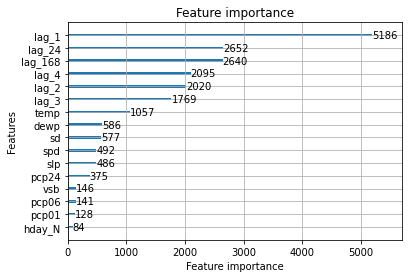

In [58]:
lgb.plot_importance(model)

In [82]:
y_test_df = pd.DataFrame(y_test, index = X_test.index)
y_test_df.index = pd.to_datetime(y_test_df.index)
y_test_df.columns = ['actual']

In [83]:
y_gs = pd.Series(y_gs, index = X_test.index)
y_gs.index = pd.to_datetime(y_gs.index)
y_gs

pickup_dt
2015-06-01 00:00:00    2322.472205
2015-06-01 01:00:00    1227.060353
2015-06-01 02:00:00     623.879603
2015-06-01 03:00:00     625.822660
2015-06-01 04:00:00     504.936343
                          ...     
2015-06-30 19:00:00    4824.211372
2015-06-30 20:00:00    4766.351966
2015-06-30 21:00:00    4263.937990
2015-06-30 22:00:00    4346.823161
2015-06-30 23:00:00    4149.930263
Length: 720, dtype: float64

In [86]:
pd.concat([y_test_df,y_pred_df], axis=1).plot()


Figure(id='1742', ...)

In [43]:
y_test_df

pickup_dt
2015-06-01 00:00:00    528
2015-06-01 01:00:00    337
2015-06-01 02:00:00    194
2015-06-01 03:00:00    128
2015-06-01 04:00:00    170
                      ... 
2015-06-30 19:00:00    777
2015-06-30 20:00:00    817
2015-06-30 21:00:00    829
2015-06-30 22:00:00    860
2015-06-30 23:00:00    990
Name: pickups, Length: 720, dtype: int64

In [44]:
y_test_df.to_csv('../y_test_df.csv')

In [45]:
import pickle

pickle.dump(model, open('model_lgbm_brooklyn.pkl','wb'))

In [58]:
#y_test.to_csv('../y_test_lgbm.csv')

In [59]:
#X_test.to_csv('../X_test_lgbm.csv',index=False)

In [60]:
y_test

pickup_dt
2015-06-01 00:00:00    1301
2015-06-01 01:00:00     704
2015-06-01 02:00:00     488
2015-06-01 03:00:00     349
2015-06-01 04:00:00     453
                       ... 
2015-06-30 19:00:00    4585
2015-06-30 20:00:00    4210
2015-06-30 21:00:00    4313
2015-06-30 22:00:00    4452
2015-06-30 23:00:00    3828
Name: pickups, Length: 720, dtype: int64